In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''
import cv2
from sklearn.model_selection import train_test_split
from sklearn import datasets
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from torch.backends import cudnn
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import torchvision as tv
from torch.utils.data import TensorDataset,DataLoader

import torchvision
import torchvision.datasets as Dataset
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm import tqdm
import copy
import torchvision as tv
import cv2
from torch.utils.data import random_split
import pandas as pd
import os
from torch.utils.data import TensorDataset

import skimage.io as io
from tqdm import tqdm
from tensorboardX import SummaryWriter
from copy import deepcopy
import time

import sys

import torch
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from torch.optim.sgd import SGD
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

from PIL import Image
from collections import Counter
from sklearn.metrics import f1_score,precision_score,recall_score
class GradualWarmupScheduler(_LRScheduler):
    """ Gradually warm-up(increasing) learning rate in optimizer.
    Proposed in 'Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour'.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        multiplier: target learning rate = base lr * multiplier if multiplier > 1.0. if multiplier = 1.0, lr starts from 0 and ends up with the base_lr.
        total_epoch: target learning rate is reached at total_epoch, gradually
        after_scheduler: after target_epoch, use this scheduler(eg. ReduceLROnPlateau)
    """
 
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        self.multiplier = multiplier
        if self.multiplier < 1.:
            raise ValueError('multiplier should be greater thant or equal to 1.')
        self.total_epoch = total_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        super(GradualWarmupScheduler, self).__init__(optimizer)
 
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_last_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
 
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
 
    def step_ReduceLROnPlateau(self, metrics, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch if epoch != 0 else 1  # ReduceLROnPlateau is called at the end of epoch, whereas others are called at beginning
        if self.last_epoch <= self.total_epoch:
            warmup_lr = [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
            for param_group, lr in zip(self.optimizer.param_groups, warmup_lr):
                param_group['lr'] = lr
        else:
            if epoch is None:
                self.after_scheduler.step(metrics, None)
            else:
                self.after_scheduler.step(metrics, epoch - self.total_epoch)
 
    def step(self, epoch=None, metrics=None):
        if type(self.after_scheduler) != ReduceLROnPlateau:
            if self.finished and self.after_scheduler:
                if epoch is None:
                    self.after_scheduler.step(None)
                else:
                    self.after_scheduler.step(epoch - self.total_epoch)
                self._last_lr = self.after_scheduler.get_last_lr()
            else:
                return super(GradualWarmupScheduler, self).step(epoch)
        else:
            self.step_ReduceLROnPlateau(metrics, epoch)


In [2]:
import torchvision.models as models

In [3]:
!pip install thop

In [4]:
from torchvision.models import resnet50
from thop import profile
model = resnet50()
input = torch.randn(1, 3, 224, 224)


In [5]:
features = models.mobilenet_v2().features
base_flops, base_params = profile(features, inputs=(input, ))
print(base_flops, base_params)
for i in range(1,20):
    print(-i,features[:-i](torch.randn(1,3,224,224)).shape)
    flops, params = profile(features[:-i], inputs=(input, ))
    print(flops/base_flops, params/base_params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU6'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
326206720.0 2223872.0
-1 torch.Size([1, 320, 7, 7])
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU6'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
0.9377042876369929 0.814665592264303
-2 torch.Size([1, 160, 7, 7])
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.R

In [6]:
sub_ids = pd.read_csv('/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv')
s = sub_ids['subject'].values.tolist()
c = sub_ids['classname'].values.tolist()
imgs = sub_ids['img'].values.tolist()
sub_dics = {}
for i in range(len(s)):
    temps = s[i]
    tempc = c[i]
    tempimgs = imgs[i]
    sub_dics[tempc+'/'+tempimgs] = temps
    '''if temps not in sub_dics:
        sub_dics[temps] = [tempc+'/'+tempimgs]
    else:
        sub_dics[temps].append(tempc+'/'+tempimgs)'''
train_annos = pd.read_csv('/kaggle/input/state-farm-annos/train_list_d_01.csv')
train_images = train_annos['img'].values.tolist()
train_cates = train_annos['classname'].values.tolist()
train_paths = [train_cates[i]+'/'+train_images[i] for i in range(len(train_images))]

test_annos = pd.read_csv('/kaggle/input/state-farm-annos/val_list_d_01.csv')
test_images = test_annos['img'].values.tolist()
test_cates = test_annos['classname'].values.tolist()
test_paths = [test_cates[i]+'/'+test_images[i] for i in range(len(test_images))]

globalpath = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train'
filepath = ['/c0','/c1','/c2','/c3','/c4','/c5','/c6','/c7','/c8','/c9']

trainset = []
validset = []
for label,f in enumerate(filepath):
    print(label,f)
    imgs = globalpath + f
    for dirname, _, filenames in os.walk(imgs):
        for filename in filenames:
            temppath = os.path.join(dirname, filename)
            im_o = Image.open(temppath)
            im_o = transforms.Resize([224,224])(im_o)

            anno = f + '/' +filename
            anno = anno[1:]
            if anno in train_paths:
                trainset.append([im_o,label,sub_dics[anno]])
            if anno in test_paths:
                validset.append([im_o,label,sub_dics[anno]])

        print(len(trainset),len(validset))
print('处理完成')
train_len = len(trainset)
valid_len = len(validset)
train_all = train_len

train_subs = []
for t in trainset:
    if t[2] not in train_subs:
        train_subs.append(t[2])
print(train_subs)

len_train_subs = len(train_subs)
train_sub_ids = {}
for i in range(len(train_subs)):
    train_sub_ids[train_subs[i]] = i
    

    
trainset2 = []
for t in trainset:
    trainset2.append([t[0],t[1],train_sub_ids[t[2]]])
trainset = trainset2

0 /c0
1766 723
1 /c1
3389 1367
2 /c2
5038 2035
3 /c3
6684 2735
4 /c4
8307 3438
5 /c5
9921 4136
6 /c6
11570 4812
7 /c7
12953 5431
8 /c8
14336 5959
9 /c9
15899 6525
处理完成
['p021', 'p081', 'p051', 'p061', 'p042', 'p024', 'p015', 'p014', 'p016', 'p064', 'p049', 'p022', 'p056', 'p052', 'p066', 'p039', 'p072', 'p047']


In [7]:
valid_len = len(validset)
train_len = len(trainset)
train_all = train_len

In [8]:
class MSFIN_teacher(nn.Module):
    def __init__(self):
        super(MSFIN_teacher,self).__init__()
        
        model = models.mobilenet_v2(pretrained=True)
        self.features = model.features
        self.fc = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=1280, out_features=10, bias=True)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

    def getGAP(self,f):
        return self.avgpool(f).squeeze(-1).squeeze(-1)
    def getCAM(self,y,f,w,bias):
        camlists = []
        
        for i in range(y.size(0)):
            idx = y[i]
            tempw = w[idx]
            tempf = f[i]
            tempbias = bias[idx]
            c,d,e = tempf.size()
            
            tempf = tempw.unsqueeze(1).unsqueeze(1) * tempf
            tempf = tempf.sum(0) + tempbias
            cam = tempf.reshape(-1)

            c,d = tempf.size()
            cam = tempf.reshape(-1)
            cam = (cam-cam.min())/(cam.max()-cam.min())
            cam = cam.reshape(d,e)
            camlists.append(cam)
        return torch.stack(camlists,0)
        
    def forward(self,x):
        f = self.features(x)
        avgf = self.getGAP(f)
        preds = self.fc(avgf)
        
        w = self.fc[1].weight
        b = self.fc[1].bias
        #print(f.shape,w.shape)
        cams = f.unsqueeze(1) * w.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        cams = cams.sum(2) + b.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

        return cams

In [9]:
class MSFIN(nn.Module):
    def __init__(self,teacher):
        super(MSFIN,self).__init__()
        
        self.teacher = teacher
        
        model = models.mobilenet_v2(pretrained=True)
        self.features = model.features[:-8]
        self.fc = nn.Sequential(
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=64, out_features=10, bias=True)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

    def getGAP(self,f):
        return self.avgpool(f).squeeze(-1).squeeze(-1)
    def getCAM(self,y,f,w,bias):
        camlists = []
        
        for i in range(y.size(0)):
            idx = y[i]
            tempw = w[idx]
            tempf = f[i]
            tempbias = bias[idx]
            c,d,e = tempf.size()
            
            tempf = tempw.unsqueeze(1).unsqueeze(1) * tempf
            tempf = tempf.sum(0) + tempbias
            cam = tempf.reshape(-1)

            c,d = tempf.size()
            cam = tempf.reshape(-1)
            cam = cam - cam.min().detach()
            cam = cam / cam.max().detach()
            #cam = (cam-cam.min())/(cam.max()-cam.min())
            cam = cam.reshape(d,e)
            camlists.append(cam)
        return torch.stack(camlists,0)
        
    def forward(self,x,y):
        
        f = self.features(x)
        avgf = self.getGAP(f)
        preds = self.fc(avgf)
        
        self.teacher.eval()
        cams_t = self.teacher(x).detach()
        
        
        w = self.fc[1].weight
        b = self.fc[1].bias
        cams = f.unsqueeze(1) * w.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
        cams_s = cams.sum(2) + b.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

        a,b,c,d = cams_t.size()
        cams_t = cams_t.reshape(a*b,1,c,d)
        #print(cams_t.shape,cams_s.shape)
        #print(cams_t.shape)
        cams_t = F.interpolate(cams_t, size=(cams_s.size(2), cams_s.size(3)), mode='bilinear', align_corners=False)
        #print(cams_t.shape)
        cams_t = cams_t.squeeze(1)
        #print(cams_t.shape)
        cams_t = cams_t.reshape(a,b,cams_s.size(2), cams_s.size(3))
        
        #print(cams_s.shape,cams_t.shape)
        loss = nn.MSELoss()(cams_s,cams_t)
        return preds,loss

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 105MB/s] 
  0%|          | 0/400 [00:00<?, ?it/s]

***训练集***
0.1075
valid-f1: 0.029877982707058194
valid-precision: 0.02378950177447004
valid-recall: 0.09718891702864445
process: 1  loss: 57.6933171749115  train_correct: 0.005409145229259702 valid_loss 470.4353058338165  val_correct: 0.10298850574712644


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/400 [00:16<1:51:00, 16.69s/it]

The model has been saved!!
The best val_acc is  0.10298850574712644
***训练集***
0.08125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 2/400 [00:32<1:47:21, 16.18s/it]

valid-f1: 0.05690843441488872
valid-precision: 0.05956263995614532
valid-recall: 0.11788008360237316
process: 2  loss: 57.69882655143738  train_correct: 0.004088307440719542 valid_loss 468.93654441833496  val_correct: 0.1253639846743295
The model has been saved!!
The best val_acc is  0.1253639846743295
***训练集***
0.13375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 3/400 [00:48<1:45:33, 15.95s/it]

valid-f1: 0.12077431152432756
valid-precision: 0.1404978613693879
valid-recall: 0.17501312888628456
process: 3  loss: 57.42035627365112  train_correct: 0.0067299830177998616 valid_loss 466.6934401988983  val_correct: 0.18421455938697318
The model has been saved!!
The best val_acc is  0.18421455938697318
***训练集***
0.1275


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 4/400 [01:04<1:44:57, 15.90s/it]

valid-f1: 0.1397232733367605
valid-precision: 0.1717097133279843
valid-recall: 0.22917916363906218
process: 4  loss: 57.27615785598755  train_correct: 0.006415497830052205 valid_loss 463.8939301967621  val_correct: 0.23938697318007662
The model has been saved!!
The best val_acc is  0.23938697318007662
***训练集***
0.19625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▏         | 5/400 [01:19<1:44:20, 15.85s/it]

valid-f1: 0.19275675820024524
valid-precision: 0.2963348906814339
valid-recall: 0.2404039313799397
process: 5  loss: 56.935749530792236  train_correct: 0.009874834895276432 valid_loss 460.0506663322449  val_correct: 0.2534865900383142
The model has been saved!!
The best val_acc is  0.2534865900383142
***训练集***
0.18125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 6/400 [01:35<1:43:42, 15.79s/it]

valid-f1: 0.20356442938055413
valid-precision: 0.2637025927717652
valid-recall: 0.2738093277128118
process: 6  loss: 56.533623456954956  train_correct: 0.009120070444682056 valid_loss 452.308252453804  val_correct: 0.28367816091954023
The model has been saved!!
The best val_acc is  0.28367816091954023
***训练集***
0.22


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 7/400 [01:50<1:42:26, 15.64s/it]

valid-f1: 0.11799597811454994
valid-precision: 0.29309105388324225
valid-recall: 0.16072063037697423
process: 7  loss: 55.45987510681152  train_correct: 0.01106987860871753 valid_loss 447.4520437717438  val_correct: 0.16689655172413792
***训练集***
0.25625


  2%|▏         | 8/400 [02:06<1:41:43, 15.57s/it]

valid-f1: 0.268016024857831
valid-precision: 0.5505406668884578
valid-recall: 0.30331225031557313
process: 8  loss: 53.856860399246216  train_correct: 0.01289389269765394 valid_loss 419.239514708519  val_correct: 0.3081992337164751
The model has been saved!!
The best val_acc is  0.3081992337164751
***训练集***
0.33375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 9/400 [02:21<1:40:52, 15.48s/it]

valid-f1: 0.17720074611259923
valid-precision: 0.28168340740001785
valid-recall: 0.21206035748025137
process: 9  loss: 50.92228972911835  train_correct: 0.01679350902572489 valid_loss 410.07437378168106  val_correct: 0.22007662835249042
***训练集***
0.3675


  2%|▎         | 10/400 [02:36<1:40:32, 15.47s/it]

valid-f1: 0.2774394052106305
valid-precision: 0.5150488705790379
valid-recall: 0.34221953244006315
process: 10  loss: 46.74993574619293  train_correct: 0.018491729039562237 valid_loss 356.82810682058334  val_correct: 0.3489655172413793
The model has been saved!!
The best val_acc is  0.3489655172413793
***训练集***
0.40375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 11/400 [02:52<1:39:52, 15.41s/it]

valid-f1: 0.21575480278974365
valid-precision: 0.20760176350930334
valid-recall: 0.30862976005612286
process: 11  loss: 44.13983118534088  train_correct: 0.020315743128498646 valid_loss 400.2317875623703  val_correct: 0.315095785440613
***训练集***
0.44875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 12/400 [03:07<1:39:49, 15.44s/it]

valid-f1: 0.33093552091582906
valid-precision: 0.4123464417103784
valid-recall: 0.38260218461676676
process: 12  loss: 40.77827274799347  train_correct: 0.022580036480281777 valid_loss 356.5546466782689  val_correct: 0.38727969348659
The model has been saved!!
The best val_acc is  0.38727969348659
***训练集***
0.495


  3%|▎         | 13/400 [03:23<1:39:26, 15.42s/it]

valid-f1: 0.405351963281824
valid-precision: 0.4664146487845288
valid-recall: 0.4915187087389052
process: 13  loss: 37.65199112892151  train_correct: 0.02490722686961444 valid_loss 319.6434876024723  val_correct: 0.4974712643678161
The model has been saved!!
The best val_acc is  0.4974712643678161
***训练集***
0.52125


  4%|▎         | 14/400 [03:38<1:39:25, 15.45s/it]

valid-f1: 0.43530543174282055
valid-precision: 0.521248207458528
valid-recall: 0.49199579884429834
process: 14  loss: 34.99313414096832  train_correct: 0.026228064658154603 valid_loss 279.6667496189475  val_correct: 0.49808429118773945
The model has been saved!!
The best val_acc is  0.49808429118773945
***训练集***
0.58


  4%|▍         | 15/400 [03:53<1:38:59, 15.43s/it]

valid-f1: 0.502313844426227
valid-precision: 0.587470565540941
valid-recall: 0.5354094263643174
process: 15  loss: 32.719130992889404  train_correct: 0.029184225422982577 valid_loss 272.4385272562504  val_correct: 0.5402298850574713
The model has been saved!!
The best val_acc is  0.5402298850574713
***训练集***
0.56375


  4%|▍         | 16/400 [04:09<1:38:57, 15.46s/it]

valid-f1: 0.5552207948620941
valid-precision: 0.6261509980682124
valid-recall: 0.5943712291077505
process: 16  loss: 32.24911272525787  train_correct: 0.02836656393483867 valid_loss 238.98624439537525  val_correct: 0.6016858237547893
The model has been saved!!
The best val_acc is  0.6016858237547893
***训练集***
0.5975


  4%|▍         | 17/400 [04:24<1:38:19, 15.40s/it]

valid-f1: 0.6993659117604973
valid-precision: 0.7102362686911065
valid-recall: 0.7138215580505791
process: 17  loss: 30.905224204063416  train_correct: 0.030064783948676017 valid_loss 200.51208618283272  val_correct: 0.7215325670498084
The model has been saved!!
The best val_acc is  0.7215325670498084
***训练集***
0.6


  4%|▍         | 18/400 [04:40<1:38:00, 15.39s/it]

valid-f1: 0.5366059402608435
valid-precision: 0.6588493000185401
valid-recall: 0.5576066862961834
process: 18  loss: 29.159943342208862  train_correct: 0.030190578023775082 valid_loss 254.45239801704884  val_correct: 0.56
***训练集***
0.66


  5%|▍         | 19/400 [04:55<1:37:34, 15.37s/it]

valid-f1: 0.7093187872435889
valid-precision: 0.7282820445582453
valid-recall: 0.7170437971438469
process: 19  loss: 27.483411192893982  train_correct: 0.033209635826152585 valid_loss 182.96441674232483  val_correct: 0.7256704980842912
The model has been saved!!
The best val_acc is  0.7256704980842912
***训练集***
0.69125


  5%|▌         | 20/400 [05:10<1:37:24, 15.38s/it]

valid-f1: 0.6259538719013598
valid-precision: 0.6926178659686213
valid-recall: 0.6273977549396047
process: 20  loss: 24.76628178358078  train_correct: 0.034782061764890876 valid_loss 207.169782564044  val_correct: 0.6337164750957854
***训练集***
0.695


  5%|▌         | 21/400 [05:26<1:37:02, 15.36s/it]

valid-f1: 0.6799320108858189
valid-precision: 0.7477022711258633
valid-recall: 0.6886843290022565
process: 21  loss: 25.05572932958603  train_correct: 0.034970752877539465 valid_loss 199.28335897251964  val_correct: 0.6876628352490421
***训练集***
0.75625


  6%|▌         | 22/400 [05:41<1:36:57, 15.39s/it]

valid-f1: 0.7775538165412691
valid-precision: 0.8067285818783742
valid-recall: 0.7748447780840044
process: 22  loss: 21.331541657447815  train_correct: 0.03805270771746651 valid_loss 149.37477208301425  val_correct: 0.7842145593869732
The model has been saved!!
The best val_acc is  0.7842145593869732
***训练集***
0.73


  6%|▌         | 23/400 [05:56<1:36:34, 15.37s/it]

valid-f1: 0.806763440776219
valid-precision: 0.8243614587656456
valid-recall: 0.8029651560357273
process: 23  loss: 22.64488273859024  train_correct: 0.036731869928926346 valid_loss 131.355811111629  val_correct: 0.8091954022988506
The model has been saved!!
The best val_acc is  0.8091954022988506
***训练集***
0.73625


  6%|▌         | 24/400 [06:12<1:36:31, 15.40s/it]

valid-f1: 0.7603690578098228
valid-precision: 0.810598866787865
valid-recall: 0.7582443815952156
process: 24  loss: 21.57960671186447  train_correct: 0.03704635511667401 valid_loss 163.7239117110148  val_correct: 0.7621455938697318
***训练集***
0.75


  6%|▋         | 25/400 [06:27<1:36:04, 15.37s/it]

valid-f1: 0.7859321577861997
valid-precision: 0.8276802905109355
valid-recall: 0.7852224414173172
process: 25  loss: 20.75074017047882  train_correct: 0.03773822252971885 valid_loss 144.77777959406376  val_correct: 0.7811494252873563
***训练集***
0.77625


  6%|▋         | 26/400 [06:43<1:36:03, 15.41s/it]

valid-f1: 0.6794592231284543
valid-precision: 0.7820830348355817
valid-recall: 0.689211790023104
process: 26  loss: 19.514320820569992  train_correct: 0.03905906031825901 valid_loss 197.79518291540444  val_correct: 0.7034482758620689
***训练集***
0.77875


  7%|▋         | 27/400 [06:58<1:35:42, 15.40s/it]

valid-f1: 0.7193929624921622
valid-precision: 0.762477913857286
valid-recall: 0.7208743468626133
process: 27  loss: 18.125263541936874  train_correct: 0.03918485439335807 valid_loss 156.8458312228322  val_correct: 0.7192337164750958
***训练集***
0.73875


  7%|▋         | 28/400 [07:14<1:35:45, 15.44s/it]

valid-f1: 0.8137661887991638
valid-precision: 0.8219925242662116
valid-recall: 0.8146741120297974
process: 28  loss: 19.654201686382294  train_correct: 0.037172149191773064 valid_loss 117.9248975738883  val_correct: 0.8191570881226053
The model has been saved!!
The best val_acc is  0.8191570881226053
***训练集***
0.80125


  7%|▋         | 29/400 [07:29<1:35:31, 15.45s/it]

valid-f1: 0.7630085011563932
valid-precision: 0.8188968467868769
valid-recall: 0.7688058463727836
process: 29  loss: 16.893619865179062  train_correct: 0.04031700106924964 valid_loss 142.85853670164943  val_correct: 0.7760919540229885
***训练集***
0.7725


  8%|▊         | 30/400 [07:45<1:35:13, 15.44s/it]

valid-f1: 0.6733569205117111
valid-precision: 0.8028800018047197
valid-recall: 0.651055226891609
process: 30  loss: 18.095607340335846  train_correct: 0.03887036920561041 valid_loss 225.77823966147844  val_correct: 0.6511877394636015
***训练集***
0.765


  8%|▊         | 31/400 [08:00<1:34:55, 15.44s/it]

valid-f1: 0.8112008320818737
valid-precision: 0.8368716585873045
valid-recall: 0.8077330800450255
process: 31  loss: 18.601274073123932  train_correct: 0.038492986980313226 valid_loss 121.11625589150935  val_correct: 0.8179310344827586
***训练集***
0.79625


  8%|▊         | 32/400 [08:16<1:34:55, 15.48s/it]

valid-f1: 0.7968531986687408
valid-precision: 0.8283886996533468
valid-recall: 0.797875067737073
process: 32  loss: 16.815755546092987  train_correct: 0.04006541291905151 valid_loss 126.40607200935483  val_correct: 0.8016858237547893
***训练集***
0.81125


  8%|▊         | 33/400 [08:31<1:34:30, 15.45s/it]

valid-f1: 0.84342642790818
valid-precision: 0.8670536867237226
valid-recall: 0.8413936591889459
process: 33  loss: 16.146686106920242  train_correct: 0.04082017736964589 valid_loss 101.60119825787842  val_correct: 0.8524137931034482
The model has been saved!!
The best val_acc is  0.8524137931034482
***训练集***
0.80375


  8%|▊         | 34/400 [08:46<1:34:08, 15.43s/it]

valid-f1: 0.8110811098650753
valid-precision: 0.8186229093716497
valid-recall: 0.8144721594135895
process: 34  loss: 15.682653665542603  train_correct: 0.0404427951443487 valid_loss 109.53522025234997  val_correct: 0.8232950191570881
***训练集***
0.80375


  9%|▉         | 35/400 [09:02<1:33:47, 15.42s/it]

valid-f1: 0.8041739539784369
valid-precision: 0.8393636052200231
valid-recall: 0.804542087626206
process: 35  loss: 15.670599579811096  train_correct: 0.0404427951443487 valid_loss 121.22412673011422  val_correct: 0.8170114942528736
***训练集***
0.79125


  9%|▉         | 36/400 [09:17<1:33:54, 15.48s/it]

valid-f1: 0.8011861464100946
valid-precision: 0.844320423554071
valid-recall: 0.8094057930830921
process: 36  loss: 15.600457847118378  train_correct: 0.03981382476885339 valid_loss 119.00637204945087  val_correct: 0.8055172413793104
***训练集***
0.8125


  9%|▉         | 37/400 [09:33<1:33:23, 15.44s/it]

valid-f1: 0.812936201989034
valid-precision: 0.8265713303468246
valid-recall: 0.8157978561887965
process: 37  loss: 14.764569967985153  train_correct: 0.04088307440719542 valid_loss 117.79195140302181  val_correct: 0.8213026819923371
***训练集***
0.80625


 10%|▉         | 38/400 [09:48<1:33:06, 15.43s/it]

valid-f1: 0.7976814602938613
valid-precision: 0.8101358992738387
valid-recall: 0.7999642284554459
process: 38  loss: 15.16047465801239  train_correct: 0.04056858921944776 valid_loss 120.41202421253547  val_correct: 0.8052107279693487
***训练集***
0.83625


 10%|▉         | 39/400 [10:03<1:32:34, 15.39s/it]

valid-f1: 0.7153537850070413
valid-precision: 0.7668193436761571
valid-recall: 0.7250796067860088
process: 39  loss: 13.28402066230774  train_correct: 0.04207811812063652 valid_loss 158.28491171076894  val_correct: 0.7377777777777778
***训练集***
0.80625


 10%|█         | 40/400 [10:19<1:32:26, 15.41s/it]

valid-f1: 0.8351109116610536
valid-precision: 0.839977628496164
valid-recall: 0.8415669990288948
process: 40  loss: 14.185348778963089  train_correct: 0.04056858921944776 valid_loss 102.76554556656629  val_correct: 0.8453639846743295
***训练集***
0.80375


 10%|█         | 41/400 [10:34<1:31:56, 15.37s/it]

valid-f1: 0.8202573213790437
valid-precision: 0.8300652511037419
valid-recall: 0.8243710854927645
process: 41  loss: 15.111098408699036  train_correct: 0.0404427951443487 valid_loss 115.45317286625504  val_correct: 0.832183908045977
***训练集***
0.7975


 10%|█         | 42/400 [10:49<1:31:41, 15.37s/it]

valid-f1: 0.8272938384403927
valid-precision: 0.836618526831497
valid-recall: 0.833563760283132
process: 42  loss: 14.937724769115448  train_correct: 0.04012830995660104 valid_loss 110.16821588296443  val_correct: 0.8377011494252874
***训练集***
0.8175


 11%|█         | 43/400 [11:05<1:31:17, 15.34s/it]

valid-f1: 0.8095620884722479
valid-precision: 0.8322474179821725
valid-recall: 0.809476672395561
process: 43  loss: 14.338632211089134  train_correct: 0.04113466255739354 valid_loss 114.04977443814278  val_correct: 0.8134865900383141
***训练集***
0.85625


 11%|█         | 44/400 [11:20<1:31:05, 15.35s/it]

valid-f1: 0.8353119076515922
valid-precision: 0.8507029162440347
valid-recall: 0.8382170007966592
process: 44  loss: 11.839955568313599  train_correct: 0.04308447072142902 valid_loss 101.56923015229404  val_correct: 0.8415325670498084
***训练集***
0.83125


 11%|█▏        | 45/400 [11:35<1:30:45, 15.34s/it]

valid-f1: 0.8588060653684841
valid-precision: 0.8594285175452342
valid-recall: 0.8612582384776895
process: 45  loss: 13.03580516576767  train_correct: 0.04182652997043839 valid_loss 86.10312022827566  val_correct: 0.8642145593869732
The model has been saved!!
The best val_acc is  0.8642145593869732
***训练集***
0.825


 12%|█▏        | 46/400 [11:51<1:30:23, 15.32s/it]

valid-f1: 0.8254221663952002
valid-precision: 0.839589157827443
valid-recall: 0.8252726714589897
process: 46  loss: 13.143228024244308  train_correct: 0.04151204478269074 valid_loss 105.9041715040803  val_correct: 0.829272030651341
***训练集***
0.8375


 12%|█▏        | 47/400 [12:06<1:30:06, 15.31s/it]

valid-f1: 0.8278431292244139
valid-precision: 0.8483015731707407
valid-recall: 0.8272268823898601
process: 47  loss: 12.857539772987366  train_correct: 0.04214101515818605 valid_loss 99.31095846369863  val_correct: 0.8369348659003831
***训练集***
0.86125


 12%|█▏        | 48/400 [12:21<1:29:59, 15.34s/it]

valid-f1: 0.7778500401280611
valid-precision: 0.811862839239357
valid-recall: 0.7866789768332678
process: 48  loss: 11.924314051866531  train_correct: 0.04333605887162715 valid_loss 131.6264879256487  val_correct: 0.7926436781609195
***训练集***
0.83375


 12%|█▏        | 49/400 [12:37<1:29:47, 15.35s/it]

valid-f1: 0.8158983626336258
valid-precision: 0.8407815116528748
valid-recall: 0.8163378057998605
process: 49  loss: 13.042400866746902  train_correct: 0.041952324045537455 valid_loss 102.83052462432534  val_correct: 0.819463601532567
***训练集***
0.8475


 12%|█▎        | 50/400 [12:52<1:29:32, 15.35s/it]

valid-f1: 0.7968542236757312
valid-precision: 0.8219925181936263
valid-recall: 0.8140671572023619
process: 50  loss: 12.804078482091427  train_correct: 0.0426441914585823 valid_loss 117.45171516761184  val_correct: 0.813639846743295
***训练集***
0.8475


 13%|█▎        | 51/400 [13:08<1:29:19, 15.36s/it]

valid-f1: 0.7850869729546506
valid-precision: 0.838163203168605
valid-recall: 0.7932689194950466
process: 51  loss: 11.705854371190071  train_correct: 0.0426441914585823 valid_loss 135.33797837700695  val_correct: 0.8010727969348659
***训练集***
0.81375


 13%|█▎        | 52/400 [13:23<1:28:52, 15.32s/it]

valid-f1: 0.7800615882873528
valid-precision: 0.8358323362787354
valid-recall: 0.7858776374018099
process: 52  loss: 14.137741848826408  train_correct: 0.040945971444744954 valid_loss 128.10850663343444  val_correct: 0.8004597701149425
***训练集***
0.8125


 13%|█▎        | 53/400 [13:38<1:28:34, 15.32s/it]

valid-f1: 0.8382154254123966
valid-precision: 0.8593326283035398
valid-recall: 0.8394491830396366
process: 53  loss: 13.476207375526428  train_correct: 0.04088307440719542 valid_loss 96.72269582096487  val_correct: 0.842911877394636
***训练集***
0.81125


 14%|█▎        | 54/400 [13:53<1:28:14, 15.30s/it]

valid-f1: 0.8233213364475522
valid-precision: 0.8461920513794625
valid-recall: 0.8273262410902908
process: 54  loss: 14.17074003815651  train_correct: 0.04082017736964589 valid_loss 110.30024622823112  val_correct: 0.8300383141762452
***训练集***
0.84625


 14%|█▍        | 55/400 [14:09<1:28:19, 15.36s/it]

valid-f1: 0.8661302648210576
valid-precision: 0.8699569392206774
valid-recall: 0.8716239536478128
process: 55  loss: 12.356138125061989  train_correct: 0.04258129442103277 valid_loss 79.71144374832511  val_correct: 0.8726436781609196
The model has been saved!!
The best val_acc is  0.8726436781609196
***训练集***
0.8475


 14%|█▍        | 56/400 [14:24<1:27:55, 15.34s/it]

valid-f1: 0.8592657808565372
valid-precision: 0.8734490358038155
valid-recall: 0.8612478052974779
process: 56  loss: 11.765591904520988  train_correct: 0.0426441914585823 valid_loss 83.82920998614281  val_correct: 0.8669731800766284
***训练集***
0.84


 14%|█▍        | 57/400 [14:40<1:27:55, 15.38s/it]

valid-f1: 0.8394793769257456
valid-precision: 0.856196699205056
valid-recall: 0.8402237587454919
process: 57  loss: 12.178989678621292  train_correct: 0.04226680923328511 valid_loss 93.27235757466406  val_correct: 0.8490421455938697
***训练集***
0.845
开始蒸馏


 14%|█▍        | 58/400 [14:55<1:27:31, 15.35s/it]

valid-f1: 0.8533930592054043
valid-precision: 0.8807393727750636
valid-recall: 0.8541338438760053
process: 58  loss: 11.685837373137474  train_correct: 0.04251839738348324 valid_loss 82.94485536310822  val_correct: 0.8629885057471265
***训练集***
0.76875


 15%|█▍        | 59/400 [15:10<1:27:14, 15.35s/it]

valid-f1: 0.8450626391958556
valid-precision: 0.8550145757887793
valid-recall: 0.8466933800987478
process: 59  loss: 1267.4500045776367  train_correct: 0.03868167809296182 valid_loss 93.24932304210961  val_correct: 0.8521072796934865
***训练集***
0.75


 15%|█▌        | 60/400 [15:26<1:26:58, 15.35s/it]

valid-f1: 0.8683087525917272
valid-precision: 0.8858187004446124
valid-recall: 0.864545485323054
process: 60  loss: 897.463716506958  train_correct: 0.03773822252971885 valid_loss 83.95616404188331  val_correct: 0.8755555555555555
The model has been saved!!
The best val_acc is  0.8755555555555555
***训练集***
0.78


 15%|█▌        | 61/400 [15:41<1:26:53, 15.38s/it]

valid-f1: 0.8585099177787197
valid-precision: 0.8837329418363048
valid-recall: 0.8557080855369019
process: 61  loss: 703.624044418335  train_correct: 0.039247751430907606 valid_loss 88.2888512511463  val_correct: 0.8680459770114942
***训练集***
0.775


 16%|█▌        | 62/400 [15:56<1:26:43, 15.40s/it]

valid-f1: 0.867100868807605
valid-precision: 0.898661897006121
valid-recall: 0.8652114417453053
process: 62  loss: 665.5261878967285  train_correct: 0.03899616328070948 valid_loss 86.42695577279665  val_correct: 0.8783141762452107
The model has been saved!!
The best val_acc is  0.8783141762452107
***训练集***
0.8


 16%|█▌        | 63/400 [16:12<1:26:34, 15.41s/it]

valid-f1: 0.8701094635660613
valid-precision: 0.8742013193788687
valid-recall: 0.8736067503012277
process: 63  loss: 601.6921844482422  train_correct: 0.04025410403170011 valid_loss 79.11332145782217  val_correct: 0.8781609195402299
***训练集***
0.83


 16%|█▌        | 64/400 [16:27<1:26:09, 15.39s/it]

valid-f1: 0.8924410400293553
valid-precision: 0.9017437979482258
valid-recall: 0.8896236524626391
process: 64  loss: 543.7703895568848  train_correct: 0.04176363293288886 valid_loss 73.37476172071183  val_correct: 0.8950191570881226
The model has been saved!!
The best val_acc is  0.8950191570881226
***训练集***
0.80875


 16%|█▋        | 65/400 [16:43<1:26:00, 15.40s/it]

valid-f1: 0.9262447770262094
valid-precision: 0.9279522457527205
valid-recall: 0.9252844632350609
process: 65  loss: 515.6943645477295  train_correct: 0.040694383294546825 valid_loss 46.332133602991235  val_correct: 0.9293486590038315
The model has been saved!!
The best val_acc is  0.9293486590038315
***训练集***
0.82625


 16%|█▋        | 66/400 [16:58<1:25:28, 15.36s/it]

valid-f1: 0.9004913379241433
valid-precision: 0.9077326809325375
valid-recall: 0.899014018535482
process: 66  loss: 498.8659782409668  train_correct: 0.04157494182024027 valid_loss 61.34898584615439  val_correct: 0.9055938697318008
***训练集***
0.82625


 17%|█▋        | 67/400 [17:13<1:25:01, 15.32s/it]

valid-f1: 0.9219791294227335
valid-precision: 0.937171825819456
valid-recall: 0.9177327727945102
process: 67  loss: 485.7297058105469  train_correct: 0.04157494182024027 valid_loss 57.55230656906497  val_correct: 0.9239846743295019
***训练集***
0.83125


 17%|█▋        | 68/400 [17:28<1:24:45, 15.32s/it]

valid-f1: 0.9204066654548182
valid-precision: 0.9226272483129744
valid-recall: 0.9199710576700708
process: 68  loss: 462.4237337112427  train_correct: 0.04182652997043839 valid_loss 55.33000581583474  val_correct: 0.924904214559387
***训练集***
0.8175


 17%|█▋        | 69/400 [17:44<1:24:32, 15.32s/it]

valid-f1: 0.9220540710361466
valid-precision: 0.9243539845278953
valid-recall: 0.9211977803889375
process: 69  loss: 480.18829917907715  train_correct: 0.04113466255739354 valid_loss 52.09254397501354  val_correct: 0.9255172413793104
***训练集***
0.84625


 18%|█▊        | 70/400 [17:59<1:24:09, 15.30s/it]

valid-f1: 0.9121448311969654
valid-precision: 0.9180362581696269
valid-recall: 0.9110817157129965
process: 70  loss: 465.8609809875488  train_correct: 0.04258129442103277 valid_loss 59.73921841598349  val_correct: 0.9172413793103448
***训练集***
0.84375


 18%|█▊        | 71/400 [18:15<1:24:14, 15.36s/it]

valid-f1: 0.9261756194309843
valid-precision: 0.9292372728019462
valid-recall: 0.9256376087084075
process: 71  loss: 429.5075378417969  train_correct: 0.042455500345933705 valid_loss 50.53525419248035  val_correct: 0.9310344827586207
The model has been saved!!
The best val_acc is  0.9310344827586207
***训练集***
0.845


 18%|█▊        | 72/400 [18:30<1:23:59, 15.37s/it]

valid-f1: 0.9249170439894698
valid-precision: 0.9338842456745275
valid-recall: 0.9236830175326256
process: 72  loss: 417.7388496398926  train_correct: 0.04251839738348324 valid_loss 58.39721306858701  val_correct: 0.9296551724137931
***训练集***
0.835


 18%|█▊        | 73/400 [18:45<1:23:51, 15.39s/it]

valid-f1: 0.9232975658093656
valid-precision: 0.9254186646217019
valid-recall: 0.923145663025579
process: 73  loss: 429.0081262588501  train_correct: 0.04201522108308699 valid_loss 54.20136102521792  val_correct: 0.927816091954023
***训练集***
0.84875


 18%|█▊        | 74/400 [19:01<1:23:21, 15.34s/it]

valid-f1: 0.9081034350301088
valid-precision: 0.9144727744386898
valid-recall: 0.9076410250059558
process: 74  loss: 423.77746772766113  train_correct: 0.042707088496131834 valid_loss 63.739162339188624  val_correct: 0.9127969348659004
***训练集***
0.845


 19%|█▉        | 75/400 [19:16<1:23:09, 15.35s/it]

valid-f1: 0.9168294634059657
valid-precision: 0.923132555715096
valid-recall: 0.9158877893932266
process: 75  loss: 416.02787685394287  train_correct: 0.04251839738348324 valid_loss 59.34564649005188  val_correct: 0.9212260536398468
***训练集***
0.86125


 19%|█▉        | 76/400 [19:32<1:23:16, 15.42s/it]

valid-f1: 0.9271854655895281
valid-precision: 0.9311392927900937
valid-recall: 0.9261023432388985
process: 76  loss: 417.8813705444336  train_correct: 0.04333605887162715 valid_loss 52.04565009105863  val_correct: 0.9311877394636016
The model has been saved!!
The best val_acc is  0.9311877394636016
***训练集***
0.84125


 19%|█▉        | 77/400 [19:47<1:23:02, 15.43s/it]

valid-f1: 0.9129514073491001
valid-precision: 0.9261172056255708
valid-recall: 0.9125681398205089
process: 77  loss: 403.8436403274536  train_correct: 0.04232970627083464 valid_loss 65.21290898841107  val_correct: 0.9206130268199234
***训练集***
0.86


 20%|█▉        | 78/400 [20:02<1:22:35, 15.39s/it]

valid-f1: 0.9251826465031389
valid-precision: 0.9282531848463549
valid-recall: 0.9245863037167593
process: 78  loss: 401.72431468963623  train_correct: 0.04327316183407762 valid_loss 49.630081542767584  val_correct: 0.9291954022988506
***训练集***
0.86


 20%|█▉        | 79/400 [20:18<1:22:46, 15.47s/it]

valid-f1: 0.9292668097552115
valid-precision: 0.9309603670902613
valid-recall: 0.9305541502223695
process: 79  loss: 400.05717372894287  train_correct: 0.04327316183407762 valid_loss 46.735010287637124  val_correct: 0.931647509578544
The model has been saved!!
The best val_acc is  0.931647509578544
***训练集***
0.85625


 20%|██        | 80/400 [20:33<1:22:18, 15.43s/it]

valid-f1: 0.9138332265543921
valid-precision: 0.9245732264251769
valid-recall: 0.9126807357390458
process: 80  loss: 381.65651988983154  train_correct: 0.04308447072142902 valid_loss 65.06831039087956  val_correct: 0.9210727969348659
***训练集***
0.87875


 20%|██        | 81/400 [20:49<1:22:24, 15.50s/it]

valid-f1: 0.9218811093646705
valid-precision: 0.9286304321175205
valid-recall: 0.920622377250222
process: 81  loss: 386.55871868133545  train_correct: 0.044216617397320586 valid_loss 54.03867117545451  val_correct: 0.9267432950191571
***训练集***
0.85625


 20%|██        | 82/400 [21:04<1:21:59, 15.47s/it]

valid-f1: 0.9276100758463686
valid-precision: 0.9300000961922373
valid-recall: 0.9268465393296974
process: 82  loss: 373.2421598434448  train_correct: 0.04308447072142902 valid_loss 53.362408087050426  val_correct: 0.9318007662835249
The model has been saved!!
The best val_acc is  0.9318007662835249
***训练集***
0.8725


 21%|██        | 83/400 [21:20<1:21:46, 15.48s/it]

valid-f1: 0.9282032351127295
valid-precision: 0.9327564149418043
valid-recall: 0.9272342964013381
process: 83  loss: 368.9733467102051  train_correct: 0.04390213220957293 valid_loss 50.26073585332779  val_correct: 0.9331800766283525
The model has been saved!!
The best val_acc is  0.9331800766283525
***训练集***
0.86375


 21%|██        | 84/400 [21:35<1:21:04, 15.39s/it]

valid-f1: 0.9254749822591235
valid-precision: 0.9305688128309537
valid-recall: 0.923915220829525
process: 84  loss: 357.53190898895264  train_correct: 0.04346185294672621 valid_loss 52.44992324215127  val_correct: 0.9296551724137931
***训练集***
0.86375


 21%|██▏       | 85/400 [21:50<1:20:50, 15.40s/it]

valid-f1: 0.9243534520661394
valid-precision: 0.9321892803945723
valid-recall: 0.9227635721763807
process: 85  loss: 378.9481029510498  train_correct: 0.04346185294672621 valid_loss 52.72539939719718  val_correct: 0.9287356321839081
***训练集***
0.86125


 22%|██▏       | 86/400 [22:05<1:19:47, 15.25s/it]

valid-f1: 0.9189757228302643
valid-precision: 0.9246164007072603
valid-recall: 0.9182905617687271
process: 86  loss: 364.2486333847046  train_correct: 0.04333605887162715 valid_loss 57.405372847140825  val_correct: 0.9233716475095786
***训练集***
0.85875


 22%|██▏       | 87/400 [22:20<1:19:01, 15.15s/it]

valid-f1: 0.9207454236769497
valid-precision: 0.9222403517843272
valid-recall: 0.9204006890785704
process: 87  loss: 363.44432163238525  train_correct: 0.043210264796528085 valid_loss 54.85346345590369  val_correct: 0.9247509578544061
***训练集***
0.875


 22%|██▏       | 88/400 [22:35<1:18:30, 15.10s/it]

valid-f1: 0.9305014987822899
valid-precision: 0.9310723823631195
valid-recall: 0.9308102406249453
process: 88  loss: 360.02152919769287  train_correct: 0.04402792628467199 valid_loss 47.535159525839845  val_correct: 0.9347126436781609
The model has been saved!!
The best val_acc is  0.9347126436781609
***训练集***
0.865


 22%|██▏       | 89/400 [22:50<1:18:14, 15.10s/it]

valid-f1: 0.923566818884359
valid-precision: 0.9296146913551878
valid-recall: 0.9228857219134727
process: 89  loss: 368.6284294128418  train_correct: 0.04352474998427574 valid_loss 55.177956406412704  val_correct: 0.9298084291187739
***训练集***
0.87875


 22%|██▎       | 90/400 [23:05<1:17:36, 15.02s/it]

valid-f1: 0.9276526185467787
valid-precision: 0.9312235273695452
valid-recall: 0.9270225184996098
process: 90  loss: 370.10040283203125  train_correct: 0.044216617397320586 valid_loss 53.49736115439737  val_correct: 0.9330268199233717
***训练集***
0.87


 23%|██▎       | 91/400 [23:20<1:17:19, 15.01s/it]

valid-f1: 0.9244049328124351
valid-precision: 0.9273942746818019
valid-recall: 0.9236177731035877
process: 91  loss: 367.6989631652832  train_correct: 0.04377633813447387 valid_loss 53.07840708325966  val_correct: 0.9291954022988506
***训练集***
0.8575


 23%|██▎       | 92/400 [23:35<1:16:58, 15.00s/it]

valid-f1: 0.9259500733298951
valid-precision: 0.9322280085202204
valid-recall: 0.9255941596285476
process: 92  loss: 359.90425300598145  train_correct: 0.04314736775897855 valid_loss 56.2131110180635  val_correct: 0.9314942528735632
***训练集***
0.85875


 23%|██▎       | 93/400 [23:50<1:16:24, 14.93s/it]

valid-f1: 0.9286839784462202
valid-precision: 0.9340206619259576
valid-recall: 0.9271468467080902
process: 93  loss: 355.3289260864258  train_correct: 0.043210264796528085 valid_loss 52.62802108451433  val_correct: 0.9334865900383141
***训练集***
0.8675


 24%|██▎       | 94/400 [24:05<1:16:16, 14.96s/it]

valid-f1: 0.9284657285831248
valid-precision: 0.934179516856466
valid-recall: 0.9270326766769973
process: 94  loss: 346.75959873199463  train_correct: 0.0436505440593748 valid_loss 50.7313335709041  val_correct: 0.9331800766283525
***训练集***
0.88125


 24%|██▍       | 95/400 [24:20<1:15:59, 14.95s/it]

valid-f1: 0.9259782047057156
valid-precision: 0.9272525722766016
valid-recall: 0.926132850213816
process: 95  loss: 342.9561758041382  train_correct: 0.04434241147241965 valid_loss 52.56659054879856  val_correct: 0.9298084291187739
***训练集***
0.8675


 24%|██▍       | 96/400 [24:35<1:15:52, 14.98s/it]

valid-f1: 0.9249715254019899
valid-precision: 0.9293032045420071
valid-recall: 0.924529314967098
process: 96  loss: 331.5744743347168  train_correct: 0.0436505440593748 valid_loss 53.39492251641059  val_correct: 0.9293486590038315
***训练集***
0.875


 24%|██▍       | 97/400 [24:50<1:15:24, 14.93s/it]

valid-f1: 0.9288992248053857
valid-precision: 0.9321939645206859
valid-recall: 0.9285173005246566
process: 97  loss: 336.7191171646118  train_correct: 0.04402792628467199 valid_loss 50.81295626331121  val_correct: 0.933639846743295
***训练集***
0.84875


 24%|██▍       | 98/400 [25:05<1:15:23, 14.98s/it]

valid-f1: 0.9338218921560774
valid-precision: 0.9363518437799334
valid-recall: 0.9332808073031513
process: 98  loss: 348.84210681915283  train_correct: 0.042707088496131834 valid_loss 47.51704756439722  val_correct: 0.9380842911877395
The model has been saved!!
The best val_acc is  0.9380842911877395
***训练集***
0.87


 25%|██▍       | 99/400 [25:20<1:15:03, 14.96s/it]

valid-f1: 0.9313962171493415
valid-precision: 0.9350171141185308
valid-recall: 0.9303849193660161
process: 99  loss: 336.21131896972656  train_correct: 0.04377633813447387 valid_loss 47.08971248320995  val_correct: 0.9360919540229885
***训练集***
0.87


 25%|██▌       | 100/400 [25:35<1:14:57, 14.99s/it]

valid-f1: 0.9261617895785706
valid-precision: 0.9320177842857061
valid-recall: 0.9253274361280186
process: 100  loss: 335.26565647125244  train_correct: 0.04377633813447387 valid_loss 52.32069312133535  val_correct: 0.9310344827586207
***训练集***
0.8775


 25%|██▌       | 101/400 [25:50<1:14:37, 14.97s/it]

valid-f1: 0.9290629850842922
valid-precision: 0.933011166886967
valid-recall: 0.9281941911200526
process: 101  loss: 335.7314987182617  train_correct: 0.044153720359771054 valid_loss 50.119516529935936  val_correct: 0.9331800766283525
***训练集***
0.89375


 26%|██▌       | 102/400 [26:05<1:14:25, 14.98s/it]

valid-f1: 0.9222173915312852
valid-precision: 0.9257780302485633
valid-recall: 0.9217120271087357
process: 102  loss: 311.3687171936035  train_correct: 0.044971381847914965 valid_loss 49.30827295540803  val_correct: 0.9275095785440614
***训练集***
0.87625


 26%|██▌       | 103/400 [26:20<1:14:05, 14.97s/it]

valid-f1: 0.9188046290392015
valid-precision: 0.9247298841369442
valid-recall: 0.917942742029448
process: 103  loss: 339.4140453338623  train_correct: 0.04409082332222152 valid_loss 61.913025697896956  val_correct: 0.9233716475095786
***训练集***
0.88


 26%|██▌       | 104/400 [26:35<1:13:52, 14.97s/it]

valid-f1: 0.9278150702624567
valid-precision: 0.9311587239266993
valid-recall: 0.927092780412089
process: 104  loss: 327.98284912109375  train_correct: 0.04427951443487012 valid_loss 52.44832002569456  val_correct: 0.9322605363984674
***训练集***
0.8825


 26%|██▋       | 105/400 [26:50<1:13:30, 14.95s/it]

valid-f1: 0.9270226471230678
valid-precision: 0.9327652524089375
valid-recall: 0.926209829989847
process: 105  loss: 309.15592861175537  train_correct: 0.04440530850996918 valid_loss 54.47794815500674  val_correct: 0.9321072796934866
***训练集***
0.87875


 26%|██▋       | 106/400 [27:05<1:13:34, 15.02s/it]

valid-f1: 0.9264272275714965
valid-precision: 0.9292356204075606
valid-recall: 0.9256795390794416
process: 106  loss: 329.4564905166626  train_correct: 0.044216617397320586 valid_loss 52.457323938993795  val_correct: 0.9299616858237548
***训练集***
0.86625


 27%|██▋       | 107/400 [27:20<1:13:15, 15.00s/it]

valid-f1: 0.9260492694625958
valid-precision: 0.9277565777213995
valid-recall: 0.9255418741010525
process: 107  loss: 334.02495670318604  train_correct: 0.04358764702182527 valid_loss 50.97041288478067  val_correct: 0.9290421455938698
***训练集***
0.86375


 27%|██▋       | 108/400 [27:35<1:13:03, 15.01s/it]

valid-f1: 0.935538520993379
valid-precision: 0.9386056256249018
valid-recall: 0.9346110958806422
process: 108  loss: 325.41966342926025  train_correct: 0.04346185294672621 valid_loss 45.35284103328013  val_correct: 0.9397701149425287
The model has been saved!!
The best val_acc is  0.9397701149425287
***训练集***
0.86125


 27%|██▋       | 109/400 [27:50<1:12:31, 14.96s/it]

valid-f1: 0.9205506619526954
valid-precision: 0.9259395832109819
valid-recall: 0.9191370711272502
process: 109  loss: 322.76712703704834  train_correct: 0.04333605887162715 valid_loss 56.15481931249815  val_correct: 0.9242911877394636
***训练集***
0.8575


 28%|██▊       | 110/400 [28:05<1:12:24, 14.98s/it]

valid-f1: 0.9217958549552143
valid-precision: 0.9265768819476708
valid-recall: 0.9210021483329163
process: 110  loss: 322.61314964294434  train_correct: 0.04314736775897855 valid_loss 57.30669518560171  val_correct: 0.9262835249042145
***训练集***
0.87


 28%|██▊       | 111/400 [28:20<1:12:10, 14.98s/it]

valid-f1: 0.9306268622575701
valid-precision: 0.9339265029295856
valid-recall: 0.930013598006225
process: 111  loss: 316.2893371582031  train_correct: 0.04377633813447387 valid_loss 49.42981374483497  val_correct: 0.9348659003831418
***训练集***
0.87125
开始蒸馏


 28%|██▊       | 112/400 [28:35<1:12:05, 15.02s/it]

valid-f1: 0.9331114759047004
valid-precision: 0.9348291857388522
valid-recall: 0.9331004397355389
process: 112  loss: 323.04645919799805  train_correct: 0.0438392351720234 valid_loss 49.67643512864015  val_correct: 0.9371647509578545
***训练集***
0.8925


 28%|██▊       | 113/400 [28:50<1:11:38, 14.98s/it]

valid-f1: 0.9278927062695974
valid-precision: 0.9304804691795248
valid-recall: 0.9273949074630954
process: 113  loss: 317.50993251800537  train_correct: 0.04490848481036543 valid_loss 48.83653349312954  val_correct: 0.931647509578544
***训练集***
0.8775


 28%|██▊       | 114/400 [29:05<1:11:31, 15.01s/it]

valid-f1: 0.9238269472677192
valid-precision: 0.9258690926829957
valid-recall: 0.9232165370265506
process: 114  loss: 321.63326263427734  train_correct: 0.044153720359771054 valid_loss 53.71865792649078  val_correct: 0.9275095785440614
***训练集***
0.86875


 29%|██▉       | 115/400 [29:20<1:11:23, 15.03s/it]

valid-f1: 0.9199388924021731
valid-precision: 0.9264575608252417
valid-recall: 0.9186557964862201
process: 115  loss: 306.74792766571045  train_correct: 0.043713441096924335 valid_loss 59.89257821832871  val_correct: 0.9250574712643678
***训练集***
0.90125


 29%|██▉       | 116/400 [29:35<1:11:03, 15.01s/it]

valid-f1: 0.9257332328991599
valid-precision: 0.9318181055713083
valid-recall: 0.9248581652896564
process: 116  loss: 307.9450511932373  train_correct: 0.04534876407321215 valid_loss 53.86046552514017  val_correct: 0.9304214559386973
***训练集***
0.885


 29%|██▉       | 117/400 [29:50<1:10:57, 15.04s/it]

valid-f1: 0.9204049274252031
valid-precision: 0.9268075495794308
valid-recall: 0.9190128040775212
process: 117  loss: 303.4597454071045  train_correct: 0.04453110258506824 valid_loss 59.977227302973915  val_correct: 0.9245977011494253
***训练集***
0.8925


 30%|██▉       | 118/400 [30:05<1:10:48, 15.07s/it]

valid-f1: 0.9245407334644019
valid-precision: 0.9312696530108846
valid-recall: 0.923703748524033
process: 118  loss: 307.8309268951416  train_correct: 0.04490848481036543 valid_loss 53.622750160851865  val_correct: 0.9291954022988506
***训练集***
0.8825


 30%|██▉       | 119/400 [30:20<1:10:46, 15.11s/it]

valid-f1: 0.9290776083727821
valid-precision: 0.9352013764380619
valid-recall: 0.9282579967923972
process: 119  loss: 304.77831745147705  train_correct: 0.04440530850996918 valid_loss 49.28442980188993  val_correct: 0.9342528735632184
***训练集***
0.885


 30%|███       | 120/400 [30:35<1:10:36, 15.13s/it]

valid-f1: 0.917795551197842
valid-precision: 0.9269350997998698
valid-recall: 0.916756055501831
process: 120  loss: 301.24405097961426  train_correct: 0.04453110258506824 valid_loss 56.29425464896485  val_correct: 0.9233716475095786
***训练集***
0.87


 30%|███       | 121/400 [30:51<1:10:28, 15.16s/it]

valid-f1: 0.9278436938714609
valid-precision: 0.9296445280741594
valid-recall: 0.9273816909952354
process: 121  loss: 300.85577964782715  train_correct: 0.04377633813447387 valid_loss 48.95943755562075  val_correct: 0.9319540229885057
***训练集***
0.8725


 30%|███       | 122/400 [31:06<1:10:05, 15.13s/it]

valid-f1: 0.9255152914910806
valid-precision: 0.9342110117503168
valid-recall: 0.9247085085077172
process: 122  loss: 305.036901473999  train_correct: 0.04390213220957293 valid_loss 59.703353613131185  val_correct: 0.9319540229885057
***训练集***
0.88375


 31%|███       | 123/400 [31:21<1:09:43, 15.10s/it]

valid-f1: 0.9287375640018739
valid-precision: 0.9331837526778471
valid-recall: 0.9282813685412323
process: 123  loss: 313.43752002716064  train_correct: 0.044468205547518715 valid_loss 53.037437438528286  val_correct: 0.9342528735632184
***训练集***
0.88875


 31%|███       | 124/400 [31:36<1:09:19, 15.07s/it]

valid-f1: 0.9312086085015556
valid-precision: 0.9358702963148573
valid-recall: 0.9296851386871717
process: 124  loss: 303.1789846420288  train_correct: 0.044719793697716836 valid_loss 49.40049120780168  val_correct: 0.9357854406130268
***训练集***
0.8725


 31%|███▏      | 125/400 [31:51<1:08:57, 15.05s/it]

valid-f1: 0.9295133335436585
valid-precision: 0.9341396490648004
valid-recall: 0.928898297222975
process: 125  loss: 313.3834571838379  train_correct: 0.04390213220957293 valid_loss 47.35673808102729  val_correct: 0.9344061302681992
***训练集***
0.8875
开始蒸馏


 32%|███▏      | 126/400 [32:06<1:08:40, 15.04s/it]

valid-f1: 0.9183963015272294
valid-precision: 0.9299594129532032
valid-recall: 0.9176799497309593
process: 126  loss: 304.2820653915405  train_correct: 0.044656896660167304 valid_loss 58.51779884893767  val_correct: 0.924904214559387
***训练集***
0.895


 32%|███▏      | 127/400 [32:21<1:08:30, 15.06s/it]

valid-f1: 0.9296145006883269
valid-precision: 0.9367685581207674
valid-recall: 0.9273458788733565
process: 127  loss: 290.475793838501  train_correct: 0.0450342788854645 valid_loss 51.81366032526421  val_correct: 0.9339463601532567
***训练集***
0.8975


 32%|███▏      | 128/400 [32:36<1:08:10, 15.04s/it]

valid-f1: 0.9368490968349752
valid-precision: 0.9374423420756326
valid-recall: 0.9369936870224069
process: 128  loss: 301.3507595062256  train_correct: 0.045160072960563555 valid_loss 44.60653453053965  val_correct: 0.9406896551724138
The model has been saved!!
The best val_acc is  0.9406896551724138
***训练集***
0.87


 32%|███▏      | 129/400 [32:51<1:07:58, 15.05s/it]

valid-f1: 0.922019289630988
valid-precision: 0.9337986441128002
valid-recall: 0.9208871259084399
process: 129  loss: 301.10924434661865  train_correct: 0.04377633813447387 valid_loss 55.712113367713755  val_correct: 0.9282758620689655
***训练集***
0.8825


 32%|███▎      | 130/400 [33:06<1:07:28, 14.99s/it]

valid-f1: 0.9258095958953241
valid-precision: 0.9342911604274136
valid-recall: 0.9246365422025795
process: 130  loss: 294.5110511779785  train_correct: 0.04440530850996918 valid_loss 52.57335165513359  val_correct: 0.930727969348659
***训练集***
0.85375


 33%|███▎      | 131/400 [33:21<1:07:27, 15.04s/it]

valid-f1: 0.9285496308172947
valid-precision: 0.9343706701240677
valid-recall: 0.9272202422582263
process: 131  loss: 304.0704040527344  train_correct: 0.042958676646329956 valid_loss 51.21945475573375  val_correct: 0.9334865900383141
***训练集***
0.88375


 33%|███▎      | 132/400 [33:36<1:07:11, 15.04s/it]

valid-f1: 0.9279521247014555
valid-precision: 0.932643561181165
valid-recall: 0.9264766382072187
process: 132  loss: 300.8616647720337  train_correct: 0.044468205547518715 valid_loss 50.690650656688376  val_correct: 0.9324137931034483
***训练集***
0.89375


 33%|███▎      | 133/400 [33:51<1:07:08, 15.09s/it]

valid-f1: 0.9216653103007983
valid-precision: 0.9268182396402288
valid-recall: 0.9212734183145255
process: 133  loss: 305.5776081085205  train_correct: 0.044971381847914965 valid_loss 54.92880922680706  val_correct: 0.9267432950191571
***训练集***
0.90125


 34%|███▎      | 134/400 [34:06<1:06:54, 15.09s/it]

valid-f1: 0.9343992429749205
valid-precision: 0.9352192143106789
valid-recall: 0.9343295041071977
process: 134  loss: 287.82568168640137  train_correct: 0.04534876407321215 valid_loss 46.32400846323071  val_correct: 0.9379310344827586
***训练集***
0.8825


 34%|███▍      | 135/400 [34:21<1:06:46, 15.12s/it]

valid-f1: 0.9300194019403236
valid-precision: 0.9346898393637219
valid-recall: 0.929199340049931
process: 135  loss: 296.44372940063477  train_correct: 0.04440530850996918 valid_loss 53.343567720810825  val_correct: 0.9348659003831418
***训练集***
0.895


 34%|███▍      | 136/400 [34:36<1:06:25, 15.10s/it]

valid-f1: 0.9348124174407904
valid-precision: 0.9414788937393557
valid-recall: 0.9341747715608524
process: 136  loss: 285.2300090789795  train_correct: 0.0450342788854645 valid_loss 49.593173241242766  val_correct: 0.9400766283524904
***训练集***
0.89125


 34%|███▍      | 137/400 [34:52<1:06:08, 15.09s/it]

valid-f1: 0.9335199959346037
valid-precision: 0.9378702560947529
valid-recall: 0.9330410758634882
process: 137  loss: 276.47691822052  train_correct: 0.0448455877728159 valid_loss 50.22454150651902  val_correct: 0.9386973180076629
***训练集***
0.885


 34%|███▍      | 138/400 [35:07<1:06:05, 15.14s/it]

valid-f1: 0.929701667688931
valid-precision: 0.9329364577033532
valid-recall: 0.9292942502722891
process: 138  loss: 291.35089683532715  train_correct: 0.04453110258506824 valid_loss 50.21843229377555  val_correct: 0.9339463601532567
***训练集***
0.89125


 35%|███▍      | 139/400 [35:22<1:05:48, 15.13s/it]

valid-f1: 0.9355646434188255
valid-precision: 0.9413640583428735
valid-recall: 0.9346511447436086
process: 139  loss: 283.7967414855957  train_correct: 0.0448455877728159 valid_loss 47.80773213075008  val_correct: 0.9406896551724138
***训练集***
0.9025


 35%|███▌      | 140/400 [35:37<1:05:43, 15.17s/it]

valid-f1: 0.9390827007218915
valid-precision: 0.941254695616269
valid-recall: 0.9388292584468813
process: 140  loss: 289.7034788131714  train_correct: 0.045411661110761684 valid_loss 45.40705903261187  val_correct: 0.9436015325670498
The model has been saved!!
The best val_acc is  0.9436015325670498
***训练集***
0.8875


 35%|███▌      | 141/400 [35:52<1:05:05, 15.08s/it]

valid-f1: 0.9357079749624013
valid-precision: 0.9411651868877515
valid-recall: 0.9341547042462564
process: 141  loss: 286.68349170684814  train_correct: 0.044656896660167304 valid_loss 48.87751167450915  val_correct: 0.9397701149425287
***训练集***
0.89125


 36%|███▌      | 142/400 [36:07<1:04:56, 15.10s/it]

valid-f1: 0.9350667145621159
valid-precision: 0.9374054359618296
valid-recall: 0.9344377440160875
process: 142  loss: 273.23936557769775  train_correct: 0.0448455877728159 valid_loss 46.224560387163365  val_correct: 0.9396168582375479
***训练集***
0.88625


 36%|███▌      | 143/400 [36:22<1:04:30, 15.06s/it]

valid-f1: 0.9299065549132498
valid-precision: 0.9379828861411383
valid-recall: 0.9286552638324543
process: 143  loss: 292.9402370452881  train_correct: 0.04459399962261777 valid_loss 50.07295302650891  val_correct: 0.9345593869731801
***训练集***
0.87375


 36%|███▌      | 144/400 [36:37<1:04:06, 15.03s/it]

valid-f1: 0.9318608025990838
valid-precision: 0.9361495775980868
valid-recall: 0.93077333108712
process: 144  loss: 289.16903018951416  train_correct: 0.04396502924712246 valid_loss 48.02522872175905  val_correct: 0.9363984674329502
***训练集***
0.89


 36%|███▋      | 145/400 [36:52<1:03:40, 14.98s/it]

valid-f1: 0.9305863742660788
valid-precision: 0.9360895766434373
valid-recall: 0.929147230636783
process: 145  loss: 279.42702198028564  train_correct: 0.04478269073526637 valid_loss 47.8548956091181  val_correct: 0.9350191570881226
***训练集***
0.87875


 36%|███▋      | 146/400 [37:07<1:03:32, 15.01s/it]

valid-f1: 0.9298956227824021
valid-precision: 0.9366561979894759
valid-recall: 0.9292656305159511
process: 146  loss: 276.92362117767334  train_correct: 0.044216617397320586 valid_loss 52.04235864648217  val_correct: 0.9356321839080459
***训练集***
0.89


 37%|███▋      | 147/400 [37:22<1:03:10, 14.98s/it]

valid-f1: 0.9305861928756108
valid-precision: 0.9358138206017028
valid-recall: 0.9299336413243833
process: 147  loss: 271.99113273620605  train_correct: 0.04478269073526637 valid_loss 47.417162136596744  val_correct: 0.9354789272030651
***训练集***
0.8875


 37%|███▋      | 148/400 [37:37<1:03:10, 15.04s/it]

valid-f1: 0.9376881603633416
valid-precision: 0.9398455965082724
valid-recall: 0.9376250987956709
process: 148  loss: 271.01963996887207  train_correct: 0.044656896660167304 valid_loss 44.44898653647397  val_correct: 0.9417624521072797
***训练集***
0.88125


 37%|███▋      | 149/400 [37:52<1:02:49, 15.02s/it]

valid-f1: 0.9363483689906797
valid-precision: 0.9421504941981012
valid-recall: 0.9354784093337148
process: 149  loss: 266.854510307312  train_correct: 0.04434241147241965 valid_loss 46.54433766633156  val_correct: 0.9413026819923371
***训练集***
0.905


 38%|███▊      | 150/400 [38:07<1:02:39, 15.04s/it]

valid-f1: 0.9331995781734234
valid-precision: 0.939041017693779
valid-recall: 0.9325418289395874
process: 150  loss: 266.06429958343506  train_correct: 0.04553745518586075 valid_loss 50.97643381267699  val_correct: 0.9380842911877395
***训练集***
0.89125


 38%|███▊      | 151/400 [38:22<1:02:16, 15.01s/it]

valid-f1: 0.9343595055274164
valid-precision: 0.9364533300657438
valid-recall: 0.933889050332423
process: 151  loss: 274.7915782928467  train_correct: 0.0448455877728159 valid_loss 45.03450315437658  val_correct: 0.9386973180076629
***训练集***
0.89125


 38%|███▊      | 152/400 [38:37<1:02:28, 15.11s/it]

valid-f1: 0.9373753244175209
valid-precision: 0.9412157639735668
valid-recall: 0.9362377591684558
process: 152  loss: 276.29976749420166  train_correct: 0.0448455877728159 valid_loss 44.190182318605366  val_correct: 0.9417624521072797
***训练集***
0.875


 38%|███▊      | 153/400 [38:53<1:02:20, 15.14s/it]

valid-f1: 0.9386971213437402
valid-precision: 0.9401182832644455
valid-recall: 0.9387213395095719
process: 153  loss: 277.3587112426758  train_correct: 0.04402792628467199 valid_loss 44.59385006818047  val_correct: 0.9426819923371648
***训练集***
0.88


 38%|███▊      | 154/400 [39:08<1:02:17, 15.19s/it]

valid-f1: 0.9345548939863562
valid-precision: 0.9351185275624289
valid-recall: 0.9351958148567283
process: 154  loss: 276.8476848602295  train_correct: 0.04427951443487012 valid_loss 47.37017623914289  val_correct: 0.9379310344827586
***训练集***
0.88875


 39%|███▉      | 155/400 [39:23<1:02:01, 15.19s/it]

valid-f1: 0.9309927489042394
valid-precision: 0.9394154601653902
valid-recall: 0.9301504951090627
process: 155  loss: 271.3497190475464  train_correct: 0.044719793697716836 valid_loss 50.381687829314615  val_correct: 0.9365517241379311
***训练集***
0.89375


 39%|███▉      | 156/400 [39:38<1:01:51, 15.21s/it]

valid-f1: 0.9345177995670495
valid-precision: 0.936811597304219
valid-recall: 0.9342287762738284
process: 156  loss: 281.7591543197632  train_correct: 0.044971381847914965 valid_loss 45.97274461242341  val_correct: 0.9386973180076629
***训练集***
0.885


 39%|███▉      | 157/400 [39:54<1:01:46, 15.25s/it]

valid-f1: 0.9405502243444088
valid-precision: 0.9442870257353221
valid-recall: 0.9393589039462453
process: 157  loss: 269.7634582519531  train_correct: 0.04453110258506824 valid_loss 44.67048821557546  val_correct: 0.9445210727969349
The model has been saved!!
The best val_acc is  0.9445210727969349
***训练集***
0.895


 40%|███▉      | 158/400 [40:09<1:01:31, 15.26s/it]

valid-f1: 0.9395538326142857
valid-precision: 0.9427860378999622
valid-recall: 0.9387941126419767
process: 158  loss: 271.6849136352539  train_correct: 0.0450342788854645 valid_loss 44.808709802084195  val_correct: 0.9437547892720306
***训练集***
0.905


 40%|███▉      | 159/400 [40:24<1:01:13, 15.24s/it]

valid-f1: 0.935655368524119
valid-precision: 0.9386242964957956
valid-recall: 0.9347979215621454
process: 159  loss: 274.9745273590088  train_correct: 0.04553745518586075 valid_loss 48.21555048894152  val_correct: 0.9399233716475096
***训练集***
0.88625


 40%|████      | 160/400 [40:40<1:00:58, 15.24s/it]

valid-f1: 0.9331517262138653
valid-precision: 0.9369619869549874
valid-recall: 0.932358835826224
process: 160  loss: 263.944619178772  train_correct: 0.04459399962261777 valid_loss 48.675052567064995  val_correct: 0.9377777777777778
***训练集***
0.88625


 40%|████      | 161/400 [40:54<1:00:23, 15.16s/it]

valid-f1: 0.9300933237070641
valid-precision: 0.933098519865716
valid-recall: 0.9299132373475109
process: 161  loss: 277.89452362060547  train_correct: 0.04459399962261777 valid_loss 46.24913391567679  val_correct: 0.9353256704980842
***训练集***
0.89375


 40%|████      | 162/400 [41:10<1:00:00, 15.13s/it]

valid-f1: 0.9280032147042687
valid-precision: 0.9320357254169831
valid-recall: 0.9275856182912163
process: 162  loss: 273.4245500564575  train_correct: 0.044971381847914965 valid_loss 48.30783006468846  val_correct: 0.9339463601532567
***训练集***
0.8675


 41%|████      | 163/400 [41:25<59:39, 15.10s/it]  

valid-f1: 0.9349258995834591
valid-precision: 0.9400825512312657
valid-recall: 0.9344815715503086
process: 163  loss: 275.3593406677246  train_correct: 0.0436505440593748 valid_loss 49.51694778664387  val_correct: 0.9399233716475096
***训练集***
0.90375


 41%|████      | 164/400 [41:40<59:19, 15.08s/it]

valid-f1: 0.9341028358473011
valid-precision: 0.9415864721389182
valid-recall: 0.9332823071566334
process: 164  loss: 262.986385345459  train_correct: 0.045474558148311216 valid_loss 48.31988850549533  val_correct: 0.9393103448275862
***训练集***
0.89875


 41%|████▏     | 165/400 [41:55<58:52, 15.03s/it]

valid-f1: 0.9353072992549759
valid-precision: 0.9401916235192228
valid-recall: 0.9341059356122008
process: 165  loss: 268.5314826965332  train_correct: 0.04522296999811309 valid_loss 45.156317354259954  val_correct: 0.9397701149425287
***训练集***
0.89


 42%|████▏     | 166/400 [42:10<58:40, 15.05s/it]

valid-f1: 0.9289448236444109
valid-precision: 0.9359701104819236
valid-recall: 0.928035580357052
process: 166  loss: 278.32941722869873  train_correct: 0.04478269073526637 valid_loss 49.9997270453423  val_correct: 0.9337931034482758
***训练集***
0.90375


 42%|████▏     | 167/400 [42:25<58:23, 15.03s/it]

valid-f1: 0.9329314597755272
valid-precision: 0.9336177198790265
valid-recall: 0.9334072048738836
process: 167  loss: 276.01872158050537  train_correct: 0.045474558148311216 valid_loss 49.58159414505644  val_correct: 0.9367049808429119
***训练集***
0.87125


 42%|████▏     | 168/400 [42:40<58:01, 15.01s/it]

valid-f1: 0.9327303394305219
valid-precision: 0.9376360039926592
valid-recall: 0.9314267008602375
process: 168  loss: 280.03721141815186  train_correct: 0.0438392351720234 valid_loss 49.6322125621773  val_correct: 0.9371647509578545
***训练集***
0.88875
开始蒸馏


 42%|████▏     | 169/400 [42:55<57:48, 15.01s/it]

valid-f1: 0.9302543228020775
valid-precision: 0.9360678154299784
valid-recall: 0.9303555543710184
process: 169  loss: 276.21468925476074  train_correct: 0.044719793697716836 valid_loss 49.06882988313737  val_correct: 0.9362452107279694
***训练集***
0.8875


 42%|████▎     | 170/400 [43:10<57:33, 15.02s/it]

valid-f1: 0.9302712068342698
valid-precision: 0.9334507204251375
valid-recall: 0.9296436840557633
process: 170  loss: 264.01643466949463  train_correct: 0.044656896660167304 valid_loss 47.95342760247877  val_correct: 0.9347126436781609
***训练集***
0.90125


 43%|████▎     | 171/400 [43:25<57:27, 15.05s/it]

valid-f1: 0.9370926356230875
valid-precision: 0.9384455611702585
valid-recall: 0.9369601322556921
process: 171  loss: 261.15967750549316  train_correct: 0.04534876407321215 valid_loss 43.82324825818068  val_correct: 0.9409961685823754
***训练集***
0.88625


 43%|████▎     | 172/400 [43:40<57:08, 15.04s/it]

valid-f1: 0.9354174365071248
valid-precision: 0.9373195543801465
valid-recall: 0.9351345881107871
process: 172  loss: 263.6592893600464  train_correct: 0.04459399962261777 valid_loss 45.510857067063625  val_correct: 0.939463601532567
***训练集***
0.8925


 43%|████▎     | 173/400 [43:55<57:16, 15.14s/it]

valid-f1: 0.9320548160199504
valid-precision: 0.9374783416704815
valid-recall: 0.9309313517341943
process: 173  loss: 262.0597791671753  train_correct: 0.04490848481036543 valid_loss 48.96510835408117  val_correct: 0.9367049808429119
***训练集***
0.88625


 44%|████▎     | 174/400 [44:10<57:03, 15.15s/it]

valid-f1: 0.9401043433834918
valid-precision: 0.9434860845545885
valid-recall: 0.9393621563891832
process: 174  loss: 265.8118095397949  train_correct: 0.04459399962261777 valid_loss 44.9153852213567  val_correct: 0.9442145593869732
***训练集***
0.90125


 44%|████▍     | 175/400 [44:26<56:56, 15.19s/it]

valid-f1: 0.9321698697367744
valid-precision: 0.9359614452586109
valid-recall: 0.9313050011805645
process: 175  loss: 265.19110012054443  train_correct: 0.04534876407321215 valid_loss 48.33270402098424  val_correct: 0.9362452107279694
***训练集***
0.89375


 44%|████▍     | 176/400 [44:41<56:40, 15.18s/it]

valid-f1: 0.9314482024746372
valid-precision: 0.9341666639292955
valid-recall: 0.9311149561559231
process: 176  loss: 269.16592597961426  train_correct: 0.044971381847914965 valid_loss 49.61261996808025  val_correct: 0.9357854406130268
***训练集***
0.90875


 44%|████▍     | 177/400 [44:56<56:23, 15.17s/it]

valid-f1: 0.9301787340480555
valid-precision: 0.9312008176623057
valid-recall: 0.9304415646762584
process: 177  loss: 258.8049955368042  train_correct: 0.04572614629850934 valid_loss 48.02597553289161  val_correct: 0.9337931034482758
***训练集***
0.9025


 44%|████▍     | 178/400 [45:11<56:05, 15.16s/it]

valid-f1: 0.9343289261053869
valid-precision: 0.9398278583007011
valid-recall: 0.933577795824293
process: 178  loss: 266.1155948638916  train_correct: 0.045411661110761684 valid_loss 50.5000751283078  val_correct: 0.9388505747126437
***训练集***
0.865


 45%|████▍     | 179/400 [45:26<55:56, 15.19s/it]

valid-f1: 0.9159377131374636
valid-precision: 0.9289962985144665
valid-recall: 0.9148341518209436
process: 179  loss: 268.63898277282715  train_correct: 0.04352474998427574 valid_loss 64.45790106510685  val_correct: 0.9213793103448276
***训练集***
0.89375


 45%|████▌     | 180/400 [45:41<55:37, 15.17s/it]

valid-f1: 0.937174314400335
valid-precision: 0.9399112532697782
valid-recall: 0.9363038023318916
process: 180  loss: 251.03810596466064  train_correct: 0.044971381847914965 valid_loss 43.31870844325749  val_correct: 0.9411494252873563
***训练集***
0.8725


 45%|████▌     | 181/400 [45:56<55:14, 15.14s/it]

valid-f1: 0.9337791311701599
valid-precision: 0.9416461835973167
valid-recall: 0.9324235041380181
process: 181  loss: 264.814980506897  train_correct: 0.04390213220957293 valid_loss 50.73151114587381  val_correct: 0.9390038314176246
***训练集***
0.88125


 46%|████▌     | 182/400 [46:11<54:49, 15.09s/it]

valid-f1: 0.9313068744531099
valid-precision: 0.9371200717154438
valid-recall: 0.9305959560874781
process: 182  loss: 264.1188383102417  train_correct: 0.04434241147241965 valid_loss 49.716021941065264  val_correct: 0.9368582375478928
***训练集***
0.91625


 46%|████▌     | 183/400 [46:27<54:34, 15.09s/it]

valid-f1: 0.9312954283022016
valid-precision: 0.9361601667976165
valid-recall: 0.9300425556570499
process: 183  loss: 255.70580577850342  train_correct: 0.04610352852380653 valid_loss 48.96316432920139  val_correct: 0.9359386973180077
***训练集***
0.91125


 46%|████▌     | 184/400 [46:41<54:05, 15.02s/it]

valid-f1: 0.9345099744921885
valid-precision: 0.9374512181963777
valid-recall: 0.9347283344207481
process: 184  loss: 259.59385776519775  train_correct: 0.0458519403736084 valid_loss 47.509293367184  val_correct: 0.9397701149425287
***训练集***
0.89


 46%|████▋     | 185/400 [46:56<53:49, 15.02s/it]

valid-f1: 0.9341175497820993
valid-precision: 0.9347203692955244
valid-recall: 0.9343877396613092
process: 185  loss: 269.9971704483032  train_correct: 0.04478269073526637 valid_loss 44.96296614345192  val_correct: 0.9373180076628352
***训练集***
0.8825


 46%|████▋     | 186/400 [47:11<53:29, 15.00s/it]

valid-f1: 0.9321783209540179
valid-precision: 0.9367079012384186
valid-recall: 0.9314012133958647
process: 186  loss: 265.0982732772827  train_correct: 0.04440530850996918 valid_loss 49.41945666250831  val_correct: 0.9363984674329502
***训练集***
0.88875


 47%|████▋     | 187/400 [47:26<53:21, 15.03s/it]

valid-f1: 0.9359534308863602
valid-precision: 0.9414244578759616
valid-recall: 0.9345708097584937
process: 187  loss: 260.1468439102173  train_correct: 0.044719793697716836 valid_loss 45.657324089355825  val_correct: 0.9403831417624521
***训练集***
0.92125


 47%|████▋     | 188/400 [47:42<53:11, 15.06s/it]

valid-f1: 0.9379205735845367
valid-precision: 0.9392320286474606
valid-recall: 0.9375157383024588
process: 188  loss: 260.58777713775635  train_correct: 0.04635511667400465 valid_loss 42.430255444924114  val_correct: 0.9419157088122605
***训练集***
0.88125


 47%|████▋     | 189/400 [47:57<53:00, 15.07s/it]

valid-f1: 0.9347610085114413
valid-precision: 0.9383765823695617
valid-recall: 0.9343354027881186
process: 189  loss: 259.8461742401123  train_correct: 0.04434241147241965 valid_loss 47.56439073338697  val_correct: 0.939463601532567
***训练集***
0.905


 48%|████▊     | 190/400 [48:12<52:36, 15.03s/it]

valid-f1: 0.9396745098414663
valid-precision: 0.9436218309443151
valid-recall: 0.9390110592585306
process: 190  loss: 248.02199602127075  train_correct: 0.04553745518586075 valid_loss 46.81738321931334  val_correct: 0.9439080459770115
***训练集***
0.88375


 48%|████▊     | 191/400 [48:27<52:24, 15.04s/it]

valid-f1: 0.9414830783093008
valid-precision: 0.9435434162430945
valid-recall: 0.9409567934216639
process: 191  loss: 258.35115146636963  train_correct: 0.044468205547518715 valid_loss 41.025955857519875  val_correct: 0.9451340996168582
The model has been saved!!
The best val_acc is  0.9451340996168582
***训练集***
0.905


 48%|████▊     | 192/400 [48:42<52:00, 15.00s/it]

valid-f1: 0.9365514496494025
valid-precision: 0.941852565807182
valid-recall: 0.9359266954320915
process: 192  loss: 261.0479030609131  train_correct: 0.04553745518586075 valid_loss 48.25652316196647  val_correct: 0.9413026819923371
***训练集***
0.90625


 48%|████▊     | 193/400 [48:57<51:44, 15.00s/it]

valid-f1: 0.9383960887019068
valid-precision: 0.9404620912702564
valid-recall: 0.9377948686702086
process: 193  loss: 259.08415031433105  train_correct: 0.04560035222341028 valid_loss 43.78866865794407  val_correct: 0.9422222222222222
***训练集***
0.92375


 48%|████▊     | 194/400 [49:12<51:49, 15.09s/it]

valid-f1: 0.9295277821647167
valid-precision: 0.9364750688444421
valid-recall: 0.9291595952565705
process: 194  loss: 255.6474380493164  train_correct: 0.04648091074910372 valid_loss 54.412915508655715  val_correct: 0.9350191570881226
***训练集***
0.89875


 49%|████▉     | 195/400 [49:27<51:25, 15.05s/it]

valid-f1: 0.9365462957935401
valid-precision: 0.9413069899954889
valid-recall: 0.9360635489093238
process: 195  loss: 254.7481231689453  train_correct: 0.04522296999811309 valid_loss 45.689808838185854  val_correct: 0.9417624521072797
***训练集***
0.90625


 49%|████▉     | 196/400 [49:42<51:13, 15.07s/it]

valid-f1: 0.9331816166348238
valid-precision: 0.9399291362324836
valid-recall: 0.9326213569896777
process: 196  loss: 247.56274318695068  train_correct: 0.04560035222341028 valid_loss 50.27821464177396  val_correct: 0.9386973180076629
***训练集***
0.8725


 49%|████▉     | 197/400 [49:57<50:55, 15.05s/it]

valid-f1: 0.9312874604872212
valid-precision: 0.9372110353998314
valid-recall: 0.9307061902192955
process: 197  loss: 251.03037071228027  train_correct: 0.04390213220957293 valid_loss 47.22035221653641  val_correct: 0.9370114942528736
***训练集***
0.9


 50%|████▉     | 198/400 [50:12<50:41, 15.06s/it]

valid-f1: 0.9399282042548756
valid-precision: 0.9411974418953767
valid-recall: 0.9398390671838021
process: 198  loss: 255.8733549118042  train_correct: 0.04528586703566262 valid_loss 42.21087202386116  val_correct: 0.9439080459770115
***训练集***
0.89875


 50%|████▉     | 199/400 [50:27<50:26, 15.06s/it]

valid-f1: 0.9360234927110904
valid-precision: 0.9406222772384908
valid-recall: 0.9350961589081861
process: 199  loss: 247.06643438339233  train_correct: 0.04522296999811309 valid_loss 45.796446448759525  val_correct: 0.9403831417624521
***训练集***
0.90875


 50%|█████     | 200/400 [50:42<50:25, 15.13s/it]

valid-f1: 0.941640243398265
valid-precision: 0.9445711668464633
valid-recall: 0.941222816002964
process: 200  loss: 251.33864212036133  train_correct: 0.04572614629850934 valid_loss 43.09534969758897  val_correct: 0.9462068965517242
The model has been saved!!
The best val_acc is  0.9462068965517242
***训练集***
0.8825


 50%|█████     | 201/400 [50:57<49:57, 15.06s/it]

valid-f1: 0.9336142764442545
valid-precision: 0.938450184970043
valid-recall: 0.933066820795311
process: 201  loss: 252.87735557556152  train_correct: 0.04440530850996918 valid_loss 51.480436257428664  val_correct: 0.9380842911877395
***训练集***
0.87875


 50%|█████     | 202/400 [51:12<49:40, 15.05s/it]

valid-f1: 0.9334652639294465
valid-precision: 0.9381375019832454
valid-recall: 0.9325123952836181
process: 202  loss: 262.23192024230957  train_correct: 0.044216617397320586 valid_loss 45.17200123027578  val_correct: 0.9373180076628352
***训练集***
0.87875


 51%|█████     | 203/400 [51:27<49:13, 14.99s/it]

valid-f1: 0.9295743948109587
valid-precision: 0.9356275526849002
valid-recall: 0.928655428369576
process: 203  loss: 244.47721672058105  train_correct: 0.044216617397320586 valid_loss 50.59446141934313  val_correct: 0.9347126436781609
***训练集***
0.89625
开始蒸馏


 51%|█████     | 204/400 [51:42<48:51, 14.96s/it]

valid-f1: 0.9262122941342842
valid-precision: 0.9325913244978219
valid-recall: 0.9248746437795552
process: 204  loss: 252.96639347076416  train_correct: 0.04509717592301402 valid_loss 53.13097778518568  val_correct: 0.9301149425287356
***训练集***
0.89875


 51%|█████▏    | 205/400 [51:57<48:36, 14.96s/it]

valid-f1: 0.9387787503915174
valid-precision: 0.9399317067657982
valid-recall: 0.9383771791058386
process: 205  loss: 249.49441623687744  train_correct: 0.04522296999811309 valid_loss 43.94598355394555  val_correct: 0.9420689655172414
***训练集***
0.88


 52%|█████▏    | 206/400 [52:12<48:31, 15.01s/it]

valid-f1: 0.9415622879478509
valid-precision: 0.9422744156874303
valid-recall: 0.9415002125437908
process: 206  loss: 244.66344261169434  train_correct: 0.04427951443487012 valid_loss 40.97386472547805  val_correct: 0.9449808429118774
***训练集***
0.88375


 52%|█████▏    | 207/400 [52:27<48:16, 15.01s/it]

valid-f1: 0.9351635767478687
valid-precision: 0.9401357364080679
valid-recall: 0.9344459309094775
process: 207  loss: 255.16862154006958  train_correct: 0.044468205547518715 valid_loss 47.607449182032724  val_correct: 0.9399233716475096
***训练集***
0.9025


 52%|█████▏    | 208/400 [52:42<48:13, 15.07s/it]

valid-f1: 0.9342320955553463
valid-precision: 0.9392468704108259
valid-recall: 0.9336687294159667
process: 208  loss: 243.08207988739014  train_correct: 0.045411661110761684 valid_loss 49.59655063963146  val_correct: 0.9391570881226053
***训练集***
0.88125


 52%|█████▏    | 209/400 [52:57<47:52, 15.04s/it]

valid-f1: 0.9394075593674142
valid-precision: 0.9400255221735343
valid-recall: 0.9392137497728218
process: 209  loss: 247.52033042907715  train_correct: 0.04434241147241965 valid_loss 41.39802957174106  val_correct: 0.9428352490421456
***训练集***
0.88375


 52%|█████▎    | 210/400 [53:12<47:38, 15.05s/it]

valid-f1: 0.9393744770956861
valid-precision: 0.939782077528576
valid-recall: 0.9396200915609297
process: 210  loss: 254.93692684173584  train_correct: 0.044468205547518715 valid_loss 44.893924553121906  val_correct: 0.9428352490421456
***训练集***
0.9125


 53%|█████▎    | 211/400 [53:27<47:17, 15.02s/it]

valid-f1: 0.9356028349122347
valid-precision: 0.9417726899173509
valid-recall: 0.9345559613079126
process: 211  loss: 257.59209728240967  train_correct: 0.045914837411157934 valid_loss 48.803361201731605  val_correct: 0.9403831417624521
***训练集***
0.90625


 53%|█████▎    | 212/400 [53:42<47:05, 15.03s/it]

valid-f1: 0.9387055122958845
valid-precision: 0.9420508420980125
valid-recall: 0.938181879197475
process: 212  loss: 246.5124487876892  train_correct: 0.04560035222341028 valid_loss 43.521387160126324  val_correct: 0.9431417624521072
***训练集***
0.9025


 53%|█████▎    | 213/400 [53:57<46:46, 15.01s/it]

valid-f1: 0.9343883074476901
valid-precision: 0.935659785485114
valid-recall: 0.9342310408888814
process: 213  loss: 253.26524257659912  train_correct: 0.045411661110761684 valid_loss 47.091210531383695  val_correct: 0.9380842911877395
***训练集***
0.89625


 54%|█████▎    | 214/400 [54:13<46:40, 15.06s/it]

valid-f1: 0.9392840024817517
valid-precision: 0.9426872875436096
valid-recall: 0.9384335492152891
process: 214  loss: 248.50507164001465  train_correct: 0.04509717592301402 valid_loss 42.54416555759963  val_correct: 0.9436015325670498
***训练集***
0.90625


 54%|█████▍    | 215/400 [54:28<46:22, 15.04s/it]

valid-f1: 0.9416014289372475
valid-precision: 0.9471998116047976
valid-recall: 0.9403951658637212
process: 215  loss: 239.76359367370605  train_correct: 0.04560035222341028 valid_loss 45.46993842552183  val_correct: 0.9459003831417625
***训练集***
0.895


 54%|█████▍    | 216/400 [54:42<46:00, 15.00s/it]

valid-f1: 0.9363838750770113
valid-precision: 0.9395122123280109
valid-recall: 0.9352564541517397
process: 216  loss: 235.66248846054077  train_correct: 0.0450342788854645 valid_loss 46.50615938012561  val_correct: 0.9402298850574713
***训练集***
0.89625


 54%|█████▍    | 217/400 [54:57<45:44, 15.00s/it]

valid-f1: 0.93318589330881
valid-precision: 0.9407042085504994
valid-recall: 0.9322730524427213
process: 217  loss: 248.2350778579712  train_correct: 0.04509717592301402 valid_loss 52.71313132853538  val_correct: 0.9380842911877395
***训练集***
0.89625


 55%|█████▍    | 218/400 [55:12<45:24, 14.97s/it]

valid-f1: 0.9401514003018357
valid-precision: 0.943313986569958
valid-recall: 0.9397120094928667
process: 218  loss: 245.00027465820312  train_correct: 0.04509717592301402 valid_loss 44.288308490547934  val_correct: 0.944367816091954
***训练集***
0.89625


 55%|█████▍    | 219/400 [55:27<45:11, 14.98s/it]

valid-f1: 0.9379313504214736
valid-precision: 0.9411981101992147
valid-recall: 0.9372616301627538
process: 219  loss: 248.00798892974854  train_correct: 0.04509717592301402 valid_loss 45.40592743764864  val_correct: 0.9422222222222222
***训练集***
0.915


 55%|█████▌    | 220/400 [55:42<44:52, 14.96s/it]

valid-f1: 0.9386449069778029
valid-precision: 0.9421602447868865
valid-recall: 0.9374259763298245
process: 220  loss: 248.59499263763428  train_correct: 0.046040631486257 valid_loss 44.670658941962756  val_correct: 0.9423754789272031
***训练集***
0.90875


 55%|█████▌    | 221/400 [55:57<44:51, 15.03s/it]

valid-f1: 0.9364776203230646
valid-precision: 0.9392101174112739
valid-recall: 0.9359986944764394
process: 221  loss: 242.21132946014404  train_correct: 0.04572614629850934 valid_loss 44.47816146540208  val_correct: 0.940536398467433
***训练集***
0.9025


 56%|█████▌    | 222/400 [56:12<44:30, 15.00s/it]

valid-f1: 0.9406086124165887
valid-precision: 0.9441880521833678
valid-recall: 0.9403247398459976
process: 222  loss: 240.70749139785767  train_correct: 0.045411661110761684 valid_loss 45.64353739660146  val_correct: 0.9455938697318008
***训练集***
0.89625


 56%|█████▌    | 223/400 [56:27<44:13, 14.99s/it]

valid-f1: 0.9418047428856176
valid-precision: 0.9431512931293433
valid-recall: 0.9414457115771157
process: 223  loss: 243.19313383102417  train_correct: 0.04509717592301402 valid_loss 44.044834707150585  val_correct: 0.9454406130268199
***训练集***
0.90625


 56%|█████▌    | 224/400 [56:42<43:52, 14.96s/it]

valid-f1: 0.9331302375565874
valid-precision: 0.9354375838965814
valid-recall: 0.9328931507596401
process: 224  loss: 240.33594942092896  train_correct: 0.04560035222341028 valid_loss 50.61220545476681  val_correct: 0.9376245210727969
***训练集***
0.9075


 56%|█████▋    | 225/400 [56:57<43:33, 14.93s/it]

valid-f1: 0.9363472408778468
valid-precision: 0.9376572695314304
valid-recall: 0.9363051133521724
process: 225  loss: 244.29565000534058  train_correct: 0.045663249260959805 valid_loss 45.67183181677319  val_correct: 0.9399233716475096
***训练集***
0.9225


 56%|█████▋    | 226/400 [57:12<43:22, 14.96s/it]

valid-f1: 0.931968237998683
valid-precision: 0.9401154597836736
valid-recall: 0.931694055331398
process: 226  loss: 232.46041584014893  train_correct: 0.046418013711554185 valid_loss 52.8489990147209  val_correct: 0.938544061302682
***训练集***
0.915


 57%|█████▋    | 227/400 [57:27<43:12, 14.99s/it]

valid-f1: 0.9337565842692539
valid-precision: 0.938500116197695
valid-recall: 0.9330001183614973
process: 227  loss: 242.72478103637695  train_correct: 0.046040631486257 valid_loss 46.90271204842429  val_correct: 0.9380842911877395
***训练集***
0.9125


 57%|█████▋    | 228/400 [57:42<42:53, 14.96s/it]

valid-f1: 0.9283720721025949
valid-precision: 0.9355399539898371
valid-recall: 0.9271262933262264
process: 228  loss: 246.843891620636  train_correct: 0.045914837411157934 valid_loss 50.9243054282706  val_correct: 0.9328735632183908
***训练集***
0.88375


 57%|█████▋    | 229/400 [57:57<42:37, 14.96s/it]

valid-f1: 0.9411241635025602
valid-precision: 0.9442231081501994
valid-recall: 0.9403264488882348
process: 229  loss: 244.6945447921753  train_correct: 0.044468205547518715 valid_loss 42.95048212916299  val_correct: 0.9451340996168582
***训练集***
0.91125


 57%|█████▊    | 230/400 [58:12<42:23, 14.96s/it]

valid-f1: 0.9330121124578407
valid-precision: 0.9422363919726621
valid-recall: 0.9322255111042695
process: 230  loss: 241.92343997955322  train_correct: 0.0458519403736084 valid_loss 50.74579141824506  val_correct: 0.9386973180076629
***训练集***
0.8825


 58%|█████▊    | 231/400 [58:27<42:18, 15.02s/it]

valid-f1: 0.9333726878616886
valid-precision: 0.942295319167755
valid-recall: 0.932563785121508
process: 231  loss: 241.8399076461792  train_correct: 0.04440530850996918 valid_loss 51.13595967216679  val_correct: 0.9393103448275862
***训练集***
0.9125


 58%|█████▊    | 232/400 [58:42<41:56, 14.98s/it]

valid-f1: 0.9367095789897346
valid-precision: 0.9381979489688714
valid-recall: 0.9363216905890118
process: 232  loss: 245.63344955444336  train_correct: 0.045914837411157934 valid_loss 43.88676916794793  val_correct: 0.9406896551724138
***训练集***
0.90375


 58%|█████▊    | 233/400 [58:57<41:46, 15.01s/it]

valid-f1: 0.9355243506336757
valid-precision: 0.9406505345638896
valid-recall: 0.9346866190283407
process: 233  loss: 242.77042388916016  train_correct: 0.045474558148311216 valid_loss 47.697836696577724  val_correct: 0.9402298850574713
***训练集***
0.88375


 58%|█████▊    | 234/400 [59:12<41:26, 14.98s/it]

valid-f1: 0.9394105344709885
valid-precision: 0.9415649662813109
valid-recall: 0.9389252110861943
process: 234  loss: 243.17505359649658  train_correct: 0.044468205547518715 valid_loss 45.92287487429712  val_correct: 0.9431417624521072
***训练集***
0.905


 59%|█████▉    | 235/400 [59:27<41:05, 14.94s/it]

valid-f1: 0.936330012328726
valid-precision: 0.9400084846492195
valid-recall: 0.9353830613621594
process: 235  loss: 235.7516951560974  train_correct: 0.04553745518586075 valid_loss 44.909754098531266  val_correct: 0.9403831417624521
***训练集***
0.89875


 59%|█████▉    | 236/400 [59:42<40:43, 14.90s/it]

valid-f1: 0.9344826866591751
valid-precision: 0.9402574391285883
valid-recall: 0.9330651063764284
process: 236  loss: 237.19765949249268  train_correct: 0.04522296999811309 valid_loss 47.931307792714506  val_correct: 0.9388505747126437
***训练集***
0.9025


 59%|█████▉    | 237/400 [59:57<40:29, 14.91s/it]

valid-f1: 0.9430732055141438
valid-precision: 0.9457284825860015
valid-recall: 0.9424044010326877
process: 237  loss: 230.33668327331543  train_correct: 0.045411661110761684 valid_loss 44.05186844115087  val_correct: 0.9466666666666667
The model has been saved!!
The best val_acc is  0.9466666666666667
***训练集***
0.8775


 60%|█████▉    | 238/400 [1:00:12<40:15, 14.91s/it]

valid-f1: 0.9364088485290422
valid-precision: 0.9432265312004295
valid-recall: 0.9353261227020765
process: 238  loss: 239.28600215911865  train_correct: 0.044153720359771054 valid_loss 48.75527419433638  val_correct: 0.941455938697318
***训练集***
0.9025


 60%|█████▉    | 239/400 [1:00:26<39:57, 14.89s/it]

valid-f1: 0.9255489526618594
valid-precision: 0.9343285668838686
valid-recall: 0.9248245902864699
process: 239  loss: 237.39566850662231  train_correct: 0.045411661110761684 valid_loss 53.08308828820009  val_correct: 0.9319540229885057
***训练集***
0.9025


 60%|██████    | 240/400 [1:00:41<39:48, 14.93s/it]

valid-f1: 0.9367646233105928
valid-precision: 0.9380355071977791
valid-recall: 0.9366197981585029
process: 240  loss: 245.9228458404541  train_correct: 0.045411661110761684 valid_loss 44.04319695536833  val_correct: 0.9402298850574713
***训练集***
0.8925


 60%|██████    | 241/400 [1:00:56<39:36, 14.95s/it]

valid-f1: 0.9416626935866013
valid-precision: 0.9448701059238853
valid-recall: 0.9407021156863845
process: 241  loss: 234.55130863189697  train_correct: 0.04490848481036543 valid_loss 42.46225756181957  val_correct: 0.9455938697318008
***训练集***
0.8975


 60%|██████    | 242/400 [1:01:11<39:24, 14.97s/it]

valid-f1: 0.9313829086692044
valid-precision: 0.9392493862214615
valid-recall: 0.9307859959092877
process: 242  loss: 238.67095947265625  train_correct: 0.045160072960563555 valid_loss 52.81023458153868  val_correct: 0.9373180076628352
***训练集***
0.9125


 61%|██████    | 243/400 [1:01:27<39:22, 15.05s/it]

valid-f1: 0.9347324134458036
valid-precision: 0.9406957007231913
valid-recall: 0.9340528415189088
process: 243  loss: 238.25122594833374  train_correct: 0.045914837411157934 valid_loss 48.39366298678215  val_correct: 0.9397701149425287
***训练集***
0.89


 61%|██████    | 244/400 [1:01:42<39:19, 15.13s/it]

valid-f1: 0.936160235831258
valid-precision: 0.9427142070357718
valid-recall: 0.9351882797434113
process: 244  loss: 226.290358543396  train_correct: 0.04478269073526637 valid_loss 47.64492949048872  val_correct: 0.9408429118773947
***训练集***
0.92


 61%|██████▏   | 245/400 [1:01:57<39:09, 15.16s/it]

valid-f1: 0.9390981184006982
valid-precision: 0.9415122275383091
valid-recall: 0.9386323689048774
process: 245  loss: 231.34842252731323  train_correct: 0.04629221963645512 valid_loss 41.14868101027969  val_correct: 0.9436015325670498
***训练集***
0.8875


 62%|██████▏   | 246/400 [1:02:12<38:59, 15.19s/it]

valid-f1: 0.9365262735915897
valid-precision: 0.9410631697370722
valid-recall: 0.9361120233674687
process: 246  loss: 243.8125114440918  train_correct: 0.044656896660167304 valid_loss 47.01451310062839  val_correct: 0.941455938697318
***训练集***
0.90125


 62%|██████▏   | 247/400 [1:02:28<38:45, 15.20s/it]

valid-f1: 0.9386562526246097
valid-precision: 0.9423234975824804
valid-recall: 0.9380045637711308
process: 247  loss: 237.11730337142944  train_correct: 0.04534876407321215 valid_loss 42.64962379871213  val_correct: 0.9431417624521072
***训练集***
0.8925


 62%|██████▏   | 248/400 [1:02:43<38:38, 15.25s/it]

valid-f1: 0.9351407634275141
valid-precision: 0.9387839735680534
valid-recall: 0.9348722928247304
process: 248  loss: 234.10917854309082  train_correct: 0.04490848481036543 valid_loss 47.86397369165934  val_correct: 0.9400766283524904
***训练集***
0.9075


 62%|██████▏   | 249/400 [1:02:58<38:20, 15.23s/it]

valid-f1: 0.9417092884253095
valid-precision: 0.943997353071298
valid-recall: 0.9411845115659393
process: 249  loss: 240.25755214691162  train_correct: 0.045663249260959805 valid_loss 43.432453969464405  val_correct: 0.9455938697318008
***训练集***
0.9025


 62%|██████▎   | 250/400 [1:03:14<38:10, 15.27s/it]

valid-f1: 0.9372881747294795
valid-precision: 0.9407698683885561
valid-recall: 0.9369876322088941
process: 250  loss: 253.11385440826416  train_correct: 0.045411661110761684 valid_loss 44.731861442283844  val_correct: 0.9420689655172414
***训练集***
0.8975


 63%|██████▎   | 251/400 [1:03:29<37:43, 15.19s/it]

valid-f1: 0.9371312291115569
valid-precision: 0.9439372836017504
valid-recall: 0.9358075293237909
process: 251  loss: 237.1261749267578  train_correct: 0.045160072960563555 valid_loss 47.2892961101752  val_correct: 0.9416091954022988
***训练集***
0.91625


 63%|██████▎   | 252/400 [1:03:44<37:28, 15.19s/it]

valid-f1: 0.9425115672263763
valid-precision: 0.9470785602522966
valid-recall: 0.9415676906874213
process: 252  loss: 232.87328481674194  train_correct: 0.04610352852380653 valid_loss 43.62456875946373  val_correct: 0.9468199233716476
The model has been saved!!
The best val_acc is  0.9468199233716476
***训练集***
0.905


 63%|██████▎   | 253/400 [1:03:59<37:09, 15.17s/it]

valid-f1: 0.9391237227630471
valid-precision: 0.9414445630093589
valid-recall: 0.9385028713301441
process: 253  loss: 234.01161909103394  train_correct: 0.04553745518586075 valid_loss 41.7617252778  val_correct: 0.9432950191570881
***训练集***
0.88125


 64%|██████▎   | 254/400 [1:04:14<36:54, 15.17s/it]

valid-f1: 0.9354443917845549
valid-precision: 0.9381752512870479
valid-recall: 0.9351608547891257
process: 254  loss: 232.40393161773682  train_correct: 0.04434241147241965 valid_loss 47.007300437431695  val_correct: 0.9400766283524904
***训练集***
0.89375


 64%|██████▍   | 255/400 [1:04:29<36:38, 15.16s/it]

valid-f1: 0.9347484019534844
valid-precision: 0.9390699581033004
valid-recall: 0.934385231076844
process: 255  loss: 232.6829252243042  train_correct: 0.044971381847914965 valid_loss 47.522877650815644  val_correct: 0.9399233716475096
***训练集***
0.88


 64%|██████▍   | 256/400 [1:04:44<36:26, 15.18s/it]

valid-f1: 0.9341156094287874
valid-precision: 0.9358910127689816
valid-recall: 0.9337940164926583
process: 256  loss: 243.52687454223633  train_correct: 0.04427951443487012 valid_loss 46.67004363363958  val_correct: 0.9379310344827586
***训练集***
0.87875


 64%|██████▍   | 257/400 [1:05:00<36:12, 15.19s/it]

valid-f1: 0.9400352379551702
valid-precision: 0.9446998046436093
valid-recall: 0.938764866910148
process: 257  loss: 229.62522315979004  train_correct: 0.044216617397320586 valid_loss 44.41767687091851  val_correct: 0.9442145593869732
***训练集***
0.9125


 64%|██████▍   | 258/400 [1:05:15<36:06, 15.26s/it]

valid-f1: 0.9314289983491906
valid-precision: 0.9405479082528261
valid-recall: 0.9305676383972623
process: 258  loss: 225.7751226425171  train_correct: 0.045914837411157934 valid_loss 49.76349338293949  val_correct: 0.9374712643678161
***训练集***
0.92


 65%|██████▍   | 259/400 [1:05:30<35:51, 15.26s/it]

valid-f1: 0.9408211822218634
valid-precision: 0.9413709940527927
valid-recall: 0.9410336065541829
process: 259  loss: 230.62809705734253  train_correct: 0.04629221963645512 valid_loss 41.6731997352108  val_correct: 0.9442145593869732
***训练集***
0.89875


 65%|██████▌   | 260/400 [1:05:46<35:41, 15.30s/it]

valid-f1: 0.9399217208184695
valid-precision: 0.9438460778781022
valid-recall: 0.9390468650982731
process: 260  loss: 233.47688579559326  train_correct: 0.04522296999811309 valid_loss 42.94656666256196  val_correct: 0.944367816091954
***训练集***
0.9125


 65%|██████▌   | 261/400 [1:06:01<35:18, 15.24s/it]

valid-f1: 0.9429817994908554
valid-precision: 0.9438780424124225
valid-recall: 0.9427627869862629
process: 261  loss: 227.36531591415405  train_correct: 0.045914837411157934 valid_loss 41.7134223103385  val_correct: 0.9465134099616859
***训练集***
0.9025


 66%|██████▌   | 262/400 [1:06:16<35:13, 15.32s/it]

valid-f1: 0.9224970398085051
valid-precision: 0.9270738318946737
valid-recall: 0.9219120450640448
process: 262  loss: 227.1268310546875  train_correct: 0.045411661110761684 valid_loss 50.63132046325245  val_correct: 0.927816091954023
***训练集***
0.915


 66%|██████▌   | 263/400 [1:06:31<34:51, 15.27s/it]

valid-f1: 0.9390553755328961
valid-precision: 0.9411684398975984
valid-recall: 0.9390068528558615
process: 263  loss: 232.91763591766357  train_correct: 0.046040631486257 valid_loss 44.40275376366117  val_correct: 0.9437547892720306
***训练集***
0.9025


 66%|██████▌   | 264/400 [1:06:47<34:34, 15.26s/it]

valid-f1: 0.9330737771127671
valid-precision: 0.9369733695824742
valid-recall: 0.9330177607941597
process: 264  loss: 230.08681678771973  train_correct: 0.045411661110761684 valid_loss 47.148103935076506  val_correct: 0.938544061302682
***训练集***
0.905


 66%|██████▋   | 265/400 [1:07:02<34:06, 15.16s/it]

valid-f1: 0.9364867988346515
valid-precision: 0.9385462829911377
valid-recall: 0.9366286453550574
process: 265  loss: 233.42576789855957  train_correct: 0.04553745518586075 valid_loss 46.49206503761525  val_correct: 0.9417624521072797
***训练集***
0.88


 66%|██████▋   | 266/400 [1:07:17<33:45, 15.12s/it]

valid-f1: 0.9415427646592935
valid-precision: 0.9429806385897301
valid-recall: 0.941612222874429
process: 266  loss: 244.4164686203003  train_correct: 0.04427951443487012 valid_loss 40.98801522151916  val_correct: 0.9460536398467433
***训练集***
0.9


 67%|██████▋   | 267/400 [1:07:32<33:26, 15.09s/it]

valid-f1: 0.9399693260986799
valid-precision: 0.9432167205708012
valid-recall: 0.9396455938762707
process: 267  loss: 223.47208166122437  train_correct: 0.04528586703566262 valid_loss 46.280172224251146  val_correct: 0.9446743295019157
***训练集***
0.89875


 67%|██████▋   | 268/400 [1:07:47<33:03, 15.03s/it]

valid-f1: 0.9368819208974586
valid-precision: 0.9435131674739349
valid-recall: 0.9355753186187661
process: 268  loss: 233.87921380996704  train_correct: 0.04522296999811309 valid_loss 44.61552278778254  val_correct: 0.9417624521072797
***训练集***
0.9125


 67%|██████▋   | 269/400 [1:08:01<32:44, 15.00s/it]

valid-f1: 0.935942813437979
valid-precision: 0.9411237359038352
valid-recall: 0.9353411781309726
process: 269  loss: 225.6873059272766  train_correct: 0.045914837411157934 valid_loss 47.23918838681857  val_correct: 0.9406896551724138
***训练集***
0.89


 68%|██████▊   | 270/400 [1:08:16<32:26, 14.97s/it]

valid-f1: 0.9342331644251795
valid-precision: 0.9378915915515428
valid-recall: 0.9340469442433431
process: 270  loss: 236.188982963562  train_correct: 0.04478269073526637 valid_loss 46.320112401328515  val_correct: 0.9391570881226053
***训练集***
0.87875


 68%|██████▊   | 271/400 [1:08:31<32:12, 14.98s/it]

valid-f1: 0.9361786340277352
valid-precision: 0.937675161700057
valid-recall: 0.9364872295505708
process: 271  loss: 229.24584579467773  train_correct: 0.044216617397320586 valid_loss 45.9872599495211  val_correct: 0.9408429118773947
***训练集***
0.88875


 68%|██████▊   | 272/400 [1:08:46<31:55, 14.96s/it]

valid-f1: 0.9332250871284223
valid-precision: 0.9387594860557089
valid-recall: 0.9322360210159781
process: 272  loss: 228.15970945358276  train_correct: 0.044719793697716836 valid_loss 46.336240035132505  val_correct: 0.9376245210727969
***训练集***
0.895


 68%|██████▊   | 273/400 [1:09:01<31:46, 15.01s/it]

valid-f1: 0.9307270930000653
valid-precision: 0.938601929502512
valid-recall: 0.9305129667556823
process: 273  loss: 235.98924827575684  train_correct: 0.0450342788854645 valid_loss 51.46384654894064  val_correct: 0.9367049808429119
***训练集***
0.91125


 68%|██████▊   | 274/400 [1:09:16<31:27, 14.98s/it]

valid-f1: 0.9345575296073358
valid-precision: 0.9412769953328016
valid-recall: 0.9341486567343656
process: 274  loss: 226.0597095489502  train_correct: 0.0458519403736084 valid_loss 50.77599105362606  val_correct: 0.9400766283524904
***训练集***
0.91125


 69%|██████▉   | 275/400 [1:09:31<31:13, 14.99s/it]

valid-f1: 0.9432547285252803
valid-precision: 0.946405547680018
valid-recall: 0.942292265879009
process: 275  loss: 225.2863450050354  train_correct: 0.0458519403736084 valid_loss 41.98979642611084  val_correct: 0.9471264367816092
The model has been saved!!
The best val_acc is  0.9471264367816092
***训练集***
0.905


 69%|██████▉   | 276/400 [1:09:46<30:53, 14.95s/it]

valid-f1: 0.9429142603230256
valid-precision: 0.944631081308916
valid-recall: 0.9422704155134392
process: 276  loss: 229.08869695663452  train_correct: 0.04553745518586075 valid_loss 42.977642366313376  val_correct: 0.9465134099616859
***训练集***
0.88375


 69%|██████▉   | 277/400 [1:10:01<30:38, 14.95s/it]

valid-f1: 0.9361831185544844
valid-precision: 0.9427369007184391
valid-recall: 0.9352661800398432
process: 277  loss: 228.2100224494934  train_correct: 0.044468205547518715 valid_loss 49.92436729259498  val_correct: 0.941455938697318
***训练集***
0.91875


 70%|██████▉   | 278/400 [1:10:16<30:23, 14.95s/it]

valid-f1: 0.9247828910197097
valid-precision: 0.9319074843885383
valid-recall: 0.9241649864002645
process: 278  loss: 233.2031650543213  train_correct: 0.04622932259890559 valid_loss 53.46025107118476  val_correct: 0.9301149425287356
***训练集***
0.90125


 70%|██████▉   | 279/400 [1:10:31<30:06, 14.93s/it]

valid-f1: 0.9408026633222983
valid-precision: 0.943360828100027
valid-recall: 0.9398692848449993
process: 279  loss: 227.2861738204956  train_correct: 0.04534876407321215 valid_loss 40.79175675823717  val_correct: 0.9446743295019157
***训练集***
0.88875


 70%|███████   | 280/400 [1:10:46<29:51, 14.93s/it]

valid-f1: 0.9342068837559978
valid-precision: 0.9418618536390266
valid-recall: 0.9337023251265244
process: 280  loss: 225.18349266052246  train_correct: 0.044719793697716836 valid_loss 47.612499610113446  val_correct: 0.9399233716475096
***训练集***
0.92375


 70%|███████   | 281/400 [1:11:01<29:35, 14.92s/it]

valid-f1: 0.9344027435371229
valid-precision: 0.9360486043737761
valid-recall: 0.9343268569391956
process: 281  loss: 236.9312195777893  train_correct: 0.04648091074910372 valid_loss 45.31603429444658  val_correct: 0.9388505747126437
***训练集***
0.91875


 70%|███████   | 282/400 [1:11:16<29:22, 14.94s/it]

valid-f1: 0.9405264031201828
valid-precision: 0.946150314524876
valid-recall: 0.9392335213497015
process: 282  loss: 231.9423007965088  train_correct: 0.04622932259890559 valid_loss 44.697570005693706  val_correct: 0.9446743295019157
***训练集***
0.905


 71%|███████   | 283/400 [1:11:31<29:12, 14.98s/it]

valid-f1: 0.9351076617741956
valid-precision: 0.9411959756503526
valid-recall: 0.9346486125274056
process: 283  loss: 224.34034872055054  train_correct: 0.04553745518586075 valid_loss 50.11081334677874  val_correct: 0.9406896551724138
***训练集***
0.91375


 71%|███████   | 284/400 [1:11:46<29:03, 15.03s/it]

valid-f1: 0.9401249684524491
valid-precision: 0.9447516745886299
valid-recall: 0.939535389510333
process: 284  loss: 219.82830429077148  train_correct: 0.045977734448707466 valid_loss 46.89566332180402  val_correct: 0.9449808429118774
***训练集***
0.9175


 71%|███████▏  | 285/400 [1:12:01<28:50, 15.05s/it]

valid-f1: 0.9392886919668226
valid-precision: 0.9435354351168206
valid-recall: 0.9391220257705811
process: 285  loss: 220.80028009414673  train_correct: 0.04616642556135606 valid_loss 45.60347024584189  val_correct: 0.9445210727969349
***训练集***
0.90375


 72%|███████▏  | 286/400 [1:12:16<28:33, 15.03s/it]

valid-f1: 0.9345975564233269
valid-precision: 0.9358110539885172
valid-recall: 0.9348105088779308
process: 286  loss: 230.1328625679016  train_correct: 0.045474558148311216 valid_loss 46.977248101693476  val_correct: 0.939463601532567
***训练集***
0.88625


 72%|███████▏  | 287/400 [1:12:31<28:16, 15.01s/it]

valid-f1: 0.9409588809370136
valid-precision: 0.9458108732476822
valid-recall: 0.9401664669849163
process: 287  loss: 224.73278713226318  train_correct: 0.04459399962261777 valid_loss 47.31225128886945  val_correct: 0.9457471264367816
***训练集***
0.89625


 72%|███████▏  | 288/400 [1:12:46<28:01, 15.01s/it]

valid-f1: 0.9328056852051612
valid-precision: 0.9402502718495537
valid-recall: 0.9314350272124365
process: 288  loss: 233.44039106369019  train_correct: 0.04509717592301402 valid_loss 49.91998638784571  val_correct: 0.9374712643678161
***训练集***
0.9075


 72%|███████▏  | 289/400 [1:13:01<27:46, 15.02s/it]

valid-f1: 0.9324037705228664
valid-precision: 0.9334383711439187
valid-recall: 0.9325493874653971
process: 289  loss: 232.18007230758667  train_correct: 0.045663249260959805 valid_loss 46.25861437597632  val_correct: 0.9363984674329502
***训练集***
0.9125


 72%|███████▎  | 290/400 [1:13:16<27:37, 15.07s/it]

valid-f1: 0.9375984235978512
valid-precision: 0.9376241762498665
valid-recall: 0.9381129288744727
process: 290  loss: 230.4943552017212  train_correct: 0.045914837411157934 valid_loss 43.14391869828978  val_correct: 0.9406896551724138
***训练集***
0.90125
开始蒸馏


 73%|███████▎  | 291/400 [1:13:31<27:25, 15.09s/it]

valid-f1: 0.9310108037617957
valid-precision: 0.9392265611333807
valid-recall: 0.9303969670121051
process: 291  loss: 234.73335027694702  train_correct: 0.04534876407321215 valid_loss 51.290847972057236  val_correct: 0.9370114942528736
***训练集***
0.92


 73%|███████▎  | 292/400 [1:13:47<27:10, 15.10s/it]

valid-f1: 0.9411743615198471
valid-precision: 0.9419594790120129
valid-recall: 0.9409474982348363
process: 292  loss: 222.9053282737732  train_correct: 0.04629221963645512 valid_loss 43.519694324761076  val_correct: 0.9445210727969349
***训练集***
0.91


 73%|███████▎  | 293/400 [1:14:02<26:54, 15.09s/it]

valid-f1: 0.9367568360161833
valid-precision: 0.9402423340097885
valid-recall: 0.9363297357065965
process: 293  loss: 220.46626234054565  train_correct: 0.04578904333605887 valid_loss 47.61031349108089  val_correct: 0.9411494252873563
***训练集***
0.90875


 74%|███████▎  | 294/400 [1:14:17<26:52, 15.21s/it]

valid-f1: 0.9386953098040024
valid-precision: 0.940168314513546
valid-recall: 0.9384588678593705
process: 294  loss: 233.92472219467163  train_correct: 0.04572614629850934 valid_loss 42.96181718428852  val_correct: 0.9426819923371648
***训练集***
0.89375


 74%|███████▍  | 295/400 [1:14:32<26:33, 15.18s/it]

valid-f1: 0.941051275606568
valid-precision: 0.9458079796790113
valid-recall: 0.9402457224996358
process: 295  loss: 223.29163217544556  train_correct: 0.044971381847914965 valid_loss 43.70224196046911  val_correct: 0.9455938697318008
***训练集***
0.90125


 74%|███████▍  | 296/400 [1:14:47<26:13, 15.13s/it]

valid-f1: 0.9350580469147463
valid-precision: 0.9384959136687117
valid-recall: 0.9344731451640564
process: 296  loss: 228.3637900352478  train_correct: 0.04534876407321215 valid_loss 45.45229105313774  val_correct: 0.9393103448275862
***训练集***
0.915


 74%|███████▍  | 297/400 [1:15:02<25:53, 15.08s/it]

valid-f1: 0.937003981231585
valid-precision: 0.9413190942447972
valid-recall: 0.9363816208492983
process: 297  loss: 217.52143573760986  train_correct: 0.046040631486257 valid_loss 45.19241588444129  val_correct: 0.9417624521072797
***训练集***
0.90125


 74%|███████▍  | 298/400 [1:15:17<25:37, 15.07s/it]

valid-f1: 0.9330284894982308
valid-precision: 0.9416524725097407
valid-recall: 0.932160686292973
process: 298  loss: 227.34515571594238  train_correct: 0.04534876407321215 valid_loss 48.09405316060656  val_correct: 0.9386973180076629
***训练集***
0.89875


 75%|███████▍  | 299/400 [1:15:32<25:21, 15.06s/it]

valid-f1: 0.9430510118014629
valid-precision: 0.9445155052003995
valid-recall: 0.9426996543522751
process: 299  loss: 218.25040578842163  train_correct: 0.04522296999811309 valid_loss 41.55345553114603  val_correct: 0.9468199233716476
***训练集***
0.8925


 75%|███████▌  | 300/400 [1:15:47<25:08, 15.08s/it]

valid-f1: 0.936209591328834
valid-precision: 0.9427828370140009
valid-recall: 0.9359488444723427
process: 300  loss: 241.90535640716553  train_correct: 0.04490848481036543 valid_loss 50.11314991971449  val_correct: 0.9422222222222222
***训练集***
0.90875


 75%|███████▌  | 301/400 [1:16:02<24:48, 15.04s/it]

valid-f1: 0.9398603840237796
valid-precision: 0.9460574515776056
valid-recall: 0.939032695815909
process: 301  loss: 223.5105528831482  train_correct: 0.04572614629850934 valid_loss 45.35310816011042  val_correct: 0.9448275862068966
***训练集***
0.91875


 76%|███████▌  | 302/400 [1:16:17<24:34, 15.04s/it]

valid-f1: 0.9349512345213412
valid-precision: 0.9402010375103094
valid-recall: 0.935369938131444
process: 302  loss: 221.4835205078125  train_correct: 0.04622932259890559 valid_loss 45.90025662086555  val_correct: 0.9413026819923371
***训练集***
0.895


 76%|███████▌  | 303/400 [1:16:32<24:17, 15.02s/it]

valid-f1: 0.9319599227398747
valid-precision: 0.9399876302830679
valid-recall: 0.9313625436557048
process: 303  loss: 221.05501747131348  train_correct: 0.0450342788854645 valid_loss 53.55455366984097  val_correct: 0.9377777777777778
***训练集***
0.9075


 76%|███████▌  | 304/400 [1:16:47<23:59, 14.99s/it]

valid-f1: 0.9421785145715414
valid-precision: 0.9438279190783012
valid-recall: 0.9418891414289989
process: 304  loss: 230.2393035888672  train_correct: 0.045663249260959805 valid_loss 42.08799805519084  val_correct: 0.9462068965517242
***训练集***
0.9275


 76%|███████▋  | 305/400 [1:17:02<23:40, 14.95s/it]

valid-f1: 0.9343555586204932
valid-precision: 0.9385318398938818
valid-recall: 0.9339399962130969
process: 305  loss: 223.06400775909424  train_correct: 0.04666960186175231 valid_loss 46.287642094976036  val_correct: 0.9393103448275862
***训练集***
0.8925


 76%|███████▋  | 306/400 [1:17:17<23:24, 14.94s/it]

valid-f1: 0.9387169683617117
valid-precision: 0.9424034408930824
valid-recall: 0.937794984329584
process: 306  loss: 225.12382078170776  train_correct: 0.04490848481036543 valid_loss 44.62555532009719  val_correct: 0.9432950191570881
***训练集***
0.90125


 77%|███████▋  | 307/400 [1:17:32<23:03, 14.87s/it]

valid-f1: 0.9365303727301473
valid-precision: 0.941377244513548
valid-recall: 0.9363101844368849
process: 307  loss: 226.31046342849731  train_correct: 0.04534876407321215 valid_loss 48.33917701318569  val_correct: 0.9420689655172414
***训练集***
0.8825


 77%|███████▋  | 308/400 [1:17:47<22:48, 14.87s/it]

valid-f1: 0.9321716509766883
valid-precision: 0.9411127134461275
valid-recall: 0.9325000816394382
process: 308  loss: 220.82971000671387  train_correct: 0.04440530850996918 valid_loss 49.601150015645544  val_correct: 0.9390038314176246
***训练集***
0.91


 77%|███████▋  | 309/400 [1:18:01<22:30, 14.84s/it]

valid-f1: 0.9373869137331724
valid-precision: 0.9430575194710402
valid-recall: 0.9371189742074673
process: 309  loss: 220.48129606246948  train_correct: 0.04578904333605887 valid_loss 47.18847427682704  val_correct: 0.9429885057471264
***训练集***
0.9225


 78%|███████▊  | 310/400 [1:18:16<22:20, 14.89s/it]

valid-f1: 0.9267212213383547
valid-precision: 0.9363240415148317
valid-recall: 0.9269498204250309
process: 310  loss: 220.17571544647217  train_correct: 0.046418013711554185 valid_loss 51.71694926613418  val_correct: 0.9339463601532567
***训练集***
0.90375


 78%|███████▊  | 311/400 [1:18:31<22:05, 14.89s/it]

valid-f1: 0.9364420587654388
valid-precision: 0.9394442626326651
valid-recall: 0.9359645409931521
process: 311  loss: 216.32018852233887  train_correct: 0.045474558148311216 valid_loss 44.16376458088416  val_correct: 0.9413026819923371
***训练集***
0.905


 78%|███████▊  | 312/400 [1:18:46<21:49, 14.88s/it]

valid-f1: 0.9369412528335509
valid-precision: 0.9401203172807685
valid-recall: 0.9366661835304656
process: 312  loss: 226.47869873046875  train_correct: 0.04553745518586075 valid_loss 44.18555351549003  val_correct: 0.9416091954022988
***训练集***
0.89


 78%|███████▊  | 313/400 [1:19:01<21:38, 14.92s/it]

valid-f1: 0.9382537835007592
valid-precision: 0.9412106937750788
valid-recall: 0.9379385284502325
process: 313  loss: 223.79155492782593  train_correct: 0.04478269073526637 valid_loss 43.66434437625139  val_correct: 0.9429885057471264
***训练集***
0.90375


 78%|███████▊  | 314/400 [1:19:16<21:20, 14.89s/it]

valid-f1: 0.9383237337861242
valid-precision: 0.9393772881127658
valid-recall: 0.9385719893480579
process: 314  loss: 223.09855794906616  train_correct: 0.045474558148311216 valid_loss 43.98060734010505  val_correct: 0.9426819923371648
***训练集***
0.89
开始蒸馏


 79%|███████▉  | 315/400 [1:19:31<21:07, 14.91s/it]

valid-f1: 0.9357437418814785
valid-precision: 0.9376057883411862
valid-recall: 0.935849125715192
process: 315  loss: 226.31168460845947  train_correct: 0.04478269073526637 valid_loss 46.88246445580444  val_correct: 0.940536398467433
***训练集***
0.925


 79%|███████▉  | 316/400 [1:19:46<20:51, 14.90s/it]

valid-f1: 0.9406662338228667
valid-precision: 0.9418375643752922
valid-recall: 0.9407672112350738
process: 316  loss: 221.67636728286743  train_correct: 0.04654380778665325 valid_loss 43.127733126762905  val_correct: 0.9449808429118774
***训练集***
0.90125


 79%|███████▉  | 317/400 [1:20:01<20:38, 14.92s/it]

valid-f1: 0.9361128306706981
valid-precision: 0.93953820743964
valid-recall: 0.9357776020079875
process: 317  loss: 216.92805337905884  train_correct: 0.04534876407321215 valid_loss 48.38751429631884  val_correct: 0.9409961685823754
***训练集***
0.92


 80%|███████▉  | 318/400 [1:20:16<20:21, 14.90s/it]

valid-f1: 0.9420569318662281
valid-precision: 0.945730216891555
valid-recall: 0.941531493954967
process: 318  loss: 216.5947642326355  train_correct: 0.04629221963645512 valid_loss 44.567801944845996  val_correct: 0.9468199233716476
***训练集***
0.925


 80%|███████▉  | 319/400 [1:20:31<20:08, 14.92s/it]

valid-f1: 0.9398074849840864
valid-precision: 0.9425267858856984
valid-recall: 0.9399234269360702
process: 319  loss: 226.73727989196777  train_correct: 0.04654380778665325 valid_loss 44.628490014903946  val_correct: 0.9451340996168582
***训练集***
0.9


 80%|████████  | 320/400 [1:20:46<19:54, 14.94s/it]

valid-f1: 0.9305264914577446
valid-precision: 0.939053179607698
valid-recall: 0.9306909467289742
process: 320  loss: 233.96500444412231  train_correct: 0.04528586703566262 valid_loss 47.64617993548018  val_correct: 0.9377777777777778
***训练集***
0.9175


 80%|████████  | 321/400 [1:21:01<19:40, 14.94s/it]

valid-f1: 0.9375628142578923
valid-precision: 0.9428556977283005
valid-recall: 0.9361158191102497
process: 321  loss: 227.65123844146729  train_correct: 0.04616642556135606 valid_loss 45.1355446015441  val_correct: 0.9417624521072797
***训练集***
0.90375


 80%|████████  | 322/400 [1:21:16<19:26, 14.95s/it]

valid-f1: 0.9355607416056275
valid-precision: 0.9417100647238048
valid-recall: 0.9352235434628403
process: 322  loss: 219.15957832336426  train_correct: 0.045474558148311216 valid_loss 50.87764220790996  val_correct: 0.9411494252873563
***训练集***
0.89


 81%|████████  | 323/400 [1:21:31<19:12, 14.97s/it]

valid-f1: 0.9406521785980267
valid-precision: 0.9462135826103614
valid-recall: 0.9395399485831686
process: 323  loss: 214.45293807983398  train_correct: 0.04478269073526637 valid_loss 45.44228948174714  val_correct: 0.9454406130268199
***训练集***
0.90125


 81%|████████  | 324/400 [1:21:45<18:56, 14.95s/it]

valid-f1: 0.9342420928156351
valid-precision: 0.943533700617658
valid-recall: 0.9331920869460774
process: 324  loss: 223.9929633140564  train_correct: 0.04534876407321215 valid_loss 50.05784371970003  val_correct: 0.9399233716475096
***训练集***
0.905


 81%|████████▏ | 325/400 [1:22:00<18:40, 14.94s/it]

valid-f1: 0.9372529488048521
valid-precision: 0.9434208295531892
valid-recall: 0.936771225227486
process: 325  loss: 220.36935758590698  train_correct: 0.04553745518586075 valid_loss 45.451257363311015  val_correct: 0.9426819923371648
***训练集***
0.91625


 82%|████████▏ | 326/400 [1:22:15<18:25, 14.94s/it]

valid-f1: 0.9312141388529336
valid-precision: 0.9360545838581519
valid-recall: 0.9312658613459087
process: 326  loss: 217.98728466033936  train_correct: 0.04610352852380653 valid_loss 50.80579704249976  val_correct: 0.9370114942528736
***训练集***
0.9075


 82%|████████▏ | 327/400 [1:22:30<18:12, 14.96s/it]

valid-f1: 0.933952630696217
valid-precision: 0.9392609107246546
valid-recall: 0.9330010516098672
process: 327  loss: 218.4077434539795  train_correct: 0.045663249260959805 valid_loss 49.275365914349095  val_correct: 0.9388505747126437
***训练集***
0.9175


 82%|████████▏ | 328/400 [1:22:45<17:53, 14.91s/it]

valid-f1: 0.9415095408660298
valid-precision: 0.9445893968485031
valid-recall: 0.9404913787605714
process: 328  loss: 218.20566940307617  train_correct: 0.04616642556135606 valid_loss 41.96431980406851  val_correct: 0.9457471264367816
***训练集***
0.91875


 82%|████████▏ | 329/400 [1:23:00<17:37, 14.90s/it]

valid-f1: 0.92394519434091
valid-precision: 0.938505384702333
valid-recall: 0.9244196187560613
process: 329  loss: 222.47334480285645  train_correct: 0.04622932259890559 valid_loss 55.852362105411885  val_correct: 0.9322605363984674
***训练集***
0.905


 82%|████████▎ | 330/400 [1:23:15<17:21, 14.88s/it]

valid-f1: 0.9364422973383135
valid-precision: 0.938329775044591
valid-recall: 0.9360305580688143
process: 330  loss: 210.29024744033813  train_correct: 0.04553745518586075 valid_loss 43.29802992929763  val_correct: 0.940536398467433
***训练集***
0.9075


 83%|████████▎ | 331/400 [1:23:30<17:07, 14.90s/it]

valid-f1: 0.9437098207360222
valid-precision: 0.9462817411859847
valid-recall: 0.9433282836340278
process: 331  loss: 221.39859628677368  train_correct: 0.045663249260959805 valid_loss 41.76312725214666  val_correct: 0.9477394636015326
The model has been saved!!
The best val_acc is  0.9477394636015326
***训练集***
0.895


 83%|████████▎ | 332/400 [1:23:45<16:56, 14.95s/it]

valid-f1: 0.9278022656327085
valid-precision: 0.9359727180800699
valid-recall: 0.927020817510745
process: 332  loss: 223.91759204864502  train_correct: 0.0450342788854645 valid_loss 52.283967448136536  val_correct: 0.933639846743295
***训练集***
0.90875


 83%|████████▎ | 333/400 [1:24:00<16:38, 14.90s/it]

valid-f1: 0.9381659205607846
valid-precision: 0.9428284274181136
valid-recall: 0.937143669688035
process: 333  loss: 215.67145586013794  train_correct: 0.04572614629850934 valid_loss 44.05965507266228  val_correct: 0.9425287356321839
***训练集***
0.91875


 84%|████████▎ | 334/400 [1:24:15<16:24, 14.91s/it]

valid-f1: 0.9341180470847267
valid-precision: 0.9419330608946396
valid-recall: 0.93333777852016
process: 334  loss: 215.13976097106934  train_correct: 0.04622932259890559 valid_loss 49.8723967374317  val_correct: 0.939463601532567
***训练集***
0.9125


 84%|████████▍ | 335/400 [1:24:29<16:07, 14.89s/it]

valid-f1: 0.9412787523626708
valid-precision: 0.9411840154660469
valid-recall: 0.941666339994495
process: 335  loss: 218.362530708313  train_correct: 0.045914837411157934 valid_loss 41.80378550824025  val_correct: 0.9446743295019157
***训练集***
0.905


 84%|████████▍ | 336/400 [1:24:44<15:56, 14.94s/it]

valid-f1: 0.9318869504429124
valid-precision: 0.9408613019771233
valid-recall: 0.9297574690898142
process: 336  loss: 217.88300466537476  train_correct: 0.04553745518586075 valid_loss 50.506981481361436  val_correct: 0.9367049808429119
***训练集***
0.91125


 84%|████████▍ | 337/400 [1:24:59<15:40, 14.92s/it]

valid-f1: 0.9410290902954301
valid-precision: 0.9444223118201563
valid-recall: 0.9404565474440139
process: 337  loss: 217.18508911132812  train_correct: 0.0458519403736084 valid_loss 43.781626608615625  val_correct: 0.9452873563218391
***训练集***
0.92875


 84%|████████▍ | 338/400 [1:25:14<15:29, 14.99s/it]

valid-f1: 0.9401786654543388
valid-precision: 0.9421573172202514
valid-recall: 0.9393670419194162
process: 338  loss: 221.28824138641357  train_correct: 0.046732498899301846 valid_loss 40.5977828259347  val_correct: 0.9439080459770115
***训练集***
0.905


 85%|████████▍ | 339/400 [1:25:29<15:14, 14.98s/it]

valid-f1: 0.9434126320941246
valid-precision: 0.944789296398749
valid-recall: 0.9429473877151429
process: 339  loss: 217.33200979232788  train_correct: 0.04553745518586075 valid_loss 41.17876029410763  val_correct: 0.9469731800766283
***训练集***
0.8975


 85%|████████▌ | 340/400 [1:25:44<14:59, 14.98s/it]

valid-f1: 0.9364102523176886
valid-precision: 0.9416485157024856
valid-recall: 0.9360211336605311
process: 340  loss: 225.43577194213867  train_correct: 0.045160072960563555 valid_loss 46.42007217954961  val_correct: 0.9416091954022988
***训练集***
0.9


 85%|████████▌ | 341/400 [1:25:59<14:42, 14.95s/it]

valid-f1: 0.9359538235371291
valid-precision: 0.9387399379781108
valid-recall: 0.9360082784172002
process: 341  loss: 228.89555025100708  train_correct: 0.04528586703566262 valid_loss 45.75297561442858  val_correct: 0.9408429118773947
***训练集***
0.9125


 86%|████████▌ | 342/400 [1:26:14<14:29, 15.00s/it]

valid-f1: 0.9307590951996069
valid-precision: 0.9379353810160083
valid-recall: 0.9300860504742147
process: 342  loss: 219.70253992080688  train_correct: 0.045914837411157934 valid_loss 51.119099862437  val_correct: 0.9365517241379311
***训练集***
0.9075


 86%|████████▌ | 343/400 [1:26:29<14:12, 14.95s/it]

valid-f1: 0.9390197046022841
valid-precision: 0.9407717135578096
valid-recall: 0.9387495716353375
process: 343  loss: 218.0834674835205  train_correct: 0.045663249260959805 valid_loss 42.96580425247157  val_correct: 0.9431417624521072
***训练集***
0.92


 86%|████████▌ | 344/400 [1:26:44<13:57, 14.96s/it]

valid-f1: 0.9386313774407066
valid-precision: 0.9428954330620869
valid-recall: 0.9382303022399393
process: 344  loss: 208.1068205833435  train_correct: 0.04629221963645512 valid_loss 46.80170614239432  val_correct: 0.9436015325670498
***训练集***
0.89


 86%|████████▋ | 345/400 [1:26:59<13:42, 14.96s/it]

valid-f1: 0.9339598569659602
valid-precision: 0.940365138766915
valid-recall: 0.9332979494336341
process: 345  loss: 215.2700400352478  train_correct: 0.04478269073526637 valid_loss 48.92985010622215  val_correct: 0.939463601532567
***训练集***
0.92125


 86%|████████▋ | 346/400 [1:27:14<13:28, 14.98s/it]

valid-f1: 0.9389459461270357
valid-precision: 0.939715145652602
valid-recall: 0.9390556479735354
process: 346  loss: 208.97051858901978  train_correct: 0.04635511667400465 valid_loss 42.574958595694625  val_correct: 0.9428352490421456
***训练集***
0.91125


 87%|████████▋ | 347/400 [1:27:29<13:12, 14.95s/it]

valid-f1: 0.9423620457275156
valid-precision: 0.946849558880896
valid-recall: 0.9417539852979214
process: 347  loss: 207.45719051361084  train_correct: 0.0458519403736084 valid_loss 45.176033880554314  val_correct: 0.9469731800766283
***训练集***
0.9225
开始蒸馏


 87%|████████▋ | 348/400 [1:27:44<12:57, 14.95s/it]

valid-f1: 0.9431176389193926
valid-precision: 0.9443001377450875
valid-recall: 0.9428473956548405
process: 348  loss: 222.05641651153564  train_correct: 0.046418013711554185 valid_loss 41.66160167765338  val_correct: 0.9466666666666667
***训练集***
0.9175


 87%|████████▋ | 349/400 [1:27:59<12:41, 14.93s/it]

valid-f1: 0.9380668238413188
valid-precision: 0.9396619267854053
valid-recall: 0.9380971168214989
process: 349  loss: 207.36736917495728  train_correct: 0.04616642556135606 valid_loss 45.9254236394554  val_correct: 0.9420689655172414
***训练集***
0.9175


 88%|████████▊ | 350/400 [1:28:14<12:27, 14.94s/it]

valid-f1: 0.9451461754012517
valid-precision: 0.9478456572678542
valid-recall: 0.9444169891163648
process: 350  loss: 209.5645980834961  train_correct: 0.04616642556135606 valid_loss 42.72080265348632  val_correct: 0.9489655172413793
The model has been saved!!
The best val_acc is  0.9489655172413793
***训练集***
0.90375


 88%|████████▊ | 351/400 [1:28:29<12:11, 14.94s/it]

valid-f1: 0.937728193594159
valid-precision: 0.9440317425029144
valid-recall: 0.93640639161035
process: 351  loss: 208.10252046585083  train_correct: 0.045474558148311216 valid_loss 45.93869328350411  val_correct: 0.9422222222222222
***训练集***
0.92375


 88%|████████▊ | 352/400 [1:28:44<11:54, 14.89s/it]

valid-f1: 0.9415691884782138
valid-precision: 0.9423306333301005
valid-recall: 0.9411352030491236
process: 352  loss: 211.8071756362915  train_correct: 0.04648091074910372 valid_loss 40.413707106788934  val_correct: 0.9448275862068966
***训练集***
0.9


 88%|████████▊ | 353/400 [1:28:58<11:39, 14.88s/it]

valid-f1: 0.9434046414673176
valid-precision: 0.9470202502859658
valid-recall: 0.9425186145530505
process: 353  loss: 213.42603826522827  train_correct: 0.04528586703566262 valid_loss 45.92648185699363  val_correct: 0.9474329501915709
***训练集***
0.91125


 88%|████████▊ | 354/400 [1:29:13<11:23, 14.87s/it]

valid-f1: 0.9378289951138316
valid-precision: 0.9388603005621621
valid-recall: 0.9377505135086975
process: 354  loss: 211.68563795089722  train_correct: 0.0458519403736084 valid_loss 46.77286099018238  val_correct: 0.9413026819923371
***训练集***
0.91875


 89%|████████▉ | 355/400 [1:29:28<11:10, 14.91s/it]

valid-f1: 0.93911703111155
valid-precision: 0.9416419373868751
valid-recall: 0.9385981662699127
process: 355  loss: 205.71834182739258  train_correct: 0.04622932259890559 valid_loss 46.17013737284287  val_correct: 0.9431417624521072
***训练集***
0.88875


 89%|████████▉ | 356/400 [1:29:43<10:54, 14.88s/it]

valid-f1: 0.9399853422214642
valid-precision: 0.94189657074574
valid-recall: 0.93988647924002
process: 356  loss: 215.09064054489136  train_correct: 0.044719793697716836 valid_loss 43.431985163777426  val_correct: 0.9442145593869732
***训练集***
0.90875


 89%|████████▉ | 357/400 [1:29:58<10:39, 14.88s/it]

valid-f1: 0.9392883119724342
valid-precision: 0.9422267908461543
valid-recall: 0.9390367227706348
process: 357  loss: 210.01025390625  train_correct: 0.04572614629850934 valid_loss 44.6572947380846  val_correct: 0.9440613026819923
***训练集***
0.90375


 90%|████████▉ | 358/400 [1:30:13<10:25, 14.89s/it]

valid-f1: 0.9446855624965732
valid-precision: 0.9474112543420737
valid-recall: 0.9438551413197949
process: 358  loss: 216.5245156288147  train_correct: 0.045474558148311216 valid_loss 39.510361963533796  val_correct: 0.9485057471264368
***训练集***
0.89625


 90%|████████▉ | 359/400 [1:30:28<10:12, 14.93s/it]

valid-f1: 0.9383346182180393
valid-precision: 0.9406457392970046
valid-recall: 0.9378969642896594
process: 359  loss: 224.23475694656372  train_correct: 0.04509717592301402 valid_loss 46.63123524439288  val_correct: 0.9423754789272031
***训练集***
0.90125


 90%|█████████ | 360/400 [1:30:43<09:56, 14.90s/it]

valid-f1: 0.9410698571338212
valid-precision: 0.9434291476344907
valid-recall: 0.9403726431789057
process: 360  loss: 212.125253200531  train_correct: 0.04534876407321215 valid_loss 43.08136934846698  val_correct: 0.9449808429118774
***训练集***
0.89375


 90%|█████████ | 361/400 [1:30:58<09:41, 14.90s/it]

valid-f1: 0.9445605413887485
valid-precision: 0.947466781182104
valid-recall: 0.9437603620352235
process: 361  loss: 216.42099523544312  train_correct: 0.044971381847914965 valid_loss 43.35350187664153  val_correct: 0.9485057471264368
***训练集***
0.90125


 90%|█████████ | 362/400 [1:31:13<09:25, 14.88s/it]

valid-f1: 0.9391680476114361
valid-precision: 0.9433724425766419
valid-recall: 0.938305680165754
process: 362  loss: 214.427592754364  train_correct: 0.04534876407321215 valid_loss 45.5360696446005  val_correct: 0.9436015325670498
***训练集***
0.9025


 91%|█████████ | 363/400 [1:31:27<09:11, 14.90s/it]

valid-f1: 0.9360154568331028
valid-precision: 0.9404455138186568
valid-recall: 0.9352600075956301
process: 363  loss: 212.02965879440308  train_correct: 0.045411661110761684 valid_loss 48.062575321084296  val_correct: 0.9406896551724138
***训练集***
0.9025


 91%|█████████ | 364/400 [1:31:42<08:56, 14.90s/it]

valid-f1: 0.9308988795660611
valid-precision: 0.9398765612307148
valid-recall: 0.9305815912623515
process: 364  loss: 208.02484607696533  train_correct: 0.045411661110761684 valid_loss 49.424807970644906  val_correct: 0.9371647509578545
***训练集***
0.9075


 91%|█████████▏| 365/400 [1:31:57<08:42, 14.94s/it]

valid-f1: 0.9397991269604787
valid-precision: 0.9419599488269028
valid-recall: 0.9393432968666329
process: 365  loss: 218.28610515594482  train_correct: 0.045663249260959805 valid_loss 43.90016744931199  val_correct: 0.9436015325670498
***训练集***
0.90875


 92%|█████████▏| 366/400 [1:32:12<08:28, 14.97s/it]

valid-f1: 0.9419897006621287
valid-precision: 0.9445238624358128
valid-recall: 0.9412990634889169
process: 366  loss: 214.40154933929443  train_correct: 0.04572614629850934 valid_loss 41.30785364504118  val_correct: 0.9460536398467433
***训练集***
0.8975


 92%|█████████▏| 367/400 [1:32:27<08:13, 14.96s/it]

valid-f1: 0.9385621996560116
valid-precision: 0.9483491462599177
valid-recall: 0.9374905418965532
process: 367  loss: 217.68243980407715  train_correct: 0.045160072960563555 valid_loss 47.14801088569948  val_correct: 0.9439080459770115
***训练集***
0.8925


 92%|█████████▏| 368/400 [1:32:42<07:58, 14.95s/it]

valid-f1: 0.9442372882628091
valid-precision: 0.9471725793118365
valid-recall: 0.9438069006540598
process: 368  loss: 216.21613788604736  train_correct: 0.04490848481036543 valid_loss 42.12787606038182  val_correct: 0.948352490421456
***训练集***
0.9025


 92%|█████████▏| 369/400 [1:32:57<07:44, 14.97s/it]

valid-f1: 0.9391563095916162
valid-precision: 0.9415138867730523
valid-recall: 0.9387318883684156
process: 369  loss: 215.94586324691772  train_correct: 0.045411661110761684 valid_loss 41.48970211145934  val_correct: 0.9434482758620689
***训练集***
0.9


 92%|█████████▎| 370/400 [1:33:12<07:28, 14.93s/it]

valid-f1: 0.9392862850160212
valid-precision: 0.9422512490494489
valid-recall: 0.9389925907229092
process: 370  loss: 219.00395345687866  train_correct: 0.04528586703566262 valid_loss 44.46304658809095  val_correct: 0.9439080459770115
***训练集***
0.905


 93%|█████████▎| 371/400 [1:33:27<07:12, 14.93s/it]

valid-f1: 0.9429703787712567
valid-precision: 0.9435871732629891
valid-recall: 0.9429590310210454
process: 371  loss: 214.39846086502075  train_correct: 0.04553745518586075 valid_loss 41.9227664891514  val_correct: 0.9468199233716476
***训练集***
0.91


 93%|█████████▎| 372/400 [1:33:42<06:58, 14.96s/it]

valid-f1: 0.9414459630435816
valid-precision: 0.9479979050629572
valid-recall: 0.9400560888988159
process: 372  loss: 221.1128125190735  train_correct: 0.04578904333605887 valid_loss 46.52130565274274  val_correct: 0.9460536398467433
***训练集***
0.90875


 93%|█████████▎| 373/400 [1:33:57<06:43, 14.95s/it]

valid-f1: 0.9431497690916686
valid-precision: 0.9465119835970756
valid-recall: 0.9421150276157787
process: 373  loss: 217.03853797912598  train_correct: 0.04572614629850934 valid_loss 43.4113254126969  val_correct: 0.9471264367816092
***训练集***
0.9175


 94%|█████████▎| 374/400 [1:34:12<06:28, 14.94s/it]

valid-f1: 0.9404275231775221
valid-precision: 0.9490375250012051
valid-recall: 0.9390555085337093
process: 374  loss: 214.05021572113037  train_correct: 0.04616642556135606 valid_loss 49.471676058718  val_correct: 0.9455938697318008
***训练集***
0.885


 94%|█████████▍| 375/400 [1:34:27<06:13, 14.93s/it]

valid-f1: 0.9392164194120955
valid-precision: 0.9418416443324624
valid-recall: 0.9388728809448761
process: 375  loss: 218.49191665649414  train_correct: 0.04453110258506824 valid_loss 44.37132933844987  val_correct: 0.9437547892720306
***训练集***
0.9175


 94%|█████████▍| 376/400 [1:34:42<05:58, 14.93s/it]

valid-f1: 0.9437482968385524
valid-precision: 0.9483596603302527
valid-recall: 0.9428555220209173
process: 376  loss: 222.6498508453369  train_correct: 0.04616642556135606 valid_loss 41.9665983193845  val_correct: 0.9480459770114943
***训练集***
0.90625


 94%|█████████▍| 377/400 [1:34:57<05:42, 14.89s/it]

valid-f1: 0.9414126517693916
valid-precision: 0.9489616603706095
valid-recall: 0.9401598240186326
process: 377  loss: 214.76494550704956  train_correct: 0.04560035222341028 valid_loss 44.85615365600279  val_correct: 0.9465134099616859
***训练集***
0.91875


 94%|█████████▍| 378/400 [1:35:12<05:27, 14.90s/it]

valid-f1: 0.9366870864457759
valid-precision: 0.9426533458855249
valid-recall: 0.9362797694205904
process: 378  loss: 216.42723894119263  train_correct: 0.04622932259890559 valid_loss 48.553507106735196  val_correct: 0.9420689655172414
***训练集***
0.9225


 95%|█████████▍| 379/400 [1:35:26<05:12, 14.89s/it]

valid-f1: 0.9368159648159893
valid-precision: 0.9443782298184162
valid-recall: 0.9354941915922661
process: 379  loss: 213.66335582733154  train_correct: 0.046418013711554185 valid_loss 47.95216349616385  val_correct: 0.9417624521072797
***训练集***
0.8975


 95%|█████████▌| 380/400 [1:35:41<04:57, 14.89s/it]

valid-f1: 0.9428587459593016
valid-precision: 0.9479725972673385
valid-recall: 0.9418592219734728
process: 380  loss: 212.89449071884155  train_correct: 0.045160072960563555 valid_loss 44.47529739387028  val_correct: 0.9474329501915709
***训练集***
0.915


 95%|█████████▌| 381/400 [1:35:56<04:43, 14.90s/it]

valid-f1: 0.9425986702070723
valid-precision: 0.9471492959670332
valid-recall: 0.9417807897433699
process: 381  loss: 212.8394250869751  train_correct: 0.046040631486257 valid_loss 44.332869531244796  val_correct: 0.9469731800766283
***训练集***
0.9325


 96%|█████████▌| 382/400 [1:36:11<04:28, 14.93s/it]

valid-f1: 0.9435715984454216
valid-precision: 0.9491682751470458
valid-recall: 0.9421798410064198
process: 382  loss: 215.55621528625488  train_correct: 0.046921190011950435 valid_loss 43.29456320620375  val_correct: 0.9477394636015326
***训练集***
0.915


 96%|█████████▌| 383/400 [1:36:26<04:13, 14.92s/it]

valid-f1: 0.9404022795367053
valid-precision: 0.9446870188267953
valid-recall: 0.9396896549668983
process: 383  loss: 201.966637134552  train_correct: 0.046040631486257 valid_loss 45.10468255728665  val_correct: 0.9448275862068966
***训练集***
0.9125


 96%|█████████▌| 384/400 [1:36:41<03:58, 14.90s/it]

valid-f1: 0.9391388968129893
valid-precision: 0.9436525549215556
valid-recall: 0.9390968397576722
process: 384  loss: 211.48326110839844  train_correct: 0.045914837411157934 valid_loss 45.27095124431071  val_correct: 0.9446743295019157
***训练集***
0.91375


 96%|█████████▋| 385/400 [1:36:56<03:43, 14.89s/it]

valid-f1: 0.9432600704126319
valid-precision: 0.9467777936572327
valid-recall: 0.9424818830041055
process: 385  loss: 219.14864110946655  train_correct: 0.045977734448707466 valid_loss 42.912134281679755  val_correct: 0.94727969348659
***训练集***
0.91375


 96%|█████████▋| 386/400 [1:37:11<03:29, 14.95s/it]

valid-f1: 0.9400858394095557
valid-precision: 0.9419475932288153
valid-recall: 0.939937604943713
process: 386  loss: 210.10306549072266  train_correct: 0.045977734448707466 valid_loss 46.11058462049368  val_correct: 0.9445210727969349
***训练集***
0.90375


 97%|█████████▋| 387/400 [1:37:26<03:14, 14.94s/it]

valid-f1: 0.9426441130753156
valid-precision: 0.9437799183173826
valid-recall: 0.9424602532927091
process: 387  loss: 212.06969356536865  train_correct: 0.045474558148311216 valid_loss 41.521046782669146  val_correct: 0.9465134099616859
***训练集***
0.92125


 97%|█████████▋| 388/400 [1:37:41<02:59, 14.96s/it]

valid-f1: 0.9418257869633674
valid-precision: 0.9470518822353128
valid-recall: 0.9410175774956329
process: 388  loss: 215.57318449020386  train_correct: 0.04635511667400465 valid_loss 45.87594114593958  val_correct: 0.9465134099616859
***训练集***
0.9025


 97%|█████████▋| 389/400 [1:37:56<02:44, 14.94s/it]

valid-f1: 0.9354837017999706
valid-precision: 0.9428370973389535
valid-recall: 0.9351529835444257
process: 389  loss: 209.09545278549194  train_correct: 0.045411661110761684 valid_loss 50.014746511838894  val_correct: 0.9416091954022988
***训练集***
0.91


 98%|█████████▊| 390/400 [1:38:11<02:29, 14.95s/it]

valid-f1: 0.9360126153663625
valid-precision: 0.9369115673871535
valid-recall: 0.9364956036503417
process: 390  loss: 211.0490608215332  train_correct: 0.04578904333605887 valid_loss 46.181323719982174  val_correct: 0.9409961685823754
***训练集***
0.92125


 98%|█████████▊| 391/400 [1:38:26<02:14, 14.94s/it]

valid-f1: 0.9380418660999019
valid-precision: 0.9386797993451383
valid-recall: 0.9380994526971174
process: 391  loss: 207.73095273971558  train_correct: 0.04635511667400465 valid_loss 44.13095144854742  val_correct: 0.9413026819923371
***训练集***
0.90375
开始蒸馏


 98%|█████████▊| 392/400 [1:38:40<01:59, 14.92s/it]

valid-f1: 0.9327916537756721
valid-precision: 0.9401984867121549
valid-recall: 0.932070554196408
process: 392  loss: 210.12285566329956  train_correct: 0.045474558148311216 valid_loss 50.4808922035445  val_correct: 0.9383908045977012
***训练集***
0.89375


 98%|█████████▊| 393/400 [1:38:56<01:44, 14.95s/it]

valid-f1: 0.940304728580928
valid-precision: 0.944987016525815
valid-recall: 0.9391913521193714
process: 393  loss: 220.10793161392212  train_correct: 0.044971381847914965 valid_loss 45.34767422769801  val_correct: 0.9446743295019157
***训练集***
0.89375


 98%|█████████▊| 394/400 [1:39:10<01:29, 14.95s/it]

valid-f1: 0.9401797002550156
valid-precision: 0.9408627186113618
valid-recall: 0.9404123070781824
process: 394  loss: 211.4601697921753  train_correct: 0.044971381847914965 valid_loss 42.14279014589556  val_correct: 0.9445210727969349
***训练集***
0.915


 99%|█████████▉| 395/400 [1:39:26<01:14, 14.98s/it]

valid-f1: 0.930833918323196
valid-precision: 0.9411860333720463
valid-recall: 0.9301306192923043
process: 395  loss: 220.1855926513672  train_correct: 0.046040631486257 valid_loss 51.41302125758375  val_correct: 0.9373180076628352
***训练集***
0.90875


 99%|█████████▉| 396/400 [1:39:40<00:59, 14.95s/it]

valid-f1: 0.9425269473126665
valid-precision: 0.9446779300405309
valid-recall: 0.941902515284427
process: 396  loss: 204.22693157196045  train_correct: 0.04572614629850934 valid_loss 41.89528919319855  val_correct: 0.9465134099616859
***训练集***
0.8975


 99%|█████████▉| 397/400 [1:39:55<00:44, 14.93s/it]

valid-f1: 0.9366318690606296
valid-precision: 0.9391840260899305
valid-recall: 0.9363062590836974
process: 397  loss: 208.6926031112671  train_correct: 0.045160072960563555 valid_loss 46.300583844042194  val_correct: 0.9409961685823754
***训练集***
0.89875


100%|█████████▉| 398/400 [1:40:10<00:29, 14.90s/it]

valid-f1: 0.9318772340906925
valid-precision: 0.9371563461575303
valid-recall: 0.931784491462369
process: 398  loss: 216.70224142074585  train_correct: 0.04522296999811309 valid_loss 52.15203245871817  val_correct: 0.9376245210727969
***训练集***
0.92875


100%|█████████▉| 399/400 [1:40:25<00:14, 14.89s/it]

valid-f1: 0.9393149913372248
valid-precision: 0.9424985962779125
valid-recall: 0.93909539717689
process: 399  loss: 204.7582459449768  train_correct: 0.046732498899301846 valid_loss 46.20422382041397  val_correct: 0.9442145593869732
***训练集***
0.9025


100%|██████████| 400/400 [1:40:40<00:00, 15.10s/it]

valid-f1: 0.9406128482837179
valid-precision: 0.9443914804455629
valid-recall: 0.9403408523820824
process: 400  loss: 206.41882944107056  train_correct: 0.045411661110761684 valid_loss 42.865406998214894  val_correct: 0.9454406130268199


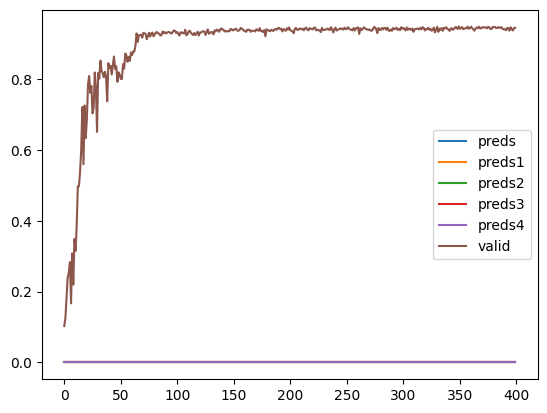

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/400 [00:00<?, ?it/s]

***训练集***
0.10125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/400 [00:14<1:39:31, 14.96s/it]

valid-f1: 0.031809062210109235
valid-precision: 0.02582422968893141
valid-recall: 0.10457498212439835
process: 1  loss: 57.65669322013855  train_correct: 0.005094660041512045 valid_loss 470.04017329216003  val_correct: 0.1071264367816092
The model has been saved!!
The best val_acc is  0.1071264367816092
***训练集***
0.1075


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 2/400 [00:29<1:39:01, 14.93s/it]

valid-f1: 0.023350859938636052
valid-precision: 0.036772535232073744
valid-recall: 0.10122680212196584
process: 2  loss: 57.55271029472351  train_correct: 0.005409145229259702 valid_loss 468.60746669769287  val_correct: 0.1036015325670498
***训练集***
0.115


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 3/400 [00:44<1:39:15, 15.00s/it]

valid-f1: 0.037904716084825055
valid-precision: 0.04017926146978869
valid-recall: 0.10646244662075588
process: 3  loss: 57.38816690444946  train_correct: 0.00578652745455689 valid_loss 466.63639736175537  val_correct: 0.10988505747126437
The model has been saved!!
The best val_acc is  0.10988505747126437
***训练集***
0.1525


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 4/400 [00:59<1:38:47, 14.97s/it]

valid-f1: 0.11021180283635298
valid-precision: 0.17812085686288645
valid-recall: 0.18488980524451515
process: 4  loss: 57.12552213668823  train_correct: 0.007673438581042833 valid_loss 463.802369594574  val_correct: 0.18942528735632183
The model has been saved!!
The best val_acc is  0.18942528735632183
***训练集***
0.16


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▏         | 5/400 [01:14<1:38:39, 14.99s/it]

valid-f1: 0.09890593081212026
valid-precision: 0.1925920218957148
valid-recall: 0.17494084441713753
process: 5  loss: 56.78085780143738  train_correct: 0.008050820806340021 valid_loss 458.09694468975067  val_correct: 0.18053639846743294
***训练集***
0.1675


  2%|▏         | 6/400 [01:29<1:38:05, 14.94s/it]

valid-f1: 0.10457645392823027
valid-precision: 0.23479757704943977
valid-recall: 0.16878429100732983
process: 6  loss: 56.30145525932312  train_correct: 0.00842820303163721 valid_loss 452.5627715587616  val_correct: 0.17793103448275863
***训练集***
0.22125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 7/400 [01:44<1:38:29, 15.04s/it]

valid-f1: 0.1997849949548904
valid-precision: 0.20236524530923003
valid-recall: 0.26408025625733234
process: 7  loss: 55.2796585559845  train_correct: 0.01113277564626706 valid_loss 442.8339751958847  val_correct: 0.2645210727969349
The model has been saved!!
The best val_acc is  0.2645210727969349
***训练集***
0.29625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 8/400 [01:59<1:38:00, 15.00s/it]

valid-f1: 0.24270550945911373
valid-precision: 0.3065194230531652
valid-recall: 0.29684072725753147
process: 8  loss: 53.16841459274292  train_correct: 0.014906597899238946 valid_loss 408.5842596292496  val_correct: 0.3081992337164751
The model has been saved!!
The best val_acc is  0.3081992337164751
***训练集***
0.31


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 9/400 [02:14<1:37:53, 15.02s/it]

valid-f1: 0.28688046219000274
valid-precision: 0.38710339107960867
valid-recall: 0.36842190148841125
process: 9  loss: 49.710853815078735  train_correct: 0.015598465312283791 valid_loss 382.7872701883316  val_correct: 0.37915708812260535
The model has been saved!!
The best val_acc is  0.37915708812260535
***训练集***
0.37125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▎         | 10/400 [02:29<1:37:32, 15.01s/it]

valid-f1: 0.3643507746536279
valid-precision: 0.4658158048300395
valid-recall: 0.40984433591496366
process: 10  loss: 46.43051302433014  train_correct: 0.01868042015221083 valid_loss 350.1593898534775  val_correct: 0.4239080459770115
The model has been saved!!
The best val_acc is  0.4239080459770115
***训练集***
0.43375


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 11/400 [02:45<1:37:34, 15.05s/it]

valid-f1: 0.3768510923627756
valid-precision: 0.4894942003807218
valid-recall: 0.4491679373832359
process: 11  loss: 43.12408900260925  train_correct: 0.0218252720296874 valid_loss 313.5189288556576  val_correct: 0.46099616858237547
The model has been saved!!
The best val_acc is  0.46099616858237547
***训练集***
0.4725


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 12/400 [03:00<1:37:10, 15.03s/it]

valid-f1: 0.446610603616506
valid-precision: 0.4830035112132608
valid-recall: 0.5069573250499044
process: 12  loss: 39.746496081352234  train_correct: 0.023775080193722875 valid_loss 285.4044937491417  val_correct: 0.5252107279693486
The model has been saved!!
The best val_acc is  0.5252107279693486
***训练集***
0.49875


  3%|▎         | 13/400 [03:15<1:36:56, 15.03s/it]

valid-f1: 0.31883447672104875
valid-precision: 0.5719829714957404
valid-recall: 0.39892062487364355
process: 13  loss: 37.99464976787567  train_correct: 0.025095917982263037 valid_loss 357.8892191648483  val_correct: 0.40980842911877396
***训练集***
0.5525


  4%|▎         | 14/400 [03:30<1:36:34, 15.01s/it]

valid-f1: 0.4779405809740866
valid-precision: 0.6058452003683199
valid-recall: 0.5327496621171438
process: 14  loss: 35.131441593170166  train_correct: 0.027800490596892886 valid_loss 246.04191975295544  val_correct: 0.543448275862069
The model has been saved!!
The best val_acc is  0.543448275862069
***训练集***
0.545


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|▍         | 15/400 [03:45<1:36:20, 15.02s/it]

valid-f1: 0.5488117447489873
valid-precision: 0.5874931525014058
valid-recall: 0.5909633628003123
process: 15  loss: 33.85026717185974  train_correct: 0.027423108371595697 valid_loss 225.87485030293465  val_correct: 0.6039846743295019
The model has been saved!!
The best val_acc is  0.6039846743295019
***训练集***
0.5975


  4%|▍         | 16/400 [04:00<1:36:12, 15.03s/it]

valid-f1: 0.5298928926255814
valid-precision: 0.5728253154958666
valid-recall: 0.5842295866473928
process: 16  loss: 30.86644357442856  train_correct: 0.030064783948676017 valid_loss 227.8063652664423  val_correct: 0.6061302681992338
The model has been saved!!
The best val_acc is  0.6061302681992338
***训练集***
0.6525


  4%|▍         | 17/400 [04:15<1:35:44, 15.00s/it]

valid-f1: 0.6054597160049247
valid-precision: 0.7017814086955815
valid-recall: 0.6415272799455847
process: 17  loss: 28.37948304414749  train_correct: 0.0328322536008554 valid_loss 203.49450106918812  val_correct: 0.6577777777777778
The model has been saved!!
The best val_acc is  0.6577777777777778
***训练集***
0.6675


  4%|▍         | 18/400 [04:30<1:35:31, 15.00s/it]

valid-f1: 0.6004471566597003
valid-precision: 0.737488534567464
valid-recall: 0.6106466486969164
process: 18  loss: 27.919893205165863  train_correct: 0.03358701805144978 valid_loss 228.27583223115653  val_correct: 0.6222222222222222
***训练集***
0.705


  5%|▍         | 19/400 [04:45<1:35:17, 15.01s/it]

valid-f1: 0.629062564883917
valid-precision: 0.6984507828574598
valid-recall: 0.6531999560394016
process: 19  loss: 25.89118230342865  train_correct: 0.035473929177935716 valid_loss 209.59256091713905  val_correct: 0.6666666666666666
The model has been saved!!
The best val_acc is  0.6666666666666666
***训练集***
0.68625


  5%|▌         | 20/400 [05:00<1:35:05, 15.01s/it]

valid-f1: 0.6964630717222561
valid-precision: 0.7683694220609291
valid-recall: 0.7104617142649511
process: 20  loss: 25.45699656009674  train_correct: 0.03453047361469275 valid_loss 162.97818303108215  val_correct: 0.7305747126436781
The model has been saved!!
The best val_acc is  0.7305747126436781
***训练集***
0.715


  5%|▌         | 21/400 [05:15<1:34:38, 14.98s/it]

valid-f1: 0.6551442603094115
valid-precision: 0.7490571426899361
valid-recall: 0.6734185328645645
process: 21  loss: 23.746189177036285  train_correct: 0.035977105478331974 valid_loss 187.62538554519415  val_correct: 0.6878160919540229
***训练集***
0.72875


  6%|▌         | 22/400 [05:30<1:34:35, 15.01s/it]

valid-f1: 0.7490716089271373
valid-precision: 0.7998332922884354
valid-recall: 0.7588626978548361
process: 22  loss: 22.81907433271408  train_correct: 0.036668972891376814 valid_loss 146.72989352047443  val_correct: 0.7791570881226053
The model has been saved!!
The best val_acc is  0.7791570881226053
***训练集***
0.70625


  6%|▌         | 23/400 [05:45<1:34:22, 15.02s/it]

valid-f1: 0.7539864950181636
valid-precision: 0.7834881552196234
valid-recall: 0.765594930710481
process: 23  loss: 21.690556049346924  train_correct: 0.03553682621548525 valid_loss 144.12616126984358  val_correct: 0.782375478927203
The model has been saved!!
The best val_acc is  0.782375478927203
***训练集***
0.7325


  6%|▌         | 24/400 [06:00<1:34:13, 15.03s/it]

valid-f1: 0.6649960132929931
valid-precision: 0.7457392528311194
valid-recall: 0.707991961235358
process: 24  loss: 21.548019587993622  train_correct: 0.03685766400402541 valid_loss 191.75237907655537  val_correct: 0.7215325670498084
***训练集***
0.755


  6%|▋         | 25/400 [06:15<1:34:01, 15.04s/it]

valid-f1: 0.7955012100935048
valid-precision: 0.80726735043694
valid-recall: 0.8013849054725496
process: 25  loss: 19.65852463245392  train_correct: 0.037989810679916976 valid_loss 138.79065576195717  val_correct: 0.8102681992337165
The model has been saved!!
The best val_acc is  0.8102681992337165
***训练集***
0.76125


  6%|▋         | 26/400 [06:30<1:34:10, 15.11s/it]

valid-f1: 0.7601303119382012
valid-precision: 0.8101998000694028
valid-recall: 0.7633823623654744
process: 26  loss: 19.866936028003693  train_correct: 0.03830429586766463 valid_loss 145.92840907722712  val_correct: 0.7750191570881226
***训练集***
0.7625


  7%|▋         | 27/400 [06:45<1:34:11, 15.15s/it]

valid-f1: 0.7901534960793686
valid-precision: 0.8199681688605149
valid-recall: 0.797617942836108
process: 27  loss: 19.32258665561676  train_correct: 0.03836719290521416 valid_loss 121.53100435063243  val_correct: 0.8125670498084291
The model has been saved!!
The best val_acc is  0.8125670498084291
***训练集***
0.79375


  7%|▋         | 28/400 [07:00<1:33:46, 15.13s/it]

valid-f1: 0.7973383307032357
valid-precision: 0.808577915246968
valid-recall: 0.8047503539612568
process: 28  loss: 18.060452461242676  train_correct: 0.03993961884395245 valid_loss 133.85474395751953  val_correct: 0.8104214559386973
***训练集***
0.74625


  7%|▋         | 29/400 [07:15<1:33:25, 15.11s/it]

valid-f1: 0.8203008094375124
valid-precision: 0.8343188063975742
valid-recall: 0.820152923357185
process: 29  loss: 19.48657751083374  train_correct: 0.03754953141707026 valid_loss 116.02556702494621  val_correct: 0.8277394636015326
The model has been saved!!
The best val_acc is  0.8277394636015326
***训练集***
0.79


  8%|▊         | 30/400 [07:31<1:33:06, 15.10s/it]

valid-f1: 0.7913862042650927
valid-precision: 0.8296263017489132
valid-recall: 0.7865949697984838
process: 30  loss: 17.445727109909058  train_correct: 0.039750927731303856 valid_loss 137.03103581815958  val_correct: 0.7923371647509578
***训练集***
0.78875


  8%|▊         | 31/400 [07:45<1:32:30, 15.04s/it]

valid-f1: 0.769657048294404
valid-precision: 0.8079201265880462
valid-recall: 0.7705170824556608
process: 31  loss: 17.54408359527588  train_correct: 0.039688030693754324 valid_loss 139.77034817636013  val_correct: 0.7767049808429118
***训练集***
0.81125


  8%|▊         | 32/400 [08:00<1:32:12, 15.03s/it]

valid-f1: 0.7911611452083803
valid-precision: 0.8186469953088447
valid-recall: 0.7893151175142255
process: 32  loss: 16.033691078424454  train_correct: 0.04082017736964589 valid_loss 127.36600424721837  val_correct: 0.7903448275862069
***训练集***
0.79625


  8%|▊         | 33/400 [08:16<1:32:05, 15.06s/it]

valid-f1: 0.8231529489585926
valid-precision: 0.8297894245954366
valid-recall: 0.8285821176814293
process: 33  loss: 15.554864972829819  train_correct: 0.04006541291905151 valid_loss 110.93691263720393  val_correct: 0.8386206896551724
The model has been saved!!
The best val_acc is  0.8386206896551724
***训练集***
0.8025


  8%|▊         | 34/400 [08:31<1:32:21, 15.14s/it]

valid-f1: 0.8411331825319047
valid-precision: 0.8418664594295349
valid-recall: 0.8455783684599736
process: 34  loss: 16.22606611251831  train_correct: 0.04037989810679917 valid_loss 103.95600641518831  val_correct: 0.8502681992337164
The model has been saved!!
The best val_acc is  0.8502681992337164
***训练集***
0.80125


  9%|▉         | 35/400 [08:46<1:31:52, 15.10s/it]

valid-f1: 0.7449613326895748
valid-precision: 0.7863224375330103
valid-recall: 0.7514297580279671
process: 35  loss: 15.949151694774628  train_correct: 0.04031700106924964 valid_loss 143.44685790780932  val_correct: 0.7676628352490421
***训练集***
0.8175


  9%|▉         | 36/400 [09:01<1:31:30, 15.08s/it]

valid-f1: 0.7513358440340099
valid-precision: 0.7915851483569349
valid-recall: 0.7477881585686871
process: 36  loss: 15.112259924411774  train_correct: 0.04113466255739354 valid_loss 155.17847500927746  val_correct: 0.753256704980843
***训练集***
0.79625


  9%|▉         | 37/400 [09:16<1:30:51, 15.02s/it]

valid-f1: 0.7694207072532564
valid-precision: 0.804407765320977
valid-recall: 0.7699258285867182
process: 37  loss: 15.45507824420929  train_correct: 0.04006541291905151 valid_loss 156.73585472255945  val_correct: 0.776551724137931
***训练集***
0.7775


 10%|▉         | 38/400 [09:31<1:30:37, 15.02s/it]

valid-f1: 0.7539323475303343
valid-precision: 0.8093184425646381
valid-recall: 0.7703497144954385
process: 38  loss: 16.766864478588104  train_correct: 0.03912195735580854 valid_loss 140.95578043046407  val_correct: 0.7811494252873563
***训练集***
0.81375


 10%|▉         | 39/400 [09:46<1:30:26, 15.03s/it]

valid-f1: 0.812631163176482
valid-precision: 0.8403279336936349
valid-recall: 0.8170538303344157
process: 39  loss: 14.626725107431412  train_correct: 0.040945971444744954 valid_loss 116.35770495422184  val_correct: 0.8308045977011494
***训练集***
0.8225


 10%|█         | 40/400 [10:01<1:30:14, 15.04s/it]

valid-f1: 0.8068893976592015
valid-precision: 0.8283749306576024
valid-recall: 0.8085344224224281
process: 40  loss: 15.033062398433685  train_correct: 0.04138625070759167 valid_loss 113.3231217507273  val_correct: 0.8188505747126437
***训练集***
0.81875


 10%|█         | 41/400 [10:16<1:30:19, 15.10s/it]

valid-f1: 0.7735905687553811
valid-precision: 0.8056913586038
valid-recall: 0.7874283608955811
process: 41  loss: 14.27056309580803  train_correct: 0.041197559594943076 valid_loss 133.25153356790543  val_correct: 0.790191570881226
***训练集***
0.83125


 10%|█         | 42/400 [10:31<1:29:40, 15.03s/it]

valid-f1: 0.8254824489927678
valid-precision: 0.8375019599850348
valid-recall: 0.8311191396394637
process: 42  loss: 13.63368433713913  train_correct: 0.04182652997043839 valid_loss 107.3097148090601  val_correct: 0.8398467432950192
***训练集***
0.8325


 11%|█         | 43/400 [10:46<1:29:27, 15.04s/it]

valid-f1: 0.7404765267753642
valid-precision: 0.77675876758196
valid-recall: 0.757671107107929
process: 43  loss: 13.905962586402893  train_correct: 0.04188942700798792 valid_loss 156.3621301613748  val_correct: 0.7604597701149425
***训练集***
0.85


 11%|█         | 44/400 [11:01<1:28:51, 14.98s/it]

valid-f1: 0.7958704972361194
valid-precision: 0.8249949539699577
valid-recall: 0.7934945609890239
process: 44  loss: 12.598381876945496  train_correct: 0.042769985533681366 valid_loss 115.6877495162189  val_correct: 0.7969348659003831
***训练集***
0.84125


 11%|█▏        | 45/400 [11:16<1:28:42, 14.99s/it]

valid-f1: 0.825256518418531
valid-precision: 0.8323657372721686
valid-recall: 0.82887659003053
process: 45  loss: 13.014474153518677  train_correct: 0.04232970627083464 valid_loss 110.22964492440224  val_correct: 0.8326436781609196
***训练集***
0.8575


 12%|█▏        | 46/400 [11:31<1:28:27, 14.99s/it]

valid-f1: 0.8210475573703275
valid-precision: 0.8404816679850782
valid-recall: 0.8235222833862892
process: 46  loss: 11.62920393049717  train_correct: 0.04314736775897855 valid_loss 109.62211522972211  val_correct: 0.8309578544061302
***训练集***
0.84125


 12%|█▏        | 47/400 [11:46<1:28:29, 15.04s/it]

valid-f1: 0.8239102363161527
valid-precision: 0.8408049022068408
valid-recall: 0.8248412784583923
process: 47  loss: 12.509906500577927  train_correct: 0.04232970627083464 valid_loss 106.56686667888425  val_correct: 0.833103448275862
***训练集***
0.81625


 12%|█▏        | 48/400 [12:01<1:28:15, 15.04s/it]

valid-f1: 0.8200566075932043
valid-precision: 0.8329966839200938
valid-recall: 0.8251673586480631
process: 48  loss: 13.247567281126976  train_correct: 0.04107176551984402 valid_loss 109.30075306072831  val_correct: 0.8349425287356322
***训练集***
0.85


 12%|█▏        | 49/400 [12:16<1:28:06, 15.06s/it]

valid-f1: 0.8327908910614863
valid-precision: 0.8410947426025203
valid-recall: 0.8335929127665203
process: 49  loss: 12.245694726705551  train_correct: 0.042769985533681366 valid_loss 96.82443189248443  val_correct: 0.8401532567049809
***训练集***
0.845


 12%|█▎        | 50/400 [12:31<1:27:52, 15.06s/it]

valid-f1: 0.8345971303599236
valid-precision: 0.844628823461399
valid-recall: 0.8342403954154097
process: 50  loss: 11.955647960305214  train_correct: 0.04251839738348324 valid_loss 94.76955559104681  val_correct: 0.8422988505747127
***训练集***
0.8475


 13%|█▎        | 51/400 [12:46<1:27:42, 15.08s/it]

valid-f1: 0.8080530036825199
valid-precision: 0.8192481658879277
valid-recall: 0.8109092347301123
process: 51  loss: 12.35749301314354  train_correct: 0.0426441914585823 valid_loss 102.44899944961071  val_correct: 0.818544061302682
***训练集***
0.83625


 13%|█▎        | 52/400 [13:02<1:27:26, 15.08s/it]

valid-f1: 0.8300613061433278
valid-precision: 0.8376646801547037
valid-recall: 0.8347915600366944
process: 52  loss: 12.744419381022453  train_correct: 0.04207811812063652 valid_loss 106.78059060685337  val_correct: 0.8475095785440613
***训练集***
0.83125


 13%|█▎        | 53/400 [13:17<1:27:30, 15.13s/it]

valid-f1: 0.8300199367152695
valid-precision: 0.8368621902124926
valid-recall: 0.8343164485693132
process: 53  loss: 12.261144682765007  train_correct: 0.04182652997043839 valid_loss 103.12974635325372  val_correct: 0.8404597701149426
***训练集***
0.8425


 14%|█▎        | 54/400 [13:32<1:27:11, 15.12s/it]

valid-f1: 0.7170645547282894
valid-precision: 0.7840551206984896
valid-recall: 0.7314452458891039
process: 54  loss: 12.325365453958511  train_correct: 0.04239260330838417 valid_loss 161.6168445906369  val_correct: 0.7330268199233716
***训练集***
0.845


 14%|█▍        | 55/400 [13:47<1:26:50, 15.10s/it]

valid-f1: 0.8378526175201919
valid-precision: 0.8414653725405626
valid-recall: 0.8418791241651148
process: 55  loss: 12.191817671060562  train_correct: 0.04251839738348324 valid_loss 94.40096482634544  val_correct: 0.8508812260536398
The model has been saved!!
The best val_acc is  0.8508812260536398
***训练集***
0.85375
开始蒸馏


 14%|█▍        | 56/400 [14:02<1:26:21, 15.06s/it]

valid-f1: 0.7989492631617413
valid-precision: 0.8294611621063082
valid-recall: 0.7971915434961774
process: 56  loss: 11.676431730389595  train_correct: 0.042958676646329956 valid_loss 123.71731116250157  val_correct: 0.8012260536398468
***训练集***
0.77375


 14%|█▍        | 57/400 [14:17<1:25:58, 15.04s/it]

valid-f1: 0.6903486796706232
valid-precision: 0.7893515155967189
valid-recall: 0.7047632229789926
process: 57  loss: 2398.327880859375  train_correct: 0.038933266243159945 valid_loss 195.90351618739078  val_correct: 0.7193869731800766
***训练集***
0.73375


 14%|█▍        | 58/400 [14:32<1:25:28, 15.00s/it]

valid-f1: 0.7784993359630266
valid-precision: 0.8503480164195247
valid-recall: 0.783967918332301
process: 58  loss: 1568.9877586364746  train_correct: 0.03692056104157494 valid_loss 125.63067782390863  val_correct: 0.8015325670498085
***训练集***
0.75375


 15%|█▍        | 59/400 [14:47<1:25:14, 15.00s/it]

valid-f1: 0.83264583108803
valid-precision: 0.8561345865000375
valid-recall: 0.8362138673824353
process: 59  loss: 1243.4113578796387  train_correct: 0.037926913642367444 valid_loss 99.00885002379073  val_correct: 0.8472030651340996
***训练集***
0.7975


 15%|█▌        | 60/400 [15:02<1:25:04, 15.01s/it]

valid-f1: 0.8561276758069709
valid-precision: 0.8782554757861766
valid-recall: 0.8560898426665322
process: 60  loss: 1087.3175430297852  train_correct: 0.04012830995660104 valid_loss 93.41637237813848  val_correct: 0.8688122605363985
The model has been saved!!
The best val_acc is  0.8688122605363985
***训练集***
0.79625


 15%|█▌        | 61/400 [15:17<1:24:46, 15.00s/it]

valid-f1: 0.8566514481472222
valid-precision: 0.866728946374589
valid-recall: 0.8614084738542017
process: 61  loss: 957.9353771209717  train_correct: 0.04006541291905151 valid_loss 91.95905538096486  val_correct: 0.8694252873563219
The model has been saved!!
The best val_acc is  0.8694252873563219
***训练集***
0.78625


 16%|█▌        | 62/400 [15:32<1:24:26, 14.99s/it]

valid-f1: 0.8478464911302506
valid-precision: 0.8813648115417783
valid-recall: 0.8401201027804961
process: 62  loss: 912.450756072998  train_correct: 0.03956223661865526 valid_loss 105.64705186500214  val_correct: 0.8533333333333334
***训练集***
0.825


 16%|█▌        | 63/400 [15:47<1:24:08, 14.98s/it]

valid-f1: 0.8826416544794577
valid-precision: 0.8943836071256367
valid-recall: 0.8787693515950485
process: 63  loss: 883.7532482147217  train_correct: 0.04151204478269074 valid_loss 86.86867143079871  val_correct: 0.8875095785440613
The model has been saved!!
The best val_acc is  0.8875095785440613
***训练集***
0.81625


 16%|█▌        | 64/400 [16:02<1:24:03, 15.01s/it]

valid-f1: 0.9055320763507158
valid-precision: 0.9152050333666644
valid-recall: 0.9025596890883596
process: 64  loss: 822.9477043151855  train_correct: 0.04107176551984402 valid_loss 74.10707570505474  val_correct: 0.9103448275862069
The model has been saved!!
The best val_acc is  0.9103448275862069
***训练集***
0.815


 16%|█▋        | 65/400 [16:17<1:23:45, 15.00s/it]

valid-f1: 0.8698017374981776
valid-precision: 0.8895218608416211
valid-recall: 0.8707608505299783
process: 65  loss: 774.6190986633301  train_correct: 0.041008868482294486 valid_loss 96.7315355116807  val_correct: 0.8830651340996168
***训练集***
0.84625


 16%|█▋        | 66/400 [16:32<1:23:56, 15.08s/it]

valid-f1: 0.8936403556743482
valid-precision: 0.9012641124722324
valid-recall: 0.8925548763872605
process: 66  loss: 756.9230575561523  train_correct: 0.04258129442103277 valid_loss 81.63422509930751  val_correct: 0.9016091954022989
***训练集***
0.84


 17%|█▋        | 67/400 [16:47<1:23:27, 15.04s/it]

valid-f1: 0.8946756551473308
valid-precision: 0.9076900481598902
valid-recall: 0.8946106043301011
process: 67  loss: 728.2875823974609  train_correct: 0.04226680923328511 valid_loss 75.89780526136747  val_correct: 0.9042145593869731
***训练集***
0.8525


 17%|█▋        | 68/400 [17:02<1:23:08, 15.03s/it]

valid-f1: 0.8980648715420051
valid-precision: 0.9033630465706214
valid-recall: 0.8977920207379835
process: 68  loss: 720.3826274871826  train_correct: 0.042895779608780424 valid_loss 68.10671822700533  val_correct: 0.9045210727969348
***训练集***
0.8475


 17%|█▋        | 69/400 [17:17<1:22:45, 15.00s/it]

valid-f1: 0.9043961428738388
valid-precision: 0.9147611950802734
valid-recall: 0.9018056783269884
process: 69  loss: 722.3622703552246  train_correct: 0.0426441914585823 valid_loss 76.04114580843816  val_correct: 0.910191570881226
***训练集***
0.835


 18%|█▊        | 70/400 [17:32<1:22:36, 15.02s/it]

valid-f1: 0.906782903864125
valid-precision: 0.9128122360593292
valid-recall: 0.9047950684022987
process: 70  loss: 691.2274551391602  train_correct: 0.04201522108308699 valid_loss 74.10825071810541  val_correct: 0.9123371647509578
The model has been saved!!
The best val_acc is  0.9123371647509578
***训练集***
0.855


 18%|█▊        | 71/400 [17:47<1:22:18, 15.01s/it]

valid-f1: 0.9138567384438753
valid-precision: 0.9166215597541478
valid-recall: 0.913097392108176
process: 71  loss: 647.9518146514893  train_correct: 0.04302157368387949 valid_loss 61.19017994365254  val_correct: 0.9187739463601533
The model has been saved!!
The best val_acc is  0.9187739463601533
***训练集***
0.86


 18%|█▊        | 72/400 [18:02<1:22:11, 15.04s/it]

valid-f1: 0.9146940155436534
valid-precision: 0.9198332217877816
valid-recall: 0.9145964249373912
process: 72  loss: 671.5233612060547  train_correct: 0.04327316183407762 valid_loss 61.43520018312847  val_correct: 0.9224521072796935
The model has been saved!!
The best val_acc is  0.9224521072796935
***训练集***
0.8475


 18%|█▊        | 73/400 [18:17<1:21:43, 14.99s/it]

valid-f1: 0.9026126143983516
valid-precision: 0.9141184256919865
valid-recall: 0.9015597308511776
process: 73  loss: 640.0401458740234  train_correct: 0.0426441914585823 valid_loss 71.66450714207531  val_correct: 0.9111111111111111
***训练集***
0.83875


 18%|█▊        | 74/400 [18:32<1:21:28, 15.00s/it]

valid-f1: 0.9049114436174406
valid-precision: 0.9106695380920291
valid-recall: 0.9065990875992403
process: 74  loss: 659.966968536377  train_correct: 0.042203912195735584 valid_loss 70.15309874732338  val_correct: 0.9146360153256705
***训练集***
0.86


 19%|█▉        | 75/400 [18:47<1:21:21, 15.02s/it]

valid-f1: 0.887066227817561
valid-precision: 0.9030393052397352
valid-recall: 0.8876782067131346
process: 75  loss: 627.699010848999  train_correct: 0.04327316183407762 valid_loss 84.27306439036329  val_correct: 0.8991570881226054
***训练集***
0.87


 19%|█▉        | 76/400 [19:02<1:21:13, 15.04s/it]

valid-f1: 0.8900775131916298
valid-precision: 0.9094295842598596
valid-recall: 0.8910078963615202
process: 76  loss: 640.0776500701904  train_correct: 0.04377633813447387 valid_loss 89.99562518344209  val_correct: 0.901455938697318
***训练集***
0.8175


 19%|█▉        | 77/400 [19:17<1:21:04, 15.06s/it]

valid-f1: 0.9078575672977871
valid-precision: 0.9193374124442608
valid-recall: 0.9077304518499861
process: 77  loss: 629.8534622192383  train_correct: 0.04113466255739354 valid_loss 70.68976759334691  val_correct: 0.9164750957854406
***训练集***
0.8775


 20%|█▉        | 78/400 [19:32<1:20:56, 15.08s/it]

valid-f1: 0.8920248363114064
valid-precision: 0.9015647568310229
valid-recall: 0.8931778206184381
process: 78  loss: 600.389461517334  train_correct: 0.044153720359771054 valid_loss 70.54290930364732  val_correct: 0.9005363984674329
***训练集***
0.84875


 20%|█▉        | 79/400 [19:47<1:20:34, 15.06s/it]

valid-f1: 0.902356629404526
valid-precision: 0.9233757266724641
valid-recall: 0.9021460204365651
process: 79  loss: 615.7725028991699  train_correct: 0.042707088496131834 valid_loss 77.91739672719996  val_correct: 0.9126436781609195
***训练集***
0.855


 20%|██        | 80/400 [20:03<1:20:34, 15.11s/it]

valid-f1: 0.9213007976739528
valid-precision: 0.932518869539144
valid-recall: 0.9180646167578985
process: 80  loss: 606.0581665039062  train_correct: 0.04302157368387949 valid_loss 67.04966847291143  val_correct: 0.9262835249042145
The model has been saved!!
The best val_acc is  0.9262835249042145
***训练集***
0.855


 20%|██        | 81/400 [20:18<1:20:46, 15.19s/it]

valid-f1: 0.9200924241555711
valid-precision: 0.927692870327167
valid-recall: 0.9192243747390716
process: 81  loss: 598.3976192474365  train_correct: 0.04302157368387949 valid_loss 63.05089621256775  val_correct: 0.9272030651340997
The model has been saved!!
The best val_acc is  0.9272030651340997
***训练集***
0.86375


 20%|██        | 82/400 [20:34<1:21:26, 15.37s/it]

valid-f1: 0.9253256423232763
valid-precision: 0.9276831266988743
valid-recall: 0.924766047046248
process: 82  loss: 570.3026485443115  train_correct: 0.04346185294672621 valid_loss 57.47413635475823  val_correct: 0.9305747126436782
The model has been saved!!
The best val_acc is  0.9305747126436782
***训练集***
0.87375


 21%|██        | 83/400 [20:49<1:21:13, 15.37s/it]

valid-f1: 0.9190526940579264
valid-precision: 0.9259446241930241
valid-recall: 0.9173900564596199
process: 83  loss: 563.0471954345703  train_correct: 0.04396502924712246 valid_loss 67.62954119048891  val_correct: 0.9253639846743295
***训练集***
0.8775


 21%|██        | 84/400 [21:05<1:21:20, 15.44s/it]

valid-f1: 0.9197870054868075
valid-precision: 0.9260314925848873
valid-recall: 0.9193222177955572
process: 84  loss: 585.8900089263916  train_correct: 0.044153720359771054 valid_loss 59.156752013361256  val_correct: 0.9264367816091954
***训练集***
0.86


 21%|██▏       | 85/400 [21:20<1:20:37, 15.36s/it]

valid-f1: 0.9189814531370109
valid-precision: 0.926911890341584
valid-recall: 0.9180910973439275
process: 85  loss: 577.0887699127197  train_correct: 0.04327316183407762 valid_loss 68.62912376536224  val_correct: 0.9261302681992337
***训练集***
0.875


 22%|██▏       | 86/400 [21:35<1:20:02, 15.29s/it]

valid-f1: 0.9199148107021162
valid-precision: 0.9279986525093866
valid-recall: 0.917309919627345
process: 86  loss: 563.0176391601562  train_correct: 0.04402792628467199 valid_loss 68.52497058736662  val_correct: 0.9247509578544061
***训练集***
0.89625


 22%|██▏       | 87/400 [21:50<1:19:28, 15.23s/it]

valid-f1: 0.9211654301769338
valid-precision: 0.9287185230629624
valid-recall: 0.9205383395629674
process: 87  loss: 559.2227573394775  train_correct: 0.04509717592301402 valid_loss 65.56075477622335  val_correct: 0.9270498084291188
***训练集***
0.885


 22%|██▏       | 88/400 [22:05<1:19:05, 15.21s/it]

valid-f1: 0.9321881192019106
valid-precision: 0.9357008004045542
valid-recall: 0.9311941356628421
process: 88  loss: 533.9061813354492  train_correct: 0.04453110258506824 valid_loss 54.548186863316005  val_correct: 0.9370114942528736
The model has been saved!!
The best val_acc is  0.9370114942528736
***训练集***
0.8775


 22%|██▏       | 89/400 [22:20<1:18:33, 15.16s/it]

valid-f1: 0.9310964426516357
valid-precision: 0.93267689222633
valid-recall: 0.9305769620913142
process: 89  loss: 544.315258026123  train_correct: 0.044153720359771054 valid_loss 57.18506516345951  val_correct: 0.9351724137931035
***训练集***
0.85875


 22%|██▎       | 90/400 [22:35<1:17:53, 15.07s/it]

valid-f1: 0.9220954901803771
valid-precision: 0.9258602918555485
valid-recall: 0.9214221519475008
process: 90  loss: 542.3824062347412  train_correct: 0.043210264796528085 valid_loss 61.23313519733256  val_correct: 0.927816091954023
***训练集***
0.8875


 23%|██▎       | 91/400 [22:50<1:17:27, 15.04s/it]

valid-f1: 0.9253294138893369
valid-precision: 0.9282858814740766
valid-recall: 0.924546326861136
process: 91  loss: 535.4108085632324  train_correct: 0.044656896660167304 valid_loss 58.143160122997415  val_correct: 0.9295019157088122
***训练集***
0.87375


 23%|██▎       | 92/400 [23:05<1:16:54, 14.98s/it]

valid-f1: 0.9266906235981868
valid-precision: 0.9348719931458426
valid-recall: 0.9255744512536666
process: 92  loss: 535.1153354644775  train_correct: 0.04396502924712246 valid_loss 62.27412188096059  val_correct: 0.9321072796934866
***训练集***
0.86875


 23%|██▎       | 93/400 [23:20<1:16:37, 14.98s/it]

valid-f1: 0.9221652376343548
valid-precision: 0.9294318444066118
valid-recall: 0.9205419081813686
process: 93  loss: 530.1708393096924  train_correct: 0.043713441096924335 valid_loss 66.07529411508699  val_correct: 0.9281226053639847
***训练集***
0.8875


 24%|██▎       | 94/400 [23:35<1:16:26, 14.99s/it]

valid-f1: 0.9275885631870094
valid-precision: 0.9314069100834814
valid-recall: 0.9260263062273143
process: 94  loss: 519.6079750061035  train_correct: 0.044656896660167304 valid_loss 59.712480594425415  val_correct: 0.9311877394636016
***训练集***
0.8725


 24%|██▍       | 95/400 [23:50<1:16:14, 15.00s/it]

valid-f1: 0.9255151896879715
valid-precision: 0.929571083002514
valid-recall: 0.9250677871727193
process: 95  loss: 520.423641204834  train_correct: 0.04390213220957293 valid_loss 60.59523347510333  val_correct: 0.9313409961685823
***训练集***
0.8875


 24%|██▍       | 96/400 [24:05<1:15:47, 14.96s/it]

valid-f1: 0.8986252135537584
valid-precision: 0.9176047773085241
valid-recall: 0.899242494862194
process: 96  loss: 508.72586250305176  train_correct: 0.044656896660167304 valid_loss 81.86554234155301  val_correct: 0.9094252873563219
***训练集***
0.885
开始蒸馏


 24%|██▍       | 97/400 [24:20<1:15:46, 15.01s/it]

valid-f1: 0.9307761509195597
valid-precision: 0.9345837062260187
valid-recall: 0.9306567018687298
process: 97  loss: 526.8074588775635  train_correct: 0.04453110258506824 valid_loss 53.07689479914916  val_correct: 0.9367049808429119
***训练集***
0.87625


 24%|██▍       | 98/400 [24:35<1:15:46, 15.05s/it]

valid-f1: 0.9194311827466454
valid-precision: 0.9254818756615928
valid-recall: 0.9178721776574499
process: 98  loss: 520.0648746490479  train_correct: 0.04409082332222152 valid_loss 66.48567124581496  val_correct: 0.9245977011494253
***训练集***
0.88875


 25%|██▍       | 99/400 [24:50<1:15:36, 15.07s/it]

valid-f1: 0.9137112247221028
valid-precision: 0.920069903712187
valid-recall: 0.9128481155998036
process: 99  loss: 499.0344181060791  train_correct: 0.044719793697716836 valid_loss 64.75580852658368  val_correct: 0.9206130268199234
***训练集***
0.87625


 25%|██▌       | 100/400 [25:05<1:15:21, 15.07s/it]

valid-f1: 0.9241238610876541
valid-precision: 0.9243408981626626
valid-recall: 0.9243867669011558
process: 100  loss: 518.583438873291  train_correct: 0.04409082332222152 valid_loss 56.30990511796517  val_correct: 0.9290421455938698
***训练集***
0.8725


 25%|██▌       | 101/400 [25:21<1:15:13, 15.10s/it]

valid-f1: 0.9194288083627036
valid-precision: 0.9252745324432041
valid-recall: 0.9180503402096785
process: 101  loss: 509.8448028564453  train_correct: 0.04390213220957293 valid_loss 64.34389648259639  val_correct: 0.924904214559387
***训练集***
0.8625


 26%|██▌       | 102/400 [25:36<1:14:59, 15.10s/it]

valid-f1: 0.9171363802045989
valid-precision: 0.9272380196082283
valid-recall: 0.9158134741427235
process: 102  loss: 517.3756294250488  train_correct: 0.043398955909176674 valid_loss 65.11207383169858  val_correct: 0.923831417624521
***训练集***
0.89125


 26%|██▌       | 103/400 [25:51<1:14:45, 15.10s/it]

valid-f1: 0.926436271672938
valid-precision: 0.9292514698051001
valid-recall: 0.9259399737626733
process: 103  loss: 527.4130325317383  train_correct: 0.0448455877728159 valid_loss 53.639915738182026  val_correct: 0.9313409961685823
***训练集***
0.8825


 26%|██▌       | 104/400 [26:06<1:14:32, 15.11s/it]

valid-f1: 0.9320930742190748
valid-precision: 0.9354665320864981
valid-recall: 0.9312904355523275
process: 104  loss: 510.1431369781494  train_correct: 0.04440530850996918 valid_loss 56.18580453483537  val_correct: 0.9373180076628352
The model has been saved!!
The best val_acc is  0.9373180076628352
***训练集***
0.8825


 26%|██▋       | 105/400 [26:21<1:14:27, 15.14s/it]

valid-f1: 0.9177511081982559
valid-precision: 0.9295520980971395
valid-recall: 0.9161265354001216
process: 105  loss: 503.7290687561035  train_correct: 0.04440530850996918 valid_loss 64.53093173085654  val_correct: 0.924904214559387
***训练集***
0.89875


 26%|██▋       | 106/400 [26:36<1:14:15, 15.15s/it]

valid-f1: 0.9171707840361474
valid-precision: 0.926006061731562
valid-recall: 0.9180528579828163
process: 106  loss: 482.46481132507324  train_correct: 0.04522296999811309 valid_loss 60.7991017725908  val_correct: 0.9265900383141762
***训练集***
0.875


 27%|██▋       | 107/400 [26:51<1:13:58, 15.15s/it]

valid-f1: 0.9141314899425563
valid-precision: 0.9233844917349346
valid-recall: 0.913831852035997
process: 107  loss: 505.0108222961426  train_correct: 0.04402792628467199 valid_loss 64.19906185035256  val_correct: 0.9218390804597701
***训练集***
0.89625


 27%|██▋       | 108/400 [27:06<1:13:35, 15.12s/it]

valid-f1: 0.9312036448657344
valid-precision: 0.9366925200086473
valid-recall: 0.9291222333359974
process: 108  loss: 472.0135192871094  train_correct: 0.04509717592301402 valid_loss 57.83054830018045  val_correct: 0.9351724137931035
***训练集***
0.89875


 27%|██▋       | 109/400 [27:21<1:13:09, 15.08s/it]

valid-f1: 0.9189608098789179
valid-precision: 0.927993007271672
valid-recall: 0.9159233250502036
process: 109  loss: 487.5454511642456  train_correct: 0.04522296999811309 valid_loss 68.85411271482644  val_correct: 0.922911877394636
***训练集***
0.8975


 28%|██▊       | 110/400 [27:36<1:12:47, 15.06s/it]

valid-f1: 0.9120871835650364
valid-precision: 0.9282022066908935
valid-recall: 0.9105433512924629
process: 110  loss: 473.1614580154419  train_correct: 0.045160072960563555 valid_loss 71.87944183536638  val_correct: 0.9203065134099617
***训练集***
0.87625


 28%|██▊       | 111/400 [27:51<1:12:18, 15.01s/it]

valid-f1: 0.9140760687220343
valid-precision: 0.9249462353515504
valid-recall: 0.9121905309375252
process: 111  loss: 490.21956157684326  train_correct: 0.04409082332222152 valid_loss 67.31043514645717  val_correct: 0.9201532567049808
***训练集***
0.8925


 28%|██▊       | 112/400 [28:06<1:11:47, 14.96s/it]

valid-f1: 0.9355400595671866
valid-precision: 0.9370028176249294
valid-recall: 0.9349462540167671
process: 112  loss: 485.40232276916504  train_correct: 0.04490848481036543 valid_loss 52.82974583227224  val_correct: 0.9386973180076629
The model has been saved!!
The best val_acc is  0.9386973180076629
***训练集***
0.905


 28%|██▊       | 113/400 [28:21<1:11:27, 14.94s/it]

valid-f1: 0.9172874541284239
valid-precision: 0.927326547025487
valid-recall: 0.9145217463422922
process: 113  loss: 490.1513786315918  train_correct: 0.04553745518586075 valid_loss 66.63948117522978  val_correct: 0.9209195402298851
***训练集***
0.875


 28%|██▊       | 114/400 [28:36<1:11:13, 14.94s/it]

valid-f1: 0.9284507881176024
valid-precision: 0.9324582446032899
valid-recall: 0.927035247015571
process: 114  loss: 501.88783073425293  train_correct: 0.04402792628467199 valid_loss 62.53662294546302  val_correct: 0.9333333333333333
***训练集***
0.9075


 29%|██▉       | 115/400 [28:51<1:11:06, 14.97s/it]

valid-f1: 0.9165136127071131
valid-precision: 0.9267750072008315
valid-recall: 0.9156441360885358
process: 115  loss: 477.55958557128906  train_correct: 0.045663249260959805 valid_loss 67.7532772846971  val_correct: 0.9235249042145594
***训练集***
0.895


 29%|██▉       | 116/400 [29:06<1:10:45, 14.95s/it]

valid-f1: 0.9245992836134184
valid-precision: 0.9324222318282385
valid-recall: 0.9228898144086498
process: 116  loss: 483.71728515625  train_correct: 0.0450342788854645 valid_loss 63.23276436959986  val_correct: 0.9299616858237548
***训练集***
0.885


 29%|██▉       | 117/400 [29:21<1:10:19, 14.91s/it]

valid-f1: 0.9254958745188585
valid-precision: 0.9300212457690415
valid-recall: 0.9241514942176327
process: 117  loss: 490.22741317749023  train_correct: 0.04453110258506824 valid_loss 62.94184204472094  val_correct: 0.9298084291187739
***训练集***
0.89875


 30%|██▉       | 118/400 [29:36<1:10:15, 14.95s/it]

valid-f1: 0.929569698955895
valid-precision: 0.9338611511634062
valid-recall: 0.9280005789545136
process: 118  loss: 478.3786869049072  train_correct: 0.04522296999811309 valid_loss 57.58229711068998  val_correct: 0.9334865900383141
***训练集***
0.9075


 30%|██▉       | 119/400 [29:51<1:10:06, 14.97s/it]

valid-f1: 0.9272208245109013
valid-precision: 0.9316241581477718
valid-recall: 0.9260310772480418
process: 119  loss: 446.7693395614624  train_correct: 0.045663249260959805 valid_loss 56.22768265103332  val_correct: 0.9319540229885057
***训练集***
0.89875


 30%|███       | 120/400 [30:06<1:10:13, 15.05s/it]

valid-f1: 0.9223908827430372
valid-precision: 0.9290874405113367
valid-recall: 0.9212089710537906
process: 120  loss: 453.94708919525146  train_correct: 0.04522296999811309 valid_loss 64.67994909376102  val_correct: 0.9285823754789272
***训练集***
0.91


 30%|███       | 121/400 [30:21<1:09:54, 15.03s/it]

valid-f1: 0.9313498465197453
valid-precision: 0.9355769968383804
valid-recall: 0.9298803758806475
process: 121  loss: 450.5949983596802  train_correct: 0.04578904333605887 valid_loss 59.59968933638447  val_correct: 0.9359386973180077
***训练集***
0.9125


 30%|███       | 122/400 [30:36<1:09:48, 15.07s/it]

valid-f1: 0.9043390049460921
valid-precision: 0.9219495143339111
valid-recall: 0.9065019594841152
process: 122  loss: 461.0443706512451  train_correct: 0.045914837411157934 valid_loss 68.02872618565198  val_correct: 0.9161685823754789
***训练集***
0.88625


 31%|███       | 123/400 [30:51<1:09:27, 15.05s/it]

valid-f1: 0.9260980992045296
valid-precision: 0.9317986979731092
valid-recall: 0.9242419882354411
process: 123  loss: 464.16741275787354  train_correct: 0.04459399962261777 valid_loss 60.58409501137976  val_correct: 0.9302681992337165
***训练集***
0.88875


 31%|███       | 124/400 [31:07<1:09:30, 15.11s/it]

valid-f1: 0.9296303202118299
valid-precision: 0.9352634139420333
valid-recall: 0.9286008124744253
process: 124  loss: 467.08422660827637  train_correct: 0.044719793697716836 valid_loss 56.95634369592517  val_correct: 0.9350191570881226
***训练集***
0.8975


 31%|███▏      | 125/400 [31:21<1:08:54, 15.03s/it]

valid-f1: 0.9176553493338842
valid-precision: 0.930222574467448
valid-recall: 0.9164943780394605
process: 125  loss: 466.01053619384766  train_correct: 0.045160072960563555 valid_loss 64.80790703444382  val_correct: 0.9247509578544061
***训练集***
0.89375


 32%|███▏      | 126/400 [31:37<1:08:55, 15.09s/it]

valid-f1: 0.9104362509828281
valid-precision: 0.9184776825094891
valid-recall: 0.9086884487352496
process: 126  loss: 461.295205116272  train_correct: 0.044971381847914965 valid_loss 72.79089020325989  val_correct: 0.9158620689655173
***训练集***
0.885


 32%|███▏      | 127/400 [31:52<1:08:50, 15.13s/it]

valid-f1: 0.9118860055838773
valid-precision: 0.9230359662246425
valid-recall: 0.9117182811714063
process: 127  loss: 466.4929256439209  train_correct: 0.04453110258506824 valid_loss 67.81573989692879  val_correct: 0.9198467432950191
***训练集***
0.87875


 32%|███▏      | 128/400 [32:07<1:08:47, 15.17s/it]

valid-f1: 0.9354014865751834
valid-precision: 0.9410977631000202
valid-recall: 0.9334468973142359
process: 128  loss: 470.0457754135132  train_correct: 0.044216617397320586 valid_loss 56.65191481920374  val_correct: 0.9397701149425287
The model has been saved!!
The best val_acc is  0.9397701149425287
***训练集***
0.89625


 32%|███▏      | 129/400 [32:22<1:08:19, 15.13s/it]

valid-f1: 0.9309098225773008
valid-precision: 0.9370190831614181
valid-recall: 0.9296242978783937
process: 129  loss: 447.10212802886963  train_correct: 0.04509717592301402 valid_loss 57.68768986208215  val_correct: 0.9363984674329502
***训练集***
0.88875


 32%|███▎      | 130/400 [32:37<1:08:18, 15.18s/it]

valid-f1: 0.9367976981986683
valid-precision: 0.9422394189511593
valid-recall: 0.9352187575836318
process: 130  loss: 444.2921495437622  train_correct: 0.044719793697716836 valid_loss 57.24309310722174  val_correct: 0.9409961685823754
The model has been saved!!
The best val_acc is  0.9409961685823754
***训练集***
0.9


 33%|███▎      | 131/400 [32:52<1:07:53, 15.14s/it]

valid-f1: 0.927152708897468
valid-precision: 0.9344560986344641
valid-recall: 0.926500262988483
process: 131  loss: 444.75364208221436  train_correct: 0.04528586703566262 valid_loss 58.74437116196532  val_correct: 0.9328735632183908
***训练集***
0.9
开始蒸馏


 33%|███▎      | 132/400 [33:08<1:07:51, 15.19s/it]

valid-f1: 0.9336228800959218
valid-precision: 0.9393764036421995
valid-recall: 0.9319209468528366
process: 132  loss: 453.3868522644043  train_correct: 0.04528586703566262 valid_loss 56.879022786386486  val_correct: 0.938544061302682
***训练集***
0.905


 33%|███▎      | 133/400 [33:23<1:07:30, 15.17s/it]

valid-f1: 0.9279111443142412
valid-precision: 0.9362181473420609
valid-recall: 0.9266936713314486
process: 133  loss: 439.547643661499  train_correct: 0.04553745518586075 valid_loss 58.60530345184088  val_correct: 0.9342528735632184
***训练集***
0.88


 34%|███▎      | 134/400 [33:38<1:07:13, 15.16s/it]

valid-f1: 0.9209622615357835
valid-precision: 0.9292805662122271
valid-recall: 0.9194178088651455
process: 134  loss: 450.66755962371826  train_correct: 0.04427951443487012 valid_loss 62.69131534274129  val_correct: 0.9270498084291188
***训练集***
0.88625


 34%|███▍      | 135/400 [33:53<1:06:40, 15.09s/it]

valid-f1: 0.9223943410114895
valid-precision: 0.9335237239813834
valid-recall: 0.9211922932969587
process: 135  loss: 447.9179525375366  train_correct: 0.04459399962261777 valid_loss 66.35212941378813  val_correct: 0.9290421455938698
***训练集***
0.905


 34%|███▍      | 136/400 [34:08<1:06:17, 15.07s/it]

valid-f1: 0.9265249236905057
valid-precision: 0.9343414778859034
valid-recall: 0.9248352280337935
process: 136  loss: 444.3807497024536  train_correct: 0.04553745518586075 valid_loss 56.51896455007682  val_correct: 0.9319540229885057
***训练集***
0.87625


 34%|███▍      | 137/400 [34:23<1:05:55, 15.04s/it]

valid-f1: 0.9314974661341768
valid-precision: 0.9400511251165684
valid-recall: 0.9296466240486299
process: 137  loss: 442.4271078109741  train_correct: 0.04409082332222152 valid_loss 56.62184169383545  val_correct: 0.9365517241379311
***训练集***
0.905


 34%|███▍      | 138/400 [34:38<1:05:41, 15.04s/it]

valid-f1: 0.9314393189318301
valid-precision: 0.9360499255024509
valid-recall: 0.9298241370484981
process: 138  loss: 468.6442184448242  train_correct: 0.04553745518586075 valid_loss 58.167248265956005  val_correct: 0.9357854406130268
***训练集***
0.89875


 35%|███▍      | 139/400 [34:53<1:05:19, 15.02s/it]

valid-f1: 0.90602749417275
valid-precision: 0.9248169208919836
valid-recall: 0.9080993024517567
process: 139  loss: 451.817645072937  train_correct: 0.04522296999811309 valid_loss 72.28746138690803  val_correct: 0.9183141762452107
***训练集***
0.8975


 35%|███▌      | 140/400 [35:08<1:04:53, 14.98s/it]

valid-f1: 0.9316821304181454
valid-precision: 0.9330042330506279
valid-recall: 0.9314459858158368
process: 140  loss: 432.70228004455566  train_correct: 0.045160072960563555 valid_loss 53.929516907490324  val_correct: 0.9359386973180077
***训练集***
0.905


 35%|███▌      | 141/400 [35:23<1:04:50, 15.02s/it]

valid-f1: 0.9202215824334445
valid-precision: 0.9308687482614022
valid-recall: 0.920244804924312
process: 141  loss: 429.67748832702637  train_correct: 0.04553745518586075 valid_loss 64.61799820981105  val_correct: 0.9282758620689655
***训练集***
0.89375


 36%|███▌      | 142/400 [35:38<1:04:36, 15.02s/it]

valid-f1: 0.9057706120615988
valid-precision: 0.9193354843656947
valid-recall: 0.9058205050067203
process: 142  loss: 451.70837211608887  train_correct: 0.044971381847914965 valid_loss 74.80345068234737  val_correct: 0.9149425287356322
***训练集***
0.88375


 36%|███▌      | 143/400 [35:53<1:04:25, 15.04s/it]

valid-f1: 0.9203348568248829
valid-precision: 0.9268232581540252
valid-recall: 0.9186311834215273
process: 143  loss: 446.5007791519165  train_correct: 0.044468205547518715 valid_loss 68.46508601446021  val_correct: 0.9255172413793104
***训练集***
0.905


 36%|███▌      | 144/400 [36:08<1:03:57, 14.99s/it]

valid-f1: 0.9155408739145381
valid-precision: 0.9307747644325935
valid-recall: 0.9133505967049308
process: 144  loss: 434.21576976776123  train_correct: 0.04553745518586075 valid_loss 68.94192415381258  val_correct: 0.9221455938697318
***训练集***
0.89625


 36%|███▋      | 145/400 [36:23<1:03:43, 14.99s/it]

valid-f1: 0.9350777142268907
valid-precision: 0.9370145153612095
valid-recall: 0.9342500742631167
process: 145  loss: 431.2315664291382  train_correct: 0.04509717592301402 valid_loss 53.09247964334645  val_correct: 0.9393103448275862
***训练集***
0.8975


 36%|███▋      | 146/400 [36:38<1:03:25, 14.98s/it]

valid-f1: 0.9222197771327434
valid-precision: 0.9326100895010111
valid-recall: 0.9207753238835256
process: 146  loss: 415.5684413909912  train_correct: 0.045160072960563555 valid_loss 60.5754568887387  val_correct: 0.9287356321839081
***训练集***
0.88375


 37%|███▋      | 147/400 [36:53<1:03:10, 14.98s/it]

valid-f1: 0.9353363876629543
valid-precision: 0.9413731640362327
valid-recall: 0.933782686824016
process: 147  loss: 430.32890224456787  train_correct: 0.044468205547518715 valid_loss 54.16000125469145  val_correct: 0.9402298850574713
***训练集***
0.89125


 37%|███▋      | 148/400 [37:08<1:02:48, 14.95s/it]

valid-f1: 0.9078917318496142
valid-precision: 0.9221903624060255
valid-recall: 0.9090775528764607
process: 148  loss: 420.8588523864746  train_correct: 0.0448455877728159 valid_loss 65.12347922198387  val_correct: 0.9175478927203066
***训练集***
0.89625


 37%|███▋      | 149/400 [37:23<1:02:25, 14.92s/it]

valid-f1: 0.9344267070894139
valid-precision: 0.9373454452278848
valid-recall: 0.9334865235345348
process: 149  loss: 436.6198148727417  train_correct: 0.04509717592301402 valid_loss 56.36558978949324  val_correct: 0.9382375478927203
***训练集***
0.90125


 38%|███▊      | 150/400 [37:38<1:02:08, 14.91s/it]

valid-f1: 0.9211900036675911
valid-precision: 0.9294263198600546
valid-recall: 0.9202251779376341
process: 150  loss: 417.9928493499756  train_correct: 0.04534876407321215 valid_loss 63.99951145879004  val_correct: 0.9270498084291188
***训练集***
0.89625


 38%|███▊      | 151/400 [37:53<1:01:59, 14.94s/it]

valid-f1: 0.9289271349240776
valid-precision: 0.9355236082744127
valid-recall: 0.9267793557263821
process: 151  loss: 416.80392360687256  train_correct: 0.04509717592301402 valid_loss 60.931369194117906  val_correct: 0.9328735632183908
***训练集***
0.905


 38%|███▊      | 152/400 [38:07<1:01:42, 14.93s/it]

valid-f1: 0.9309159166626351
valid-precision: 0.9384353857978802
valid-recall: 0.9288653368064603
process: 152  loss: 440.4052858352661  train_correct: 0.04553745518586075 valid_loss 59.04672160120208  val_correct: 0.9351724137931035
***训练集***
0.895


 38%|███▊      | 153/400 [38:22<1:01:28, 14.93s/it]

valid-f1: 0.9247244622673577
valid-precision: 0.9349881098385762
valid-recall: 0.9233648582404242
process: 153  loss: 434.6458339691162  train_correct: 0.0450342788854645 valid_loss 62.958329181934914  val_correct: 0.9305747126436782
***训练集***
0.91125


 38%|███▊      | 154/400 [38:37<1:01:08, 14.91s/it]

valid-f1: 0.9288515912827575
valid-precision: 0.9345698006859436
valid-recall: 0.9281383662505405
process: 154  loss: 427.08202362060547  train_correct: 0.0458519403736084 valid_loss 57.634052247928594  val_correct: 0.9347126436781609
***训练集***
0.8725


 39%|███▉      | 155/400 [38:52<1:00:45, 14.88s/it]

valid-f1: 0.9318548010896792
valid-precision: 0.935505917773644
valid-recall: 0.9310324921119018
process: 155  loss: 432.9493532180786  train_correct: 0.04390213220957293 valid_loss 54.514702315693285  val_correct: 0.9359386973180077
***训练集***
0.8875


 39%|███▉      | 156/400 [39:07<1:00:27, 14.87s/it]

valid-f1: 0.9138041025301462
valid-precision: 0.9307709365756154
valid-recall: 0.914075104772486
process: 156  loss: 430.4657926559448  train_correct: 0.044656896660167304 valid_loss 68.23840604876386  val_correct: 0.9235249042145594
***训练集***
0.91375


 39%|███▉      | 157/400 [39:22<1:00:14, 14.87s/it]

valid-f1: 0.9275954722327644
valid-precision: 0.9330835588849489
valid-recall: 0.9283646874848971
process: 157  loss: 422.4372863769531  train_correct: 0.045977734448707466 valid_loss 55.58451256461922  val_correct: 0.9350191570881226
***训练集***
0.895


 40%|███▉      | 158/400 [39:37<1:00:06, 14.90s/it]

valid-f1: 0.9205654881963051
valid-precision: 0.9271063253439884
valid-recall: 0.9196568828437701
process: 158  loss: 411.85419273376465  train_correct: 0.0450342788854645 valid_loss 60.73638653715307  val_correct: 0.9259770114942528
***训练集***
0.90625


 40%|███▉      | 159/400 [39:52<59:52, 14.91s/it]  

valid-f1: 0.9051175119099852
valid-precision: 0.9202196031064093
valid-recall: 0.9050057896342377
process: 159  loss: 405.8993148803711  train_correct: 0.04560035222341028 valid_loss 70.00866207077979  val_correct: 0.9140229885057471
***训练集***
0.88875


 40%|████      | 160/400 [40:07<59:42, 14.93s/it]

valid-f1: 0.9365082363024385
valid-precision: 0.9409296069635605
valid-recall: 0.9347109108037618
process: 160  loss: 409.7136402130127  train_correct: 0.044719793697716836 valid_loss 56.33399751886827  val_correct: 0.940536398467433
***训练集***
0.91125


 40%|████      | 161/400 [40:21<59:21, 14.90s/it]

valid-f1: 0.9328397910191295
valid-precision: 0.9407349757393737
valid-recall: 0.9310422877233222
process: 161  loss: 409.00418758392334  train_correct: 0.0458519403736084 valid_loss 58.55201789520288  val_correct: 0.9383908045977012
***训练集***
0.9025


 40%|████      | 162/400 [40:36<59:10, 14.92s/it]

valid-f1: 0.923294503386761
valid-precision: 0.9341331805912502
valid-recall: 0.9224661291834018
process: 162  loss: 423.0239944458008  train_correct: 0.045411661110761684 valid_loss 68.68250640181395  val_correct: 0.9296551724137931
***训练集***
0.89


 41%|████      | 163/400 [40:51<58:47, 14.89s/it]

valid-f1: 0.921185248710237
valid-precision: 0.9300582339173962
valid-recall: 0.9211976932327717
process: 163  loss: 426.49785804748535  train_correct: 0.04478269073526637 valid_loss 59.57170428599056  val_correct: 0.9288888888888889
***训练集***
0.9075


 41%|████      | 164/400 [41:06<58:39, 14.91s/it]

valid-f1: 0.9109867757358725
valid-precision: 0.9232131860046329
valid-recall: 0.9121360799109034
process: 164  loss: 421.6571340560913  train_correct: 0.045663249260959805 valid_loss 67.73349523849947  val_correct: 0.9195402298850575
***训练集***
0.90125


 41%|████▏     | 165/400 [41:21<58:29, 14.93s/it]

valid-f1: 0.9196555691864876
valid-precision: 0.9340742501812388
valid-recall: 0.9186716119643625
process: 165  loss: 423.2519130706787  train_correct: 0.04534876407321215 valid_loss 67.19478351169164  val_correct: 0.9272030651340997
***训练集***
0.90375


 42%|████▏     | 166/400 [41:36<58:25, 14.98s/it]

valid-f1: 0.9177012886055838
valid-precision: 0.927789511098702
valid-recall: 0.9183159996553684
process: 166  loss: 424.9029598236084  train_correct: 0.045474558148311216 valid_loss 62.300579496720275  val_correct: 0.9255172413793104
***训练集***
0.93875


 42%|████▏     | 167/400 [41:51<58:01, 14.94s/it]

valid-f1: 0.9167552980407676
valid-precision: 0.9324726933725982
valid-recall: 0.9173862689119702
process: 167  loss: 402.2117404937744  train_correct: 0.047235675199698096 valid_loss 62.25276889957786  val_correct: 0.9259770114942528
***训练集***
0.915


 42%|████▏     | 168/400 [42:06<57:44, 14.93s/it]

valid-f1: 0.9346700100725285
valid-precision: 0.9400446025411882
valid-recall: 0.933183582863221
process: 168  loss: 416.996057510376  train_correct: 0.046040631486257 valid_loss 55.22821106207266  val_correct: 0.9388505747126437
***训练集***
0.91


 42%|████▏     | 169/400 [42:21<57:36, 14.96s/it]

valid-f1: 0.9376922465932485
valid-precision: 0.9400256926023923
valid-recall: 0.9368858421094867
process: 169  loss: 414.76073265075684  train_correct: 0.04578904333605887 valid_loss 54.15182382754938  val_correct: 0.9411494252873563
The model has been saved!!
The best val_acc is  0.9411494252873563
***训练集***
0.9125


 42%|████▎     | 170/400 [42:36<57:34, 15.02s/it]

valid-f1: 0.9241831300800787
valid-precision: 0.9328588663138694
valid-recall: 0.9228401887402115
process: 170  loss: 404.881441116333  train_correct: 0.045914837411157934 valid_loss 63.26331031326845  val_correct: 0.9298084291187739
***训练集***
0.8875


 43%|████▎     | 171/400 [42:51<57:21, 15.03s/it]

valid-f1: 0.9409663467549357
valid-precision: 0.9424931552030535
valid-recall: 0.9403300066492892
process: 171  loss: 415.8486604690552  train_correct: 0.044656896660167304 valid_loss 50.171893924227334  val_correct: 0.9446743295019157
The model has been saved!!
The best val_acc is  0.9446743295019157
***训练集***
0.89375


 43%|████▎     | 172/400 [43:06<57:09, 15.04s/it]

valid-f1: 0.9295728295105384
valid-precision: 0.9353216981063908
valid-recall: 0.9298608434890607
process: 172  loss: 409.5366916656494  train_correct: 0.044971381847914965 valid_loss 51.573006914099096  val_correct: 0.9365517241379311
***训练集***
0.89125


 43%|████▎     | 173/400 [43:21<56:43, 15.00s/it]

valid-f1: 0.9330369624782421
valid-precision: 0.9392937635137579
valid-recall: 0.9316290021840621
process: 173  loss: 411.5823917388916  train_correct: 0.0448455877728159 valid_loss 56.49422566733847  val_correct: 0.9377777777777778
***训练集***
0.89875


 44%|████▎     | 174/400 [43:36<56:35, 15.02s/it]

valid-f1: 0.9232391712177395
valid-precision: 0.9346745118468551
valid-recall: 0.9232398565042136
process: 174  loss: 390.3141212463379  train_correct: 0.04522296999811309 valid_loss 61.49677969955155  val_correct: 0.930727969348659
***训练集***
0.905


 44%|████▍     | 175/400 [43:51<56:15, 15.00s/it]

valid-f1: 0.9259279070038318
valid-precision: 0.9346814328182417
valid-recall: 0.9243286108371358
process: 175  loss: 402.92431354522705  train_correct: 0.04553745518586075 valid_loss 59.74562144467836  val_correct: 0.9310344827586207
***训练集***
0.92125


 44%|████▍     | 176/400 [44:06<56:05, 15.02s/it]

valid-f1: 0.9319902654403833
valid-precision: 0.9354726127337569
valid-recall: 0.9315464470816526
process: 176  loss: 399.8283815383911  train_correct: 0.04635511667400465 valid_loss 57.404553361928265  val_correct: 0.9365517241379311
***训练集***
0.9025
开始蒸馏


 44%|████▍     | 177/400 [44:21<55:41, 14.99s/it]

valid-f1: 0.9254624977373984
valid-precision: 0.9288802695235944
valid-recall: 0.9253979648422842
process: 177  loss: 406.4872169494629  train_correct: 0.045411661110761684 valid_loss 59.88552298779359  val_correct: 0.9310344827586207
***训练集***
0.90875


 44%|████▍     | 178/400 [44:36<55:35, 15.02s/it]

valid-f1: 0.9254688873569021
valid-precision: 0.9302996558667826
valid-recall: 0.9243676794061086
process: 178  loss: 396.4665689468384  train_correct: 0.04572614629850934 valid_loss 63.117177831721165  val_correct: 0.9302681992337165
***训练集***
0.915


 45%|████▍     | 179/400 [44:51<55:13, 14.99s/it]

valid-f1: 0.926023531650101
valid-precision: 0.9355620703728282
valid-recall: 0.9243640395954706
process: 179  loss: 392.96465587615967  train_correct: 0.046040631486257 valid_loss 57.74492440429094  val_correct: 0.931647509578544
***训练集***
0.8975


 45%|████▌     | 180/400 [45:06<55:09, 15.04s/it]

valid-f1: 0.918905734257662
valid-precision: 0.9295475247382017
valid-recall: 0.9187074663136826
process: 180  loss: 404.1015920639038  train_correct: 0.045160072960563555 valid_loss 64.93190358522406  val_correct: 0.926896551724138
***训练集***
0.895


 45%|████▌     | 181/400 [45:21<54:49, 15.02s/it]

valid-f1: 0.9282672659287454
valid-precision: 0.9339483564802926
valid-recall: 0.9266733580089557
process: 181  loss: 404.81786823272705  train_correct: 0.0450342788854645 valid_loss 57.16007695796179  val_correct: 0.93272030651341
***训练集***
0.89125


 46%|████▌     | 182/400 [45:37<54:38, 15.04s/it]

valid-f1: 0.929247541068811
valid-precision: 0.9367707774729546
valid-recall: 0.9276823936870866
process: 182  loss: 400.5127639770508  train_correct: 0.0448455877728159 valid_loss 58.81312699780756  val_correct: 0.9347126436781609
***训练集***
0.93


 46%|████▌     | 183/400 [45:52<54:25, 15.05s/it]

valid-f1: 0.9257731824611701
valid-precision: 0.9363508967141921
valid-recall: 0.9254786722497181
process: 183  loss: 393.615761756897  train_correct: 0.04679539593685137 valid_loss 60.60996855141275  val_correct: 0.9331800766283525
***训练集***
0.9075


 46%|████▌     | 184/400 [46:07<54:08, 15.04s/it]

valid-f1: 0.9309443372019741
valid-precision: 0.9390342030063037
valid-recall: 0.9315467469816963
process: 184  loss: 389.9753589630127  train_correct: 0.045663249260959805 valid_loss 54.884473926445935  val_correct: 0.9386973180076629
***训练集***
0.91


 46%|████▋     | 185/400 [46:22<53:59, 15.07s/it]

valid-f1: 0.9055640148130395
valid-precision: 0.9208019519434616
valid-recall: 0.9082163802014083
process: 185  loss: 386.7596187591553  train_correct: 0.04578904333605887 valid_loss 69.42868584553071  val_correct: 0.9169348659003831
***训练集***
0.92625


 46%|████▋     | 186/400 [46:37<53:41, 15.06s/it]

valid-f1: 0.917438195340717
valid-precision: 0.926490911822605
valid-recall: 0.9175510658445398
process: 186  loss: 387.81214714050293  train_correct: 0.04660670482420278 valid_loss 65.14044286554372  val_correct: 0.9252107279693487
***训练集***
0.89375


 47%|████▋     | 187/400 [46:52<53:28, 15.06s/it]

valid-f1: 0.9338567043332014
valid-precision: 0.9363550352993298
valid-recall: 0.9335512600975987
process: 187  loss: 402.69147205352783  train_correct: 0.044971381847914965 valid_loss 51.332377497024936  val_correct: 0.9382375478927203
***训练集***
0.905


 47%|████▋     | 188/400 [47:07<53:07, 15.03s/it]

valid-f1: 0.927474017868343
valid-precision: 0.9325218437052512
valid-recall: 0.9264274107111612
process: 188  loss: 413.9319534301758  train_correct: 0.04553745518586075 valid_loss 57.22389337451159  val_correct: 0.93272030651341
***训练集***
0.9025


 47%|████▋     | 189/400 [47:22<52:54, 15.04s/it]

valid-f1: 0.9238421012574853
valid-precision: 0.9336257072710434
valid-recall: 0.9234443921043713
process: 189  loss: 393.75658226013184  train_correct: 0.045411661110761684 valid_loss 58.41773957850455  val_correct: 0.9311877394636016
***训练集***
0.8975


 48%|████▊     | 190/400 [47:37<52:32, 15.01s/it]

valid-f1: 0.927876066048098
valid-precision: 0.9409846972695188
valid-recall: 0.9264014672458851
process: 190  loss: 378.60327911376953  train_correct: 0.045160072960563555 valid_loss 63.16168324976934  val_correct: 0.9344061302681992
***训练集***
0.89


 48%|████▊     | 191/400 [47:52<52:21, 15.03s/it]

valid-f1: 0.9228743619359567
valid-precision: 0.9336896886105158
valid-recall: 0.9218608851447447
process: 191  loss: 393.2927408218384  train_correct: 0.04478269073526637 valid_loss 62.713304531928316  val_correct: 0.9293486590038315
***训练集***
0.915


 48%|████▊     | 192/400 [48:07<52:12, 15.06s/it]

valid-f1: 0.926283851893937
valid-precision: 0.938760291424928
valid-recall: 0.9259580108709603
process: 192  loss: 380.84649181365967  train_correct: 0.046040631486257 valid_loss 58.924392204799005  val_correct: 0.9342528735632184
***训练集***
0.92125


 48%|████▊     | 193/400 [48:22<52:01, 15.08s/it]

valid-f1: 0.9364073387374423
valid-precision: 0.9382784494003162
valid-recall: 0.9357275643768463
process: 193  loss: 385.02135181427  train_correct: 0.04635511667400465 valid_loss 49.562764872162916  val_correct: 0.9399233716475096
***训练集***
0.91125


 48%|████▊     | 194/400 [48:37<51:49, 15.09s/it]

valid-f1: 0.9351908743555002
valid-precision: 0.9389159899599951
valid-recall: 0.9345895596403357
process: 194  loss: 393.3179044723511  train_correct: 0.0458519403736084 valid_loss 50.549672520727654  val_correct: 0.9400766283524904
***训练集***
0.91


 49%|████▉     | 195/400 [48:52<51:34, 15.09s/it]

valid-f1: 0.9332612160757897
valid-precision: 0.9410548944423995
valid-recall: 0.9320045075575685
process: 195  loss: 394.1215648651123  train_correct: 0.04578904333605887 valid_loss 52.8484690364603  val_correct: 0.9386973180076629
***训练集***
0.8975


 49%|████▉     | 196/400 [49:07<51:10, 15.05s/it]

valid-f1: 0.9260669931181917
valid-precision: 0.9343526379851068
valid-recall: 0.9269954950344065
process: 196  loss: 382.7254877090454  train_correct: 0.045160072960563555 valid_loss 57.1012280517607  val_correct: 0.9342528735632184
***训练集***
0.90375


 49%|████▉     | 197/400 [49:22<50:51, 15.03s/it]

valid-f1: 0.9333374278683836
valid-precision: 0.9389403620608185
valid-recall: 0.9316451300014628
process: 197  loss: 386.1668281555176  train_correct: 0.045474558148311216 valid_loss 52.481803927602414  val_correct: 0.9371647509578545
***训练集***
0.92


 50%|████▉     | 198/400 [49:37<50:39, 15.05s/it]

valid-f1: 0.9303925496243292
valid-precision: 0.933249312696949
valid-recall: 0.9305920080338097
process: 198  loss: 383.77586364746094  train_correct: 0.04629221963645512 valid_loss 54.096189612064336  val_correct: 0.9353256704980842
***训练集***
0.91


 50%|████▉     | 199/400 [49:52<50:20, 15.03s/it]

valid-f1: 0.9140616254034077
valid-precision: 0.929647543233407
valid-recall: 0.9150331634783406
process: 199  loss: 386.0586795806885  train_correct: 0.04578904333605887 valid_loss 68.10546256310931  val_correct: 0.923831417624521
***训练集***
0.9275


 50%|█████     | 200/400 [50:07<49:58, 14.99s/it]

valid-f1: 0.9290694018989456
valid-precision: 0.9372962227187678
valid-recall: 0.9280252510998498
process: 200  loss: 379.999062538147  train_correct: 0.04666960186175231 valid_loss 55.0844995045627  val_correct: 0.9350191570881226
***训练集***
0.925


 50%|█████     | 201/400 [50:22<49:48, 15.02s/it]

valid-f1: 0.9199530168046918
valid-precision: 0.930589854412157
valid-recall: 0.9212985351585367
process: 201  loss: 393.4318323135376  train_correct: 0.04654380778665325 valid_loss 61.85634698788999  val_correct: 0.9291954022988506
***训练集***
0.90125


 50%|█████     | 202/400 [50:37<49:29, 15.00s/it]

valid-f1: 0.9241436156767738
valid-precision: 0.9352194993593475
valid-recall: 0.9241623086183235
process: 202  loss: 381.7715835571289  train_correct: 0.04534876407321215 valid_loss 59.59560013182363  val_correct: 0.931647509578544
***训练集***
0.9175


 51%|█████     | 203/400 [50:52<49:15, 15.00s/it]

valid-f1: 0.9187429909009455
valid-precision: 0.9334288371735262
valid-recall: 0.9190550991909181
process: 203  loss: 382.6638879776001  train_correct: 0.04616642556135606 valid_loss 63.54344750369819  val_correct: 0.9276628352490421
***训练集***
0.9275


 51%|█████     | 204/400 [51:07<49:00, 15.00s/it]

valid-f1: 0.9226433843082651
valid-precision: 0.9340056350181921
valid-recall: 0.9229261422222758
process: 204  loss: 368.93750953674316  train_correct: 0.04666960186175231 valid_loss 61.25892973210466  val_correct: 0.930727969348659
***训练集***
0.9075


 51%|█████▏    | 205/400 [51:22<48:44, 15.00s/it]

valid-f1: 0.9266981650610289
valid-precision: 0.9391393991409611
valid-recall: 0.92522883907706
process: 205  loss: 397.6975955963135  train_correct: 0.045663249260959805 valid_loss 62.46511057513999  val_correct: 0.9330268199233717
***训练集***
0.9225


 52%|█████▏    | 206/400 [51:37<48:35, 15.03s/it]

valid-f1: 0.9292496393048374
valid-precision: 0.9366096118095623
valid-recall: 0.9293450692770691
process: 206  loss: 388.9814462661743  train_correct: 0.046418013711554185 valid_loss 56.43921624024233  val_correct: 0.9368582375478928
***训练集***
0.9125


 52%|█████▏    | 207/400 [51:52<48:19, 15.02s/it]

valid-f1: 0.9329322303938186
valid-precision: 0.9374924549722324
valid-recall: 0.931848440745291
process: 207  loss: 398.0394582748413  train_correct: 0.045914837411157934 valid_loss 52.98529797407264  val_correct: 0.9377777777777778
***训练集***
0.9075


 52%|█████▏    | 208/400 [52:07<48:07, 15.04s/it]

valid-f1: 0.9232756639586739
valid-precision: 0.9343136169427444
valid-recall: 0.9220863004813683
process: 208  loss: 365.91789150238037  train_correct: 0.045663249260959805 valid_loss 64.23497941792812  val_correct: 0.930727969348659
***训练集***
0.8975


 52%|█████▏    | 209/400 [52:22<47:50, 15.03s/it]

valid-f1: 0.9165279721908567
valid-precision: 0.9271436173289211
valid-recall: 0.9178207827214868
process: 209  loss: 382.00843143463135  train_correct: 0.045160072960563555 valid_loss 66.85927126559909  val_correct: 0.925823754789272
***训练集***
0.895


 52%|█████▎    | 210/400 [52:38<47:46, 15.09s/it]

valid-f1: 0.922595635400096
valid-precision: 0.9351786470513513
valid-recall: 0.9217527972930044
process: 210  loss: 397.9554967880249  train_correct: 0.0450342788854645 valid_loss 66.56668113159708  val_correct: 0.9299616858237548
***训练集***
0.90125


 53%|█████▎    | 211/400 [52:53<47:24, 15.05s/it]

valid-f1: 0.9194932229590694
valid-precision: 0.9306493232957951
valid-recall: 0.919595764908836
process: 211  loss: 388.42829608917236  train_correct: 0.04534876407321215 valid_loss 62.41972350324431  val_correct: 0.9281226053639847
***训练集***
0.8925


 53%|█████▎    | 212/400 [53:08<47:08, 15.05s/it]

valid-f1: 0.9287722681150689
valid-precision: 0.9337102124243003
valid-recall: 0.9285061332426274
process: 212  loss: 398.2372407913208  train_correct: 0.04490848481036543 valid_loss 56.44421149639902  val_correct: 0.9347126436781609
***训练集***
0.93625


 53%|█████▎    | 213/400 [53:23<46:49, 15.02s/it]

valid-f1: 0.9200998556674745
valid-precision: 0.9361214942882169
valid-recall: 0.9189030601658041
process: 213  loss: 374.8701810836792  train_correct: 0.04710988112459903 valid_loss 65.22876325410925  val_correct: 0.9270498084291188
***训练集***
0.91125


 54%|█████▎    | 214/400 [53:38<46:43, 15.07s/it]

valid-f1: 0.9333900996957427
valid-precision: 0.9376319105764708
valid-recall: 0.932024307411738
process: 214  loss: 379.4267768859863  train_correct: 0.0458519403736084 valid_loss 51.37043296160846  val_correct: 0.9374712643678161
***训练集***
0.905


 54%|█████▍    | 215/400 [53:53<46:22, 15.04s/it]

valid-f1: 0.9360406551196754
valid-precision: 0.9394357787721999
valid-recall: 0.9354769497777289
process: 215  loss: 367.3878479003906  train_correct: 0.04553745518586075 valid_loss 51.21039496640151  val_correct: 0.9408429118773947
***训练集***
0.905


 54%|█████▍    | 216/400 [54:08<46:07, 15.04s/it]

valid-f1: 0.9304927541763215
valid-precision: 0.9325513483602641
valid-recall: 0.930421060659385
process: 216  loss: 395.8469867706299  train_correct: 0.04553745518586075 valid_loss 51.06910704414804  val_correct: 0.9359386973180077
***训练集***
0.91875


 54%|█████▍    | 217/400 [54:23<45:48, 15.02s/it]

valid-f1: 0.9289101868817511
valid-precision: 0.9375634078068298
valid-recall: 0.9282600878457767
process: 217  loss: 382.81869411468506  train_correct: 0.04622932259890559 valid_loss 60.10649802766375  val_correct: 0.9350191570881226
***训练集***
0.8975


 55%|█████▍    | 218/400 [54:38<45:41, 15.06s/it]

valid-f1: 0.919995973452546
valid-precision: 0.9269463647573023
valid-recall: 0.9200129309833341
process: 218  loss: 384.54478549957275  train_correct: 0.045160072960563555 valid_loss 63.311385653384605  val_correct: 0.9265900383141762
***训练集***
0.91125


 55%|█████▍    | 219/400 [54:53<45:17, 15.01s/it]

valid-f1: 0.9254646242545503
valid-precision: 0.9354528816864491
valid-recall: 0.9261644305906132
process: 219  loss: 358.3713598251343  train_correct: 0.0458519403736084 valid_loss 56.8612663777385  val_correct: 0.9339463601532567
***训练集***
0.9125


 55%|█████▌    | 220/400 [55:08<45:00, 15.00s/it]

valid-f1: 0.9070411639237627
valid-precision: 0.9224610686494483
valid-recall: 0.9084309397170894
process: 220  loss: 373.06432914733887  train_correct: 0.045914837411157934 valid_loss 68.90716837240427  val_correct: 0.9167816091954023
***训练集***
0.89375


 55%|█████▌    | 221/400 [55:23<44:42, 14.98s/it]

valid-f1: 0.9211704987388764
valid-precision: 0.9288863473620965
valid-recall: 0.9205662300414271
process: 221  loss: 371.50622272491455  train_correct: 0.044971381847914965 valid_loss 58.26376564502925  val_correct: 0.9281226053639847
***训练集***
0.9225


 56%|█████▌    | 222/400 [55:38<44:33, 15.02s/it]

valid-f1: 0.9312197582788025
valid-precision: 0.940768090032915
valid-recall: 0.9297303055148853
process: 222  loss: 374.3096685409546  train_correct: 0.046418013711554185 valid_loss 56.80207899988454  val_correct: 0.9373180076628352
***训练集***
0.89375


 56%|█████▌    | 223/400 [55:53<44:15, 15.00s/it]

valid-f1: 0.9245051929727574
valid-precision: 0.9313448538415926
valid-recall: 0.9243162058813986
process: 223  loss: 378.5872039794922  train_correct: 0.044971381847914965 valid_loss 53.40481334166179  val_correct: 0.9318007662835249
***训练集***
0.9075


 56%|█████▌    | 224/400 [56:08<44:07, 15.04s/it]

valid-f1: 0.9315490249739817
valid-precision: 0.9355690816510671
valid-recall: 0.9316446386609725
process: 224  loss: 376.2223472595215  train_correct: 0.045663249260959805 valid_loss 52.19018012234483  val_correct: 0.9373180076628352
***训练集***
0.9025


 56%|█████▋    | 225/400 [56:23<43:51, 15.04s/it]

valid-f1: 0.9279644055969823
valid-precision: 0.9363688810580054
valid-recall: 0.927015084757066
process: 225  loss: 378.5025978088379  train_correct: 0.045411661110761684 valid_loss 54.44214320170818  val_correct: 0.9340996168582375
***训练集***
0.9225


 56%|█████▋    | 226/400 [56:38<43:47, 15.10s/it]

valid-f1: 0.9262815072601673
valid-precision: 0.9358419791560533
valid-recall: 0.9263856181115562
process: 226  loss: 363.727988243103  train_correct: 0.046418013711554185 valid_loss 55.4596504692754  val_correct: 0.9339463601532567
***训练集***
0.91875


 57%|█████▋    | 227/400 [56:53<43:34, 15.11s/it]

valid-f1: 0.9403511916138887
valid-precision: 0.9444093129390596
valid-recall: 0.9395031135769452
process: 227  loss: 364.688814163208  train_correct: 0.04622932259890559 valid_loss 49.77241932480774  val_correct: 0.9452873563218391
The model has been saved!!
The best val_acc is  0.9452873563218391
***训练集***
0.9125


 57%|█████▋    | 228/400 [57:09<43:18, 15.11s/it]

valid-f1: 0.9278027222450452
valid-precision: 0.9338312703913326
valid-recall: 0.9270933569932771
process: 228  loss: 368.28837966918945  train_correct: 0.045914837411157934 valid_loss 57.08517699426818  val_correct: 0.9330268199233717
***训练集***
0.90875


 57%|█████▋    | 229/400 [57:23<42:55, 15.06s/it]

valid-f1: 0.9236182379701001
valid-precision: 0.9362683217686909
valid-recall: 0.9245556998351988
process: 229  loss: 376.7042398452759  train_correct: 0.04572614629850934 valid_loss 60.12129952366058  val_correct: 0.9328735632183908
***训练集***
0.90625


 57%|█████▊    | 230/400 [57:39<42:47, 15.10s/it]

valid-f1: 0.9363581707474525
valid-precision: 0.9412655239416322
valid-recall: 0.9358626066219573
process: 230  loss: 370.3215923309326  train_correct: 0.04560035222341028 valid_loss 52.935843797666166  val_correct: 0.9425287356321839
***训练集***
0.9


 58%|█████▊    | 231/400 [57:54<42:35, 15.12s/it]

valid-f1: 0.9231943735486269
valid-precision: 0.9340832905684943
valid-recall: 0.9223893339588264
process: 231  loss: 383.7912359237671  train_correct: 0.04528586703566262 valid_loss 58.3873353936923  val_correct: 0.9296551724137931
***训练集***
0.905


 58%|█████▊    | 232/400 [58:09<42:15, 15.09s/it]

valid-f1: 0.9401073633164339
valid-precision: 0.9442262310598519
valid-recall: 0.9388117694498919
process: 232  loss: 375.830361366272  train_correct: 0.04553745518586075 valid_loss 49.78972183016822  val_correct: 0.9445210727969349
***训练集***
0.91375


 58%|█████▊    | 233/400 [58:24<42:02, 15.11s/it]

valid-f1: 0.9251525163578694
valid-precision: 0.9315541041965284
valid-recall: 0.9254612705899115
process: 233  loss: 364.02930545806885  train_correct: 0.045977734448707466 valid_loss 55.214899184140904  val_correct: 0.9324137931034483
***训练集***
0.895


 58%|█████▊    | 234/400 [58:39<41:48, 15.11s/it]

valid-f1: 0.9228889565028462
valid-precision: 0.9320180076970944
valid-recall: 0.9236363265054427
process: 234  loss: 374.21624088287354  train_correct: 0.0450342788854645 valid_loss 56.04373044540421  val_correct: 0.9311877394636016
***训练集***
0.91625


 59%|█████▉    | 235/400 [58:54<41:34, 15.12s/it]

valid-f1: 0.9210604433492321
valid-precision: 0.9309797496311937
valid-recall: 0.9200872238570199
process: 235  loss: 380.246524810791  train_correct: 0.04610352852380653 valid_loss 58.64708721378611  val_correct: 0.9270498084291188
***训练集***
0.91


 59%|█████▉    | 236/400 [59:09<41:15, 15.09s/it]

valid-f1: 0.9383043942367619
valid-precision: 0.9414180405711292
valid-recall: 0.9371243019387661
process: 236  loss: 372.0367126464844  train_correct: 0.04578904333605887 valid_loss 50.329353432274274  val_correct: 0.9426819923371648
***训练集***
0.89625


 59%|█████▉    | 237/400 [59:24<41:01, 15.10s/it]

valid-f1: 0.9189929697890431
valid-precision: 0.9313280560741761
valid-recall: 0.9196942518967006
process: 237  loss: 365.0109052658081  train_correct: 0.04509717592301402 valid_loss 59.7483661965839  val_correct: 0.9276628352490421
***训练集***
0.91875


 60%|█████▉    | 238/400 [59:39<40:42, 15.08s/it]

valid-f1: 0.9263813015538395
valid-precision: 0.9365828806726169
valid-recall: 0.9258729150797576
process: 238  loss: 369.1382169723511  train_correct: 0.04622932259890559 valid_loss 58.600840011441505  val_correct: 0.9331800766283525
***训练集***
0.91875


 60%|█████▉    | 239/400 [59:55<40:28, 15.09s/it]

valid-f1: 0.9101250618621879
valid-precision: 0.9306410685675959
valid-recall: 0.913083891579579
process: 239  loss: 378.56754779815674  train_correct: 0.04622932259890559 valid_loss 66.74065814198548  val_correct: 0.9227586206896552
***训练集***
0.89625


 60%|██████    | 240/400 [1:00:09<40:06, 15.04s/it]

valid-f1: 0.9134185876476959
valid-precision: 0.9296641821220899
valid-recall: 0.9150591819765855
process: 240  loss: 380.70440578460693  train_correct: 0.04509717592301402 valid_loss 67.67184345563805  val_correct: 0.9241379310344827
***训练集***
0.9125


 60%|██████    | 241/400 [1:00:25<39:53, 15.05s/it]

valid-f1: 0.9453903590378083
valid-precision: 0.9480476433717699
valid-recall: 0.9442425594669697
process: 241  loss: 378.8318290710449  train_correct: 0.045914837411157934 valid_loss 47.51979541643959  val_correct: 0.949272030651341
The model has been saved!!
The best val_acc is  0.949272030651341
***训练集***
0.91625


 60%|██████    | 242/400 [1:00:40<39:33, 15.02s/it]

valid-f1: 0.9216425132196349
valid-precision: 0.9334458745702587
valid-recall: 0.9223686626274533
process: 242  loss: 368.3738269805908  train_correct: 0.04610352852380653 valid_loss 61.264917101945684  val_correct: 0.9304214559386973
***训练集***
0.90375


 61%|██████    | 243/400 [1:00:54<39:14, 14.99s/it]

valid-f1: 0.9146957388044047
valid-precision: 0.9312990818192317
valid-recall: 0.9165227296024081
process: 243  loss: 371.7244338989258  train_correct: 0.045474558148311216 valid_loss 64.93844010714656  val_correct: 0.9256704980842911
***训练集***
0.9325


 61%|██████    | 244/400 [1:01:09<38:56, 14.98s/it]

valid-f1: 0.9231376239083602
valid-precision: 0.9346453045310541
valid-recall: 0.9233641681090944
process: 244  loss: 358.7718152999878  train_correct: 0.046921190011950435 valid_loss 62.3007210559781  val_correct: 0.9314942528735632
***训练集***
0.8975


 61%|██████▏   | 245/400 [1:01:24<38:44, 15.00s/it]

valid-f1: 0.9390895122901792
valid-precision: 0.9455649197732174
valid-recall: 0.937599321262445
process: 245  loss: 364.7031202316284  train_correct: 0.045160072960563555 valid_loss 55.175275561799936  val_correct: 0.9442145593869732
***训练集***
0.90125


 62%|██████▏   | 246/400 [1:01:39<38:30, 15.01s/it]

valid-f1: 0.9315905364984968
valid-precision: 0.9394388438437415
valid-recall: 0.9307181395340521
process: 246  loss: 374.5647268295288  train_correct: 0.04534876407321215 valid_loss 52.01636874822907  val_correct: 0.9380842911877395
***训练集***
0.925


 62%|██████▏   | 247/400 [1:01:55<38:18, 15.02s/it]

valid-f1: 0.930532408521651
valid-precision: 0.9371400605060737
valid-recall: 0.9297444004249048
process: 247  loss: 370.17510414123535  train_correct: 0.04654380778665325 valid_loss 54.02300372282457  val_correct: 0.9362452107279694
***训练集***
0.90875


 62%|██████▏   | 248/400 [1:02:09<38:00, 15.00s/it]

valid-f1: 0.9309365196196243
valid-precision: 0.9384906591170499
valid-recall: 0.9296799489388423
process: 248  loss: 365.40020656585693  train_correct: 0.04572614629850934 valid_loss 56.12979436611886  val_correct: 0.9363984674329502
***训练集***
0.9


 62%|██████▏   | 249/400 [1:02:25<37:50, 15.03s/it]

valid-f1: 0.9338953612724177
valid-precision: 0.9381188244581844
valid-recall: 0.9340943869937137
process: 249  loss: 368.63957691192627  train_correct: 0.04528586703566262 valid_loss 49.936691562559645  val_correct: 0.9402298850574713
***训练集***
0.91375


 62%|██████▎   | 250/400 [1:02:40<37:33, 15.02s/it]

valid-f1: 0.9385607110077154
valid-precision: 0.9457568412650348
valid-recall: 0.9371115323426127
process: 250  loss: 365.1883935928345  train_correct: 0.045977734448707466 valid_loss 49.225211610924816  val_correct: 0.9437547892720306
***训练集***
0.9125


 63%|██████▎   | 251/400 [1:02:55<37:16, 15.01s/it]

valid-f1: 0.9256086332060794
valid-precision: 0.9348784670202324
valid-recall: 0.925880817305481
process: 251  loss: 372.0612964630127  train_correct: 0.045914837411157934 valid_loss 59.90181378310274  val_correct: 0.9331800766283525
***训练集***
0.91


 63%|██████▎   | 252/400 [1:03:09<36:57, 14.98s/it]

valid-f1: 0.914428626640427
valid-precision: 0.9301949702239645
valid-recall: 0.9158133193885483
process: 252  loss: 368.47475719451904  train_correct: 0.04578904333605887 valid_loss 64.11893073135298  val_correct: 0.924904214559387
***训练集***
0.925


 63%|██████▎   | 253/400 [1:03:25<36:46, 15.01s/it]

valid-f1: 0.9246134734005317
valid-precision: 0.9346583762674788
valid-recall: 0.9252438433876053
process: 253  loss: 363.74230670928955  train_correct: 0.04654380778665325 valid_loss 57.63105299626659  val_correct: 0.9337931034482758
***训练集***
0.9175


 64%|██████▎   | 254/400 [1:03:40<36:33, 15.02s/it]

valid-f1: 0.9035999208158924
valid-precision: 0.9255391126625121
valid-recall: 0.9051647853906551
process: 254  loss: 369.9599914550781  train_correct: 0.04616642556135606 valid_loss 77.14887619337105  val_correct: 0.9149425287356322
***训练集***
0.91875


 64%|██████▍   | 255/400 [1:03:55<36:15, 15.00s/it]

valid-f1: 0.9362318958418652
valid-precision: 0.9426148948933303
valid-recall: 0.9351570906693981
process: 255  loss: 352.0909490585327  train_correct: 0.04622932259890559 valid_loss 52.73745677942861  val_correct: 0.9417624521072797
***训练集***
0.91625


 64%|██████▍   | 256/400 [1:04:10<35:58, 14.99s/it]

valid-f1: 0.9407157484304044
valid-precision: 0.9475458995893862
valid-recall: 0.9399005252278627
process: 256  loss: 355.7587127685547  train_correct: 0.04610352852380653 valid_loss 49.52770510445225  val_correct: 0.9465134099616859
***训练集***
0.88875


 64%|██████▍   | 257/400 [1:04:24<35:39, 14.96s/it]

valid-f1: 0.908357701743036
valid-precision: 0.9299982267141864
valid-recall: 0.9116955789260729
process: 257  loss: 369.3571500778198  train_correct: 0.044719793697716836 valid_loss 68.46214378203081  val_correct: 0.9213793103448276
***训练集***
0.92625


 64%|██████▍   | 258/400 [1:04:39<35:26, 14.98s/it]

valid-f1: 0.922639135864018
valid-precision: 0.9324689052273589
valid-recall: 0.9230552089580322
process: 258  loss: 354.475643157959  train_correct: 0.04660670482420278 valid_loss 60.0472023684888  val_correct: 0.9308812260536399
***训练集***
0.9075


 65%|██████▍   | 259/400 [1:04:54<35:08, 14.95s/it]

valid-f1: 0.9295753807593032
valid-precision: 0.9361659421033058
valid-recall: 0.9296474520863802
process: 259  loss: 350.3742866516113  train_correct: 0.045663249260959805 valid_loss 51.244185061943426  val_correct: 0.9367049808429119
***训练集***
0.91


 65%|██████▌   | 260/400 [1:05:09<34:59, 15.00s/it]

valid-f1: 0.9307747226667594
valid-precision: 0.9370386353029595
valid-recall: 0.9310829166705833
process: 260  loss: 351.90907096862793  train_correct: 0.04578904333605887 valid_loss 52.69903457217515  val_correct: 0.9377777777777778
***训练集***
0.91


 65%|██████▌   | 261/400 [1:05:24<34:40, 14.97s/it]

valid-f1: 0.9171210482539299
valid-precision: 0.9298314310563166
valid-recall: 0.9194756276970818
process: 261  loss: 360.70503997802734  train_correct: 0.04578904333605887 valid_loss 56.90023950727027  val_correct: 0.9285823754789272
***训练集***
0.915


 66%|██████▌   | 262/400 [1:05:39<34:26, 14.97s/it]

valid-f1: 0.9283601735401096
valid-precision: 0.936792903550861
valid-recall: 0.9292445551751097
process: 262  loss: 358.8807020187378  train_correct: 0.046040631486257 valid_loss 56.72833074675236  val_correct: 0.9370114942528736
***训练集***
0.91


 66%|██████▌   | 263/400 [1:05:54<34:08, 14.95s/it]

valid-f1: 0.9329386177986521
valid-precision: 0.9382806718013997
valid-recall: 0.932666322738044
process: 263  loss: 348.63324546813965  train_correct: 0.04578904333605887 valid_loss 53.18849260327261  val_correct: 0.9396168582375479
***训练集***
0.91125


 66%|██████▌   | 264/400 [1:06:09<33:51, 14.94s/it]

valid-f1: 0.9387663981701992
valid-precision: 0.945894332710906
valid-recall: 0.9380974210529704
process: 264  loss: 360.5076017379761  train_correct: 0.0458519403736084 valid_loss 52.65940209786231  val_correct: 0.9448275862068966
***训练集***
0.92625


 66%|██████▋   | 265/400 [1:06:24<33:33, 14.91s/it]

valid-f1: 0.9252990380630323
valid-precision: 0.936382302746091
valid-recall: 0.9259222908347
process: 265  loss: 365.6228189468384  train_correct: 0.04660670482420278 valid_loss 56.12650116478517  val_correct: 0.9337931034482758
***训练集***
0.89625


 66%|██████▋   | 266/400 [1:06:39<33:22, 14.94s/it]

valid-f1: 0.918503010711829
valid-precision: 0.9324783162013712
valid-recall: 0.9192522674193733
process: 266  loss: 365.65696144104004  train_correct: 0.04509717592301402 valid_loss 65.23630784969919  val_correct: 0.9279693486590038
***训练集***
0.9025


 67%|██████▋   | 267/400 [1:06:54<33:04, 14.92s/it]

valid-f1: 0.9288539806075272
valid-precision: 0.9371535132690584
valid-recall: 0.9284920393010652
process: 267  loss: 362.29054260253906  train_correct: 0.045411661110761684 valid_loss 57.343533368931276  val_correct: 0.9357854406130268
***训练集***
0.91125


 67%|██████▋   | 268/400 [1:07:09<32:51, 14.93s/it]

valid-f1: 0.9199974549963308
valid-precision: 0.9326385844186765
valid-recall: 0.9213904250137105
process: 268  loss: 357.3758945465088  train_correct: 0.0458519403736084 valid_loss 58.959038768669416  val_correct: 0.9298084291187739
***训练集***
0.92625


 67%|██████▋   | 269/400 [1:07:24<32:34, 14.92s/it]

valid-f1: 0.9225707393600711
valid-precision: 0.9352367606135754
valid-recall: 0.9203252602831226
process: 269  loss: 349.9799747467041  train_correct: 0.04660670482420278 valid_loss 68.47777540773745  val_correct: 0.9285823754789272
***训练集***
0.92375


 68%|██████▊   | 270/400 [1:07:39<32:22, 14.94s/it]

valid-f1: 0.9119183573279385
valid-precision: 0.928916637957629
valid-recall: 0.9143441315220293
process: 270  loss: 347.67563915252686  train_correct: 0.04648091074910372 valid_loss 63.837070404997576  val_correct: 0.923831417624521
***训练集***
0.91


 68%|██████▊   | 271/400 [1:07:54<32:04, 14.92s/it]

valid-f1: 0.9260019351988712
valid-precision: 0.9371776436041038
valid-recall: 0.9244039259234411
process: 271  loss: 356.7322120666504  train_correct: 0.04578904333605887 valid_loss 59.705004022842786  val_correct: 0.9313409961685823
***训练集***
0.90875


 68%|██████▊   | 272/400 [1:08:09<31:55, 14.97s/it]

valid-f1: 0.9267535841629118
valid-precision: 0.935263460800669
valid-recall: 0.9275666418035952
process: 272  loss: 374.9118242263794  train_correct: 0.04572614629850934 valid_loss 52.289002945949505  val_correct: 0.9342528735632184
***训练集***
0.8975


 68%|██████▊   | 273/400 [1:08:24<31:38, 14.95s/it]

valid-f1: 0.920808724439716
valid-precision: 0.9373280316210006
valid-recall: 0.9207515188658071
process: 273  loss: 367.7179288864136  train_correct: 0.045160072960563555 valid_loss 64.57388995550491  val_correct: 0.9298084291187739
***训练集***
0.91


 68%|██████▊   | 274/400 [1:08:39<31:29, 15.00s/it]

valid-f1: 0.9221578303587862
valid-precision: 0.930572600565988
valid-recall: 0.9230022643076559
process: 274  loss: 344.3010997772217  train_correct: 0.04578904333605887 valid_loss 59.72788425639828  val_correct: 0.930727969348659
***训练集***
0.92


 69%|██████▉   | 275/400 [1:08:54<31:16, 15.01s/it]

valid-f1: 0.9203127644686223
valid-precision: 0.9336730259785503
valid-recall: 0.9208169474502628
process: 275  loss: 358.3755626678467  train_correct: 0.04629221963645512 valid_loss 62.6429476335702  val_correct: 0.9293486590038315
***训练集***
0.92625


 69%|██████▉   | 276/400 [1:09:09<31:05, 15.04s/it]

valid-f1: 0.9158972527023964
valid-precision: 0.9295688743098103
valid-recall: 0.9169955059683866
process: 276  loss: 355.3227243423462  train_correct: 0.04660670482420278 valid_loss 64.03639103814521  val_correct: 0.9259770114942528
***训练集***
0.92125


 69%|██████▉   | 277/400 [1:09:24<30:54, 15.07s/it]

valid-f1: 0.9391026277078707
valid-precision: 0.9423797350936663
valid-recall: 0.9379007178872923
process: 277  loss: 350.776517868042  train_correct: 0.04635511667400465 valid_loss 50.144823867755804  val_correct: 0.9434482758620689
***训练集***
0.90875


 70%|██████▉   | 278/400 [1:09:39<30:40, 15.09s/it]

valid-f1: 0.9327258196817849
valid-precision: 0.9413156377007545
valid-recall: 0.9328178966089975
process: 278  loss: 354.6129093170166  train_correct: 0.04572614629850934 valid_loss 50.860259003989995  val_correct: 0.9400766283524904
***训练集***
0.925


 70%|██████▉   | 279/400 [1:09:54<30:27, 15.11s/it]

valid-f1: 0.9395366853946863
valid-precision: 0.9434424821182603
valid-recall: 0.9391314291824948
process: 279  loss: 356.68677139282227  train_correct: 0.04654380778665325 valid_loss 45.617554882799595  val_correct: 0.9449808429118774
***训练集***
0.9125


 70%|███████   | 280/400 [1:10:09<30:06, 15.05s/it]

valid-f1: 0.9282202134462519
valid-precision: 0.9399663342910287
valid-recall: 0.928578410484597
process: 280  loss: 336.09775161743164  train_correct: 0.045914837411157934 valid_loss 58.767972771209315  val_correct: 0.9363984674329502
***训练集***
0.89375


 70%|███████   | 281/400 [1:10:24<29:51, 15.06s/it]

valid-f1: 0.9371484101550693
valid-precision: 0.9478784604696445
valid-recall: 0.9351521168441401
process: 281  loss: 358.8794422149658  train_correct: 0.044971381847914965 valid_loss 56.437936513763816  val_correct: 0.9425287356321839
***训练集***
0.9025


 70%|███████   | 282/400 [1:10:39<29:36, 15.06s/it]

valid-f1: 0.9224769066974916
valid-precision: 0.932514068698618
valid-recall: 0.9236778974726196
process: 282  loss: 361.95010566711426  train_correct: 0.045411661110761684 valid_loss 55.91363366929954  val_correct: 0.9319540229885057
***训练集***
0.9075


 71%|███████   | 283/400 [1:10:54<29:18, 15.03s/it]

valid-f1: 0.9202886033105893
valid-precision: 0.9335225858936029
valid-recall: 0.9217549743151638
process: 283  loss: 351.54471588134766  train_correct: 0.045663249260959805 valid_loss 60.9062260424605  val_correct: 0.9302681992337165
***训练集***
0.90125


 71%|███████   | 284/400 [1:11:09<29:00, 15.00s/it]

valid-f1: 0.9223033106530398
valid-precision: 0.9360726924077956
valid-recall: 0.922633706652442
process: 284  loss: 354.35395336151123  train_correct: 0.04534876407321215 valid_loss 57.64581026370979  val_correct: 0.9308812260536399
***训练集***
0.91625


 71%|███████▏  | 285/400 [1:11:24<28:53, 15.07s/it]

valid-f1: 0.922527331115359
valid-precision: 0.9346313293775047
valid-recall: 0.9226655718019481
process: 285  loss: 340.7516164779663  train_correct: 0.04610352852380653 valid_loss 59.42950048503417  val_correct: 0.9305747126436782
***训练集***
0.9175


 72%|███████▏  | 286/400 [1:11:40<28:54, 15.21s/it]

valid-f1: 0.922165900222786
valid-precision: 0.9352383465521044
valid-recall: 0.9221443322376214
process: 286  loss: 352.2964210510254  train_correct: 0.04616642556135606 valid_loss 60.63967982516249  val_correct: 0.9299616858237548
***训练集***
0.93375


 72%|███████▏  | 287/400 [1:11:55<28:41, 15.23s/it]

valid-f1: 0.917458979449093
valid-precision: 0.9311028576749084
valid-recall: 0.9168908620622259
process: 287  loss: 340.85774517059326  train_correct: 0.04698408704949997 valid_loss 62.919383202385006  val_correct: 0.9259770114942528
***训练集***
0.905


 72%|███████▏  | 288/400 [1:12:10<28:22, 15.20s/it]

valid-f1: 0.9382204256114619
valid-precision: 0.9439072834166895
valid-recall: 0.9364677222355207
process: 288  loss: 348.3612298965454  train_correct: 0.04553745518586075 valid_loss 54.18150150219071  val_correct: 0.9425287356321839
***训练集***
0.93625


 72%|███████▏  | 289/400 [1:12:26<28:10, 15.23s/it]

valid-f1: 0.9358285660900098
valid-precision: 0.9449756842647732
valid-recall: 0.9337494791981558
process: 289  loss: 352.8556480407715  train_correct: 0.04710988112459903 valid_loss 56.00655569616265  val_correct: 0.9406896551724138
***训练集***
0.9125


 72%|███████▎  | 290/400 [1:12:41<27:50, 15.19s/it]

valid-f1: 0.9271180077776527
valid-precision: 0.939830488489967
valid-recall: 0.92574233289942
process: 290  loss: 355.1302556991577  train_correct: 0.045914837411157934 valid_loss 64.52480721717438  val_correct: 0.9340996168582375
***训练集***
0.9125


 73%|███████▎  | 291/400 [1:12:56<27:32, 15.16s/it]

valid-f1: 0.9260299954574063
valid-precision: 0.935909557423237
valid-recall: 0.9264481511866451
process: 291  loss: 346.5701313018799  train_correct: 0.045914837411157934 valid_loss 60.02102839025929  val_correct: 0.9339463601532567
***训练集***
0.915


 73%|███████▎  | 292/400 [1:13:11<27:12, 15.11s/it]

valid-f1: 0.9310844548037371
valid-precision: 0.9378936329900613
valid-recall: 0.930784145509131
process: 292  loss: 337.8912305831909  train_correct: 0.046040631486257 valid_loss 55.18771730518415  val_correct: 0.9374712643678161
***训练集***
0.90625


 73%|███████▎  | 293/400 [1:13:26<26:51, 15.06s/it]

valid-f1: 0.9332477001180663
valid-precision: 0.9403139975089347
valid-recall: 0.9323271090497991
process: 293  loss: 359.1291265487671  train_correct: 0.04560035222341028 valid_loss 54.46272292910999  val_correct: 0.9391570881226053
***训练集***
0.9175


 74%|███████▎  | 294/400 [1:13:41<26:30, 15.00s/it]

valid-f1: 0.9316715044099115
valid-precision: 0.9371966154645138
valid-recall: 0.9318265600221682
process: 294  loss: 342.6684560775757  train_correct: 0.04616642556135606 valid_loss 51.99093559867424  val_correct: 0.9390038314176246
***训练集***
0.8975


 74%|███████▍  | 295/400 [1:13:56<26:10, 14.96s/it]

valid-f1: 0.91818096075901
valid-precision: 0.9315770471877931
valid-recall: 0.91853692549776
process: 295  loss: 352.6071825027466  train_correct: 0.045160072960563555 valid_loss 61.14812936968383  val_correct: 0.9265900383141762
***训练集***
0.905


 74%|███████▍  | 296/400 [1:14:10<25:53, 14.94s/it]

valid-f1: 0.9286280296890081
valid-precision: 0.9398895616806969
valid-recall: 0.9278171870225289
process: 296  loss: 360.01726055145264  train_correct: 0.04553745518586075 valid_loss 56.24446548049673  val_correct: 0.9356321839080459
***训练集***
0.93


 74%|███████▍  | 297/400 [1:14:25<25:40, 14.95s/it]

valid-f1: 0.9195667546667277
valid-precision: 0.9321065494004535
valid-recall: 0.9207357048570977
process: 297  loss: 341.6350927352905  train_correct: 0.04679539593685137 valid_loss 58.31355111931089  val_correct: 0.9291954022988506
***训练集***
0.91625


 74%|███████▍  | 298/400 [1:14:40<25:23, 14.94s/it]

valid-f1: 0.9290583664184991
valid-precision: 0.9405162545475267
valid-recall: 0.9272692392519382
process: 298  loss: 341.1354732513428  train_correct: 0.04610352852380653 valid_loss 56.74510087563425  val_correct: 0.9347126436781609
***训练集***
0.9175


 75%|███████▍  | 299/400 [1:14:55<25:08, 14.94s/it]

valid-f1: 0.9187062450775911
valid-precision: 0.9300308903584893
valid-recall: 0.9195447214910697
process: 299  loss: 349.05157375335693  train_correct: 0.04616642556135606 valid_loss 60.74202585048215  val_correct: 0.927816091954023
***训练集***
0.91875


 75%|███████▌  | 300/400 [1:15:10<24:49, 14.90s/it]

valid-f1: 0.9411450081836902
valid-precision: 0.9427227023099126
valid-recall: 0.9404194152468243
process: 300  loss: 334.6199998855591  train_correct: 0.04622932259890559 valid_loss 45.96556753065113  val_correct: 0.9445210727969349
***训练集***
0.91


 75%|███████▌  | 301/400 [1:15:25<24:32, 14.88s/it]

valid-f1: 0.9201029572039634
valid-precision: 0.9334114013035919
valid-recall: 0.9197371806498895
process: 301  loss: 341.56453132629395  train_correct: 0.04578904333605887 valid_loss 61.687982910845676  val_correct: 0.9279693486590038
***训练集***
0.90375


 76%|███████▌  | 302/400 [1:15:40<24:23, 14.93s/it]

valid-f1: 0.9302732273066947
valid-precision: 0.9419895079018279
valid-recall: 0.9287105205537916
process: 302  loss: 347.4760456085205  train_correct: 0.045474558148311216 valid_loss 58.45418990943563  val_correct: 0.9365517241379311
***训练集***
0.92125


 76%|███████▌  | 303/400 [1:15:55<24:18, 15.04s/it]

valid-f1: 0.9340354288656849
valid-precision: 0.9401802535964772
valid-recall: 0.9332482007130716
process: 303  loss: 349.3425703048706  train_correct: 0.04635511667400465 valid_loss 52.00303113997302  val_correct: 0.939463601532567
***训练集***
0.93375


 76%|███████▌  | 304/400 [1:16:10<24:10, 15.11s/it]

valid-f1: 0.918583426725242
valid-precision: 0.9325208457197396
valid-recall: 0.920813837577926
process: 304  loss: 342.6443271636963  train_correct: 0.04698408704949997 valid_loss 60.1681948821888  val_correct: 0.9296551724137931
***训练集***
0.92125


 76%|███████▋  | 305/400 [1:16:26<23:54, 15.10s/it]

valid-f1: 0.9294189336355589
valid-precision: 0.9395284341588855
valid-recall: 0.9299280716710048
process: 305  loss: 348.4485731124878  train_correct: 0.04635511667400465 valid_loss 52.7308276177464  val_correct: 0.9374712643678161
***训练集***
0.9325


 76%|███████▋  | 306/400 [1:16:41<23:42, 15.13s/it]

valid-f1: 0.9202769952514371
valid-precision: 0.933778510336305
valid-recall: 0.9216702119764418
process: 306  loss: 337.0619249343872  train_correct: 0.046921190011950435 valid_loss 59.293767970965746  val_correct: 0.9298084291187739
***训练集***
0.92375


 77%|███████▋  | 307/400 [1:16:56<23:24, 15.10s/it]

valid-f1: 0.9375122655453808
valid-precision: 0.9414730686455031
valid-recall: 0.9374498602076209
process: 307  loss: 345.2958097457886  train_correct: 0.04648091074910372 valid_loss 47.15794117328005  val_correct: 0.9434482758620689
***训练集***
0.935


 77%|███████▋  | 308/400 [1:17:11<23:15, 15.17s/it]

valid-f1: 0.9226577704822562
valid-precision: 0.9352154772853595
valid-recall: 0.9229258705750738
process: 308  loss: 335.35626220703125  train_correct: 0.0470469840870495 valid_loss 60.911718496814046  val_correct: 0.9313409961685823
***训练集***
0.92125


 77%|███████▋  | 309/400 [1:17:26<23:03, 15.20s/it]

valid-f1: 0.9239617288536642
valid-precision: 0.9343424589231015
valid-recall: 0.9240929955558783
process: 309  loss: 331.8924970626831  train_correct: 0.04635511667400465 valid_loss 56.58759538303866  val_correct: 0.9321072796934866
***训练集***
0.93125


 78%|███████▊  | 310/400 [1:17:42<22:48, 15.21s/it]

valid-f1: 0.9200592284918402
valid-precision: 0.9305358993054629
valid-recall: 0.919978744975791
process: 310  loss: 337.2101221084595  train_correct: 0.0468582929744009 valid_loss 55.688728511424415  val_correct: 0.9279693486590038
***训练集***
0.9125


 78%|███████▊  | 311/400 [1:17:57<22:27, 15.14s/it]

valid-f1: 0.9214986325439216
valid-precision: 0.9320713801517337
valid-recall: 0.9225060815443401
process: 311  loss: 336.52904415130615  train_correct: 0.045914837411157934 valid_loss 57.72537711654968  val_correct: 0.9305747126436782
***训练集***
0.925


 78%|███████▊  | 312/400 [1:18:12<22:09, 15.11s/it]

valid-f1: 0.9248356948893279
valid-precision: 0.9364785926117326
valid-recall: 0.9245305421737363
process: 312  loss: 338.14842414855957  train_correct: 0.04654380778665325 valid_loss 58.163019533633815  val_correct: 0.9330268199233717
***训练集***
0.92375


 78%|███████▊  | 313/400 [1:18:27<21:51, 15.08s/it]

valid-f1: 0.9129091782767558
valid-precision: 0.9307170431428917
valid-recall: 0.9159631378693047
process: 313  loss: 349.43110752105713  train_correct: 0.04648091074910372 valid_loss 66.98261687975537  val_correct: 0.9256704980842911
***训练集***
0.9


 78%|███████▊  | 314/400 [1:18:42<21:36, 15.08s/it]

valid-f1: 0.918043475515853
valid-precision: 0.9342195168068101
valid-recall: 0.9191232035503937
process: 314  loss: 350.55848693847656  train_correct: 0.04528586703566262 valid_loss 61.15966427256262  val_correct: 0.9284291187739464
***训练集***
0.91625


 79%|███████▉  | 315/400 [1:18:57<21:20, 15.06s/it]

valid-f1: 0.9211708042997323
valid-precision: 0.9340547627214116
valid-recall: 0.9228032952549358
process: 315  loss: 340.84203815460205  train_correct: 0.04610352852380653 valid_loss 60.18162966400678  val_correct: 0.9310344827586207
***训练集***
0.8975


 79%|███████▉  | 316/400 [1:19:12<21:03, 15.04s/it]

valid-f1: 0.9271355028367895
valid-precision: 0.9380106069015746
valid-recall: 0.9279728451146717
process: 316  loss: 343.5544538497925  train_correct: 0.045160072960563555 valid_loss 56.73070435810541  val_correct: 0.9357854406130268
***训练集***
0.88375


 79%|███████▉  | 317/400 [1:19:27<20:49, 15.06s/it]

valid-f1: 0.9205877956526527
valid-precision: 0.9320418691035662
valid-recall: 0.9203743578446222
process: 317  loss: 343.3813133239746  train_correct: 0.044468205547518715 valid_loss 59.42276477994824  val_correct: 0.9288888888888889
***训练集***
0.91375


 80%|███████▉  | 318/400 [1:19:42<20:35, 15.07s/it]

valid-f1: 0.9293376362041323
valid-precision: 0.9353126330756363
valid-recall: 0.9298826812197338
process: 318  loss: 347.01590728759766  train_correct: 0.045977734448707466 valid_loss 55.47200923804121  val_correct: 0.9370114942528736
***训练集***
0.935


 80%|███████▉  | 319/400 [1:19:57<20:20, 15.07s/it]

valid-f1: 0.9131913534044213
valid-precision: 0.9283419029771446
valid-recall: 0.9138969934419553
process: 319  loss: 352.2635269165039  train_correct: 0.0470469840870495 valid_loss 65.76249915492815  val_correct: 0.9230651340996169
***训练集***
0.92375


 80%|████████  | 320/400 [1:20:12<20:06, 15.09s/it]

valid-f1: 0.907535474936555
valid-precision: 0.9237224652553986
valid-recall: 0.911761603556864
process: 320  loss: 347.35923767089844  train_correct: 0.04648091074910372 valid_loss 66.37276809479772  val_correct: 0.9201532567049808
***训练集***
0.9175


 80%|████████  | 321/400 [1:20:27<19:52, 15.10s/it]

valid-f1: 0.9212860160105197
valid-precision: 0.935140755575308
valid-recall: 0.922987623205311
process: 321  loss: 335.41052532196045  train_correct: 0.04616642556135606 valid_loss 59.50465597336097  val_correct: 0.9319540229885057
***训练集***
0.9075


 80%|████████  | 322/400 [1:20:42<19:39, 15.12s/it]

valid-f1: 0.9273294939880161
valid-precision: 0.9358820224692319
valid-recall: 0.9265512131610354
process: 322  loss: 335.1823034286499  train_correct: 0.045663249260959805 valid_loss 57.34537732478384  val_correct: 0.9347126436781609
***训练集***
0.91875


 81%|████████  | 323/400 [1:20:57<19:21, 15.09s/it]

valid-f1: 0.9266926524362402
valid-precision: 0.9358994041470217
valid-recall: 0.9271016084022967
process: 323  loss: 339.1376085281372  train_correct: 0.04622932259890559 valid_loss 56.11454175348263  val_correct: 0.9347126436781609
***训练集***
0.92375


 81%|████████  | 324/400 [1:21:12<19:05, 15.08s/it]

valid-f1: 0.919293306751336
valid-precision: 0.9340982194766809
valid-recall: 0.9203581884870513
process: 324  loss: 341.5487651824951  train_correct: 0.04648091074910372 valid_loss 60.92389133594315  val_correct: 0.9291954022988506
***训练集***
0.92375


 81%|████████▏ | 325/400 [1:21:28<18:49, 15.06s/it]

valid-f1: 0.9232140123696265
valid-precision: 0.9311645400105604
valid-recall: 0.9232257943495593
process: 325  loss: 330.1379642486572  train_correct: 0.04648091074910372 valid_loss 52.58417472859219  val_correct: 0.9308812260536399
***训练集***
0.92375


 82%|████████▏ | 326/400 [1:21:42<18:32, 15.04s/it]

valid-f1: 0.9177383330988114
valid-precision: 0.9331783137124215
valid-recall: 0.9174952259443391
process: 326  loss: 337.60156059265137  train_correct: 0.04648091074910372 valid_loss 64.352356896532  val_correct: 0.9262835249042145
***训练集***
0.9275


 82%|████████▏ | 327/400 [1:21:57<18:16, 15.02s/it]

valid-f1: 0.9382135088622048
valid-precision: 0.9440168171053178
valid-recall: 0.9376169727830985
process: 327  loss: 326.37819957733154  train_correct: 0.04666960186175231 valid_loss 49.00964546355681  val_correct: 0.9437547892720306
***训练集***
0.9025


 82%|████████▏ | 328/400 [1:22:12<17:59, 14.99s/it]

valid-f1: 0.9236626178738812
valid-precision: 0.9349839266695199
valid-recall: 0.9248753293265286
process: 328  loss: 340.2210416793823  train_correct: 0.045411661110761684 valid_loss 59.37286684215542  val_correct: 0.9334865900383141
***训练集***
0.915


 82%|████████▏ | 329/400 [1:22:27<17:46, 15.02s/it]

valid-f1: 0.9358151312733177
valid-precision: 0.9420951618446484
valid-recall: 0.9351227618184398
process: 329  loss: 336.4833402633667  train_correct: 0.046040631486257 valid_loss 53.08654890028811  val_correct: 0.9422222222222222
***训练集***
0.93125


 82%|████████▎ | 330/400 [1:22:42<17:31, 15.02s/it]

valid-f1: 0.9321280494016021
valid-precision: 0.9366231120200059
valid-recall: 0.9321653949056067
process: 330  loss: 351.73523235321045  train_correct: 0.0468582929744009 valid_loss 53.68919471524396  val_correct: 0.9382375478927203
***训练集***
0.8975


 83%|████████▎ | 331/400 [1:22:58<17:17, 15.04s/it]

valid-f1: 0.9130686665612545
valid-precision: 0.9297207012817019
valid-recall: 0.9162005174455284
process: 331  loss: 351.9451732635498  train_correct: 0.045160072960563555 valid_loss 70.25459369466489  val_correct: 0.9255172413793104
***训练集***
0.92625


 83%|████████▎ | 332/400 [1:23:13<17:00, 15.01s/it]

valid-f1: 0.9147450563857922
valid-precision: 0.9283201863821517
valid-recall: 0.9174142717559679
process: 332  loss: 347.759015083313  train_correct: 0.04660670482420278 valid_loss 60.286599644705575  val_correct: 0.9259770114942528
***训练集***
0.9175


 83%|████████▎ | 333/400 [1:23:28<16:46, 15.02s/it]

valid-f1: 0.9283127038348461
valid-precision: 0.9382224866155283
valid-recall: 0.9287054347965918
process: 333  loss: 342.56529426574707  train_correct: 0.04616642556135606 valid_loss 54.488425633391216  val_correct: 0.9368582375478928
***训练集***
0.925


 84%|████████▎ | 334/400 [1:23:42<16:28, 14.98s/it]

valid-f1: 0.9416776075824522
valid-precision: 0.9439585887819767
valid-recall: 0.9408307555640191
process: 334  loss: 330.23071002960205  train_correct: 0.04654380778665325 valid_loss 48.25558495660198  val_correct: 0.9459003831417625
***训练集***
0.92625


 84%|████████▍ | 335/400 [1:23:57<16:15, 15.00s/it]

valid-f1: 0.9235264797817665
valid-precision: 0.9344489731591089
valid-recall: 0.9244024002156717
process: 335  loss: 334.9762353897095  train_correct: 0.04660670482420278 valid_loss 56.57294265095061  val_correct: 0.9330268199233717
***训练集***
0.92125


 84%|████████▍ | 336/400 [1:24:12<15:56, 14.95s/it]

valid-f1: 0.932070017247781
valid-precision: 0.9395725663149064
valid-recall: 0.9320623289481306
process: 336  loss: 338.90943241119385  train_correct: 0.04635511667400465 valid_loss 52.379324491400894  val_correct: 0.9393103448275862
***训练集***
0.90375


 84%|████████▍ | 337/400 [1:24:27<15:42, 14.97s/it]

valid-f1: 0.9246807618509705
valid-precision: 0.9383324087865563
valid-recall: 0.9254455169658427
process: 337  loss: 327.69663429260254  train_correct: 0.045474558148311216 valid_loss 58.844649585497166  val_correct: 0.9337931034482758
***训练集***
0.9275


 84%|████████▍ | 338/400 [1:24:42<15:25, 14.94s/it]

valid-f1: 0.9341395096645257
valid-precision: 0.9410023995625986
valid-recall: 0.9329334620064966
process: 338  loss: 331.80540561676025  train_correct: 0.04666960186175231 valid_loss 54.51658949088255  val_correct: 0.9391570881226053
***训练集***
0.9075


 85%|████████▍ | 339/400 [1:24:57<15:11, 14.94s/it]

valid-f1: 0.9244579135590401
valid-precision: 0.9363442403953768
valid-recall: 0.926649263756314
process: 339  loss: 336.10013008117676  train_correct: 0.045663249260959805 valid_loss 57.52470150945578  val_correct: 0.9347126436781609
***训练集***
0.925


 85%|████████▌ | 340/400 [1:25:12<14:54, 14.90s/it]

valid-f1: 0.9435380682551753
valid-precision: 0.9472792983514313
valid-recall: 0.9427108920787219
process: 340  loss: 336.56531715393066  train_correct: 0.04654380778665325 valid_loss 47.58080106648231  val_correct: 0.9481992337164751
***训练集***
0.91875


 85%|████████▌ | 341/400 [1:25:27<14:40, 14.93s/it]

valid-f1: 0.9050683658749892
valid-precision: 0.9294301868691495
valid-recall: 0.9072266002394116
process: 341  loss: 338.8523826599121  train_correct: 0.04622932259890559 valid_loss 73.32056452271718  val_correct: 0.9181609195402299
***训练集***
0.92


 86%|████████▌ | 342/400 [1:25:42<14:24, 14.90s/it]

valid-f1: 0.9258005768908875
valid-precision: 0.9381974693768225
valid-recall: 0.924703338672883
process: 342  loss: 331.41109561920166  train_correct: 0.04629221963645512 valid_loss 61.560867391590364  val_correct: 0.9330268199233717
***训练集***
0.9075


 86%|████████▌ | 343/400 [1:25:57<14:10, 14.92s/it]

valid-f1: 0.936394451675884
valid-precision: 0.9412381471871891
valid-recall: 0.9354970758756431
process: 343  loss: 332.54915714263916  train_correct: 0.045663249260959805 valid_loss 53.273462945963274  val_correct: 0.9419157088122605
***训练集***
0.91375


 86%|████████▌ | 344/400 [1:26:12<13:54, 14.90s/it]

valid-f1: 0.9254845352004777
valid-precision: 0.9352761281869018
valid-recall: 0.9260302161635477
process: 344  loss: 337.4725570678711  train_correct: 0.045977734448707466 valid_loss 57.17071521926346  val_correct: 0.9340996168582375
***训练集***
0.915


 86%|████████▋ | 345/400 [1:26:27<13:40, 14.91s/it]

valid-f1: 0.9213936515306909
valid-precision: 0.9341151309464368
valid-recall: 0.9208118086864593
process: 345  loss: 323.8164930343628  train_correct: 0.046040631486257 valid_loss 60.6137307642075  val_correct: 0.9293486590038315
***训练集***
0.91625


 86%|████████▋ | 346/400 [1:26:41<13:25, 14.92s/it]

valid-f1: 0.9292219795131975
valid-precision: 0.9377657566065997
valid-recall: 0.9276752616794554
process: 346  loss: 320.4374599456787  train_correct: 0.04610352852380653 valid_loss 59.57320385249636  val_correct: 0.9344061302681992
***训练集***
0.8975


 87%|████████▋ | 347/400 [1:26:56<13:10, 14.92s/it]

valid-f1: 0.9333033020348191
valid-precision: 0.9377867919791132
valid-recall: 0.9324019499488424
process: 347  loss: 337.60362339019775  train_correct: 0.045160072960563555 valid_loss 53.33720125979323  val_correct: 0.9382375478927203
***训练集***
0.90625


 87%|████████▋ | 348/400 [1:27:11<12:55, 14.92s/it]

valid-f1: 0.9308788598617662
valid-precision: 0.9368053973437684
valid-recall: 0.9305622690173259
process: 348  loss: 324.94711208343506  train_correct: 0.04560035222341028 valid_loss 52.74883252610016  val_correct: 0.9374712643678161
***训练集***
0.91


 87%|████████▋ | 349/400 [1:27:26<12:40, 14.91s/it]

valid-f1: 0.9283290289662519
valid-precision: 0.9392030957971184
valid-recall: 0.9283184451093062
process: 349  loss: 338.11064624786377  train_correct: 0.04578904333605887 valid_loss 57.61382390099152  val_correct: 0.9365517241379311
***训练集***
0.93125


 88%|████████▊ | 350/400 [1:27:41<12:28, 14.97s/it]

valid-f1: 0.9264336226585194
valid-precision: 0.9329888123079482
valid-recall: 0.9273735795027683
process: 350  loss: 349.3322048187256  train_correct: 0.0468582929744009 valid_loss 56.40276176100542  val_correct: 0.9344061302681992
***训练集***
0.9075


 88%|████████▊ | 351/400 [1:27:56<12:12, 14.94s/it]

valid-f1: 0.9234359182265595
valid-precision: 0.9337950778856831
valid-recall: 0.9245069941249364
process: 351  loss: 340.5860710144043  train_correct: 0.045663249260959805 valid_loss 58.30662978314115  val_correct: 0.9324137931034483
***训练集***
0.9175


 88%|████████▊ | 352/400 [1:28:11<11:58, 14.97s/it]

valid-f1: 0.9338329594707337
valid-precision: 0.9407249436749833
valid-recall: 0.9338757614910576
process: 352  loss: 330.73576259613037  train_correct: 0.04616642556135606 valid_loss 52.35046596664688  val_correct: 0.9409961685823754
***训练集***
0.93


 88%|████████▊ | 353/400 [1:28:26<11:42, 14.95s/it]

valid-f1: 0.9291300721172189
valid-precision: 0.9354121925361356
valid-recall: 0.9297567922288928
process: 353  loss: 334.8110828399658  train_correct: 0.04679539593685137 valid_loss 51.62437202318324  val_correct: 0.9367049808429119
***训练集***
0.9375


 88%|████████▊ | 354/400 [1:28:41<11:30, 15.01s/it]

valid-f1: 0.9346200848829527
valid-precision: 0.9394984573316014
valid-recall: 0.9340779504847285
process: 354  loss: 338.7805633544922  train_correct: 0.047172778162148564 valid_loss 50.72323003699421  val_correct: 0.9400766283524904
***训练集***
0.92375


 89%|████████▉ | 355/400 [1:28:56<11:15, 15.02s/it]

valid-f1: 0.9317494663460785
valid-precision: 0.9395747002357451
valid-recall: 0.9317633045764533
process: 355  loss: 326.99159145355225  train_correct: 0.04648091074910372 valid_loss 51.68245848787592  val_correct: 0.9391570881226053
***训练集***
0.925


 89%|████████▉ | 356/400 [1:29:11<11:01, 15.02s/it]

valid-f1: 0.9280576958701527
valid-precision: 0.9349769711677693
valid-recall: 0.9281274397618458
process: 356  loss: 335.8979721069336  train_correct: 0.04654380778665325 valid_loss 57.11578710885351  val_correct: 0.9348659003831418
***训练集***
0.9125


 89%|████████▉ | 357/400 [1:29:26<10:45, 15.01s/it]

valid-f1: 0.9338160369886068
valid-precision: 0.9389754566187836
valid-recall: 0.9331458743273318
process: 357  loss: 334.38661098480225  train_correct: 0.045914837411157934 valid_loss 53.36049568730414  val_correct: 0.9400766283524904
***训练集***
0.92375


 90%|████████▉ | 358/400 [1:29:41<10:31, 15.03s/it]

valid-f1: 0.9255555460084481
valid-precision: 0.9332135799860268
valid-recall: 0.9263187723652908
process: 358  loss: 335.34314250946045  train_correct: 0.04648091074910372 valid_loss 57.37192302409858  val_correct: 0.9334865900383141
***训练集***
0.91625


 90%|████████▉ | 359/400 [1:29:56<10:15, 15.02s/it]

valid-f1: 0.9165071778371159
valid-precision: 0.9317244087393585
valid-recall: 0.9175476748290983
process: 359  loss: 337.435245513916  train_correct: 0.04610352852380653 valid_loss 64.77991106027457  val_correct: 0.9272030651340997
***训练集***
0.925


 90%|█████████ | 360/400 [1:30:11<10:00, 15.02s/it]

valid-f1: 0.9217445386205665
valid-precision: 0.933213576907538
valid-recall: 0.9227606964178925
process: 360  loss: 338.8784112930298  train_correct: 0.04654380778665325 valid_loss 59.69694691038535  val_correct: 0.9305747126436782
***训练集***
0.9225


 90%|█████████ | 361/400 [1:30:26<09:45, 15.01s/it]

valid-f1: 0.9149524951743073
valid-precision: 0.927200688469161
valid-recall: 0.9153542748572413
process: 361  loss: 329.61767196655273  train_correct: 0.046418013711554185 valid_loss 62.224067661356116  val_correct: 0.9239846743295019
***训练集***
0.92375


 90%|█████████ | 362/400 [1:30:41<09:31, 15.03s/it]

valid-f1: 0.9239768177634107
valid-precision: 0.9316978990426312
valid-recall: 0.9253262808761015
process: 362  loss: 345.33234882354736  train_correct: 0.04648091074910372 valid_loss 58.04687826671011  val_correct: 0.9328735632183908
***训练集***
0.925


 91%|█████████ | 363/400 [1:30:56<09:15, 15.02s/it]

valid-f1: 0.9037094998518727
valid-precision: 0.924663041919714
valid-recall: 0.9079404512497676
process: 363  loss: 333.39978313446045  train_correct: 0.04654380778665325 valid_loss 69.2098684994022  val_correct: 0.9178544061302683
***训练集***
0.93


 91%|█████████ | 364/400 [1:31:12<09:01, 15.03s/it]

valid-f1: 0.9176300951958194
valid-precision: 0.9292735267090105
valid-recall: 0.919962900635191
process: 364  loss: 320.0751190185547  train_correct: 0.04679539593685137 valid_loss 63.98985914880177  val_correct: 0.9284291187739464
***训练集***
0.92625


 91%|█████████▏| 365/400 [1:31:26<08:45, 15.01s/it]

valid-f1: 0.9207064994561055
valid-precision: 0.9314663248846455
valid-recall: 0.9208512301237839
process: 365  loss: 330.30777072906494  train_correct: 0.04660670482420278 valid_loss 58.0076028752992  val_correct: 0.9296551724137931
***训练集***
0.90625


 92%|█████████▏| 366/400 [1:31:41<08:30, 15.00s/it]

valid-f1: 0.919549152345752
valid-precision: 0.9327824727521584
valid-recall: 0.9199857471219011
process: 366  loss: 346.8248519897461  train_correct: 0.04560035222341028 valid_loss 60.66255004366009  val_correct: 0.9281226053639847
***训练集***
0.91375


 92%|█████████▏| 367/400 [1:31:56<08:13, 14.96s/it]

valid-f1: 0.9253997257257598
valid-precision: 0.9339066572717417
valid-recall: 0.9263433349576686
process: 367  loss: 321.4890661239624  train_correct: 0.045977734448707466 valid_loss 57.681411870435795  val_correct: 0.9339463601532567
***训练集***
0.91875


 92%|█████████▏| 368/400 [1:32:11<07:58, 14.97s/it]

valid-f1: 0.9269265928970505
valid-precision: 0.9308168522504326
valid-recall: 0.9277794121160333
process: 368  loss: 325.43259048461914  train_correct: 0.04622932259890559 valid_loss 54.704636591612996  val_correct: 0.9333333333333333
***训练集***
0.91625


 92%|█████████▏| 369/400 [1:32:26<07:43, 14.97s/it]

valid-f1: 0.9150172850188232
valid-precision: 0.9294369465890646
valid-recall: 0.9161487550147278
process: 369  loss: 327.1852149963379  train_correct: 0.04610352852380653 valid_loss 63.87130035047062  val_correct: 0.9256704980842911
***训练集***
0.9375


 92%|█████████▎| 370/400 [1:32:41<07:30, 15.01s/it]

valid-f1: 0.9184179570949083
valid-precision: 0.9308651511446486
valid-recall: 0.9203351772238207
process: 370  loss: 320.54602336883545  train_correct: 0.047172778162148564 valid_loss 61.364890826514966  val_correct: 0.9285823754789272
***训练集***
0.92625


 93%|█████████▎| 371/400 [1:32:56<07:15, 15.00s/it]

valid-f1: 0.9360663322649485
valid-precision: 0.9393572540774724
valid-recall: 0.9357665415271441
process: 371  loss: 340.22851181030273  train_correct: 0.04660670482420278 valid_loss 51.1519187461239  val_correct: 0.9413026819923371
***训练集***
0.92125


 93%|█████████▎| 372/400 [1:33:11<06:59, 14.97s/it]

valid-f1: 0.922700426840203
valid-precision: 0.9328565549808504
valid-recall: 0.9224298511636178
process: 372  loss: 327.2539806365967  train_correct: 0.04635511667400465 valid_loss 60.77836046265213  val_correct: 0.9304214559386973
***训练集***
0.91625


 93%|█████████▎| 373/400 [1:33:26<06:45, 15.02s/it]

valid-f1: 0.923042643108768
valid-precision: 0.933618885248362
valid-recall: 0.9244291894997028
process: 373  loss: 327.47819995880127  train_correct: 0.04610352852380653 valid_loss 56.88574474514553  val_correct: 0.9319540229885057
***训练集***
0.9225


 94%|█████████▎| 374/400 [1:33:41<06:30, 15.02s/it]

valid-f1: 0.9099404040702332
valid-precision: 0.9283770389617947
valid-recall: 0.9122611597759004
process: 374  loss: 326.95732402801514  train_correct: 0.046418013711554185 valid_loss 68.44501373902472  val_correct: 0.9215325670498085
***训练集***
0.9175


 94%|█████████▍| 375/400 [1:33:57<06:16, 15.05s/it]

valid-f1: 0.9222487140339035
valid-precision: 0.9354227979497786
valid-recall: 0.9204946822170825
process: 375  loss: 332.0716552734375  train_correct: 0.04616642556135606 valid_loss 65.44384358416744  val_correct: 0.9288888888888889
***训练集***
0.9075


 94%|█████████▍| 376/400 [1:34:12<06:01, 15.08s/it]

valid-f1: 0.9263517533844305
valid-precision: 0.9342979421116272
valid-recall: 0.9270332769857532
process: 376  loss: 319.3963861465454  train_correct: 0.045663249260959805 valid_loss 54.52803760761617  val_correct: 0.9339463601532567
***训练集***
0.92


 94%|█████████▍| 377/400 [1:34:27<05:47, 15.10s/it]

valid-f1: 0.928994007404448
valid-precision: 0.9364276035594559
valid-recall: 0.9294139558676517
process: 377  loss: 331.5248966217041  train_correct: 0.04629221963645512 valid_loss 56.403400310600205  val_correct: 0.9363984674329502
***训练集***
0.9075


 94%|█████████▍| 378/400 [1:34:42<05:33, 15.14s/it]

valid-f1: 0.9217409584228848
valid-precision: 0.9350312670098214
valid-recall: 0.9218676701300698
process: 378  loss: 336.216570854187  train_correct: 0.045663249260959805 valid_loss 64.85216440947761  val_correct: 0.9310344827586207
***训练集***
0.9325


 95%|█████████▍| 379/400 [1:34:57<05:19, 15.21s/it]

valid-f1: 0.9209303487641682
valid-precision: 0.9346019671342898
valid-recall: 0.9217345223336746
process: 379  loss: 322.66967964172363  train_correct: 0.046921190011950435 valid_loss 61.28430128028094  val_correct: 0.9305747126436782
***训练集***
0.91875


 95%|█████████▌| 380/400 [1:35:13<05:04, 15.23s/it]

valid-f1: 0.9226351396302732
valid-precision: 0.9331419049949915
valid-recall: 0.924027513238334
process: 380  loss: 326.4238805770874  train_correct: 0.04622932259890559 valid_loss 56.943956060155415  val_correct: 0.9321072796934866
***训练集***
0.9125


 95%|█████████▌| 381/400 [1:35:28<04:50, 15.31s/it]

valid-f1: 0.9244093447344464
valid-precision: 0.9292747571247144
valid-recall: 0.9246411526015365
process: 381  loss: 332.5522518157959  train_correct: 0.045914837411157934 valid_loss 55.88155819087092  val_correct: 0.9313409961685823
***训练集***
0.92625


 96%|█████████▌| 382/400 [1:35:44<04:36, 15.35s/it]

valid-f1: 0.9315211357490615
valid-precision: 0.9386571819079762
valid-recall: 0.9310866499506079
process: 382  loss: 329.6544771194458  train_correct: 0.04660670482420278 valid_loss 53.989417429002515  val_correct: 0.938544061302682
***训练集***
0.925


 96%|█████████▌| 383/400 [1:35:59<04:20, 15.34s/it]

valid-f1: 0.9236734089757881
valid-precision: 0.9329922988980213
valid-recall: 0.9251128193900311
process: 383  loss: 321.7809820175171  train_correct: 0.04654380778665325 valid_loss 57.977079032605275  val_correct: 0.9328735632183908
***训练集***
0.925


 96%|█████████▌| 384/400 [1:36:14<04:05, 15.37s/it]

valid-f1: 0.9252669406579163
valid-precision: 0.9356782138266861
valid-recall: 0.9259450302869803
process: 384  loss: 329.840612411499  train_correct: 0.04654380778665325 valid_loss 59.14864411965027  val_correct: 0.9339463601532567
***训练集***
0.92125


 96%|█████████▋| 385/400 [1:36:30<03:51, 15.44s/it]

valid-f1: 0.9210916441579304
valid-precision: 0.9310405050073044
valid-recall: 0.9223790992899096
process: 385  loss: 323.7273836135864  train_correct: 0.04635511667400465 valid_loss 56.882465978815844  val_correct: 0.9304214559386973
***训练集***
0.90375


 96%|█████████▋| 386/400 [1:36:46<03:36, 15.46s/it]

valid-f1: 0.9234364160519941
valid-precision: 0.9345429601409594
valid-recall: 0.9248620103480143
process: 386  loss: 329.494140625  train_correct: 0.045474558148311216 valid_loss 56.993925702020306  val_correct: 0.9328735632183908
***训练集***
0.93375


 97%|█████████▋| 387/400 [1:37:01<03:20, 15.43s/it]

valid-f1: 0.9218704738675563
valid-precision: 0.9331003924066256
valid-recall: 0.9223045348833455
process: 387  loss: 323.8895673751831  train_correct: 0.04698408704949997 valid_loss 55.76419272148871  val_correct: 0.9304214559386973
***训练集***
0.9125


 97%|█████████▋| 388/400 [1:37:16<03:04, 15.41s/it]

valid-f1: 0.926419045633657
valid-precision: 0.9326816852813218
valid-recall: 0.9282822075428632
process: 388  loss: 332.9877052307129  train_correct: 0.045914837411157934 valid_loss 57.94146621665914  val_correct: 0.9354789272030651
***训练集***
0.92625


 97%|█████████▋| 389/400 [1:37:32<02:49, 15.42s/it]

valid-f1: 0.9185710498616311
valid-precision: 0.9316051634929376
valid-recall: 0.9204191147218035
process: 389  loss: 316.66278743743896  train_correct: 0.04660670482420278 valid_loss 60.29103893643969  val_correct: 0.9290421455938698
***训练集***
0.9075


 98%|█████████▊| 390/400 [1:37:47<02:34, 15.41s/it]

valid-f1: 0.9266476097454648
valid-precision: 0.9360551890510532
valid-recall: 0.9270451201262707
process: 390  loss: 325.16296195983887  train_correct: 0.045663249260959805 valid_loss 54.109010145562934  val_correct: 0.9340996168582375
***训练集***
0.93375


 98%|█████████▊| 391/400 [1:38:02<02:18, 15.38s/it]

valid-f1: 0.9226451630363727
valid-precision: 0.9311101059646555
valid-recall: 0.9231272222062292
process: 391  loss: 328.2530326843262  train_correct: 0.04698408704949997 valid_loss 57.9631105496137  val_correct: 0.9308812260536399
***训练集***
0.9225


 98%|█████████▊| 392/400 [1:38:18<02:02, 15.36s/it]

valid-f1: 0.9256821791788237
valid-precision: 0.9366244539983498
valid-recall: 0.9271034946987973
process: 392  loss: 326.6040849685669  train_correct: 0.046418013711554185 valid_loss 56.40171824987556  val_correct: 0.9351724137931035
***训练集***
0.92375


 98%|█████████▊| 393/400 [1:38:33<01:47, 15.39s/it]

valid-f1: 0.9326620029301462
valid-precision: 0.9399700778382336
valid-recall: 0.932835210750194
process: 393  loss: 315.17500591278076  train_correct: 0.04648091074910372 valid_loss 52.05251399357462  val_correct: 0.9396168582375479
***训练集***
0.90125


 98%|█████████▊| 394/400 [1:38:49<01:32, 15.39s/it]

valid-f1: 0.9209672850042014
valid-precision: 0.9337630618941329
valid-recall: 0.9227836150531907
process: 394  loss: 324.81951236724854  train_correct: 0.04534876407321215 valid_loss 60.89000794166327  val_correct: 0.9314942528735632
***训练集***
0.91375


 99%|█████████▉| 395/400 [1:39:04<01:17, 15.41s/it]

valid-f1: 0.9308687743886763
valid-precision: 0.9371254656137266
valid-recall: 0.9304493855259366
process: 395  loss: 331.0495023727417  train_correct: 0.045977734448707466 valid_loss 53.79192536935875  val_correct: 0.9377777777777778
***训练集***
0.945


 99%|█████████▉| 396/400 [1:39:19<01:01, 15.36s/it]

valid-f1: 0.9186655018406851
valid-precision: 0.9287361118866215
valid-recall: 0.9194268578679928
process: 396  loss: 320.32577419281006  train_correct: 0.04755016038744575 valid_loss 60.662198236238055  val_correct: 0.927816091954023
***训练集***
0.92625


 99%|█████████▉| 397/400 [1:39:35<00:46, 15.34s/it]

valid-f1: 0.9235858120600321
valid-precision: 0.9340030920027589
valid-recall: 0.9253929626427875
process: 397  loss: 320.2528076171875  train_correct: 0.04660670482420278 valid_loss 55.75839153691874  val_correct: 0.9334865900383141
***训练集***
0.925


100%|█████████▉| 398/400 [1:39:50<00:30, 15.36s/it]

valid-f1: 0.9214366313021076
valid-precision: 0.9330985602551631
valid-recall: 0.9219305674841445
process: 398  loss: 310.7119474411011  train_correct: 0.04654380778665325 valid_loss 58.13499347322022  val_correct: 0.9299616858237548
***训练集***
0.915


100%|█████████▉| 399/400 [1:40:06<00:15, 15.41s/it]

valid-f1: 0.9224050738559303
valid-precision: 0.9300827736363727
valid-recall: 0.923381705626986
process: 399  loss: 329.4748830795288  train_correct: 0.046040631486257 valid_loss 55.667795843769  val_correct: 0.930727969348659
***训练集***
0.91625


100%|██████████| 400/400 [1:40:21<00:00, 15.05s/it]

valid-f1: 0.9147286128725309
valid-precision: 0.9246503518004403
valid-recall: 0.9167888489826954
process: 400  loss: 327.27008152008057  train_correct: 0.04610352852380653 valid_loss 58.80628233507741  val_correct: 0.9247509578544061


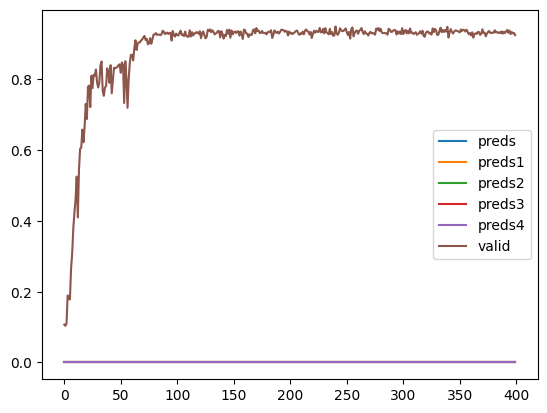

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/400 [00:00<?, ?it/s]

***训练集***
0.105


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 1/400 [00:15<1:43:51, 15.62s/it]

valid-f1: 0.07565155756581857
valid-precision: 0.08067750459364727
valid-recall: 0.11543267314617145
process: 1  loss: 57.665771484375  train_correct: 0.005283351154160639 valid_loss 470.187602519989  val_correct: 0.11693486590038314
The model has been saved!!
The best val_acc is  0.11693486590038314
***训练集***
0.10625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 2/400 [00:30<1:42:26, 15.44s/it]

valid-f1: 0.09386659808318072
valid-precision: 0.09497031234305814
valid-recall: 0.12166678217584348
process: 2  loss: 57.70240545272827  train_correct: 0.005346248191710171 valid_loss 468.57840061187744  val_correct: 0.12245210727969348
The model has been saved!!
The best val_acc is  0.12245210727969348
***训练集***
0.105


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 3/400 [00:46<1:42:39, 15.51s/it]

valid-f1: 0.13328712274567872
valid-precision: 0.14179846139757746
valid-recall: 0.19656051433706243
process: 3  loss: 57.52542233467102  train_correct: 0.005283351154160639 valid_loss 466.51795291900635  val_correct: 0.19724137931034483
The model has been saved!!
The best val_acc is  0.19724137931034483
***训练集***
0.14125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 4/400 [01:01<1:41:59, 15.45s/it]

valid-f1: 0.14649540393274027
valid-precision: 0.1570814112614664
valid-recall: 0.18983831531370757
process: 4  loss: 57.227927923202515  train_correct: 0.00710736524309705 valid_loss 464.30549454689026  val_correct: 0.19708812260536399
***训练集***
0.1725


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▏         | 5/400 [01:17<1:41:54, 15.48s/it]

valid-f1: 0.16834510477554804
valid-precision: 0.19555984101195237
valid-recall: 0.23595679745444392
process: 5  loss: 56.82264304161072  train_correct: 0.008679791181835336 valid_loss 460.26009142398834  val_correct: 0.23402298850574713
The model has been saved!!
The best val_acc is  0.23402298850574713
***训练集***
0.1875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 6/400 [01:32<1:41:22, 15.44s/it]

valid-f1: 0.2040176649412393
valid-precision: 0.3095015763402932
valid-recall: 0.2617310629593829
process: 6  loss: 56.29875946044922  train_correct: 0.009434555632429712 valid_loss 451.7101501226425  val_correct: 0.26804597701149424
The model has been saved!!
The best val_acc is  0.26804597701149424
***训练集***
0.22625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 7/400 [01:48<1:40:41, 15.37s/it]

valid-f1: 0.17554979373816532
valid-precision: 0.1861554050332864
valid-recall: 0.24417371078080033
process: 7  loss: 55.34707951545715  train_correct: 0.011384363796465187 valid_loss 436.9064087867737  val_correct: 0.25103448275862067
***训练集***
0.26125


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 8/400 [02:03<1:40:33, 15.39s/it]

valid-f1: 0.13536604297281843
valid-precision: 0.23397246129483515
valid-recall: 0.21152637175463007
process: 8  loss: 53.80040216445923  train_correct: 0.013145480847852066 valid_loss 429.8733552098274  val_correct: 0.21455938697318008
***训练集***
0.29625


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 9/400 [02:18<1:40:28, 15.42s/it]

valid-f1: 0.18375684429742806
valid-precision: 0.33085750705712397
valid-recall: 0.2575517955530895
process: 9  loss: 51.12292766571045  train_correct: 0.014906597899238946 valid_loss 404.5837891101837  val_correct: 0.2628352490421456
***训练集***
0.34


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▎         | 10/400 [02:34<1:40:21, 15.44s/it]

valid-f1: 0.09374950588315017
valid-precision: 0.23754825105328975
valid-recall: 0.19978033066970405
process: 10  loss: 47.58000469207764  train_correct: 0.017107994213472547 valid_loss 413.59051072597504  val_correct: 0.20183908045977011
***训练集***
0.40125


  3%|▎         | 11/400 [02:49<1:40:04, 15.43s/it]

valid-f1: 0.3284281187987086
valid-precision: 0.4562767037118616
valid-recall: 0.3434077261068392
process: 11  loss: 44.62849724292755  train_correct: 0.020189949053399586 valid_loss 353.48457086086273  val_correct: 0.3534099616858238
The model has been saved!!
The best val_acc is  0.3534099616858238
***训练集***
0.425


  3%|▎         | 12/400 [03:05<1:40:07, 15.48s/it]

valid-f1: 0.35633467249362843
valid-precision: 0.46058389688717377
valid-recall: 0.4235720158750234
process: 12  loss: 41.43552827835083  train_correct: 0.021384992766840683 valid_loss 314.8587572053075  val_correct: 0.4327969348659004
The model has been saved!!
The best val_acc is  0.4327969348659004
***训练集***
0.49625


  3%|▎         | 13/400 [03:21<1:40:14, 15.54s/it]

valid-f1: 0.43835669666382976
valid-precision: 0.5093344576948104
valid-recall: 0.49202951977046155
process: 13  loss: 38.064725041389465  train_correct: 0.024970123907163973 valid_loss 281.88864424824715  val_correct: 0.5083524904214559
The model has been saved!!
The best val_acc is  0.5083524904214559
***训练集***
0.5125


  4%|▎         | 14/400 [03:36<1:40:03, 15.55s/it]

valid-f1: 0.5197755488311605
valid-precision: 0.524110082055874
valid-recall: 0.5768003718330066
process: 14  loss: 36.25297474861145  train_correct: 0.02578778539530788 valid_loss 262.9081732183695  val_correct: 0.5954022988505747
The model has been saved!!
The best val_acc is  0.5954022988505747
***训练集***
0.54875


  4%|▍         | 15/400 [03:52<1:39:36, 15.52s/it]

valid-f1: 0.4710841176950475
valid-precision: 0.5822141483678662
valid-recall: 0.49807762157640456
process: 15  loss: 34.71018624305725  train_correct: 0.027611799484244293 valid_loss 268.8399695456028  val_correct: 0.514176245210728
***训练集***
0.59875


  4%|▍         | 16/400 [04:07<1:38:45, 15.43s/it]

valid-f1: 0.5862809054888275
valid-precision: 0.626280989790064
valid-recall: 0.6215147792022978
process: 16  loss: 31.68982172012329  train_correct: 0.03012768098622555 valid_loss 236.69158834964037  val_correct: 0.6354022988505748
The model has been saved!!
The best val_acc is  0.6354022988505748
***训练集***
0.6275


  4%|▍         | 17/400 [04:22<1:38:13, 15.39s/it]

valid-f1: 0.5775995831074304
valid-precision: 0.6454146361989097
valid-recall: 0.6104859036571255
process: 17  loss: 29.393449366092682  train_correct: 0.03157431284986477 valid_loss 221.84083464741707  val_correct: 0.6268199233716475
***训练集***
0.6475


  4%|▍         | 18/400 [04:37<1:37:51, 15.37s/it]

valid-f1: 0.6936109303076462
valid-precision: 0.7313012938452288
valid-recall: 0.7011283754114108
process: 18  loss: 28.343870401382446  train_correct: 0.03258066545065728 valid_loss 195.41348698735237  val_correct: 0.7068199233716476
The model has been saved!!
The best val_acc is  0.7068199233716476
***训练集***
0.6775


  5%|▍         | 19/400 [04:53<1:37:10, 15.30s/it]

valid-f1: 0.5709787754455765
valid-precision: 0.6528409358161944
valid-recall: 0.5935957068787968
process: 19  loss: 26.901403665542603  train_correct: 0.03409019435184603 valid_loss 246.18478333950043  val_correct: 0.6133333333333333
***训练集***
0.67875


  5%|▌         | 20/400 [05:08<1:36:46, 15.28s/it]

valid-f1: 0.6725861981145431
valid-precision: 0.6994907508275174
valid-recall: 0.7082228942328123
process: 20  loss: 25.8546182513237  train_correct: 0.03415309138939556 valid_loss 178.21573513373733  val_correct: 0.7233716475095785
The model has been saved!!
The best val_acc is  0.7233716475095785
***训练集***
0.70375


  5%|▌         | 21/400 [05:23<1:36:14, 15.24s/it]

valid-f1: 0.5836320482271122
valid-precision: 0.6666238339910152
valid-recall: 0.6044952206221796
process: 21  loss: 23.295849978923798  train_correct: 0.03541103214038619 valid_loss 235.65506175160408  val_correct: 0.6180842911877394
***训练集***
0.68375


  6%|▌         | 22/400 [05:38<1:35:36, 15.18s/it]

valid-f1: 0.7711814997641147
valid-precision: 0.7891143644384438
valid-recall: 0.7790531730108119
process: 22  loss: 24.22886300086975  train_correct: 0.03440467953959368 valid_loss 143.3987681567669  val_correct: 0.792183908045977
The model has been saved!!
The best val_acc is  0.792183908045977
***训练集***
0.7525


  6%|▌         | 23/400 [05:53<1:34:55, 15.11s/it]

valid-f1: 0.7495149936432631
valid-precision: 0.7972163624730495
valid-recall: 0.7592755857968831
process: 23  loss: 21.25658082962036  train_correct: 0.03786401660481791 valid_loss 147.32123260200024  val_correct: 0.7793103448275862
***训练集***
0.7225


  6%|▌         | 24/400 [06:08<1:34:22, 15.06s/it]

valid-f1: 0.7468760942023207
valid-precision: 0.7784350788990548
valid-recall: 0.7541751008861309
process: 24  loss: 21.697602450847626  train_correct: 0.03635448770362916 valid_loss 155.7770064137876  val_correct: 0.7578544061302682
***训练集***
0.74875


  6%|▋         | 25/400 [06:23<1:33:56, 15.03s/it]

valid-f1: 0.7242355752859375
valid-precision: 0.7951048039294687
valid-recall: 0.7397867119207125
process: 25  loss: 20.112720549106598  train_correct: 0.03767532549216932 valid_loss 162.46868337970227  val_correct: 0.7566283524904215
***训练集***
0.77375


  6%|▋         | 26/400 [06:38<1:33:52, 15.06s/it]

valid-f1: 0.8191451557444858
valid-precision: 0.8285863206649037
valid-recall: 0.8228538278338078
process: 26  loss: 18.78611409664154  train_correct: 0.038933266243159945 valid_loss 119.23322663456202  val_correct: 0.834176245210728
The model has been saved!!
The best val_acc is  0.834176245210728
***训练集***
0.7775


  7%|▋         | 27/400 [06:53<1:33:46, 15.09s/it]

valid-f1: 0.7263739883426739
valid-precision: 0.7530789384644383
valid-recall: 0.7467906103378423
process: 27  loss: 18.278720200061798  train_correct: 0.03912195735580854 valid_loss 147.27392691746354  val_correct: 0.7638314176245211
***训练集***
0.7775


  7%|▋         | 28/400 [07:08<1:33:24, 15.07s/it]

valid-f1: 0.7936505016731409
valid-precision: 0.8052486570544509
valid-recall: 0.7965825714196332
process: 28  loss: 17.844791173934937  train_correct: 0.03912195735580854 valid_loss 135.81609599664807  val_correct: 0.8055172413793104
***训练集***
0.7775


  7%|▋         | 29/400 [07:23<1:33:03, 15.05s/it]

valid-f1: 0.7874670142510107
valid-precision: 0.806661418924163
valid-recall: 0.7943409465962011
process: 29  loss: 18.848748415708542  train_correct: 0.03912195735580854 valid_loss 134.8645532131195  val_correct: 0.8007662835249042
***训练集***
0.81


  8%|▊         | 30/400 [07:39<1:33:27, 15.16s/it]

valid-f1: 0.8245083187293891
valid-precision: 0.8460735054615679
valid-recall: 0.8300149613901503
process: 30  loss: 16.36923971772194  train_correct: 0.04075728033209636 valid_loss 104.00620019063354  val_correct: 0.8450574712643678
The model has been saved!!
The best val_acc is  0.8450574712643678
***训练集***
0.8


  8%|▊         | 31/400 [07:54<1:33:04, 15.13s/it]

valid-f1: 0.8247092842401818
valid-precision: 0.8359214588355328
valid-recall: 0.827630632242119
process: 31  loss: 16.192349135875702  train_correct: 0.04025410403170011 valid_loss 121.16707175970078  val_correct: 0.8329501915708812
***训练集***
0.79375


  8%|▊         | 32/400 [08:09<1:32:55, 15.15s/it]

valid-f1: 0.8120476660666563
valid-precision: 0.8203549399232198
valid-recall: 0.8187703293024106
process: 32  loss: 17.046954691410065  train_correct: 0.03993961884395245 valid_loss 118.94665767252445  val_correct: 0.8308045977011494
***训练集***
0.79875


  8%|▊         | 33/400 [08:24<1:32:36, 15.14s/it]

valid-f1: 0.8331464172642941
valid-precision: 0.8413262886730376
valid-recall: 0.8341795850612611
process: 33  loss: 16.059032529592514  train_correct: 0.040191206994150575 valid_loss 108.83896553888917  val_correct: 0.8441379310344828
***训练集***
0.81875


  8%|▊         | 34/400 [08:39<1:32:24, 15.15s/it]

valid-f1: 0.8080587986169393
valid-precision: 0.8319097546749001
valid-recall: 0.8046965486968034
process: 34  loss: 15.265773683786392  train_correct: 0.041197559594943076 valid_loss 122.9819087088108  val_correct: 0.8073563218390805
***训练集***
0.82125


  9%|▉         | 35/400 [08:54<1:32:03, 15.13s/it]

valid-f1: 0.8246825534076867
valid-precision: 0.8357196576401552
valid-recall: 0.8250499351451719
process: 35  loss: 14.929831862449646  train_correct: 0.04132335367004214 valid_loss 103.21377934888005  val_correct: 0.8311111111111111
***训练集***
0.7975


  9%|▉         | 36/400 [09:10<1:32:06, 15.18s/it]

valid-f1: 0.8374164441865629
valid-precision: 0.8501332418115156
valid-recall: 0.8396809113756758
process: 36  loss: 15.269283562898636  train_correct: 0.04012830995660104 valid_loss 110.55449340865016  val_correct: 0.8459770114942529
The model has been saved!!
The best val_acc is  0.8459770114942529
***训练集***
0.8175


  9%|▉         | 37/400 [09:25<1:31:53, 15.19s/it]

valid-f1: 0.8342886336758586
valid-precision: 0.8437996029713535
valid-recall: 0.8367991130675019
process: 37  loss: 14.402600765228271  train_correct: 0.04113466255739354 valid_loss 106.9671672694385  val_correct: 0.842911877394636
***训练集***
0.82125


 10%|▉         | 38/400 [09:40<1:31:23, 15.15s/it]

valid-f1: 0.7328470993939197
valid-precision: 0.8160162508916755
valid-recall: 0.7132334769534803
process: 38  loss: 14.0522580742836  train_correct: 0.04132335367004214 valid_loss 191.21597723662853  val_correct: 0.7101915708812261
***训练集***
0.83


 10%|▉         | 39/400 [09:55<1:30:58, 15.12s/it]

valid-f1: 0.8141503734411257
valid-precision: 0.8275949759353466
valid-recall: 0.8116981834193779
process: 39  loss: 13.609986871480942  train_correct: 0.04176363293288886 valid_loss 118.4857025668025  val_correct: 0.8190038314176246
***训练集***
0.8125


 10%|█         | 40/400 [10:10<1:30:44, 15.12s/it]

valid-f1: 0.8021319404553747
valid-precision: 0.8403821584398601
valid-recall: 0.813093336408633
process: 40  loss: 14.410156667232513  train_correct: 0.04088307440719542 valid_loss 124.18107140809298  val_correct: 0.8295785440613027
***训练集***
0.84625


 10%|█         | 41/400 [10:25<1:30:43, 15.16s/it]

valid-f1: 0.828924330409245
valid-precision: 0.8411683975232428
valid-recall: 0.83531064765877
process: 41  loss: 13.296275809407234  train_correct: 0.04258129442103277 valid_loss 103.49255567230284  val_correct: 0.8450574712643678
***训练集***
0.82625


 10%|█         | 42/400 [10:41<1:30:39, 15.19s/it]

valid-f1: 0.754306775331357
valid-precision: 0.7976302484112556
valid-recall: 0.7756202006951083
process: 42  loss: 13.276391118764877  train_correct: 0.04157494182024027 valid_loss 137.47610445600003  val_correct: 0.7958620689655173
***训练集***
0.83


 11%|█         | 43/400 [10:56<1:30:12, 15.16s/it]

valid-f1: 0.8082166988831447
valid-precision: 0.8243095178601887
valid-recall: 0.8083501394225306
process: 43  loss: 12.793700128793716  train_correct: 0.04176363293288886 valid_loss 112.20195274800062  val_correct: 0.8122605363984674
***训练集***
0.825


 11%|█         | 44/400 [11:11<1:29:55, 15.15s/it]

valid-f1: 0.7773633254399179
valid-precision: 0.8267296199212769
valid-recall: 0.7877157602647358
process: 44  loss: 13.420057088136673  train_correct: 0.04151204478269074 valid_loss 122.97172647714615  val_correct: 0.7981609195402298
***训练集***
0.8225


 11%|█▏        | 45/400 [11:26<1:29:30, 15.13s/it]

valid-f1: 0.7979334676418661
valid-precision: 0.8195076917292587
valid-recall: 0.8002587155452661
process: 45  loss: 13.332065224647522  train_correct: 0.04138625070759167 valid_loss 118.33330714330077  val_correct: 0.8075095785440614
***训练集***
0.82625


 12%|█▏        | 46/400 [11:41<1:28:52, 15.06s/it]

valid-f1: 0.8210890671440264
valid-precision: 0.831624246776755
valid-recall: 0.8223820196174021
process: 46  loss: 13.067100822925568  train_correct: 0.04157494182024027 valid_loss 100.64720263704658  val_correct: 0.8308045977011494
***训练集***
0.81875


 12%|█▏        | 47/400 [11:56<1:28:54, 15.11s/it]

valid-f1: 0.7819668325590504
valid-precision: 0.816404448735842
valid-recall: 0.7892950182492698
process: 47  loss: 14.244597852230072  train_correct: 0.041197559594943076 valid_loss 129.41484541492537  val_correct: 0.8055172413793104
***训练集***
0.8225


 12%|█▏        | 48/400 [12:11<1:28:37, 15.11s/it]

valid-f1: 0.8357632578387015
valid-precision: 0.8502485290290351
valid-recall: 0.835714539474148
process: 48  loss: 13.895883619785309  train_correct: 0.04138625070759167 valid_loss 95.62649408401921  val_correct: 0.842911877394636
***训练集***
0.8525


 12%|█▏        | 49/400 [12:26<1:28:37, 15.15s/it]

valid-f1: 0.7847778333154984
valid-precision: 0.8155456811651618
valid-recall: 0.7853771864008899
process: 49  loss: 11.787065714597702  train_correct: 0.042895779608780424 valid_loss 138.179957580287  val_correct: 0.7957088122605364
***训练集***
0.8575


 12%|█▎        | 50/400 [12:41<1:28:13, 15.12s/it]

valid-f1: 0.8251068681385998
valid-precision: 0.855538591124494
valid-recall: 0.8251907927365698
process: 50  loss: 11.144172698259354  train_correct: 0.04314736775897855 valid_loss 110.69453398324549  val_correct: 0.8332567049808429
***训练集***
0.85375


 13%|█▎        | 51/400 [12:57<1:28:14, 15.17s/it]

valid-f1: 0.8130701258988312
valid-precision: 0.8504220776580876
valid-recall: 0.8153544466650307
process: 51  loss: 11.380783692002296  train_correct: 0.042958676646329956 valid_loss 120.37867224449292  val_correct: 0.8285057471264368
***训练集***
0.845


 13%|█▎        | 52/400 [13:12<1:27:50, 15.15s/it]

valid-f1: 0.8490610728217829
valid-precision: 0.8559279861560531
valid-recall: 0.8511340881101225
process: 52  loss: 12.095589429140091  train_correct: 0.04251839738348324 valid_loss 89.26846871711314  val_correct: 0.8563984674329502
The model has been saved!!
The best val_acc is  0.8563984674329502
***训练集***
0.8525


 13%|█▎        | 53/400 [13:27<1:27:31, 15.13s/it]

valid-f1: 0.7998704094946057
valid-precision: 0.8297037870641691
valid-recall: 0.7984377506060767
process: 53  loss: 10.993929713964462  train_correct: 0.042895779608780424 valid_loss 134.8239961117506  val_correct: 0.8009195402298851
***训练集***
0.83375


 14%|█▎        | 54/400 [13:42<1:27:03, 15.10s/it]

valid-f1: 0.8387586304995059
valid-precision: 0.8462807256446438
valid-recall: 0.8421266059180013
process: 54  loss: 12.289623022079468  train_correct: 0.041952324045537455 valid_loss 90.73903231043369  val_correct: 0.8444444444444444
***训练集***
0.85125


 14%|█▍        | 55/400 [13:57<1:26:47, 15.09s/it]

valid-f1: 0.8675575788923304
valid-precision: 0.8862752338697911
valid-recall: 0.8685305809631918
process: 55  loss: 11.356842398643494  train_correct: 0.04283288257123089 valid_loss 81.88793010637164  val_correct: 0.8777011494252873
The model has been saved!!
The best val_acc is  0.8777011494252873
***训练集***
0.8725


 14%|█▍        | 56/400 [14:12<1:26:19, 15.06s/it]

valid-f1: 0.7901643445923647
valid-precision: 0.825041960343499
valid-recall: 0.7902934006789958
process: 56  loss: 11.011411413550377  train_correct: 0.04390213220957293 valid_loss 122.09760625474155  val_correct: 0.7880459770114943
***训练集***
0.855


 14%|█▍        | 57/400 [14:27<1:25:58, 15.04s/it]

valid-f1: 0.8360569070890321
valid-precision: 0.845610433630236
valid-recall: 0.8356205514493465
process: 57  loss: 11.526729792356491  train_correct: 0.04302157368387949 valid_loss 99.57162871677428  val_correct: 0.8426053639846743
***训练集***
0.855


 14%|█▍        | 58/400 [14:42<1:25:34, 15.01s/it]

valid-f1: 0.8093780192224951
valid-precision: 0.8471698111154851
valid-recall: 0.8092486636898182
process: 58  loss: 11.479276925325394  train_correct: 0.04302157368387949 valid_loss 115.58650194387883  val_correct: 0.8167049808429119
***训练集***
0.85125


 15%|█▍        | 59/400 [14:57<1:25:25, 15.03s/it]

valid-f1: 0.833481259129222
valid-precision: 0.8663947549937598
valid-recall: 0.8333570846705506
process: 59  loss: 11.206211894750595  train_correct: 0.04283288257123089 valid_loss 100.66553916223347  val_correct: 0.8377011494252874
***训练集***
0.82875


 15%|█▌        | 60/400 [15:12<1:25:06, 15.02s/it]

valid-f1: 0.818340335983819
valid-precision: 0.8610898563830849
valid-recall: 0.822031457626216
process: 60  loss: 12.660864695906639  train_correct: 0.041700735895339326 valid_loss 122.13416147744283  val_correct: 0.8360153256704981
***训练集***
0.855


 15%|█▌        | 61/400 [15:27<1:25:00, 15.05s/it]

valid-f1: 0.8295520314928696
valid-precision: 0.8505434604841113
valid-recall: 0.8292730713886216
process: 61  loss: 10.950362220406532  train_correct: 0.04302157368387949 valid_loss 109.98776858253404  val_correct: 0.835095785440613
***训练集***
0.87125


 16%|█▌        | 62/400 [15:42<1:24:40, 15.03s/it]

valid-f1: 0.8334469323236808
valid-precision: 0.8532132963602747
valid-recall: 0.834303377179632
process: 62  loss: 10.891053661704063  train_correct: 0.0438392351720234 valid_loss 112.76522515993565  val_correct: 0.8355555555555556
***训练集***
0.85125


 16%|█▌        | 63/400 [15:57<1:24:44, 15.09s/it]

valid-f1: 0.851709931763682
valid-precision: 0.8649058300575991
valid-recall: 0.8526416674545907
process: 63  loss: 11.122808627784252  train_correct: 0.04283288257123089 valid_loss 88.67340031266212  val_correct: 0.8580842911877394
***训练集***
0.89375


 16%|█▌        | 64/400 [16:12<1:24:22, 15.07s/it]

valid-f1: 0.8503078200512659
valid-precision: 0.8860200897114273
valid-recall: 0.8515356027818811
process: 64  loss: 8.998922541737556  train_correct: 0.044971381847914965 valid_loss 93.3117014337331  val_correct: 0.8620689655172413
***训练集***
0.85125


 16%|█▋        | 65/400 [16:27<1:24:17, 15.10s/it]

valid-f1: 0.8260673265784252
valid-precision: 0.8554786015395486
valid-recall: 0.8260177171364127
process: 65  loss: 10.927107155323029  train_correct: 0.04283288257123089 valid_loss 115.83821757510304  val_correct: 0.8291187739463601
***训练集***
0.88375


 16%|█▋        | 66/400 [16:42<1:23:52, 15.07s/it]

valid-f1: 0.8588963677300901
valid-precision: 0.8782041660476377
valid-recall: 0.8567508224939349
process: 66  loss: 9.499970972537994  train_correct: 0.044468205547518715 valid_loss 83.5081829149276  val_correct: 0.8672796934865901
***训练集***
0.86375


 17%|█▋        | 67/400 [16:57<1:23:39, 15.07s/it]

valid-f1: 0.8053532998106114
valid-precision: 0.852454956620674
valid-recall: 0.809837176648759
process: 67  loss: 10.583895400166512  train_correct: 0.04346185294672621 valid_loss 124.16562904184684  val_correct: 0.8133333333333334
***训练集***
0.89


 17%|█▋        | 68/400 [17:13<1:23:18, 15.06s/it]

valid-f1: 0.8494861988579856
valid-precision: 0.8586074083525462
valid-recall: 0.8489505595151238
process: 68  loss: 9.26611502468586  train_correct: 0.04478269073526637 valid_loss 91.53478174796328  val_correct: 0.8525670498084291
***训练集***
0.87625


 17%|█▋        | 69/400 [17:28<1:23:10, 15.08s/it]

valid-f1: 0.8421295576587656
valid-precision: 0.8546649648716542
valid-recall: 0.843564198756867
process: 69  loss: 9.598433166742325  train_correct: 0.04409082332222152 valid_loss 93.82419820688665  val_correct: 0.8444444444444444
***训练集***
0.855


 18%|█▊        | 70/400 [17:43<1:22:56, 15.08s/it]

valid-f1: 0.8684736617449778
valid-precision: 0.8722504134170042
valid-recall: 0.8699980912286673
process: 70  loss: 10.366964995861053  train_correct: 0.04302157368387949 valid_loss 77.08933708816767  val_correct: 0.8764750957854406
***训练集***
0.85875


 18%|█▊        | 71/400 [17:58<1:22:34, 15.06s/it]

valid-f1: 0.8494205422398018
valid-precision: 0.8570463057766826
valid-recall: 0.8522858742185224
process: 71  loss: 9.81612928211689  train_correct: 0.043210264796528085 valid_loss 90.94759549945593  val_correct: 0.8559386973180076
***训练集***
0.86375


 18%|█▊        | 72/400 [18:13<1:22:36, 15.11s/it]

valid-f1: 0.8559508721825889
valid-precision: 0.8701444441636695
valid-recall: 0.8566831205613795
process: 72  loss: 10.240520432591438  train_correct: 0.04346185294672621 valid_loss 90.7765055950731  val_correct: 0.8625287356321839
***训练集***
0.86


 18%|█▊        | 73/400 [18:28<1:22:12, 15.08s/it]

valid-f1: 0.8225166708453292
valid-precision: 0.8432528202402171
valid-recall: 0.8259814814482576
process: 73  loss: 10.334097877144814  train_correct: 0.04327316183407762 valid_loss 108.19781181775033  val_correct: 0.8268199233716476
***训练集***
0.88875
开始蒸馏


 18%|█▊        | 74/400 [18:43<1:21:56, 15.08s/it]

valid-f1: 0.8484688560521019
valid-precision: 0.851490805123111
valid-recall: 0.8499927871059357
process: 74  loss: 8.75602076947689  train_correct: 0.044719793697716836 valid_loss 93.67934969672933  val_correct: 0.8562452107279693
***训练集***
0.78625


 19%|█▉        | 75/400 [18:58<1:21:39, 15.08s/it]

valid-f1: 0.6873543843356751
valid-precision: 0.7765664556734844
valid-recall: 0.7299086383081047
process: 75  loss: 2392.593307495117  train_correct: 0.03956223661865526 valid_loss 190.3090299803298  val_correct: 0.7500383141762452
***训练集***
0.745


 19%|█▉        | 76/400 [19:13<1:21:38, 15.12s/it]

valid-f1: 0.7640676634610759
valid-precision: 0.8338761407406698
valid-recall: 0.776883243011937
process: 76  loss: 1470.5364379882812  train_correct: 0.037486634379520725 valid_loss 150.72811282833572  val_correct: 0.7931034482758621
***训练集***
0.76125


 19%|█▉        | 77/400 [19:28<1:21:24, 15.12s/it]

valid-f1: 0.7200988619531994
valid-precision: 0.8429758991586407
valid-recall: 0.7297153633969466
process: 77  loss: 1217.5681762695312  train_correct: 0.03830429586766463 valid_loss 218.64491188060288  val_correct: 0.7491187739463602
***训练集***
0.7825


 20%|█▉        | 78/400 [19:44<1:21:03, 15.10s/it]

valid-f1: 0.8254160149216835
valid-precision: 0.8426913039791406
valid-recall: 0.828640842397706
process: 78  loss: 1099.7021102905273  train_correct: 0.03937354550600667 valid_loss 108.3011663612815  val_correct: 0.8369348659003831
***训练集***
0.80875


 20%|█▉        | 79/400 [19:59<1:20:37, 15.07s/it]

valid-f1: 0.82698008320123
valid-precision: 0.8524164056423768
valid-recall: 0.834604223988668
process: 79  loss: 964.2802848815918  train_correct: 0.040694383294546825 valid_loss 105.41450348997023  val_correct: 0.8413793103448276
***训练集***
0.7975


 20%|██        | 80/400 [20:14<1:20:41, 15.13s/it]

valid-f1: 0.8542757524768663
valid-precision: 0.8638240591093554
valid-recall: 0.8578560021135457
process: 80  loss: 907.1262397766113  train_correct: 0.04012830995660104 valid_loss 88.25840307486942  val_correct: 0.8600766283524904
***训练集***
0.84


 20%|██        | 81/400 [20:29<1:20:31, 15.14s/it]

valid-f1: 0.8916668056016676
valid-precision: 0.8947323525606622
valid-recall: 0.8930327602437893
process: 81  loss: 825.3600845336914  train_correct: 0.04226680923328511 valid_loss 70.91267907600195  val_correct: 0.8963984674329502
The model has been saved!!
The best val_acc is  0.8963984674329502
***训练集***
0.79


 20%|██        | 82/400 [20:44<1:20:20, 15.16s/it]

valid-f1: 0.9011617886977976
valid-precision: 0.9068350688752366
valid-recall: 0.9001398898014201
process: 82  loss: 839.0405769348145  train_correct: 0.039750927731303856 valid_loss 69.61213087328724  val_correct: 0.9055938697318008
The model has been saved!!
The best val_acc is  0.9055938697318008
***训练集***
0.84875


 21%|██        | 83/400 [20:59<1:19:46, 15.10s/it]

valid-f1: 0.8755455411418026
valid-precision: 0.878960008129652
valid-recall: 0.8806362518518617
process: 83  loss: 819.8388080596924  train_correct: 0.042707088496131834 valid_loss 82.32870951511109  val_correct: 0.8830651340996168
***训练集***
0.8275


 21%|██        | 84/400 [21:14<1:19:27, 15.09s/it]

valid-f1: 0.8817575573237354
valid-precision: 0.8943939550903501
valid-recall: 0.8839383155629097
process: 84  loss: 816.6709499359131  train_correct: 0.0416378388577898 valid_loss 83.44470440040459  val_correct: 0.8896551724137931
***训练集***
0.85125


 21%|██▏       | 85/400 [21:29<1:19:07, 15.07s/it]

valid-f1: 0.8912015868648577
valid-precision: 0.8979363221771971
valid-recall: 0.8935434177239674
process: 85  loss: 739.3966293334961  train_correct: 0.04283288257123089 valid_loss 75.11954994167536  val_correct: 0.8985440613026819
***训练集***
0.8475


 22%|██▏       | 86/400 [21:44<1:18:56, 15.09s/it]

valid-f1: 0.8804703747870409
valid-precision: 0.8860955035476747
valid-recall: 0.8851431083961818
process: 86  loss: 722.7766933441162  train_correct: 0.0426441914585823 valid_loss 82.48993287345002  val_correct: 0.8904214559386974
***训练集***
0.8375


 22%|██▏       | 87/400 [21:59<1:18:41, 15.08s/it]

valid-f1: 0.8949020453163913
valid-precision: 0.9024031939265814
valid-recall: 0.8993536227011887
process: 87  loss: 711.898042678833  train_correct: 0.04214101515818605 valid_loss 74.87954516606987  val_correct: 0.9059003831417625
The model has been saved!!
The best val_acc is  0.9059003831417625
***训练集***
0.87125


 22%|██▏       | 88/400 [22:15<1:18:43, 15.14s/it]

valid-f1: 0.9007944788298878
valid-precision: 0.9048215777177205
valid-recall: 0.9031321468422815
process: 88  loss: 661.2851409912109  train_correct: 0.0438392351720234 valid_loss 67.19205778770993  val_correct: 0.908199233716475
The model has been saved!!
The best val_acc is  0.908199233716475
***训练集***
0.86125


 22%|██▏       | 89/400 [22:30<1:18:25, 15.13s/it]

valid-f1: 0.9072724602287279
valid-precision: 0.9113923478362208
valid-recall: 0.9083774339133572
process: 89  loss: 678.1728591918945  train_correct: 0.04333605887162715 valid_loss 69.65559657096128  val_correct: 0.9132567049808429
The model has been saved!!
The best val_acc is  0.9132567049808429
***训练集***
0.85375


 22%|██▎       | 90/400 [22:45<1:18:13, 15.14s/it]

valid-f1: 0.9104264848804796
valid-precision: 0.9146609623302989
valid-recall: 0.9122946105105815
process: 90  loss: 676.0754947662354  train_correct: 0.042958676646329956 valid_loss 65.92863193123412  val_correct: 0.9173946360153257
The model has been saved!!
The best val_acc is  0.9173946360153257
***训练集***
0.8575


 23%|██▎       | 91/400 [23:00<1:17:46, 15.10s/it]

valid-f1: 0.9047568767081688
valid-precision: 0.9059716256704677
valid-recall: 0.9081443393212215
process: 91  loss: 677.0467529296875  train_correct: 0.04314736775897855 valid_loss 68.05946470845447  val_correct: 0.9111111111111111
***训练集***
0.8575


 23%|██▎       | 92/400 [23:15<1:17:28, 15.09s/it]

valid-f1: 0.9156614462779304
valid-precision: 0.9237400892753234
valid-recall: 0.917124475273926
process: 92  loss: 666.204418182373  train_correct: 0.04314736775897855 valid_loss 67.59250659383179  val_correct: 0.9236781609195402
The model has been saved!!
The best val_acc is  0.9236781609195402
***训练集***
0.85375


 23%|██▎       | 93/400 [23:30<1:17:06, 15.07s/it]

valid-f1: 0.9039415067960705
valid-precision: 0.9080623804961245
valid-recall: 0.9063713317672842
process: 93  loss: 649.7600135803223  train_correct: 0.042958676646329956 valid_loss 67.29249003491168  val_correct: 0.9115708812260537
***训练集***
0.8825


 24%|██▎       | 94/400 [23:45<1:17:00, 15.10s/it]

valid-f1: 0.9039791397289563
valid-precision: 0.9046981444380867
valid-recall: 0.9053564526822729
process: 94  loss: 645.1234645843506  train_correct: 0.04440530850996918 valid_loss 70.732427952097  val_correct: 0.9109578544061303
***训练集***
0.87375


 24%|██▍       | 95/400 [24:00<1:16:39, 15.08s/it]

valid-f1: 0.9136623567029245
valid-precision: 0.915387286777445
valid-recall: 0.9157035690390181
process: 95  loss: 622.5367259979248  train_correct: 0.04396502924712246 valid_loss 61.41302991413977  val_correct: 0.9209195402298851
***训练集***
0.855


 24%|██▍       | 96/400 [24:15<1:16:26, 15.09s/it]

valid-f1: 0.9001873078256086
valid-precision: 0.9065996191394232
valid-recall: 0.9010980847538994
process: 96  loss: 635.2755336761475  train_correct: 0.04302157368387949 valid_loss 75.26443449927046  val_correct: 0.9040613026819924
***训练集***
0.8725


 24%|██▍       | 97/400 [24:30<1:15:59, 15.05s/it]

valid-f1: 0.8961375496130308
valid-precision: 0.8994669797852686
valid-recall: 0.8998963157347767
process: 97  loss: 623.202320098877  train_correct: 0.04390213220957293 valid_loss 76.75856317646867  val_correct: 0.9029885057471264
***训练集***
0.8675


 24%|██▍       | 98/400 [24:45<1:15:49, 15.06s/it]

valid-f1: 0.9114118716127211
valid-precision: 0.9125720981391426
valid-recall: 0.9141061825992282
process: 98  loss: 583.6838836669922  train_correct: 0.0436505440593748 valid_loss 65.5205462787253  val_correct: 0.9184674329501916
***训练集***
0.87125


 25%|██▍       | 99/400 [25:01<1:15:35, 15.07s/it]

valid-f1: 0.9124418564386145
valid-precision: 0.9142580008263209
valid-recall: 0.914191964016176
process: 99  loss: 593.9956531524658  train_correct: 0.0438392351720234 valid_loss 62.258401578339544  val_correct: 0.9189272030651341
***训练集***
0.845


 25%|██▌       | 100/400 [25:16<1:15:15, 15.05s/it]

valid-f1: 0.8973941273159406
valid-precision: 0.9074157932516836
valid-recall: 0.8996077227214234
process: 100  loss: 608.2342929840088  train_correct: 0.04251839738348324 valid_loss 77.18518243685321  val_correct: 0.904367816091954
***训练集***
0.87125


 25%|██▌       | 101/400 [25:31<1:15:19, 15.12s/it]

valid-f1: 0.9032721349989202
valid-precision: 0.9049869064082101
valid-recall: 0.9064032365928348
process: 101  loss: 583.82639503479  train_correct: 0.0438392351720234 valid_loss 71.4006886970435  val_correct: 0.9115708812260537
***训练集***
0.89625


 26%|██▌       | 102/400 [25:46<1:14:50, 15.07s/it]

valid-f1: 0.9078158866406358
valid-precision: 0.9088068923989748
valid-recall: 0.911140183122247
process: 102  loss: 572.9082107543945  train_correct: 0.04509717592301402 valid_loss 72.530556378857  val_correct: 0.9146360153256705
***训练集***
0.86625


 26%|██▌       | 103/400 [26:01<1:14:28, 15.04s/it]

valid-f1: 0.9178418485958627
valid-precision: 0.9174926389337232
valid-recall: 0.9195578475610848
process: 103  loss: 587.3424949645996  train_correct: 0.04358764702182527 valid_loss 62.564667643237044  val_correct: 0.9219923371647509
***训练集***
0.86625


 26%|██▌       | 104/400 [26:16<1:14:04, 15.01s/it]

valid-f1: 0.9105646120331021
valid-precision: 0.9140158884578049
valid-recall: 0.9132324797599496
process: 104  loss: 567.0706443786621  train_correct: 0.04358764702182527 valid_loss 71.45034858299186  val_correct: 0.9181609195402299
***训练集***
0.8525


 26%|██▋       | 105/400 [26:31<1:13:45, 15.00s/it]

valid-f1: 0.8958235514907174
valid-precision: 0.9004153915986676
valid-recall: 0.9017936379764064
process: 105  loss: 580.4648818969727  train_correct: 0.042895779608780424 valid_loss 73.27713454801415  val_correct: 0.9025287356321839
***训练集***
0.8825


 26%|██▋       | 106/400 [26:46<1:13:35, 15.02s/it]

valid-f1: 0.904506372989764
valid-precision: 0.9059929474723075
valid-recall: 0.9084995903784258
process: 106  loss: 565.9353561401367  train_correct: 0.04440530850996918 valid_loss 69.44300498458324  val_correct: 0.912183908045977
***训练集***
0.87875


 27%|██▋       | 107/400 [27:01<1:13:28, 15.05s/it]

valid-f1: 0.9125976849198043
valid-precision: 0.9168619534442456
valid-recall: 0.9159857430030097
process: 107  loss: 525.3704051971436  train_correct: 0.044216617397320586 valid_loss 73.03250744105753  val_correct: 0.9218390804597701
***训练集***
0.895


 27%|██▋       | 108/400 [27:16<1:13:11, 15.04s/it]

valid-f1: 0.9028580317119766
valid-precision: 0.9075060854811184
valid-recall: 0.9056431448786583
process: 108  loss: 543.1462345123291  train_correct: 0.0450342788854645 valid_loss 69.221760435752  val_correct: 0.9098850574712644
***训练集***
0.87


 27%|██▋       | 109/400 [27:31<1:12:58, 15.05s/it]

valid-f1: 0.9046562188005172
valid-precision: 0.9051479356448539
valid-recall: 0.9086495202603114
process: 109  loss: 533.1630706787109  train_correct: 0.04377633813447387 valid_loss 73.65590312763925  val_correct: 0.9120306513409961
***训练集***
0.86125


 28%|██▊       | 110/400 [27:46<1:12:36, 15.02s/it]

valid-f1: 0.907705904251604
valid-precision: 0.911987620886762
valid-recall: 0.9113648303899984
process: 110  loss: 568.0565452575684  train_correct: 0.04333605887162715 valid_loss 82.72940733654423  val_correct: 0.9164750957854406
***训练集***
0.89


 28%|██▊       | 111/400 [28:01<1:12:24, 15.03s/it]

valid-f1: 0.9175425210859677
valid-precision: 0.9190914349223578
valid-recall: 0.9198614339375142
process: 111  loss: 555.069766998291  train_correct: 0.04478269073526637 valid_loss 67.6715897999893  val_correct: 0.9244444444444444
The model has been saved!!
The best val_acc is  0.9244444444444444
***训练集***
0.88875
开始蒸馏


 28%|██▊       | 112/400 [28:16<1:12:03, 15.01s/it]

valid-f1: 0.9049902691347613
valid-precision: 0.9088944331337974
valid-recall: 0.9079765349870993
process: 112  loss: 560.0490741729736  train_correct: 0.044719793697716836 valid_loss 70.53634320216224  val_correct: 0.9124904214559387
***训练集***
0.88875


 28%|██▊       | 113/400 [28:31<1:11:45, 15.00s/it]

valid-f1: 0.908074166437539
valid-precision: 0.9106217096775703
valid-recall: 0.9114775706584654
process: 113  loss: 520.2790546417236  train_correct: 0.044719793697716836 valid_loss 71.08836226664016  val_correct: 0.9163218390804597
***训练集***
0.87875


 28%|██▊       | 114/400 [28:46<1:11:30, 15.00s/it]

valid-f1: 0.9065062814647717
valid-precision: 0.9088384907245921
valid-recall: 0.9087595744279714
process: 114  loss: 533.6542453765869  train_correct: 0.044216617397320586 valid_loss 71.89158524353479  val_correct: 0.9140229885057471
***训练集***
0.8775


 29%|██▉       | 115/400 [29:01<1:11:16, 15.00s/it]

valid-f1: 0.9090697824185193
valid-precision: 0.9128611645273426
valid-recall: 0.9123688478486478
process: 115  loss: 512.0069484710693  train_correct: 0.044153720359771054 valid_loss 71.19304891777574  val_correct: 0.9172413793103448
***训练集***
0.88625


 29%|██▉       | 116/400 [29:16<1:10:52, 14.97s/it]

valid-f1: 0.9139620043475718
valid-precision: 0.9170335550062554
valid-recall: 0.9167927806677291
process: 116  loss: 532.704761505127  train_correct: 0.04459399962261777 valid_loss 66.22838228326873  val_correct: 0.9222988505747126
***训练集***
0.87125


 29%|██▉       | 117/400 [29:31<1:10:49, 15.02s/it]

valid-f1: 0.9141251916039558
valid-precision: 0.9181394514518537
valid-recall: 0.9169958833284859
process: 117  loss: 528.2646522521973  train_correct: 0.0438392351720234 valid_loss 72.09725098102354  val_correct: 0.9230651340996169
***训练集***
0.8725


 30%|██▉       | 118/400 [29:46<1:10:34, 15.02s/it]

valid-f1: 0.9095331436278169
valid-precision: 0.9100817444313796
valid-recall: 0.9127626849296588
process: 118  loss: 504.28503799438477  train_correct: 0.04390213220957293 valid_loss 71.19495371658923  val_correct: 0.9172413793103448
***训练集***
0.89


 30%|██▉       | 119/400 [30:01<1:10:29, 15.05s/it]

valid-f1: 0.9087437211117205
valid-precision: 0.9106818836935139
valid-recall: 0.9121491370299786
process: 119  loss: 523.1695823669434  train_correct: 0.04478269073526637 valid_loss 70.8603725109424  val_correct: 0.9173946360153257
***训练集***
0.885


 30%|███       | 120/400 [30:16<1:10:01, 15.01s/it]

valid-f1: 0.9105629214024697
valid-precision: 0.9119141356590392
valid-recall: 0.9128372750832063
process: 120  loss: 525.6760673522949  train_correct: 0.04453110258506824 valid_loss 66.23212963409924  val_correct: 0.9169348659003831
***训练集***
0.87


 30%|███       | 121/400 [30:31<1:09:45, 15.00s/it]

valid-f1: 0.8950587367584314
valid-precision: 0.9116496881413962
valid-recall: 0.8998270340218733
process: 121  loss: 505.7990531921387  train_correct: 0.04377633813447387 valid_loss 89.93069343820753  val_correct: 0.9077394636015326
***训练集***
0.86875


 30%|███       | 122/400 [30:46<1:09:40, 15.04s/it]

valid-f1: 0.9237146314606944
valid-precision: 0.9293072936836975
valid-recall: 0.9252204860180575
process: 122  loss: 545.8228816986084  train_correct: 0.043713441096924335 valid_loss 59.99745093563979  val_correct: 0.931647509578544
The model has been saved!!
The best val_acc is  0.931647509578544
***训练集***
0.8775


 31%|███       | 123/400 [31:01<1:09:17, 15.01s/it]

valid-f1: 0.9021580327708838
valid-precision: 0.9029450975505784
valid-recall: 0.9057617193770675
process: 123  loss: 484.09351348876953  train_correct: 0.044153720359771054 valid_loss 69.18508337574895  val_correct: 0.9089655172413793
***训练集***
0.9025


 31%|███       | 124/400 [31:16<1:09:08, 15.03s/it]

valid-f1: 0.9115914498168047
valid-precision: 0.9151933380669938
valid-recall: 0.9148103879042495
process: 124  loss: 496.96728801727295  train_correct: 0.045411661110761684 valid_loss 70.14940385010777  val_correct: 0.9201532567049808
***训练集***
0.8875


 31%|███▏      | 125/400 [31:31<1:08:47, 15.01s/it]

valid-f1: 0.9197305548373347
valid-precision: 0.9230084414974365
valid-recall: 0.9215752084356209
process: 125  loss: 496.8155040740967  train_correct: 0.044656896660167304 valid_loss 64.54084847732338  val_correct: 0.9275095785440614
***训练集***
0.8575


 32%|███▏      | 126/400 [31:46<1:08:39, 15.04s/it]

valid-f1: 0.906269567719616
valid-precision: 0.9118846641470377
valid-recall: 0.9100777195509103
process: 126  loss: 511.1559638977051  train_correct: 0.04314736775897855 valid_loss 74.09752493659835  val_correct: 0.9155555555555556
***训练集***
0.9


 32%|███▏      | 127/400 [32:01<1:08:22, 15.03s/it]

valid-f1: 0.9124988278336736
valid-precision: 0.9119700588561169
valid-recall: 0.9149321221059298
process: 127  loss: 486.1396999359131  train_correct: 0.04528586703566262 valid_loss 66.50206903511207  val_correct: 0.9177011494252874
***训练集***
0.89125


 32%|███▏      | 128/400 [32:17<1:08:54, 15.20s/it]

valid-f1: 0.9117083219840065
valid-precision: 0.9148475475457778
valid-recall: 0.9145433648221253
process: 128  loss: 486.51961517333984  train_correct: 0.0448455877728159 valid_loss 72.24321183201391  val_correct: 0.9198467432950191
***训练集***
0.8925


 32%|███▏      | 129/400 [32:32<1:08:46, 15.23s/it]

valid-f1: 0.9051075004452466
valid-precision: 0.9053434353431002
valid-recall: 0.9085888574303886
process: 129  loss: 510.28686141967773  train_correct: 0.04490848481036543 valid_loss 70.92121965083061  val_correct: 0.9124904214559387
***训练集***
0.905


 32%|███▎      | 130/400 [32:47<1:08:24, 15.20s/it]

valid-f1: 0.9100176759471706
valid-precision: 0.9181381843657384
valid-recall: 0.9137426524710559
process: 130  loss: 499.3526782989502  train_correct: 0.04553745518586075 valid_loss 77.67124395228893  val_correct: 0.9201532567049808
***训练集***
0.8925


 33%|███▎      | 131/400 [33:02<1:08:06, 15.19s/it]

valid-f1: 0.9092460008892884
valid-precision: 0.9175416366951046
valid-recall: 0.9124062838255181
process: 131  loss: 496.0207853317261  train_correct: 0.04490848481036543 valid_loss 72.21893886862745  val_correct: 0.9195402298850575
***训练集***
0.89625


 33%|███▎      | 132/400 [33:18<1:07:51, 15.19s/it]

valid-f1: 0.9060575327732199
valid-precision: 0.9057389903821373
valid-recall: 0.909408603313004
process: 132  loss: 487.6698627471924  train_correct: 0.04509717592301402 valid_loss 68.89251550513472  val_correct: 0.9131034482758621
***训练集***
0.87


 33%|███▎      | 133/400 [33:33<1:07:30, 15.17s/it]

valid-f1: 0.9053651763467231
valid-precision: 0.9087321231578469
valid-recall: 0.909179259475604
process: 133  loss: 488.62195205688477  train_correct: 0.04377633813447387 valid_loss 77.94798637292115  val_correct: 0.9135632183908046
***训练集***
0.89125


 34%|███▎      | 134/400 [33:48<1:07:24, 15.21s/it]

valid-f1: 0.9180315293711907
valid-precision: 0.9177670155022483
valid-recall: 0.9200957640365848
process: 134  loss: 479.0306053161621  train_correct: 0.0448455877728159 valid_loss 61.56534132870729  val_correct: 0.9239846743295019
***训练集***
0.88125


 34%|███▍      | 135/400 [34:03<1:07:03, 15.18s/it]

valid-f1: 0.921473078498377
valid-precision: 0.9213242900914755
valid-recall: 0.9232120877318805
process: 135  loss: 493.5896854400635  train_correct: 0.04434241147241965 valid_loss 67.11439232305929  val_correct: 0.9272030651340997
***训练集***
0.88375


 34%|███▍      | 136/400 [34:18<1:06:44, 15.17s/it]

valid-f1: 0.9090269262241926
valid-precision: 0.9098038711246514
valid-recall: 0.9111330895028041
process: 136  loss: 473.6944580078125  train_correct: 0.044468205547518715 valid_loss 70.10956989157421  val_correct: 0.9137164750957855
***训练集***
0.88375


 34%|███▍      | 137/400 [34:33<1:06:08, 15.09s/it]

valid-f1: 0.9163957073453635
valid-precision: 0.9217410437064346
valid-recall: 0.9192572246163605
process: 137  loss: 485.53729820251465  train_correct: 0.044468205547518715 valid_loss 65.65339967419641  val_correct: 0.9253639846743295
***训练集***
0.88


 34%|███▍      | 138/400 [34:48<1:05:53, 15.09s/it]

valid-f1: 0.9098389004743535
valid-precision: 0.9193387333852001
valid-recall: 0.9135499997882193
process: 138  loss: 495.64501953125  train_correct: 0.04427951443487012 valid_loss 79.70271718032018  val_correct: 0.9203065134099617
***训练集***
0.9


 35%|███▍      | 139/400 [35:03<1:05:32, 15.07s/it]

valid-f1: 0.9147009916541522
valid-precision: 0.9193130814824778
valid-recall: 0.916989222701406
process: 139  loss: 480.0345935821533  train_correct: 0.04528586703566262 valid_loss 65.94188992594718  val_correct: 0.9226053639846743
***训练集***
0.875
开始蒸馏


 35%|███▌      | 140/400 [35:18<1:05:15, 15.06s/it]

valid-f1: 0.9094346001383163
valid-precision: 0.9143096165578694
valid-recall: 0.9129052477205052
process: 140  loss: 488.33660316467285  train_correct: 0.04402792628467199 valid_loss 71.91562195081497  val_correct: 0.9186206896551724
***训练集***
0.895


 35%|███▌      | 141/400 [35:33<1:04:44, 15.00s/it]

valid-f1: 0.9072470625270814
valid-precision: 0.9105013231459079
valid-recall: 0.9109067634953941
process: 141  loss: 475.56407165527344  train_correct: 0.0450342788854645 valid_loss 76.3482937719964  val_correct: 0.9161685823754789
***训练集***
0.905


 36%|███▌      | 142/400 [35:48<1:04:37, 15.03s/it]

valid-f1: 0.9181613671468296
valid-precision: 0.9190623757641537
valid-recall: 0.9208761875625553
process: 142  loss: 466.02128314971924  train_correct: 0.04553745518586075 valid_loss 66.02646594196995  val_correct: 0.9259770114942528
***训练集***
0.89625


 36%|███▌      | 143/400 [36:03<1:04:18, 15.01s/it]

valid-f1: 0.9238246054914055
valid-precision: 0.9235347101054426
valid-recall: 0.9254457497662694
process: 143  loss: 457.4873275756836  train_correct: 0.04509717592301402 valid_loss 62.51927761870229  val_correct: 0.9291954022988506
***训练集***
0.9


 36%|███▌      | 144/400 [36:18<1:04:07, 15.03s/it]

valid-f1: 0.9122610249997669
valid-precision: 0.9132388950970718
valid-recall: 0.9148568037055949
process: 144  loss: 456.2097234725952  train_correct: 0.04528586703566262 valid_loss 66.5656187821096  val_correct: 0.9189272030651341
***训练集***
0.89125


 36%|███▋      | 145/400 [36:33<1:03:46, 15.01s/it]

valid-f1: 0.914347816346354
valid-precision: 0.9160746061238088
valid-recall: 0.9171543473035383
process: 145  loss: 461.02662467956543  train_correct: 0.0448455877728159 valid_loss 68.7099812935021  val_correct: 0.9224521072796935
***训练集***
0.89


 36%|███▋      | 146/400 [36:48<1:03:30, 15.00s/it]

valid-f1: 0.8926513611779162
valid-precision: 0.8977900972455817
valid-recall: 0.8958965323293514
process: 146  loss: 479.2686414718628  train_correct: 0.04478269073526637 valid_loss 77.1711861952208  val_correct: 0.8986973180076628
***训练集***
0.8925


 37%|███▋      | 147/400 [37:03<1:03:09, 14.98s/it]

valid-f1: 0.9190136376524393
valid-precision: 0.9183859874541508
valid-recall: 0.9209260395077132
process: 147  loss: 471.48608207702637  train_correct: 0.04490848481036543 valid_loss 67.0806492452175  val_correct: 0.9244444444444444
***训练集***
0.9125


 37%|███▋      | 148/400 [37:18<1:02:51, 14.97s/it]

valid-f1: 0.912191110631141
valid-precision: 0.9124588929194051
valid-recall: 0.9152150193338798
process: 148  loss: 455.60984897613525  train_correct: 0.045914837411157934 valid_loss 73.57428069206071  val_correct: 0.9196934865900384
***训练集***
0.92875


 37%|███▋      | 149/400 [37:33<1:02:43, 15.00s/it]

valid-f1: 0.9083852170120114
valid-precision: 0.9114178023863454
valid-recall: 0.911915036913487
process: 149  loss: 462.1166944503784  train_correct: 0.046732498899301846 valid_loss 78.28062121435505  val_correct: 0.917088122605364
***训练集***
0.87625


 38%|███▊      | 150/400 [37:48<1:02:19, 14.96s/it]

valid-f1: 0.9146887040922203
valid-precision: 0.9166741118706121
valid-recall: 0.9170907742060695
process: 150  loss: 484.3369731903076  train_correct: 0.04409082332222152 valid_loss 69.74037749941272  val_correct: 0.9219923371647509
***训练集***
0.88875


 38%|███▊      | 151/400 [38:03<1:02:11, 14.99s/it]

valid-f1: 0.9203175472665096
valid-precision: 0.9237976739218612
valid-recall: 0.9230698427135883
process: 151  loss: 449.7101020812988  train_correct: 0.044719793697716836 valid_loss 66.46821037402515  val_correct: 0.9288888888888889
***训练集***
0.89625


 38%|███▊      | 152/400 [38:18<1:01:58, 15.00s/it]

valid-f1: 0.9130076601498054
valid-precision: 0.916218576249492
valid-recall: 0.916062198837583
process: 152  loss: 445.00092697143555  train_correct: 0.04509717592301402 valid_loss 73.25718064465491  val_correct: 0.9213793103448276
***训练集***
0.89375


 38%|███▊      | 153/400 [38:33<1:01:48, 15.01s/it]

valid-f1: 0.9136638486485464
valid-precision: 0.9165954596672785
valid-recall: 0.9165181847552676
process: 153  loss: 457.15839195251465  train_correct: 0.044971381847914965 valid_loss 68.26682614360107  val_correct: 0.9218390804597701
***训练集***
0.88875


 38%|███▊      | 154/400 [38:48<1:01:26, 14.98s/it]

valid-f1: 0.9112370530351003
valid-precision: 0.924940063318003
valid-recall: 0.9156898377121288
process: 154  loss: 455.2263011932373  train_correct: 0.044719793697716836 valid_loss 80.34094645857112  val_correct: 0.9236781609195402
***训练集***
0.89625


 39%|███▉      | 155/400 [39:03<1:01:21, 15.03s/it]

valid-f1: 0.9196463318545891
valid-precision: 0.9206546837334073
valid-recall: 0.9222932545439834
process: 155  loss: 462.7595167160034  train_correct: 0.04509717592301402 valid_loss 62.90344157721847  val_correct: 0.9272030651340997
***训练集***
0.91125


 39%|███▉      | 156/400 [39:18<1:00:59, 15.00s/it]

valid-f1: 0.905983450176274
valid-precision: 0.9109739085446371
valid-recall: 0.9102614762319771
process: 156  loss: 460.1060485839844  train_correct: 0.0458519403736084 valid_loss 81.3231012133183  val_correct: 0.916015325670498
***训练集***
0.9


 39%|███▉      | 157/400 [39:33<1:00:54, 15.04s/it]

valid-f1: 0.9207753014621141
valid-precision: 0.9235385910252603
valid-recall: 0.9232884451438081
process: 157  loss: 435.73729610443115  train_correct: 0.04528586703566262 valid_loss 68.51529275566463  val_correct: 0.9298084291187739
***训练集***
0.89875


 40%|███▉      | 158/400 [39:48<1:00:30, 15.00s/it]

valid-f1: 0.9112973896468688
valid-precision: 0.9107501717722369
valid-recall: 0.9144155738240769
process: 158  loss: 432.3066635131836  train_correct: 0.04522296999811309 valid_loss 71.63058749112861  val_correct: 0.919080459770115
***训练集***
0.91
开始蒸馏


 40%|███▉      | 159/400 [40:03<1:00:19, 15.02s/it]

valid-f1: 0.9157398738215967
valid-precision: 0.9160586649637736
valid-recall: 0.9178658137116787
process: 159  loss: 439.2142286300659  train_correct: 0.04578904333605887 valid_loss 69.77084289443974  val_correct: 0.9227586206896552
***训练集***
0.8925


 40%|████      | 160/400 [40:18<59:55, 14.98s/it]  

valid-f1: 0.9140688553302112
valid-precision: 0.920131329705522
valid-recall: 0.9173480483916083
process: 160  loss: 459.59712982177734  train_correct: 0.04490848481036543 valid_loss 71.39649392069259  val_correct: 0.9230651340996169
***训练集***
0.8975


 40%|████      | 161/400 [40:33<59:47, 15.01s/it]

valid-f1: 0.9139451828669479
valid-precision: 0.9181333081399641
valid-recall: 0.9168781397608381
process: 161  loss: 451.004301071167  train_correct: 0.045160072960563555 valid_loss 69.13302293697052  val_correct: 0.9230651340996169
***训练集***
0.9175


 40%|████      | 162/400 [40:48<59:33, 15.01s/it]

valid-f1: 0.915510785369662
valid-precision: 0.9181124256001862
valid-recall: 0.9186224262465347
process: 162  loss: 432.18747997283936  train_correct: 0.04616642556135606 valid_loss 71.38953074401797  val_correct: 0.9245977011494253
***训练集***
0.88625


 41%|████      | 163/400 [41:03<59:14, 15.00s/it]

valid-f1: 0.9198527818754124
valid-precision: 0.9213973213208959
valid-recall: 0.9222945331387971
process: 163  loss: 450.8976860046387  train_correct: 0.04459399962261777 valid_loss 63.03291399234149  val_correct: 0.9276628352490421
***训练集***
0.895


 41%|████      | 164/400 [41:18<58:51, 14.97s/it]

valid-f1: 0.919576922884846
valid-precision: 0.9201068805556931
valid-recall: 0.921504557462311
process: 164  loss: 428.6929636001587  train_correct: 0.0450342788854645 valid_loss 65.71099974162644  val_correct: 0.926896551724138
***训练集***
0.88625


 41%|████▏     | 165/400 [41:33<58:40, 14.98s/it]

valid-f1: 0.9099623336790007
valid-precision: 0.9168386774940493
valid-recall: 0.9136572745274764
process: 165  loss: 451.1186532974243  train_correct: 0.04459399962261777 valid_loss 77.76410750581726  val_correct: 0.9204597701149425
***训练集***
0.9025


 42%|████▏     | 166/400 [41:48<58:25, 14.98s/it]

valid-f1: 0.905603673719332
valid-precision: 0.9173836537683562
valid-recall: 0.9104789011791248
process: 166  loss: 431.29978942871094  train_correct: 0.045411661110761684 valid_loss 85.25730747089256  val_correct: 0.9177011494252874
***训练集***
0.89125


 42%|████▏     | 167/400 [42:03<58:17, 15.01s/it]

valid-f1: 0.9129837843308188
valid-precision: 0.9172751846356659
valid-recall: 0.9164688360757849
process: 167  loss: 460.69621753692627  train_correct: 0.0448455877728159 valid_loss 72.38347764563514  val_correct: 0.9224521072796935
***训练集***
0.89875


 42%|████▏     | 168/400 [42:18<58:00, 15.00s/it]

valid-f1: 0.9124694526931456
valid-precision: 0.9180628528607052
valid-recall: 0.916166166032793
process: 168  loss: 428.15325450897217  train_correct: 0.04522296999811309 valid_loss 73.95954972615436  val_correct: 0.9226053639846743
***训练集***
0.8925


 42%|████▏     | 169/400 [42:33<57:48, 15.01s/it]

valid-f1: 0.9027963700045623
valid-precision: 0.9050171873177124
valid-recall: 0.9066850393600119
process: 169  loss: 455.338490486145  train_correct: 0.04490848481036543 valid_loss 78.2546692784781  val_correct: 0.9117241379310345
***训练集***
0.89


 42%|████▎     | 170/400 [42:48<57:31, 15.01s/it]

valid-f1: 0.905989612684464
valid-precision: 0.9092914369412151
valid-recall: 0.9096756100649062
process: 170  loss: 427.7548828125  train_correct: 0.04478269073526637 valid_loss 77.24164751687204  val_correct: 0.915095785440613
***训练集***
0.89875


 43%|████▎     | 171/400 [43:03<57:18, 15.02s/it]

valid-f1: 0.9162334806156647
valid-precision: 0.9170166934799319
valid-recall: 0.9188834689204125
process: 171  loss: 447.467734336853  train_correct: 0.04522296999811309 valid_loss 68.11335776521446  val_correct: 0.9242911877394636
***训练集***
0.92


 43%|████▎     | 172/400 [43:18<57:16, 15.07s/it]

valid-f1: 0.9124684664299736
valid-precision: 0.9184440080026798
valid-recall: 0.9154069917377274
process: 172  loss: 429.2958459854126  train_correct: 0.04629221963645512 valid_loss 72.34930750534113  val_correct: 0.9218390804597701
***训练集***
0.90375


 43%|████▎     | 173/400 [43:33<56:54, 15.04s/it]

valid-f1: 0.9162235726126486
valid-precision: 0.9182875476143231
valid-recall: 0.9191374418486348
process: 173  loss: 425.5010747909546  train_correct: 0.045474558148311216 valid_loss 68.05354669493317  val_correct: 0.9245977011494253
***训练集***
0.9


 44%|████▎     | 174/400 [43:49<56:46, 15.07s/it]

valid-f1: 0.9108475544114766
valid-precision: 0.9119990674805587
valid-recall: 0.9137955079967034
process: 174  loss: 432.6083822250366  train_correct: 0.04528586703566262 valid_loss 70.00291399657772  val_correct: 0.9183141762452107
***训练集***
0.8775


 44%|████▍     | 175/400 [44:03<56:25, 15.04s/it]

valid-f1: 0.9094942242990909
valid-precision: 0.9212153781222858
valid-recall: 0.9136265550018402
process: 175  loss: 453.5285291671753  train_correct: 0.044153720359771054 valid_loss 76.9388139773364  val_correct: 0.9207662835249042
***训练集***
0.8875


 44%|████▍     | 176/400 [44:19<56:13, 15.06s/it]

valid-f1: 0.9178600240195234
valid-precision: 0.9187449546457517
valid-recall: 0.920356379929556
process: 176  loss: 424.2085313796997  train_correct: 0.044656896660167304 valid_loss 69.1654974419398  val_correct: 0.9255172413793104
***训练集***
0.91375


 44%|████▍     | 177/400 [44:34<55:57, 15.06s/it]

valid-f1: 0.9136926026766213
valid-precision: 0.9238829594126192
valid-recall: 0.9181192972409027
process: 177  loss: 418.22807216644287  train_correct: 0.045977734448707466 valid_loss 77.30932925191883  val_correct: 0.9250574712643678
***训练集***
0.89


 44%|████▍     | 178/400 [44:49<55:48, 15.08s/it]

valid-f1: 0.9150608887063688
valid-precision: 0.9149389282161138
valid-recall: 0.9174736725922082
process: 178  loss: 428.8198652267456  train_correct: 0.04478269073526637 valid_loss 69.22708271667943  val_correct: 0.9221455938697318
***训练集***
0.9


 45%|████▍     | 179/400 [45:04<55:35, 15.09s/it]

valid-f1: 0.9156281921562762
valid-precision: 0.9157057391186674
valid-recall: 0.9182071258727245
process: 179  loss: 428.4609022140503  train_correct: 0.04528586703566262 valid_loss 64.5748662634287  val_correct: 0.9230651340996169
***训练集***
0.885


 45%|████▌     | 180/400 [45:19<55:19, 15.09s/it]

valid-f1: 0.9182451229917877
valid-precision: 0.9245383628791878
valid-recall: 0.9208263622093945
process: 180  loss: 426.73731327056885  train_correct: 0.04453110258506824 valid_loss 68.87124325804871  val_correct: 0.9273563218390805
***训练集***
0.895


 45%|████▌     | 181/400 [45:34<54:59, 15.06s/it]

valid-f1: 0.9208855650785013
valid-precision: 0.9207575502825636
valid-recall: 0.9229498066578035
process: 181  loss: 416.7326669692993  train_correct: 0.0450342788854645 valid_loss 66.12004363793676  val_correct: 0.9270498084291188
***训练集***
0.905


 46%|████▌     | 182/400 [45:49<54:47, 15.08s/it]

valid-f1: 0.9234194522496887
valid-precision: 0.9261465151233479
valid-recall: 0.9253590299472074
process: 182  loss: 425.9279489517212  train_correct: 0.04553745518586075 valid_loss 64.17414761307009  val_correct: 0.9313409961685823
***训练集***
0.9025


 46%|████▌     | 183/400 [46:04<54:29, 15.07s/it]

valid-f1: 0.91679392554515
valid-precision: 0.925119265364199
valid-recall: 0.9195517266209732
process: 183  loss: 414.7890453338623  train_correct: 0.045411661110761684 valid_loss 71.02161908384278  val_correct: 0.926896551724138
***训练集***
0.89


 46%|████▌     | 184/400 [46:19<54:20, 15.09s/it]

valid-f1: 0.9145921601954621
valid-precision: 0.9201791280852423
valid-recall: 0.9178922684242588
process: 184  loss: 420.24964904785156  train_correct: 0.04478269073526637 valid_loss 73.0102938332966  val_correct: 0.9241379310344827
***训练集***
0.90375


 46%|████▋     | 185/400 [46:34<53:54, 15.04s/it]

valid-f1: 0.9162994346001353
valid-precision: 0.9279463318210464
valid-recall: 0.9201898889929796
process: 185  loss: 415.81435775756836  train_correct: 0.045474558148311216 valid_loss 73.03668612144247  val_correct: 0.9284291187739464
***训练集***
0.90875


 46%|████▋     | 186/400 [46:49<53:45, 15.07s/it]

valid-f1: 0.9127007167125487
valid-precision: 0.918803794022752
valid-recall: 0.9160542486714253
process: 186  loss: 426.44630336761475  train_correct: 0.04572614629850934 valid_loss 76.08532059621211  val_correct: 0.9224521072796935
***训练集***
0.90375


 47%|████▋     | 187/400 [47:04<53:29, 15.07s/it]

valid-f1: 0.9168746664180546
valid-precision: 0.9219968010449205
valid-recall: 0.9198603684321324
process: 187  loss: 431.89426040649414  train_correct: 0.045474558148311216 valid_loss 69.91243593662875  val_correct: 0.9265900383141762
***训练集***
0.91125


 47%|████▋     | 188/400 [47:19<53:14, 15.07s/it]

valid-f1: 0.9108026632213824
valid-precision: 0.9133793978932742
valid-recall: 0.9138392182802519
process: 188  loss: 423.1109027862549  train_correct: 0.0458519403736084 valid_loss 75.64807899385687  val_correct: 0.9189272030651341
***训练集***
0.8825


 47%|████▋     | 189/400 [47:35<52:57, 15.06s/it]

valid-f1: 0.9217814166079951
valid-precision: 0.9220846311442749
valid-recall: 0.923462612196912
process: 189  loss: 410.0361099243164  train_correct: 0.04440530850996918 valid_loss 62.638486530551745  val_correct: 0.9276628352490421
***训练集***
0.8925


 48%|████▊     | 190/400 [47:50<52:50, 15.10s/it]

valid-f1: 0.9204066336012042
valid-precision: 0.9250621972610507
valid-recall: 0.9233216913853386
process: 190  loss: 407.14581298828125  train_correct: 0.04490848481036543 valid_loss 70.24824616439582  val_correct: 0.9296551724137931
***训练集***
0.89375


 48%|████▊     | 191/400 [48:05<52:38, 15.11s/it]

valid-f1: 0.9125315901473506
valid-precision: 0.9183303733994432
valid-recall: 0.9161102277461921
process: 191  loss: 423.1426773071289  train_correct: 0.044971381847914965 valid_loss 74.3969759034735  val_correct: 0.9221455938697318
***训练集***
0.90625


 48%|████▊     | 192/400 [48:20<52:27, 15.13s/it]

valid-f1: 0.9213268561850028
valid-precision: 0.9241480385182775
valid-recall: 0.9237190849968998
process: 192  loss: 418.2858076095581  train_correct: 0.04560035222341028 valid_loss 65.53441801549343  val_correct: 0.9296551724137931
***训练集***
0.90625


 48%|████▊     | 193/400 [48:35<52:06, 15.11s/it]

valid-f1: 0.913785530778013
valid-precision: 0.9140191211477889
valid-recall: 0.9163529203922703
process: 193  loss: 426.82480812072754  train_correct: 0.04560035222341028 valid_loss 70.47118731015144  val_correct: 0.92
***训练集***
0.89875


 48%|████▊     | 194/400 [48:50<51:50, 15.10s/it]

valid-f1: 0.9170601111503928
valid-precision: 0.9190983705958711
valid-recall: 0.9199258162852061
process: 194  loss: 422.3586263656616  train_correct: 0.04522296999811309 valid_loss 75.31924719567542  val_correct: 0.9253639846743295
***训练集***
0.89875


 49%|████▉     | 195/400 [49:05<51:33, 15.09s/it]

valid-f1: 0.922276837051973
valid-precision: 0.9231771603567834
valid-recall: 0.9245874095090558
process: 195  loss: 406.27077198028564  train_correct: 0.04522296999811309 valid_loss 63.394280625940155  val_correct: 0.9296551724137931
***训练集***
0.90125


 49%|████▉     | 196/400 [49:20<51:13, 15.06s/it]

valid-f1: 0.9162825043223505
valid-precision: 0.9219272462699521
valid-recall: 0.9197080615637407
process: 196  loss: 411.6163635253906  train_correct: 0.04534876407321215 valid_loss 69.88470461127326  val_correct: 0.9262835249042145
***训练集***
0.905


 49%|████▉     | 197/400 [49:35<51:10, 15.12s/it]

valid-f1: 0.9080380965185763
valid-precision: 0.9110251134647122
valid-recall: 0.9117336628543515
process: 197  loss: 403.59271812438965  train_correct: 0.04553745518586075 valid_loss 80.43044725452421  val_correct: 0.9169348659003831
***训练集***
0.9


 50%|████▉     | 198/400 [49:50<50:47, 15.08s/it]

valid-f1: 0.9129618559657564
valid-precision: 0.9220975354255889
valid-recall: 0.9173785505735526
process: 198  loss: 395.26233100891113  train_correct: 0.04528586703566262 valid_loss 80.38805232050845  val_correct: 0.9244444444444444
***训练集***
0.89875


 50%|████▉     | 199/400 [50:06<50:37, 15.11s/it]

valid-f1: 0.9159017899259114
valid-precision: 0.9227170579000635
valid-recall: 0.9186954313358389
process: 199  loss: 408.9000368118286  train_correct: 0.04522296999811309 valid_loss 67.40369506549177  val_correct: 0.9252107279693487
***训练集***
0.91625


 50%|█████     | 200/400 [50:21<50:14, 15.07s/it]

valid-f1: 0.9169516470074335
valid-precision: 0.9242930106660623
valid-recall: 0.9201269886624608
process: 200  loss: 395.13729667663574  train_correct: 0.04610352852380653 valid_loss 68.45180511844956  val_correct: 0.9267432950191571
***训练集***
0.9025


 50%|█████     | 201/400 [50:36<50:04, 15.10s/it]

valid-f1: 0.9118626435472598
valid-precision: 0.9202707654425151
valid-recall: 0.916149634759026
process: 201  loss: 411.3316287994385  train_correct: 0.045411661110761684 valid_loss 75.59028193601989  val_correct: 0.9232183908045977
***训练集***
0.90625


 50%|█████     | 202/400 [50:51<49:51, 15.11s/it]

valid-f1: 0.9139098986767344
valid-precision: 0.917932268123133
valid-recall: 0.9171707167213133
process: 202  loss: 396.60172748565674  train_correct: 0.04560035222341028 valid_loss 70.74552151818352  val_correct: 0.9230651340996169
***训练集***
0.9125


 51%|█████     | 203/400 [51:06<49:44, 15.15s/it]

valid-f1: 0.9094166049816463
valid-precision: 0.9102329618889063
valid-recall: 0.9121040555404372
process: 203  loss: 424.0897750854492  train_correct: 0.045914837411157934 valid_loss 72.64122727819631  val_correct: 0.917088122605364
***训练集***
0.8875


 51%|█████     | 204/400 [51:22<49:40, 15.21s/it]

valid-f1: 0.9196702753759147
valid-precision: 0.9203365390646627
valid-recall: 0.9216752613176377
process: 204  loss: 411.9956521987915  train_correct: 0.044656896660167304 valid_loss 64.84148145200743  val_correct: 0.9267432950191571
***训练集***
0.90375


 51%|█████▏    | 205/400 [51:37<49:33, 15.25s/it]

valid-f1: 0.9175861887029331
valid-precision: 0.9172531623678883
valid-recall: 0.9195106531197602
process: 205  loss: 400.3209447860718  train_correct: 0.045474558148311216 valid_loss 64.71697764420787  val_correct: 0.9239846743295019
***训练集***
0.90125


 52%|█████▏    | 206/400 [51:52<49:23, 15.28s/it]

valid-f1: 0.9120669257459442
valid-precision: 0.9122391938366082
valid-recall: 0.9151291742756186
process: 206  loss: 414.4253330230713  train_correct: 0.04534876407321215 valid_loss 70.11643777427525  val_correct: 0.9193869731800767
***训练集***
0.89


 52%|█████▏    | 207/400 [52:08<49:13, 15.30s/it]

valid-f1: 0.9131899733894542
valid-precision: 0.9178155591810752
valid-recall: 0.9163274567330634
process: 207  loss: 412.5529203414917  train_correct: 0.04478269073526637 valid_loss 72.73361548749381  val_correct: 0.9224521072796935
***训练集***
0.91625


 52%|█████▏    | 208/400 [52:23<48:59, 15.31s/it]

valid-f1: 0.9167812330238554
valid-precision: 0.9199896599251682
valid-recall: 0.9194514220803782
process: 208  loss: 402.65105724334717  train_correct: 0.04610352852380653 valid_loss 68.2408386352181  val_correct: 0.924904214559387
***训练集***
0.91


 52%|█████▏    | 209/400 [52:38<48:43, 15.31s/it]

valid-f1: 0.9083264018758767
valid-precision: 0.9177811812015703
valid-recall: 0.9129121145758493
process: 209  loss: 403.0897970199585  train_correct: 0.04578904333605887 valid_loss 79.43518879622206  val_correct: 0.92
***训练集***
0.91125


 52%|█████▎    | 210/400 [52:53<48:22, 15.28s/it]

valid-f1: 0.9184716654700473
valid-precision: 0.923673863934243
valid-recall: 0.9216487121901983
process: 210  loss: 417.40492248535156  train_correct: 0.0458519403736084 valid_loss 69.6566342358492  val_correct: 0.9279693486590038
***训练集***
0.9075


 53%|█████▎    | 211/400 [53:09<48:03, 15.26s/it]

valid-f1: 0.9185557073169119
valid-precision: 0.9201986338281951
valid-recall: 0.9210699638946866
process: 211  loss: 401.558931350708  train_correct: 0.045663249260959805 valid_loss 65.38280658703297  val_correct: 0.9267432950191571
***训练集***
0.905


 53%|█████▎    | 212/400 [53:24<47:39, 15.21s/it]

valid-f1: 0.9197264453697851
valid-precision: 0.9247540581253562
valid-recall: 0.9228612596796673
process: 212  loss: 396.1576042175293  train_correct: 0.04553745518586075 valid_loss 67.91198064148921  val_correct: 0.9295019157088122
***训练集***
0.91625


 53%|█████▎    | 213/400 [53:39<47:19, 15.18s/it]

valid-f1: 0.9151353165706823
valid-precision: 0.9189783108387376
valid-recall: 0.9179947396075707
process: 213  loss: 406.36786365509033  train_correct: 0.04610352852380653 valid_loss 70.46488180547749  val_correct: 0.9241379310344827
***训练集***
0.91125


 54%|█████▎    | 214/400 [53:54<46:59, 15.16s/it]

valid-f1: 0.913146010154535
valid-precision: 0.916730754936643
valid-recall: 0.9163217759736847
process: 214  loss: 393.4366264343262  train_correct: 0.0458519403736084 valid_loss 73.69563800267656  val_correct: 0.9227586206896552
***训练集***
0.91875


 54%|█████▍    | 215/400 [54:09<46:41, 15.14s/it]

valid-f1: 0.9077543192703331
valid-precision: 0.9142058601900104
valid-recall: 0.9117720548167354
process: 215  loss: 393.02086353302  train_correct: 0.04622932259890559 valid_loss 79.16094424225957  val_correct: 0.918007662835249
***训练集***
0.90875


 54%|█████▍    | 216/400 [54:24<46:23, 15.13s/it]

valid-f1: 0.9162533552645169
valid-precision: 0.923089672784384
valid-recall: 0.9198638411339826
process: 216  loss: 413.4397373199463  train_correct: 0.04572614629850934 valid_loss 70.14786044962602  val_correct: 0.9264367816091954
***训练集***
0.92


 54%|█████▍    | 217/400 [54:39<46:07, 15.12s/it]

valid-f1: 0.9128701821658023
valid-precision: 0.9214946020845884
valid-recall: 0.9168294455808826
process: 217  loss: 403.90323638916016  train_correct: 0.04629221963645512 valid_loss 76.63662034815934  val_correct: 0.9236781609195402
***训练集***
0.895


 55%|█████▍    | 218/400 [54:54<45:45, 15.08s/it]

valid-f1: 0.9146294194280044
valid-precision: 0.9193821360270702
valid-recall: 0.9180561613156879
process: 218  loss: 393.6623945236206  train_correct: 0.0450342788854645 valid_loss 73.84626066868077  val_correct: 0.9239846743295019
***训练集***
0.8925


 55%|█████▍    | 219/400 [55:10<45:39, 15.14s/it]

valid-f1: 0.915646993313435
valid-precision: 0.9174904028717126
valid-recall: 0.9185728494039509
process: 219  loss: 395.5862216949463  train_correct: 0.04490848481036543 valid_loss 70.55745676504011  val_correct: 0.9242911877394636
***训练集***
0.90125


 55%|█████▌    | 220/400 [55:25<45:25, 15.14s/it]

valid-f1: 0.9176408563169577
valid-precision: 0.919598167138159
valid-recall: 0.9201504610466305
process: 220  loss: 409.23123931884766  train_correct: 0.04534876407321215 valid_loss 69.57651113490465  val_correct: 0.925823754789272
***训练集***
0.90375


 55%|█████▌    | 221/400 [55:40<45:08, 15.13s/it]

valid-f1: 0.9118668160342507
valid-precision: 0.9216115289489833
valid-recall: 0.9159870879444414
process: 221  loss: 395.60154914855957  train_correct: 0.045474558148311216 valid_loss 79.32650660563377  val_correct: 0.9230651340996169
***训练集***
0.9025


 56%|█████▌    | 222/400 [55:55<45:09, 15.22s/it]

valid-f1: 0.9120573215322679
valid-precision: 0.9197452894495081
valid-recall: 0.915332613747775
process: 222  loss: 416.4972791671753  train_correct: 0.045411661110761684 valid_loss 77.33200895125265  val_correct: 0.9218390804597701
***训练集***
0.9175


 56%|█████▌    | 223/400 [56:11<45:14, 15.34s/it]

valid-f1: 0.9163185280968946
valid-precision: 0.9217710257036812
valid-recall: 0.9193144867671531
process: 223  loss: 395.993558883667  train_correct: 0.04616642556135606 valid_loss 71.3400093705568  val_correct: 0.9261302681992337
***训练集***
0.90875


 56%|█████▌    | 224/400 [56:26<44:56, 15.32s/it]

valid-f1: 0.9115705031183138
valid-precision: 0.9209578040967719
valid-recall: 0.9154677862334406
process: 224  loss: 397.0677709579468  train_correct: 0.04572614629850934 valid_loss 77.64460810602759  val_correct: 0.9226053639846743
***训练集***
0.885


 56%|█████▋    | 225/400 [56:41<44:41, 15.32s/it]

valid-f1: 0.9112970014905637
valid-precision: 0.9197694175423946
valid-recall: 0.9156481098544434
process: 225  loss: 401.3536739349365  train_correct: 0.04453110258506824 valid_loss 76.38002264090755  val_correct: 0.9230651340996169
***训练集***
0.9025


 56%|█████▋    | 226/400 [56:57<44:21, 15.30s/it]

valid-f1: 0.9116556636347495
valid-precision: 0.9172074153576466
valid-recall: 0.9150431552961772
process: 226  loss: 404.1574115753174  train_correct: 0.045411661110761684 valid_loss 72.9907567967166  val_correct: 0.9216858237547892
***训练集***
0.9


 57%|█████▋    | 227/400 [57:12<44:06, 15.29s/it]

valid-f1: 0.9150358935528515
valid-precision: 0.9241853662576343
valid-recall: 0.9191189112163227
process: 227  loss: 404.8083600997925  train_correct: 0.04528586703566262 valid_loss 73.146506866251  val_correct: 0.9265900383141762
***训练集***
0.8875


 57%|█████▋    | 228/400 [57:27<43:45, 15.26s/it]

valid-f1: 0.9156102762621178
valid-precision: 0.9225230242982105
valid-recall: 0.9191732958842467
process: 228  loss: 397.24788665771484  train_correct: 0.044656896660167304 valid_loss 76.07393351676001  val_correct: 0.9264367816091954
***训练集***
0.9125


 57%|█████▋    | 229/400 [57:42<43:26, 15.24s/it]

valid-f1: 0.9149310251797236
valid-precision: 0.9201220972642554
valid-recall: 0.9180632840294807
process: 229  loss: 394.30708026885986  train_correct: 0.045914837411157934 valid_loss 72.84013608831447  val_correct: 0.9239846743295019
***训练集***
0.915


 57%|█████▊    | 230/400 [57:57<43:03, 15.20s/it]

valid-f1: 0.9083485578610876
valid-precision: 0.9115111496873561
valid-recall: 0.911498660869485
process: 230  loss: 405.99999713897705  train_correct: 0.046040631486257 valid_loss 71.20277761670877  val_correct: 0.9166283524904214
***训练集***
0.89125


 58%|█████▊    | 231/400 [58:12<42:37, 15.13s/it]

valid-f1: 0.9101113264079362
valid-precision: 0.9157379217186754
valid-recall: 0.9137208491081557
process: 231  loss: 406.51201248168945  train_correct: 0.0448455877728159 valid_loss 77.65523777857015  val_correct: 0.9198467432950191
***训练集***
0.91875


 58%|█████▊    | 232/400 [58:28<42:27, 15.16s/it]

valid-f1: 0.9113869692796387
valid-precision: 0.920743643778313
valid-recall: 0.9154198865794132
process: 232  loss: 382.6549015045166  train_correct: 0.04622932259890559 valid_loss 79.06730842700927  val_correct: 0.9227586206896552
***训练集***
0.9125


 58%|█████▊    | 233/400 [58:43<42:03, 15.11s/it]

valid-f1: 0.913846097835437
valid-precision: 0.9183328817565233
valid-recall: 0.9164636455861552
process: 233  loss: 393.2256507873535  train_correct: 0.045914837411157934 valid_loss 69.82978462362371  val_correct: 0.9235249042145594
***训练集***
0.90875


 58%|█████▊    | 234/400 [58:58<41:46, 15.10s/it]

valid-f1: 0.9116473860385236
valid-precision: 0.9237430185877061
valid-recall: 0.916317856690229
process: 234  loss: 394.35806941986084  train_correct: 0.04572614629850934 valid_loss 78.71049016138568  val_correct: 0.9241379310344827
***训练集***
0.88625


 59%|█████▉    | 235/400 [59:13<41:29, 15.09s/it]

valid-f1: 0.9145327767798218
valid-precision: 0.9187558966609704
valid-recall: 0.9174303170284235
process: 235  loss: 393.58404636383057  train_correct: 0.04459399962261777 valid_loss 71.53755930414263  val_correct: 0.9235249042145594
***训练集***
0.91625


 59%|█████▉    | 236/400 [59:28<41:21, 15.13s/it]

valid-f1: 0.91613333400984
valid-precision: 0.9210691719186803
valid-recall: 0.9193775305126642
process: 236  loss: 378.32745456695557  train_correct: 0.04610352852380653 valid_loss 72.85642231504607  val_correct: 0.925823754789272
***训练集***
0.91125


 59%|█████▉    | 237/400 [59:43<41:03, 15.11s/it]

valid-f1: 0.913557567591433
valid-precision: 0.9136584662983667
valid-recall: 0.9158012360044474
process: 237  loss: 385.01568126678467  train_correct: 0.0458519403736084 valid_loss 70.73024496370635  val_correct: 0.92
***训练集***
0.9


 60%|█████▉    | 238/400 [59:58<41:00, 15.19s/it]

valid-f1: 0.9123284721591475
valid-precision: 0.9136921153525753
valid-recall: 0.9149965271935109
process: 238  loss: 373.63789463043213  train_correct: 0.04528586703566262 valid_loss 72.17898437434633  val_correct: 0.92
***训练集***
0.9325


 60%|█████▉    | 239/400 [1:00:14<40:48, 15.21s/it]

valid-f1: 0.9198606776936286
valid-precision: 0.9206038519051388
valid-recall: 0.921948645997217
process: 239  loss: 374.8990182876587  train_correct: 0.046921190011950435 valid_loss 64.21747213263006  val_correct: 0.9267432950191571
***训练集***
0.9225


 60%|██████    | 240/400 [1:00:29<40:43, 15.27s/it]

valid-f1: 0.9220126185184172
valid-precision: 0.9244874631189413
valid-recall: 0.9242719630795871
process: 240  loss: 386.5384883880615  train_correct: 0.046418013711554185 valid_loss 61.54317617624838  val_correct: 0.9296551724137931
***训练集***
0.9075


 60%|██████    | 241/400 [1:00:44<40:18, 15.21s/it]

valid-f1: 0.9188547171289049
valid-precision: 0.9251621863869808
valid-recall: 0.9220513140276463
process: 241  loss: 380.0382032394409  train_correct: 0.045663249260959805 valid_loss 72.23995142089825  val_correct: 0.9285823754789272
***训练集***
0.91875


 60%|██████    | 242/400 [1:00:59<40:02, 15.21s/it]

valid-f1: 0.9178931380872222
valid-precision: 0.9188119959437747
valid-recall: 0.9203858951400979
process: 242  loss: 376.62713050842285  train_correct: 0.04622932259890559 valid_loss 71.07179662454837  val_correct: 0.9252107279693487
***训练集***
0.89625


 61%|██████    | 243/400 [1:01:15<39:52, 15.24s/it]

valid-f1: 0.9191799523749153
valid-precision: 0.9260272541986613
valid-recall: 0.9223935568961192
process: 243  loss: 385.61077785491943  train_correct: 0.04509717592301402 valid_loss 69.96042154944735  val_correct: 0.9290421455938698
***训练集***
0.90375


 61%|██████    | 244/400 [1:01:30<39:32, 15.21s/it]

valid-f1: 0.9173111611073399
valid-precision: 0.9174835456861696
valid-recall: 0.919964403629954
process: 244  loss: 383.0276002883911  train_correct: 0.045474558148311216 valid_loss 66.01389786442451  val_correct: 0.924904214559387
***训练集***
0.91


 61%|██████▏   | 245/400 [1:01:45<39:06, 15.14s/it]

valid-f1: 0.9182382530934365
valid-precision: 0.9217400863596549
valid-recall: 0.9207924082391704
process: 245  loss: 379.63107204437256  train_correct: 0.04578904333605887 valid_loss 70.39317360824498  val_correct: 0.9265900383141762
***训练集***
0.9225


 62%|██████▏   | 246/400 [1:02:00<38:48, 15.12s/it]

valid-f1: 0.9197942434801675
valid-precision: 0.9231828227947949
valid-recall: 0.9222568237369106
process: 246  loss: 383.2651081085205  train_correct: 0.046418013711554185 valid_loss 66.73218519114016  val_correct: 0.9281226053639847
***训练集***
0.91625


 62%|██████▏   | 247/400 [1:02:15<38:27, 15.08s/it]

valid-f1: 0.914814210239377
valid-precision: 0.9219820218457185
valid-recall: 0.9181574426318349
process: 247  loss: 377.42602729797363  train_correct: 0.04610352852380653 valid_loss 70.53336676231993  val_correct: 0.9247509578544061
***训练集***
0.92875


 62%|██████▏   | 248/400 [1:02:30<38:21, 15.14s/it]

valid-f1: 0.9141146058077204
valid-precision: 0.9227078706674666
valid-recall: 0.9179328175266346
process: 248  loss: 386.3575839996338  train_correct: 0.046732498899301846 valid_loss 78.43207114341931  val_correct: 0.9255172413793104
***训练集***
0.9175
开始蒸馏


 62%|██████▏   | 249/400 [1:02:45<38:04, 15.13s/it]

valid-f1: 0.9148804730616528
valid-precision: 0.9246429483001031
valid-recall: 0.918352507478381
process: 249  loss: 379.8490858078003  train_correct: 0.04616642556135606 valid_loss 72.63108649575588  val_correct: 0.9259770114942528
***训练集***
0.9175


 62%|██████▎   | 250/400 [1:03:01<37:56, 15.18s/it]

valid-f1: 0.9058533758289384
valid-precision: 0.9153267744320808
valid-recall: 0.9104549025699779
process: 250  loss: 389.44361686706543  train_correct: 0.04616642556135606 valid_loss 80.952111249484  val_correct: 0.9169348659003831
***训练集***
0.91


 63%|██████▎   | 251/400 [1:03:16<37:40, 15.17s/it]

valid-f1: 0.9119108047274201
valid-precision: 0.9220401431046789
valid-recall: 0.9165871150510471
process: 251  loss: 383.15498542785645  train_correct: 0.04578904333605887 valid_loss 80.91029929741944  val_correct: 0.9242911877394636
***训练集***
0.895


 63%|██████▎   | 252/400 [1:03:31<37:35, 15.24s/it]

valid-f1: 0.920796081746923
valid-precision: 0.9247398649857843
valid-recall: 0.9234715072396817
process: 252  loss: 379.14787578582764  train_correct: 0.0450342788854645 valid_loss 69.21262992246193  val_correct: 0.9298084291187739
***训练集***
0.9025


 63%|██████▎   | 253/400 [1:03:46<37:23, 15.26s/it]

valid-f1: 0.9139787042007693
valid-precision: 0.9192378478581252
valid-recall: 0.9173439351332933
process: 253  loss: 392.9438076019287  train_correct: 0.045411661110761684 valid_loss 75.74796724368935  val_correct: 0.9233716475095786
***训练集***
0.915


 64%|██████▎   | 254/400 [1:04:02<37:10, 15.28s/it]

valid-f1: 0.9051110397492905
valid-precision: 0.9202875268724731
valid-recall: 0.9110364924996837
process: 254  loss: 376.9961643218994  train_correct: 0.046040631486257 valid_loss 84.74736564821796  val_correct: 0.9195402298850575
***训练集***
0.90125


 64%|██████▍   | 255/400 [1:04:17<36:48, 15.23s/it]

valid-f1: 0.9130400811412249
valid-precision: 0.921546798321829
valid-recall: 0.9171870643761114
process: 255  loss: 406.2256326675415  train_correct: 0.04534876407321215 valid_loss 74.14087185217068  val_correct: 0.9245977011494253
***训练集***
0.9175


 64%|██████▍   | 256/400 [1:04:32<36:41, 15.28s/it]

valid-f1: 0.9219718631444891
valid-precision: 0.9259476668407167
valid-recall: 0.9240537225758277
process: 256  loss: 381.12121391296387  train_correct: 0.04616642556135606 valid_loss 67.35370377955496  val_correct: 0.9302681992337165
***训练集***
0.91125


 64%|██████▍   | 257/400 [1:04:47<36:21, 15.25s/it]

valid-f1: 0.9145726378242974
valid-precision: 0.9250463044866304
valid-recall: 0.9183321474244203
process: 257  loss: 377.852237701416  train_correct: 0.0458519403736084 valid_loss 73.19743952429235  val_correct: 0.925823754789272
***训练集***
0.8975


 64%|██████▍   | 258/400 [1:05:03<36:03, 15.23s/it]

valid-f1: 0.9169189001203584
valid-precision: 0.9249220555133894
valid-recall: 0.9203845489700679
process: 258  loss: 386.2531108856201  train_correct: 0.045160072960563555 valid_loss 75.63058552934672  val_correct: 0.9275095785440614
***训练集***
0.92625


 65%|██████▍   | 259/400 [1:05:18<35:45, 15.22s/it]

valid-f1: 0.9165605937183443
valid-precision: 0.9233962337850942
valid-recall: 0.9194932258323213
process: 259  loss: 377.4823360443115  train_correct: 0.04660670482420278 valid_loss 65.9647128420911  val_correct: 0.9261302681992337
***训练集***
0.89125


 65%|██████▌   | 260/400 [1:05:33<35:32, 15.23s/it]

valid-f1: 0.9139729891586157
valid-precision: 0.9190657324710351
valid-recall: 0.9170830596272925
process: 260  loss: 383.8074769973755  train_correct: 0.0448455877728159 valid_loss 68.44436505347767  val_correct: 0.9233716475095786
***训练集***
0.9125


 65%|██████▌   | 261/400 [1:05:48<35:19, 15.25s/it]

valid-f1: 0.924621207268212
valid-precision: 0.9284999659930813
valid-recall: 0.9265162072041319
process: 261  loss: 365.91471099853516  train_correct: 0.045914837411157934 valid_loss 64.75747731001093  val_correct: 0.93272030651341
The model has been saved!!
The best val_acc is  0.93272030651341
***训练集***
0.89875


 66%|██████▌   | 262/400 [1:06:04<35:04, 15.25s/it]

valid-f1: 0.9208726363717622
valid-precision: 0.9284081647806495
valid-recall: 0.9234818586551732
process: 262  loss: 387.97654151916504  train_correct: 0.04522296999811309 valid_loss 68.33614868758741  val_correct: 0.9302681992337165
***训练集***
0.90125


 66%|██████▌   | 263/400 [1:06:19<34:48, 15.24s/it]

valid-f1: 0.9140469057704321
valid-precision: 0.9212384861567278
valid-recall: 0.9176508904861927
process: 263  loss: 372.2137088775635  train_correct: 0.04534876407321215 valid_loss 71.07541188158211  val_correct: 0.9244444444444444
***训练集***
0.90875


 66%|██████▌   | 264/400 [1:06:34<34:32, 15.24s/it]

valid-f1: 0.9217238291173089
valid-precision: 0.9275532705992784
valid-recall: 0.9244289672980287
process: 264  loss: 381.7743196487427  train_correct: 0.04572614629850934 valid_loss 67.62398986295739  val_correct: 0.9311877394636016
***训练集***
0.92


 66%|██████▋   | 265/400 [1:06:49<34:19, 15.25s/it]

valid-f1: 0.9027375318202779
valid-precision: 0.9044547960193465
valid-recall: 0.9055016481645529
process: 265  loss: 371.32476902008057  train_correct: 0.04629221963645512 valid_loss 73.71876407949458  val_correct: 0.9077394636015326
***训练集***
0.91625


 66%|██████▋   | 266/400 [1:07:05<34:05, 15.26s/it]

valid-f1: 0.9149961750727437
valid-precision: 0.923267762072346
valid-recall: 0.9184254919121111
process: 266  loss: 378.40356063842773  train_correct: 0.04610352852380653 valid_loss 71.53973662215867  val_correct: 0.9256704980842911
***训练集***
0.91125


 67%|██████▋   | 267/400 [1:07:20<33:57, 15.32s/it]

valid-f1: 0.9100043432980109
valid-precision: 0.923314840576842
valid-recall: 0.9144375742069695
process: 267  loss: 373.2147283554077  train_correct: 0.0458519403736084 valid_loss 75.92463590835541  val_correct: 0.9226053639846743
***训练集***
0.905


 67%|██████▋   | 268/400 [1:07:35<33:39, 15.30s/it]

valid-f1: 0.9183060781216114
valid-precision: 0.926545516216476
valid-recall: 0.9212376375633934
process: 268  loss: 376.9176940917969  train_correct: 0.04553745518586075 valid_loss 69.11899325007107  val_correct: 0.9281226053639847
***训练集***
0.90375


 67%|██████▋   | 269/400 [1:07:51<33:20, 15.27s/it]

valid-f1: 0.923014602600935
valid-precision: 0.9275634731101967
valid-recall: 0.9249249088529407
process: 269  loss: 367.45173740386963  train_correct: 0.045474558148311216 valid_loss 63.49787637920235  val_correct: 0.9310344827586207
***训练集***
0.91875


 68%|██████▊   | 270/400 [1:08:06<33:06, 15.28s/it]

valid-f1: 0.9196738996423001
valid-precision: 0.9220279793783017
valid-recall: 0.9221483110889329
process: 270  loss: 380.513503074646  train_correct: 0.04622932259890559 valid_loss 68.51813896115709  val_correct: 0.9275095785440614
***训练集***
0.91875


 68%|██████▊   | 271/400 [1:08:21<32:47, 15.25s/it]

valid-f1: 0.9134166064607312
valid-precision: 0.916428774002126
valid-recall: 0.9165804361625641
process: 271  loss: 378.0509452819824  train_correct: 0.04622932259890559 valid_loss 69.90407912390947  val_correct: 0.9219923371647509
***训练集***
0.91375


 68%|██████▊   | 272/400 [1:08:36<32:25, 15.20s/it]

valid-f1: 0.91385518291217
valid-precision: 0.9232188370721023
valid-recall: 0.9178187138299675
process: 272  loss: 377.3207769393921  train_correct: 0.045977734448707466 valid_loss 72.73905154524982  val_correct: 0.9252107279693487
***训练集***
0.92875


 68%|██████▊   | 273/400 [1:08:51<32:08, 15.18s/it]

valid-f1: 0.9123611950133375
valid-precision: 0.9201523939736346
valid-recall: 0.9162733073159123
process: 273  loss: 378.6678686141968  train_correct: 0.046732498899301846 valid_loss 74.57634903700091  val_correct: 0.922911877394636
***训练集***
0.9025


 68%|██████▊   | 274/400 [1:09:06<31:50, 15.16s/it]

valid-f1: 0.9202028785217417
valid-precision: 0.9251577192835139
valid-recall: 0.9231775747235682
process: 274  loss: 369.16337966918945  train_correct: 0.045411661110761684 valid_loss 67.85266308238351  val_correct: 0.9296551724137931
***训练集***
0.91375


 69%|██████▉   | 275/400 [1:09:22<31:37, 15.18s/it]

valid-f1: 0.9196844052525937
valid-precision: 0.9267817348610322
valid-recall: 0.9224723826084892
process: 275  loss: 365.39777183532715  train_correct: 0.045977734448707466 valid_loss 67.48957658809377  val_correct: 0.9293486590038315
***训练集***
0.9075


 69%|██████▉   | 276/400 [1:09:37<31:17, 15.14s/it]

valid-f1: 0.9167404988694081
valid-precision: 0.9267296273477166
valid-recall: 0.9202599503432995
process: 276  loss: 371.8573360443115  train_correct: 0.045663249260959805 valid_loss 73.01331108501472  val_correct: 0.9281226053639847
***训练集***
0.90625


 69%|██████▉   | 277/400 [1:09:52<31:04, 15.16s/it]

valid-f1: 0.9208770100104863
valid-precision: 0.9253951327374509
valid-recall: 0.9235874373149772
process: 277  loss: 370.1657953262329  train_correct: 0.04560035222341028 valid_loss 68.5419858071109  val_correct: 0.9302681992337165
***训练集***
0.91375


 70%|██████▉   | 278/400 [1:10:07<30:45, 15.13s/it]

valid-f1: 0.9163204029633144
valid-precision: 0.928134740992421
valid-recall: 0.9205087469570543
process: 278  loss: 383.30442905426025  train_correct: 0.045977734448707466 valid_loss 78.26714004216592  val_correct: 0.9282758620689655
***训练集***
0.90125


 70%|██████▉   | 279/400 [1:10:22<30:32, 15.15s/it]

valid-f1: 0.9096107518620586
valid-precision: 0.9218277254736391
valid-recall: 0.914596433149977
process: 279  loss: 380.74767875671387  train_correct: 0.04534876407321215 valid_loss 84.89178071281094  val_correct: 0.9222988505747126
***训练集***
0.93625


 70%|███████   | 280/400 [1:10:37<30:15, 15.13s/it]

valid-f1: 0.9217660224355001
valid-precision: 0.9303949604807256
valid-recall: 0.9246905077296936
process: 280  loss: 364.02783584594727  train_correct: 0.04710988112459903 valid_loss 64.20894681425852  val_correct: 0.9321072796934866
***训练集***
0.92


 70%|███████   | 281/400 [1:10:52<30:02, 15.15s/it]

valid-f1: 0.9212062621659289
valid-precision: 0.9282328817492509
valid-recall: 0.9237012897035184
process: 281  loss: 369.25286865234375  train_correct: 0.04629221963645512 valid_loss 68.20333743716947  val_correct: 0.930727969348659
***训练集***
0.915


 70%|███████   | 282/400 [1:11:07<29:45, 15.13s/it]

valid-f1: 0.9197761052062156
valid-precision: 0.9276180604178877
valid-recall: 0.9228544271132482
process: 282  loss: 371.392578125  train_correct: 0.046040631486257 valid_loss 66.0758633648511  val_correct: 0.9299616858237548
***训练集***
0.92125


 71%|███████   | 283/400 [1:11:23<29:32, 15.15s/it]

valid-f1: 0.923650849108579
valid-precision: 0.9290539594571049
valid-recall: 0.9249565181590823
process: 283  loss: 379.88917350769043  train_correct: 0.04635511667400465 valid_loss 62.14080026574811  val_correct: 0.9313409961685823
***训练集***
0.89625


 71%|███████   | 284/400 [1:11:38<29:16, 15.14s/it]

valid-f1: 0.9122447820277456
valid-precision: 0.9186322842445561
valid-recall: 0.9158600533101946
process: 284  loss: 375.3365955352783  train_correct: 0.04509717592301402 valid_loss 77.77989307915414  val_correct: 0.9219923371647509
***训练集***
0.89875


 71%|███████▏  | 285/400 [1:11:53<29:04, 15.17s/it]

valid-f1: 0.9217347331329494
valid-precision: 0.9263880620220611
valid-recall: 0.9237526645134929
process: 285  loss: 369.19833755493164  train_correct: 0.04522296999811309 valid_loss 65.64990826469875  val_correct: 0.9296551724137931
***训练集***
0.9025


 72%|███████▏  | 286/400 [1:12:08<28:48, 15.16s/it]

valid-f1: 0.9177909031899805
valid-precision: 0.9220044344867293
valid-recall: 0.920630114667345
process: 286  loss: 374.43660736083984  train_correct: 0.045411661110761684 valid_loss 71.0420896129508  val_correct: 0.9273563218390805
***训练集***
0.915


 72%|███████▏  | 287/400 [1:12:23<28:37, 15.20s/it]

valid-f1: 0.9163877573953887
valid-precision: 0.9178364814813087
valid-recall: 0.9185485446100555
process: 287  loss: 366.2124996185303  train_correct: 0.046040631486257 valid_loss 65.53337051255221  val_correct: 0.9235249042145594
***训练集***
0.91375


 72%|███████▏  | 288/400 [1:12:39<28:19, 15.18s/it]

valid-f1: 0.9283169778723735
valid-precision: 0.9293744336743577
valid-recall: 0.9298092481485529
process: 288  loss: 371.85033893585205  train_correct: 0.045977734448707466 valid_loss 62.36857726806193  val_correct: 0.9351724137931035
The model has been saved!!
The best val_acc is  0.9351724137931035
***训练集***
0.9175


 72%|███████▏  | 289/400 [1:12:54<28:05, 15.18s/it]

valid-f1: 0.9161134003943818
valid-precision: 0.9265877753478439
valid-recall: 0.9199745229116196
process: 289  loss: 366.9536714553833  train_correct: 0.04616642556135606 valid_loss 73.78598060848162  val_correct: 0.9275095785440614
***训练集***
0.8975
开始蒸馏


 72%|███████▎  | 290/400 [1:13:09<27:44, 15.14s/it]

valid-f1: 0.913859748179009
valid-precision: 0.9253428711778982
valid-recall: 0.9185763729368043
process: 290  loss: 380.40957164764404  train_correct: 0.045160072960563555 valid_loss 79.88602811689998  val_correct: 0.9264367816091954
***训练集***
0.9225


 73%|███████▎  | 291/400 [1:13:24<27:27, 15.12s/it]

valid-f1: 0.9179691871493862
valid-precision: 0.921801470226784
valid-recall: 0.9211493313046709
process: 291  loss: 365.0817279815674  train_correct: 0.046418013711554185 valid_loss 69.94327425161646  val_correct: 0.9275095785440614
***训练集***
0.9175


 73%|███████▎  | 292/400 [1:13:39<27:10, 15.10s/it]

valid-f1: 0.9157918998062742
valid-precision: 0.9234994999402097
valid-recall: 0.9194789520477734
process: 292  loss: 360.82018756866455  train_correct: 0.04616642556135606 valid_loss 71.48059547844241  val_correct: 0.9265900383141762
***训练集***
0.9075


 73%|███████▎  | 293/400 [1:13:54<26:54, 15.09s/it]

valid-f1: 0.9071902412795921
valid-precision: 0.9235708775834185
valid-recall: 0.9129187554987306
process: 293  loss: 361.9992561340332  train_correct: 0.045663249260959805 valid_loss 81.1918375811947  val_correct: 0.9218390804597701
***训练集***
0.90125


 74%|███████▎  | 294/400 [1:14:09<26:44, 15.14s/it]

valid-f1: 0.9231182822040325
valid-precision: 0.9272409835770897
valid-recall: 0.9251496271436226
process: 294  loss: 378.38417625427246  train_correct: 0.04534876407321215 valid_loss 63.098374510662325  val_correct: 0.931647509578544
***训练集***
0.92125


 74%|███████▍  | 295/400 [1:14:24<26:29, 15.14s/it]

valid-f1: 0.9141975223568659
valid-precision: 0.9240707320885209
valid-recall: 0.9182347380452203
process: 295  loss: 366.0330877304077  train_correct: 0.04635511667400465 valid_loss 71.95382373006942  val_correct: 0.9256704980842911
***训练集***
0.9325


 74%|███████▍  | 296/400 [1:14:40<26:18, 15.18s/it]

valid-f1: 0.9137998386016888
valid-precision: 0.9219543901870566
valid-recall: 0.9176687835203923
process: 296  loss: 353.48050022125244  train_correct: 0.046921190011950435 valid_loss 74.51941917860495  val_correct: 0.9247509578544061
***训练集***
0.90375


 74%|███████▍  | 297/400 [1:14:55<25:59, 15.14s/it]

valid-f1: 0.919510591479707
valid-precision: 0.9193172611193777
valid-recall: 0.9215155407868
process: 297  loss: 366.52123641967773  train_correct: 0.045474558148311216 valid_loss 66.66809050511438  val_correct: 0.9259770114942528
***训练集***
0.93625


 74%|███████▍  | 298/400 [1:15:10<25:48, 15.18s/it]

valid-f1: 0.9165065094846983
valid-precision: 0.9220073884565835
valid-recall: 0.9199759452342864
process: 298  loss: 357.454870223999  train_correct: 0.04710988112459903 valid_loss 74.41139388743613  val_correct: 0.9259770114942528
***训练集***
0.93625


 75%|███████▍  | 299/400 [1:15:25<25:30, 15.16s/it]

valid-f1: 0.9213018220331974
valid-precision: 0.9287466109969694
valid-recall: 0.9238560367881901
process: 299  loss: 354.97425270080566  train_correct: 0.04710988112459903 valid_loss 65.41023733918337  val_correct: 0.9304214559386973
***训练集***
0.89


 75%|███████▌  | 300/400 [1:15:40<25:16, 15.16s/it]

valid-f1: 0.9196449561418115
valid-precision: 0.9274064433988272
valid-recall: 0.9224210426918859
process: 300  loss: 382.41510581970215  train_correct: 0.04478269073526637 valid_loss 64.93780003133725  val_correct: 0.9291954022988506
***训练集***
0.885


 75%|███████▌  | 301/400 [1:15:55<24:58, 15.13s/it]

valid-f1: 0.9128220110781718
valid-precision: 0.9264292810932441
valid-recall: 0.9174590291717181
process: 301  loss: 354.504056930542  train_correct: 0.04453110258506824 valid_loss 75.64470298438937  val_correct: 0.925823754789272
***训练集***
0.92125


 76%|███████▌  | 302/400 [1:16:11<24:46, 15.17s/it]

valid-f1: 0.9139126421061524
valid-precision: 0.9158102263383207
valid-recall: 0.9165430145210387
process: 302  loss: 366.2791986465454  train_correct: 0.04635511667400465 valid_loss 66.27856666465686  val_correct: 0.9221455938697318
***训练集***
0.92


 76%|███████▌  | 303/400 [1:16:26<24:27, 15.13s/it]

valid-f1: 0.9207239731618676
valid-precision: 0.9244502866637367
valid-recall: 0.9233363604246657
process: 303  loss: 368.02127265930176  train_correct: 0.04629221963645512 valid_loss 71.69111920758587  val_correct: 0.9296551724137931
***训练集***
0.9275


 76%|███████▌  | 304/400 [1:16:41<24:14, 15.15s/it]

valid-f1: 0.9158065389106023
valid-precision: 0.9183794112133936
valid-recall: 0.9184459576368003
process: 304  loss: 353.89794158935547  train_correct: 0.04666960186175231 valid_loss 68.37510289648162  val_correct: 0.9242911877394636
***训练集***
0.92


 76%|███████▋  | 305/400 [1:16:56<23:54, 15.11s/it]

valid-f1: 0.9209608922230259
valid-precision: 0.9205153966117511
valid-recall: 0.9228185989036678
process: 305  loss: 364.72730827331543  train_correct: 0.04629221963645512 valid_loss 67.60876256553274  val_correct: 0.9275095785440614
***训练集***
0.935


 76%|███████▋  | 306/400 [1:17:11<23:42, 15.14s/it]

valid-f1: 0.9168198455266877
valid-precision: 0.9259458209988456
valid-recall: 0.92042725202978
process: 306  loss: 365.02933979034424  train_correct: 0.0470469840870495 valid_loss 72.80431735121192  val_correct: 0.9285823754789272
***训练集***
0.91


 77%|███████▋  | 307/400 [1:17:26<23:25, 15.11s/it]

valid-f1: 0.9151891333787333
valid-precision: 0.9239749833531604
valid-recall: 0.9189792662323916
process: 307  loss: 359.72122955322266  train_correct: 0.04578904333605887 valid_loss 74.39781729858805  val_correct: 0.9267432950191571
***训练集***
0.9125


 77%|███████▋  | 308/400 [1:17:41<23:08, 15.09s/it]

valid-f1: 0.9143574588265899
valid-precision: 0.9262277212067851
valid-recall: 0.918725287719884
process: 308  loss: 363.6393642425537  train_correct: 0.045914837411157934 valid_loss 74.2399623190795  val_correct: 0.9267432950191571
***训练集***
0.90625
开始蒸馏


 77%|███████▋  | 309/400 [1:17:56<22:52, 15.08s/it]

valid-f1: 0.9221583641172184
valid-precision: 0.9257974579475322
valid-recall: 0.924709037675451
process: 309  loss: 369.04925441741943  train_correct: 0.04560035222341028 valid_loss 67.8498294394085  val_correct: 0.9310344827586207
***训练集***
0.895


 78%|███████▊  | 310/400 [1:18:11<22:40, 15.12s/it]

valid-f1: 0.9156744423033851
valid-precision: 0.9262501700704006
valid-recall: 0.9191345605326939
process: 310  loss: 367.55870056152344  train_correct: 0.0450342788854645 valid_loss 71.1029495938019  val_correct: 0.9264367816091954
***训练集***
0.9075


 78%|███████▊  | 311/400 [1:18:27<22:26, 15.12s/it]

valid-f1: 0.9211211219814206
valid-precision: 0.9297689791654967
valid-recall: 0.9237733276705503
process: 311  loss: 366.02660274505615  train_correct: 0.045663249260959805 valid_loss 67.91151705745142  val_correct: 0.9310344827586207
***训练集***
0.9175


 78%|███████▊  | 312/400 [1:18:42<22:13, 15.15s/it]

valid-f1: 0.9206131301619542
valid-precision: 0.9253363588572554
valid-recall: 0.9229144672584575
process: 312  loss: 356.6436357498169  train_correct: 0.04616642556135606 valid_loss 66.35713959237182  val_correct: 0.9296551724137931
***训练集***
0.9125


 78%|███████▊  | 313/400 [1:18:57<21:56, 15.13s/it]

valid-f1: 0.9101581656427971
valid-precision: 0.9223333221192854
valid-recall: 0.9152398207119038
process: 313  loss: 366.11814308166504  train_correct: 0.045914837411157934 valid_loss 77.38776087744918  val_correct: 0.9236781609195402
***训练集***
0.9075


 78%|███████▊  | 314/400 [1:19:12<21:39, 15.12s/it]

valid-f1: 0.9101023237757937
valid-precision: 0.9177498863421324
valid-recall: 0.9135651272165172
process: 314  loss: 358.4599657058716  train_correct: 0.045663249260959805 valid_loss 76.47224288518555  val_correct: 0.92
***训练集***
0.89625


 79%|███████▉  | 315/400 [1:19:27<21:24, 15.11s/it]

valid-f1: 0.9242677324296013
valid-precision: 0.9253300728972563
valid-recall: 0.9252774110804431
process: 315  loss: 354.38135147094727  train_correct: 0.04509717592301402 valid_loss 63.68256778742034  val_correct: 0.9301149425287356
***训练集***
0.90125


 79%|███████▉  | 316/400 [1:19:42<21:12, 15.15s/it]

valid-f1: 0.9236043421205853
valid-precision: 0.9238729900713454
valid-recall: 0.9254124171428806
process: 316  loss: 361.2757043838501  train_correct: 0.04534876407321215 valid_loss 63.25619339874538  val_correct: 0.9302681992337165
***训练集***
0.925


 79%|███████▉  | 317/400 [1:19:57<20:56, 15.14s/it]

valid-f1: 0.913279220160662
valid-precision: 0.9225378350072525
valid-recall: 0.9175948463313531
process: 317  loss: 354.04254817962646  train_correct: 0.04654380778665325 valid_loss 74.3905934546492  val_correct: 0.9250574712643678
***训练集***
0.89375


 80%|███████▉  | 318/400 [1:20:13<20:45, 15.19s/it]

valid-f1: 0.9156369718607008
valid-precision: 0.9215470973418005
valid-recall: 0.9188986068266004
process: 318  loss: 372.4626245498657  train_correct: 0.044971381847914965 valid_loss 71.96590046137862  val_correct: 0.9256704980842911
***训练集***
0.91


 80%|███████▉  | 319/400 [1:20:28<20:26, 15.15s/it]

valid-f1: 0.9116202798631816
valid-precision: 0.9173450631035405
valid-recall: 0.9153080265327302
process: 319  loss: 349.8308210372925  train_correct: 0.04578904333605887 valid_loss 74.3086627731791  val_correct: 0.9215325670498085
***训练集***
0.92875


 80%|████████  | 320/400 [1:20:43<20:11, 15.14s/it]

valid-f1: 0.9051901041202226
valid-precision: 0.9213484931551822
valid-recall: 0.9105421247977427
process: 320  loss: 344.46156787872314  train_correct: 0.046732498899301846 valid_loss 76.4744786830197  val_correct: 0.919080459770115
***训练集***
0.9125


 80%|████████  | 321/400 [1:20:58<19:57, 15.15s/it]

valid-f1: 0.9158391485457468
valid-precision: 0.9237606751168175
valid-recall: 0.9190609746255021
process: 321  loss: 357.88884353637695  train_correct: 0.045914837411157934 valid_loss 70.58171861003211  val_correct: 0.9259770114942528
***训练集***
0.92125


 80%|████████  | 322/400 [1:21:13<19:39, 15.12s/it]

valid-f1: 0.9165483940446949
valid-precision: 0.9198186388291827
valid-recall: 0.9192579423413818
process: 322  loss: 349.4370307922363  train_correct: 0.04635511667400465 valid_loss 65.2799633262839  val_correct: 0.9252107279693487
***训练集***
0.93


 81%|████████  | 323/400 [1:21:28<19:25, 15.13s/it]

valid-f1: 0.9163492651721882
valid-precision: 0.925865449135473
valid-recall: 0.919335506694423
process: 323  loss: 338.16174697875977  train_correct: 0.04679539593685137 valid_loss 71.0736211820622  val_correct: 0.9262835249042145
***训练集***
0.91875


 81%|████████  | 324/400 [1:21:43<19:07, 15.10s/it]

valid-f1: 0.9092318455828673
valid-precision: 0.9246455423999083
valid-recall: 0.9141273769997753
process: 324  loss: 347.3341236114502  train_correct: 0.04622932259890559 valid_loss 79.89305391283051  val_correct: 0.9226053639846743
***训练集***
0.9075


 81%|████████▏ | 325/400 [1:21:58<18:54, 15.13s/it]

valid-f1: 0.9190005698054756
valid-precision: 0.9247856952843995
valid-recall: 0.9218485191488158
process: 325  loss: 368.2342414855957  train_correct: 0.045663249260959805 valid_loss 70.86877600837397  val_correct: 0.9284291187739464
***训练集***
0.9125


 82%|████████▏ | 326/400 [1:22:14<18:39, 15.12s/it]

valid-f1: 0.9185492220722203
valid-precision: 0.9280002380131375
valid-recall: 0.9217536773414352
process: 326  loss: 352.25488662719727  train_correct: 0.045914837411157934 valid_loss 70.74628545507585  val_correct: 0.9291954022988506
***训练集***
0.93125


 82%|████████▏ | 327/400 [1:22:29<18:24, 15.14s/it]

valid-f1: 0.9194713689681091
valid-precision: 0.9245689947589405
valid-recall: 0.9218394720077334
process: 327  loss: 355.5050163269043  train_correct: 0.0468582929744009 valid_loss 67.66393129049538  val_correct: 0.9282758620689655
***训练集***
0.92


 82%|████████▏ | 328/400 [1:22:44<18:09, 15.14s/it]

valid-f1: 0.9148264825231432
valid-precision: 0.9196136264672663
valid-recall: 0.9183790871690307
process: 328  loss: 345.8373155593872  train_correct: 0.04629221963645512 valid_loss 71.7614658966886  val_correct: 0.9250574712643678
***训练集***
0.91375


 82%|████████▏ | 329/400 [1:22:59<17:58, 15.18s/it]

valid-f1: 0.9177176663968527
valid-precision: 0.9240368739320711
valid-recall: 0.921350782014987
process: 329  loss: 355.8234567642212  train_correct: 0.045977734448707466 valid_loss 72.06627833367747  val_correct: 0.9281226053639847
***训练集***
0.90625


 82%|████████▎ | 330/400 [1:23:14<17:42, 15.18s/it]

valid-f1: 0.9208739313956851
valid-precision: 0.9266608535740118
valid-recall: 0.9234162179094311
process: 330  loss: 354.3694953918457  train_correct: 0.04560035222341028 valid_loss 64.98331437016896  val_correct: 0.9301149425287356
***训练集***
0.90625


 83%|████████▎ | 331/400 [1:23:30<17:32, 15.25s/it]

valid-f1: 0.9201548051921487
valid-precision: 0.925538103915818
valid-recall: 0.9231620113176907
process: 331  loss: 353.7120246887207  train_correct: 0.04560035222341028 valid_loss 64.50974749936722  val_correct: 0.9295019157088122
***训练集***
0.9275


 83%|████████▎ | 332/400 [1:23:45<17:18, 15.28s/it]

valid-f1: 0.9151666662921467
valid-precision: 0.9214417855252354
valid-recall: 0.9183919923243387
process: 332  loss: 350.63814640045166  train_correct: 0.04666960186175231 valid_loss 70.60965819538615  val_correct: 0.9250574712643678
***训练集***
0.9125


 83%|████████▎ | 333/400 [1:24:00<17:04, 15.29s/it]

valid-f1: 0.9126737680645203
valid-precision: 0.9190087549697219
valid-recall: 0.916350046576258
process: 333  loss: 345.74987983703613  train_correct: 0.045914837411157934 valid_loss 78.11472223892633  val_correct: 0.922911877394636
***训练集***
0.8925


 84%|████████▎ | 334/400 [1:24:16<16:50, 15.30s/it]

valid-f1: 0.9116271666477196
valid-precision: 0.9241066701297529
valid-recall: 0.9164980988466731
process: 334  loss: 358.05624771118164  train_correct: 0.04490848481036543 valid_loss 77.04344286142441  val_correct: 0.924904214559387
***训练集***
0.90375


 84%|████████▍ | 335/400 [1:24:31<16:34, 15.29s/it]

valid-f1: 0.9181269428791522
valid-precision: 0.9201296721933823
valid-recall: 0.9207228643742029
process: 335  loss: 370.8453645706177  train_correct: 0.045474558148311216 valid_loss 66.08188236453134  val_correct: 0.9259770114942528
***训练集***
0.90375


 84%|████████▍ | 336/400 [1:24:46<16:19, 15.31s/it]

valid-f1: 0.9202733279471659
valid-precision: 0.9297313974410398
valid-recall: 0.9233366284357416
process: 336  loss: 356.0248098373413  train_correct: 0.045474558148311216 valid_loss 69.26496116218186  val_correct: 0.9310344827586207
***训练集***
0.91375


 84%|████████▍ | 337/400 [1:25:02<16:05, 15.33s/it]

valid-f1: 0.9210483610720764
valid-precision: 0.921771358030625
valid-recall: 0.9231538090499161
process: 337  loss: 351.0534334182739  train_correct: 0.045977734448707466 valid_loss 67.70737214698966  val_correct: 0.9279693486590038
***训练集***
0.89375


 84%|████████▍ | 338/400 [1:25:17<15:48, 15.30s/it]

valid-f1: 0.9186902239440137
valid-precision: 0.9256930545132007
valid-recall: 0.9217149316243886
process: 338  loss: 361.4086437225342  train_correct: 0.044971381847914965 valid_loss 71.27839255489653  val_correct: 0.9284291187739464
***训练集***
0.92625


 85%|████████▍ | 339/400 [1:25:32<15:34, 15.32s/it]

valid-f1: 0.908848552547969
valid-precision: 0.9230178588708988
valid-recall: 0.9138481268150936
process: 339  loss: 351.81669521331787  train_correct: 0.04660670482420278 valid_loss 83.74580212060391  val_correct: 0.9219923371647509
***训练集***
0.9


 85%|████████▌ | 340/400 [1:25:48<15:17, 15.30s/it]

valid-f1: 0.9153459880885997
valid-precision: 0.9227150880734218
valid-recall: 0.9188529811025097
process: 340  loss: 365.2822971343994  train_correct: 0.04528586703566262 valid_loss 73.1127667364417  val_correct: 0.9261302681992337
***训练集***
0.90875


 85%|████████▌ | 341/400 [1:26:03<15:03, 15.32s/it]

valid-f1: 0.9179194077953887
valid-precision: 0.924067883240182
valid-recall: 0.9211367841941167
process: 341  loss: 350.7457685470581  train_correct: 0.04572614629850934 valid_loss 68.46716638466023  val_correct: 0.9279693486590038
***训练集***
0.925


 86%|████████▌ | 342/400 [1:26:18<14:46, 15.28s/it]

valid-f1: 0.9226368074842091
valid-precision: 0.9244328720531726
valid-recall: 0.9249668616954233
process: 342  loss: 355.03822898864746  train_correct: 0.04654380778665325 valid_loss 65.706284930744  val_correct: 0.9308812260536399
***训练集***
0.90625


 86%|████████▌ | 343/400 [1:26:33<14:30, 15.26s/it]

valid-f1: 0.91481560128431
valid-precision: 0.9263880032185758
valid-recall: 0.9188817914260721
process: 343  loss: 345.803391456604  train_correct: 0.04560035222341028 valid_loss 73.3507677384041  val_correct: 0.9267432950191571
***训练集***
0.905


 86%|████████▌ | 344/400 [1:26:49<14:13, 15.24s/it]

valid-f1: 0.920545428713846
valid-precision: 0.9236025206991684
valid-recall: 0.9232746167509344
process: 344  loss: 351.461688041687  train_correct: 0.04553745518586075 valid_loss 70.52353497198601  val_correct: 0.9291954022988506
***训练集***
0.9075


 86%|████████▋ | 345/400 [1:27:04<13:59, 15.27s/it]

valid-f1: 0.9155756813084285
valid-precision: 0.9218031383078596
valid-recall: 0.9193820195855629
process: 345  loss: 345.0336389541626  train_correct: 0.045663249260959805 valid_loss 74.08043967853155  val_correct: 0.9262835249042145
***训练集***
0.94125


 86%|████████▋ | 346/400 [1:27:19<13:43, 15.25s/it]

valid-f1: 0.9137497732667841
valid-precision: 0.917183669467166
valid-recall: 0.9170746338968288
process: 346  loss: 339.6739435195923  train_correct: 0.04736146927479716 valid_loss 75.0843817926725  val_correct: 0.9230651340996169
***训练集***
0.91875


 87%|████████▋ | 347/400 [1:27:34<13:27, 15.24s/it]

valid-f1: 0.9143217925577576
valid-precision: 0.9239368631789453
valid-recall: 0.918189104688636
process: 347  loss: 350.19423389434814  train_correct: 0.04622932259890559 valid_loss 78.32511669487576  val_correct: 0.9253639846743295
***训练集***
0.90875


 87%|████████▋ | 348/400 [1:27:49<13:09, 15.18s/it]

valid-f1: 0.9187939163604579
valid-precision: 0.928355402325861
valid-recall: 0.9220862345343024
process: 348  loss: 354.3661823272705  train_correct: 0.04572614629850934 valid_loss 70.56958204835064  val_correct: 0.9295019157088122
***训练集***
0.89375


 87%|████████▋ | 349/400 [1:28:04<12:53, 15.17s/it]

valid-f1: 0.912875346279337
valid-precision: 0.9269984014537774
valid-recall: 0.9174474255107903
process: 349  loss: 356.44191455841064  train_correct: 0.044971381847914965 valid_loss 77.50764173040807  val_correct: 0.925823754789272
***训练集***
0.92375


 88%|████████▊ | 350/400 [1:28:19<12:36, 15.12s/it]

valid-f1: 0.9227604278102834
valid-precision: 0.9264258288727074
valid-recall: 0.9246314345140838
process: 350  loss: 348.8856210708618  train_correct: 0.04648091074910372 valid_loss 62.682123629929265  val_correct: 0.9308812260536399
***训练集***
0.9125


 88%|████████▊ | 351/400 [1:28:35<12:20, 15.12s/it]

valid-f1: 0.925803532798015
valid-precision: 0.9272878951573856
valid-recall: 0.9267909868386681
process: 351  loss: 345.75728607177734  train_correct: 0.045914837411157934 valid_loss 57.8993223545549  val_correct: 0.9321072796934866
***训练集***
0.91375


 88%|████████▊ | 352/400 [1:28:50<12:06, 15.13s/it]

valid-f1: 0.9198513361576495
valid-precision: 0.9225913244300792
valid-recall: 0.9227126127886939
process: 352  loss: 348.76526832580566  train_correct: 0.045977734448707466 valid_loss 66.5982713260164  val_correct: 0.9285823754789272
***训练集***
0.9175


 88%|████████▊ | 353/400 [1:29:05<11:50, 15.11s/it]

valid-f1: 0.9197342278957015
valid-precision: 0.9232010709616159
valid-recall: 0.922033046247187
process: 353  loss: 356.8875484466553  train_correct: 0.04616642556135606 valid_loss 65.10879176876551  val_correct: 0.9282758620689655
***训练集***
0.91625


 88%|████████▊ | 354/400 [1:29:20<11:35, 15.13s/it]

valid-f1: 0.916339200852996
valid-precision: 0.9247990252331926
valid-recall: 0.9193998977217378
process: 354  loss: 366.98708057403564  train_correct: 0.04610352852380653 valid_loss 68.76215997787222  val_correct: 0.9265900383141762
***训练集***
0.91625


 89%|████████▉ | 355/400 [1:29:35<11:20, 15.12s/it]

valid-f1: 0.9172596641138003
valid-precision: 0.9238122777807423
valid-recall: 0.9200748256182798
process: 355  loss: 358.64027881622314  train_correct: 0.04610352852380653 valid_loss 70.61996427472332  val_correct: 0.9264367816091954
***训练集***
0.89375
开始蒸馏


 89%|████████▉ | 356/400 [1:29:50<11:05, 15.12s/it]

valid-f1: 0.9194429744730162
valid-precision: 0.9244188295924254
valid-recall: 0.9222791104059322
process: 356  loss: 365.28839683532715  train_correct: 0.044971381847914965 valid_loss 67.67804208577218  val_correct: 0.9290421455938698
***训练集***
0.91375


 89%|████████▉ | 357/400 [1:30:05<10:49, 15.11s/it]

valid-f1: 0.9236229978177246
valid-precision: 0.9286029880059283
valid-recall: 0.9253655583231714
process: 357  loss: 352.41705989837646  train_correct: 0.045977734448707466 valid_loss 65.76470980071463  val_correct: 0.9319540229885057
***训练集***
0.92


 90%|████████▉ | 358/400 [1:30:20<10:34, 15.10s/it]

valid-f1: 0.9096508573963806
valid-precision: 0.9203099703498342
valid-recall: 0.9145868586414796
process: 358  loss: 341.77416229248047  train_correct: 0.04629221963645512 valid_loss 79.77931292379253  val_correct: 0.9219923371647509
***训练集***
0.91375


 90%|████████▉ | 359/400 [1:30:35<10:18, 15.08s/it]

valid-f1: 0.9184053323376731
valid-precision: 0.9203065325816533
valid-recall: 0.9211386280951951
process: 359  loss: 356.69206142425537  train_correct: 0.045977734448707466 valid_loss 66.57169421326307  val_correct: 0.926896551724138
***训练集***
0.92


 90%|█████████ | 360/400 [1:30:50<10:02, 15.07s/it]

valid-f1: 0.9120370765533721
valid-precision: 0.9225468243632946
valid-recall: 0.9161873633161675
process: 360  loss: 355.19494342803955  train_correct: 0.04629221963645512 valid_loss 74.51760633955928  val_correct: 0.923831417624521
***训练集***
0.9275


 90%|█████████ | 361/400 [1:31:06<09:48, 15.09s/it]

valid-f1: 0.9228241860985887
valid-precision: 0.925167428235483
valid-recall: 0.9244976328879841
process: 361  loss: 340.3019800186157  train_correct: 0.04666960186175231 valid_loss 63.585782298379854  val_correct: 0.9301149425287356
***训练集***
0.905


 90%|█████████ | 362/400 [1:31:21<09:37, 15.20s/it]

valid-f1: 0.922941102129584
valid-precision: 0.9294423258038815
valid-recall: 0.924788549805422
process: 362  loss: 346.9248161315918  train_correct: 0.04553745518586075 valid_loss 63.05343691840244  val_correct: 0.9319540229885057
***训练集***
0.89375


 91%|█████████ | 363/400 [1:31:36<09:21, 15.19s/it]

valid-f1: 0.9184814758985599
valid-precision: 0.9263921385438779
valid-recall: 0.9213679440409244
process: 363  loss: 353.4532518386841  train_correct: 0.044971381847914965 valid_loss 66.58492887113243  val_correct: 0.9282758620689655
***训练集***
0.91125


 91%|█████████ | 364/400 [1:31:51<09:07, 15.21s/it]

valid-f1: 0.9147247906398054
valid-precision: 0.9245599903014629
valid-recall: 0.918939029246278
process: 364  loss: 343.7253875732422  train_correct: 0.0458519403736084 valid_loss 76.41918444400653  val_correct: 0.9265900383141762
***训练集***
0.89375


 91%|█████████▏| 365/400 [1:32:07<08:54, 15.27s/it]

valid-f1: 0.9299789112731676
valid-precision: 0.9344075335517184
valid-recall: 0.9308638823764254
process: 365  loss: 364.38003730773926  train_correct: 0.044971381847914965 valid_loss 62.28698306318256  val_correct: 0.9368582375478928
The model has been saved!!
The best val_acc is  0.9368582375478928
***训练集***
0.92375


 92%|█████████▏| 366/400 [1:32:22<08:40, 15.32s/it]

valid-f1: 0.9186028262629298
valid-precision: 0.9233398943251412
valid-recall: 0.9210487561995689
process: 366  loss: 351.62003231048584  train_correct: 0.04648091074910372 valid_loss 65.73933654533903  val_correct: 0.9273563218390805
***训练集***
0.91625


 92%|█████████▏| 367/400 [1:32:38<08:24, 15.30s/it]

valid-f1: 0.904995917547444
valid-precision: 0.9185596089440716
valid-recall: 0.9096235977107389
process: 367  loss: 347.58317375183105  train_correct: 0.04610352852380653 valid_loss 81.04365010540641  val_correct: 0.917088122605364
***训练集***
0.92


 92%|█████████▏| 368/400 [1:32:53<08:09, 15.31s/it]

valid-f1: 0.9228692261431674
valid-precision: 0.926241443427098
valid-recall: 0.9247773322192867
process: 368  loss: 351.49328899383545  train_correct: 0.04629221963645512 valid_loss 65.12065201852238  val_correct: 0.9305747126436782
***训练集***
0.9175


 92%|█████████▏| 369/400 [1:33:08<07:53, 15.27s/it]

valid-f1: 0.91484053143254
valid-precision: 0.9240388026822355
valid-recall: 0.918939033862503
process: 369  loss: 338.8239231109619  train_correct: 0.04616642556135606 valid_loss 75.27441694861045  val_correct: 0.9264367816091954
***训练集***
0.92


 92%|█████████▎| 370/400 [1:33:23<07:36, 15.22s/it]

valid-f1: 0.9132357682199406
valid-precision: 0.917466431384051
valid-recall: 0.9164231128615071
process: 370  loss: 337.94847869873047  train_correct: 0.04629221963645512 valid_loss 73.08837524878254  val_correct: 0.9222988505747126
***训练集***
0.90875


 93%|█████████▎| 371/400 [1:33:38<07:20, 15.18s/it]

valid-f1: 0.9188224753122387
valid-precision: 0.9279973546011258
valid-recall: 0.9218836648462763
process: 371  loss: 355.26505947113037  train_correct: 0.04572614629850934 valid_loss 69.76688191783614  val_correct: 0.9290421455938698
***训练集***
0.92875


 93%|█████████▎| 372/400 [1:33:53<07:04, 15.15s/it]

valid-f1: 0.9180988288739644
valid-precision: 0.9206842000526819
valid-recall: 0.9204873572557581
process: 372  loss: 341.25932598114014  train_correct: 0.046732498899301846 valid_loss 63.73786274329177  val_correct: 0.9262835249042145
***训练集***
0.91375


 93%|█████████▎| 373/400 [1:34:08<06:47, 15.11s/it]

valid-f1: 0.9203265571976387
valid-precision: 0.9258649640886182
valid-recall: 0.9230024033197676
process: 373  loss: 364.9631757736206  train_correct: 0.045977734448707466 valid_loss 67.58499732415657  val_correct: 0.9298084291187739
***训练集***
0.9125


 94%|█████████▎| 374/400 [1:34:24<06:33, 15.14s/it]

valid-f1: 0.9219019641953065
valid-precision: 0.9247323264389111
valid-recall: 0.9238493645909474
process: 374  loss: 346.5034246444702  train_correct: 0.045914837411157934 valid_loss 64.04922322493076  val_correct: 0.9298084291187739
***训练集***
0.91


 94%|█████████▍| 375/400 [1:34:39<06:18, 15.13s/it]

valid-f1: 0.9138848319089405
valid-precision: 0.9256351465208924
valid-recall: 0.9175340479896164
process: 375  loss: 350.5768880844116  train_correct: 0.04578904333605887 valid_loss 77.49959989606577  val_correct: 0.924904214559387
***训练集***
0.9025


 94%|█████████▍| 376/400 [1:34:54<06:03, 15.16s/it]

valid-f1: 0.9180598511539989
valid-precision: 0.9281931254982114
valid-recall: 0.9210534725218726
process: 376  loss: 347.7303810119629  train_correct: 0.045411661110761684 valid_loss 74.41650815047615  val_correct: 0.9285823754789272
***训练集***
0.91875


 94%|█████████▍| 377/400 [1:35:09<05:48, 15.14s/it]

valid-f1: 0.9103607102172562
valid-precision: 0.9212259493733803
valid-recall: 0.9142019485445063
process: 377  loss: 343.2750415802002  train_correct: 0.04622932259890559 valid_loss 74.82308956074121  val_correct: 0.9213793103448276
***训练集***
0.92375


 94%|█████████▍| 378/400 [1:35:24<05:34, 15.19s/it]

valid-f1: 0.9164654448573032
valid-precision: 0.9266444915400351
valid-recall: 0.9197153744253518
process: 378  loss: 360.552529335022  train_correct: 0.04648091074910372 valid_loss 72.30868044412637  val_correct: 0.9265900383141762
***训练集***
0.90375


 95%|█████████▍| 379/400 [1:35:39<05:18, 15.15s/it]

valid-f1: 0.9155774925866744
valid-precision: 0.9253092653740567
valid-recall: 0.9187107402568323
process: 379  loss: 341.1640739440918  train_correct: 0.045474558148311216 valid_loss 75.20116764334307  val_correct: 0.9261302681992337
***训练集***
0.92375


 95%|█████████▌| 380/400 [1:35:55<05:03, 15.16s/it]

valid-f1: 0.9136045168112454
valid-precision: 0.9161701831183834
valid-recall: 0.9165883638531043
process: 380  loss: 340.17120361328125  train_correct: 0.04648091074910372 valid_loss 68.2609555907984  val_correct: 0.9222988505747126
***训练集***
0.92875


 95%|█████████▌| 381/400 [1:36:10<04:47, 15.13s/it]

valid-f1: 0.9231386527257227
valid-precision: 0.9273595904916132
valid-recall: 0.9252529986046693
process: 381  loss: 332.3168697357178  train_correct: 0.046732498899301846 valid_loss 62.33431235066382  val_correct: 0.9318007662835249
***训练集***
0.92875


 96%|█████████▌| 382/400 [1:36:25<04:32, 15.14s/it]

valid-f1: 0.9174348032186211
valid-precision: 0.9221994868729337
valid-recall: 0.9194895780886124
process: 382  loss: 348.43613624572754  train_correct: 0.046732498899301846 valid_loss 66.20627011691249  val_correct: 0.925823754789272
***训练集***
0.905


 96%|█████████▌| 383/400 [1:36:40<04:17, 15.14s/it]

valid-f1: 0.9186558480932205
valid-precision: 0.9250772821333886
valid-recall: 0.9212578059907885
process: 383  loss: 340.2600564956665  train_correct: 0.04553745518586075 valid_loss 67.53362446413666  val_correct: 0.927816091954023
***训练集***
0.92


 96%|█████████▌| 384/400 [1:36:55<04:01, 15.11s/it]

valid-f1: 0.920870610938619
valid-precision: 0.9280591987645815
valid-recall: 0.9240081151087397
process: 384  loss: 351.3624048233032  train_correct: 0.04629221963645512 valid_loss 69.20530705196143  val_correct: 0.9313409961685823
***训练集***
0.91625


 96%|█████████▋| 385/400 [1:37:10<03:46, 15.12s/it]

valid-f1: 0.9205627011816861
valid-precision: 0.9239380276038556
valid-recall: 0.9228911734759413
process: 385  loss: 336.68911838531494  train_correct: 0.04610352852380653 valid_loss 67.54960249852593  val_correct: 0.9290421455938698
***训练集***
0.92


 96%|█████████▋| 386/400 [1:37:25<03:31, 15.12s/it]

valid-f1: 0.9230819269123904
valid-precision: 0.9294132239086992
valid-recall: 0.9249123648913713
process: 386  loss: 344.9755506515503  train_correct: 0.04629221963645512 valid_loss 66.7127586008919  val_correct: 0.9313409961685823
***训练集***
0.92375


 97%|█████████▋| 387/400 [1:37:40<03:16, 15.10s/it]

valid-f1: 0.9098795372520717
valid-precision: 0.9236619042823575
valid-recall: 0.9145602358500519
process: 387  loss: 348.9791040420532  train_correct: 0.04648091074910372 valid_loss 79.1323189592149  val_correct: 0.9227586206896552
***训练集***
0.93375


 97%|█████████▋| 388/400 [1:37:55<03:01, 15.09s/it]

valid-f1: 0.9196241908757493
valid-precision: 0.9210907631176175
valid-recall: 0.9219336699941933
process: 388  loss: 332.02793407440186  train_correct: 0.04698408704949997 valid_loss 67.55962657430791  val_correct: 0.926896551724138
***训练集***
0.92125


 97%|█████████▋| 389/400 [1:38:10<02:46, 15.11s/it]

valid-f1: 0.924095308438428
valid-precision: 0.9269325736700011
valid-recall: 0.9257419020463538
process: 389  loss: 331.7896251678467  train_correct: 0.04635511667400465 valid_loss 64.58847211440843  val_correct: 0.9314942528735632
***训练集***
0.91375


 98%|█████████▊| 390/400 [1:38:25<02:30, 15.08s/it]

valid-f1: 0.9159902854994396
valid-precision: 0.9174974847868309
valid-recall: 0.9192364948221654
process: 390  loss: 343.78703117370605  train_correct: 0.045977734448707466 valid_loss 72.79212876234124  val_correct: 0.9244444444444444
***训练集***
0.92375


 98%|█████████▊| 391/400 [1:38:41<02:15, 15.10s/it]

valid-f1: 0.9201985255155722
valid-precision: 0.9264934847456443
valid-recall: 0.9229075525628184
process: 391  loss: 336.36599254608154  train_correct: 0.04648091074910372 valid_loss 66.37610078116631  val_correct: 0.9291954022988506
***训练集***
0.92


 98%|█████████▊| 392/400 [1:38:56<02:00, 15.09s/it]

valid-f1: 0.909743638863295
valid-precision: 0.9101456185144932
valid-recall: 0.9125479028219535
process: 392  loss: 352.82707595825195  train_correct: 0.04629221963645512 valid_loss 72.36259922877434  val_correct: 0.917088122605364
***训练集***
0.89375


 98%|█████████▊| 393/400 [1:39:11<01:45, 15.10s/it]

valid-f1: 0.9171705356198657
valid-precision: 0.9204010036580776
valid-recall: 0.9202842489345814
process: 393  loss: 322.20504093170166  train_correct: 0.044971381847914965 valid_loss 65.65100905731379  val_correct: 0.9259770114942528
***训练集***
0.90625


 98%|█████████▊| 394/400 [1:39:26<01:30, 15.08s/it]

valid-f1: 0.9169977935061411
valid-precision: 0.9222036710425815
valid-recall: 0.9195133873498678
process: 394  loss: 327.9016180038452  train_correct: 0.04560035222341028 valid_loss 68.51487088002614  val_correct: 0.9259770114942528
***训练集***
0.91875


 99%|█████████▉| 395/400 [1:39:41<01:15, 15.07s/it]

valid-f1: 0.9158759165442859
valid-precision: 0.9194634707686582
valid-recall: 0.9184205436858397
process: 395  loss: 341.2525224685669  train_correct: 0.04622932259890559 valid_loss 67.6024910413471  val_correct: 0.9241379310344827
***训练集***
0.91625


 99%|█████████▉| 396/400 [1:39:56<01:00, 15.08s/it]

valid-f1: 0.917424830755094
valid-precision: 0.925611459378589
valid-recall: 0.9208178060015575
process: 396  loss: 343.08138275146484  train_correct: 0.04610352852380653 valid_loss 74.76403930654669  val_correct: 0.9276628352490421
***训练集***
0.89375


 99%|█████████▉| 397/400 [1:40:11<00:45, 15.08s/it]

valid-f1: 0.9124574629410975
valid-precision: 0.9230046291303988
valid-recall: 0.9165565234649
process: 397  loss: 350.15990447998047  train_correct: 0.044971381847914965 valid_loss 76.64234154115547  val_correct: 0.9236781609195402
***训练集***
0.92875


100%|█████████▉| 398/400 [1:40:26<00:30, 15.06s/it]

valid-f1: 0.9170004101108169
valid-precision: 0.9257386109335565
valid-recall: 0.9203383736910293
process: 398  loss: 334.47142219543457  train_correct: 0.046732498899301846 valid_loss 72.73085701168748  val_correct: 0.9276628352490421
***训练集***
0.925


100%|█████████▉| 399/400 [1:40:41<00:15, 15.08s/it]

valid-f1: 0.9161400561077893
valid-precision: 0.9227990698017109
valid-recall: 0.9191693506315982
process: 399  loss: 328.8162660598755  train_correct: 0.04654380778665325 valid_loss 71.40784145868383  val_correct: 0.925823754789272
***训练集***
0.92125


100%|██████████| 400/400 [1:40:56<00:00, 15.14s/it]

valid-f1: 0.91373773635333
valid-precision: 0.9205300675141658
valid-recall: 0.9172398989013963
process: 400  loss: 337.4276170730591  train_correct: 0.04635511667400465 valid_loss 74.67614707503526  val_correct: 0.9241379310344827


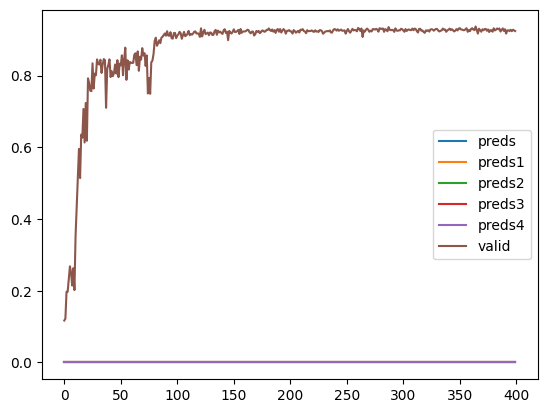

当前 [32, 0.0005, 10, 400, 25]
[0.9489655172413793, 0.949272030651341, 0.9368582375478928]
0.9450319284802045
===
[0.9451461754012517, 0.9453903590378083, 0.9299789112731676]
0.9401718152374091
===
[0.9444169891163648, 0.9442425594669697, 0.9308638823764254]
0.9398411436532532
===
[0.9478456572678542, 0.9480476433717699, 0.9344075335517184]
0.9434336113971141
===


In [10]:
def _freeze_norm_stats(net):
    for m in net.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()
lr = 0.0001
batch_size = 8
train_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop((224,224), scale=(0.75, 1.0)),
        transforms.RandomRotation((-15,15)),
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(),
    ])
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])

average_valid_results = []
average_f1_results = []
average_recall_results = []
average_precision_results = []

average_test_results = []
average_f1_results_test = []
average_recall_results_test = []
average_precision_results_test = []

for config in [[32,0.0005,10,400,25]]:
    
    alphas = [1,1,1,10]
    
    alpha1,alpha2,alpha3,alpha4 = alphas
    average_valid_results = []
    average_f1_results = []
    average_recall_results = []
    average_precision_results = []

    average_test_results = []
    average_f1_results_test = []
    average_recall_results_test = []
    average_precision_results_test = []
    for seed in [2,1,0]:
        distill_flag = False
        batch_size,lr,warmupepoch,epoch_num,select_batch_num = config
        alpha = 1
        
        lrcounter = 0
        seed4batch = seed
        T = 2
        cudnn.benchmark = False
        cudnn.deterministic = True
        torch.manual_seed(seed)  # 为CPU设置随机种子
        torch.cuda.manual_seed(seed)  # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # 为所有GPU设置随机种子
        random.seed(seed)
        np.random.seed(seed)



        def get_num_correct(out, labels):  #求准确率
            return out.argmax(dim=1).eq(labels).sum().item()

        
        teacher = MSFIN_teacher().cuda()
        
        
        
        best_model_path = '/kaggle/input/statefarm-stage1/best'+str(seed)+'.pkl'  # 替换为实际的模型路径
        teacher.load_state_dict(torch.load(best_model_path))
        
        for p in teacher.parameters():
            p.requires_grad = False
        
        model_generator = MSFIN(teacher).cuda()
        

        optimizer_generator = torch.optim.Adam(model_generator.parameters(),lr=lr)
        
        scheduler_warmup_generator = GradualWarmupScheduler(optimizer_generator, multiplier=1, total_epoch=warmupepoch)
        optimizer_generator.zero_grad()
        optimizer_generator.step()
        
        
        maxval=0
        maxtest_followmaxval=0
        maxf1_followmaxval = 0
        maxrecall_followmaxval = 0
        maxprecision_followmaxval = 0
        
        maxf1_followmaxval_test = 0
        maxrecall_followmaxval_test = 0
        maxprecision_followmaxval_test = 0
        
        
        finaltestlabel_followmaxval = []
        finaltestlabel_pred_followmaxval = []

        earlystopcounter = 0

        T = 10
        minvalidloss = 99999

        val_loss_curve = []
        val_acc_curve = []
        test_acc_curve = []
        
        train_acc_1 = []
        train_acc_2 = []
        train_acc_3 = []
        train_acc_4 = []
        train_acc_5 = []
        
        idxlist = [i for i in range(train_len)]
        
        flag1 = 0
        flag2 = 0
        warm_end = False
        
        train_warmup_counter = 0
        max_train_acc = 0
        for epoch in tqdm(range(1,epoch_num+1)):

            scheduler_warmup_generator.step()
            np.random.seed(seed)
            np.random.shuffle(idxlist)
            
            total_loss=0
            total_loss1 = 0
            total_loss3 = 0
            valid_loss = 0
            train_correct=0
            test_correct = 0
            val_correct=0
            
            #model_generator.apply(_freeze_norm_stats)

            
            train_counter = 0
            
            #train_all = 0
            
            train_correct1 = 0
            train_correct2 = 0
            train_correct3 = 0
            train_correct4 = 0
            train_correct5 = 0
            
            def getBatch(len_dataset,batch_size):
                batch_num = len_dataset // batch_size
                batch_res = len_dataset % batch_size

                if batch_res>0:
                    batchlist = [batch_size] * batch_num + [batch_res]
                else:
                    batchlist = [batch_size] * batch_num
                return batchlist
            train_batch_list = getBatch(train_len,batch_size)
            
            for idx,b in enumerate(train_batch_list[:select_batch_num]):
                start = 0+sum(train_batch_list[:idx])
                end = 0+sum(train_batch_list[:idx+1])
                batchidxlist = idxlist[start:end]
                
            
                x = []
                y = []
                y2 = []
                for image_inbatch_id in batchidxlist:
                    d = trainset[image_inbatch_id]
                    x.append(train_transform(d[0]))
                    y.append(d[1])
                    y2.append(d[2])
                
                images = torch.stack(x,0).cuda()
                
                
                labels = torch.LongTensor(y).cuda()
                labels2 = torch.LongTensor(y2).cuda()
                
                model_generator.train()
                preds,loss = model_generator(images,labels)

                optimizer_generator.zero_grad()

                if distill_flag:
                    loss = F.cross_entropy(preds,labels) + loss
                else:
                    loss = F.cross_entropy(preds,labels)



                loss.backward()
                optimizer_generator.step()
    
                
                total_loss+=loss.item()
                total_loss1+=loss.item()
                total_loss3+=loss.item()
                train_correct+=get_num_correct(preds,labels)
            
            print('***训练集***')
            print(train_correct / select_batch_num / 32)
            #print('main branch：',train_correct1/select_batch_num/32)
            if train_correct / select_batch_num / 32 >= max_train_acc:
                max_train_acc = train_correct / select_batch_num / 32
                train_warmup_counter = 0
            else:
                train_warmup_counter += 1
                if train_warmup_counter == 10:
                    distill_flag = True
                    print('开始蒸馏')

            
            valid_preds = []
            valid_labels = []
                
            model_generator.eval()
            with torch.no_grad():
                validxlist = [i for i in range(valid_len)]
                valid_batch_list = getBatch(valid_len,batch_size)
                
                for idx,b in enumerate(valid_batch_list):
                    start = 0+sum(valid_batch_list[:idx])
                    end = 0+sum(valid_batch_list[:idx+1])
                    batchidxlist = validxlist[start:end]

                    x = []
                    y = []
                    y2 = []
                    for image_inbatch_id in batchidxlist:
                        #im_o = 
                        d = validset[image_inbatch_id]
                        #print()
                        x.append(test_transform(d[0]))
                        y.append(d[1])
                        y2.append(d[2])

                    images = torch.stack(x,0).cuda()#.permute(0,3,1,2) / 255
                    labels = torch.LongTensor(y).cuda()
                    #mask,preds3 = stage1(premodel,images)
                    #images = (images)

                    preds,_ = model_generator(images,labels)

                    #preds = model(images)
                    loss = F.cross_entropy(preds,labels)
                    
                    valid_loss+=loss.item()
                    val_correct+=get_num_correct(preds,labels)
                    
                    valid_preds += preds.argmax(-1).cpu().numpy().tolist()
                    valid_labels += y
            '''if val_correct/valid_len >= 0.85 and not warm_end:
                print('预热结束')
                warm_end = True'''
            F1=f1_score(valid_labels,valid_preds,average="macro")
            print("valid-f1:",F1)
            precision=precision_score(valid_labels,valid_preds,average="macro")
            print("valid-precision:",precision)
            recall=recall_score(valid_labels,valid_preds,average="macro")
            print("valid-recall:",recall)
            
            print('process:',epoch," loss:",total_loss," train_correct:",train_correct/train_len,'valid_loss',valid_loss," val_correct:",val_correct/valid_len)
            train_acc = train_correct/train_len
            val_acc=val_correct/valid_len
            
            train_acc_1.append(train_correct1/train_all)
            train_acc_2.append(train_correct2/train_all)
            train_acc_3.append(train_correct3/train_all)
            train_acc_4.append(train_correct4/train_all)
            train_acc_5.append(train_correct5/train_all)
            val_loss_curve.append(valid_loss)
            val_acc_curve.append(val_acc)
            #test_acc_curve.append(test_acc)
            
            
            
            
            if val_acc > maxval:
                
                maxval = val_acc
                maxf1_followmaxval = F1
                maxrecall_followmaxval = recall
                maxprecision_followmaxval = precision

                
                earlystopcounter = 0
                torch.save(model_generator.state_dict(), 'best'+str(seed)+'.pkl')
                print('The model has been saved!!')
                print('The best val_acc is ',maxval)
            '''else:
                earlystopcounter += 1
                if earlystopcounter == 10:
                    print('早停')
                    print('The best val_acc is ',maxval,'The best test_acc is ',best_test_acc)
                    break'''
        x = range(len(val_loss_curve))


        plt.figure()
        
        plt.plot(x, train_acc_1,label = 'preds')
        plt.plot(x, train_acc_2,label = 'preds1')
        plt.plot(x, train_acc_3,label = 'preds2')
        plt.plot(x, train_acc_4,label = 'preds3')
        plt.plot(x, train_acc_5,label = 'preds4')

        plt.plot(x, val_acc_curve,label = 'valid')

        plt.legend()
        plt.show()
        average_valid_results.append(maxval)
        average_f1_results.append(maxf1_followmaxval)
        average_recall_results.append(maxrecall_followmaxval)
        average_precision_results.append(maxprecision_followmaxval)

    def summary(average_valid_results):
        print(average_valid_results)
        print(sum(average_valid_results)/len(average_valid_results))
        print('===')

    print('当前',config)
    summary(average_valid_results)
    summary(average_f1_results)
    summary(average_recall_results)
    summary(average_precision_results)

